In [1]:
import csv
import pandas as pd
import hickle as hkl
import numpy as np
import scipy.sparse as sp
import sklearn.preprocessing as sk
from sklearn.feature_selection import VarianceThreshold

from torch.utils.data import TensorDataset, random_split, DataLoader,Dataset, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

from torch_geometric.data import Batch   

import torch

import random,os

from sklearn.metrics import roc_auc_score,precision_recall_curve

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class MyDataset(Dataset):
    def __init__(self, input_df1,input_df2):
        super(MyDataset, self).__init__()
        self.input_df1 = input_df1
        self.input_df2 = input_df2
        
    def __len__(self):
        return len(self.input_df1)

    def __getitem__(self, index):
        return (self.input_df1['drug'][index], self.input_df1['ids'][index], self.input_df1['expres'][index],self.input_df2['ids'][index], self.input_df2['expres'][index],self.input_df1['IC50'][index])

class MyDataset_simple(Dataset):
    def __init__(self, input_df1,input_df2):
        super(MyDataset_simple, self).__init__()
        self.input_df1 = input_df1
        self.input_df2 = input_df2
        
    def __len__(self):
        return len(self.input_df1)

    def __getitem__(self, index):
        return (self.input_df1['drug'][index], self.input_df1['expres'][index],self.input_df2['expres'][index],self.input_df1['IC50'][index])


def _collate(samples):
    drugs, ids_gexpr, expres_gexpr, ids_methyl, expres_methyl,labels = map(list, zip(*samples))
    batched_drug = Batch.from_data_list(drugs)
    return batched_drug, torch.tensor(ids_gexpr), torch.tensor(expres_gexpr), torch.tensor(ids_methyl), torch.tensor(expres_methyl),torch.tensor(labels)

def collate_simple(samples):
    drugs, expres_gexpr, expres_methyl,labels = map(list, zip(*samples))
    batched_drug = Batch.from_data_list(drugs)
    return batched_drug, torch.tensor(expres_gexpr), torch.tensor(expres_methyl),torch.tensor(labels)


def get_gnn_dataloader(df_gexpr,df_methyl, batch_size=64, simple = False):
    if simple:
        dataset = MyDataset_simple(df_gexpr,df_methyl)
        collate_fn = collate_simple

    else:
        dataset = MyDataset(df_gexpr,df_methyl)
        collate_fn = _collate
        
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
    
    return dataloader

def get_gnn_input_df(data_idx,drug_dict,data_feature,over_under_ids_df,over_under_genes_df):
    
    #data_feature.index = data_feature.index.astype(str)
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    df['drug'] = 0; 
    #all_drugs = set(df['drug id'])
    for drug_id in drug_dict.keys():
        new_df = pd.DataFrame({'drug': [drug_dict[drug_id]]}, index=df[df['drug id'].isin([str(drug_id)])].index)
        df.update(new_df)
        
    df['ids'] = 0; df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    #cell_ids = list(set(data_feature.index.values).intersection(cell_ids))
    
    cell_df = pd.DataFrame(index = cell_ids, columns = ['ids','expres'])
    for cell_id in cell_ids:
        genes = over_under_genes_df.loc[cell_id].values
        #data_feature[idx,:] = data_feature.loc[cell_line_id][genes].values
        cell_df.loc[cell_id]['ids'] = over_under_ids_df.loc[cell_id].values
        cell_df.loc[cell_id]['expres'] = data_feature.loc[cell_id][genes].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'ids': [cell_df['ids'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df

def get_drug_cell_info(Drug_info_file,Drug_feature_file,Gene_expression_file,Methylation_file, cancer_response_exp_file,
                       threshold = 6.3, norm = False, small_genes = False):
                   
    #drug_id --> pubchem_id
    reader = csv.reader(open(Drug_info_file,'r'))
    rows = [item for item in reader]
    drugid2pubchemid = {item[0]:item[6] for item in rows if item[6].isdigit()}
       

    # load drug features
    drug_pubchem_id_set = []
    drug_feature = {}
    
    for each in os.listdir(Drug_feature_file):
        drug_pubchem_id_set.append(each.split('.')[0])
        feat_mat,adj_list,degree_list = hkl.load('%s/%s'%(Drug_feature_file,each))
        drug_feature[each.split('.')[0]] = [feat_mat,adj_list,degree_list]
    assert len(drug_pubchem_id_set)==len(drug_feature.values())
    

    gexpr_feature = pd.read_csv(Gene_expression_file,sep=',',header=0,index_col=[0])


    # scalerGDSC = sk.StandardScaler()
    # scalerGDSC.fit(gexpr_feature.values)
    # gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
    #                                 index = gexpr_feature.index,
    #                                 columns = gexpr_feature.columns)
    # methyl_feature = pd.read_csv(Methylation_file,sep=',',header=0,index_col=[0])


    # scalerGDSC = sk.StandardScaler()
    # scalerGDSC.fit(methyl_feature.values)
    # methyl_feature = pd.DataFrame(data=scalerGDSC.transform(methyl_feature.values),
    #                                 index = methyl_feature.index,
    #                                 columns = methyl_feature.columns)
                                     
    assert methyl_feature.shape[0]==gexpr_feature.shape[0]

    gexpr_feature.columns = gexpr_feature.columns.astype(str)
    methyl_feature.columns = methyl_feature.columns.astype(str)

    experiment_data = pd.read_csv(cancer_response_exp_file,sep=',',header=0,index_col=[0],engine='python')
    

    for i in range(len(experiment_data.columns)):
        experiment_data.rename(columns={experiment_data.columns[i]:'DATA.'+str(experiment_data.columns[i])},inplace=True)


    
    return drugid2pubchemid, drug_pubchem_id_set, gexpr_feature, methyl_feature, drug_feature, experiment_data
    
def get_idx(drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,methyl_feature,experiment_data,binary=False):
    
    #filter experiment data
    drug_match_list=[item for item in experiment_data.index if item.split(':')[1] in drugid2pubchemid.keys()]
    experiment_data_filtered = experiment_data.loc[drug_match_list]
     
    data_idx = []
    for each_drug in experiment_data_filtered.index:
        for each_cellline in experiment_data_filtered.columns:
            pubchem_id = drugid2pubchemid[each_drug.split(':')[-1]]
            if str(pubchem_id) in drug_pubchem_id_set and each_cellline:
                if not np.isnan(experiment_data_filtered.loc[each_drug,each_cellline]) and each_cellline in gexpr_feature.index:
                    ln_IC50 = float(experiment_data_filtered.loc[each_drug,each_cellline])
                    data_idx.append((each_cellline,pubchem_id,ln_IC50)) 
    nb_celllines = len(set([item[0] for item in data_idx]))
    nb_drugs = len(set([item[1] for item in data_idx]))
    print('%d instances across %d cell lines and %d drugs were generated.'
          %(len(data_idx),nb_celllines,nb_drugs))
        
    return data_idx

def get_input_df(data_idx,drug_feature,gexpr_feature,over_under_ids_df,over_under_genes_df):
    
    #gexpr_feature.index = gexpr_feature.index.astype(str)
    
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    
    drug_df = pd.DataFrame(index = drug_feature.keys(),columns = ['data'])
    for drug_id in drug_feature.keys():
        feat_mat,adj_list,_ = drug_feature[drug_id]
        drug_df.loc[drug_id]['data'] = CalculateGraphFeat(feat_mat,adj_list)
    
    df['drug1'] = 0; df['drug2'] = 0; 
    
    for drug_id in drug_df.index:
        new_df = pd.DataFrame({'drug1': [drug_df['data'][drug_id][0]]}, index=df[df['drug id'].isin([drug_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'drug2': [drug_df['data'][drug_id][1]]}, index=df[df['drug id'].isin([drug_id])].index)
        df.update(new_df)
        
    df['ids'] = 0; df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    #cell_ids = list(set(gexpr_feature.index.values).intersection(cell_ids))
    
    cell_df = pd.DataFrame(index = cell_ids, columns = ['ids','expres'])
    for cell_id in cell_ids:
        genes = over_under_genes_df.loc[cell_id].values
        #gexpr_data[idx,:] = gexpr_feature.loc[cell_line_id][genes].values
        cell_df.loc[cell_id]['ids'] = over_under_ids_df.loc[cell_id].values
        cell_df.loc[cell_id]['expres'] = gexpr_feature.loc[cell_id][genes].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'ids': [cell_df['ids'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df

def get_simple_input_df(data_idx,drug_feature,gexpr_feature,drug_dict = {}):
    
    #gexpr_feature.index = gexpr_feature.index.astype(str)
    
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    if len(drug_dict):
        df['drug'] = 0; 
        
        for drug_id in drug_dict.keys():
            new_df = pd.DataFrame({'drug': [drug_dict[drug_id]]}, index=df[df['drug id'].isin([str(drug_id)])].index)
            df.update(new_df)
    else:
        drug_df = pd.DataFrame(index = drug_feature.keys(),columns = ['data'])
        
        for drug_id in drug_feature.keys():
            feat_mat,adj_list,_ = drug_feature[drug_id]
            drug_df.loc[drug_id]['data'] = CalculateGraphFeat(feat_mat,adj_list)
        
        df['drug1'] = 0; df['drug2'] = 0; 
        
        for drug_id in drug_df.index:
            new_df = pd.DataFrame({'drug1': [drug_df['data'][drug_id][0]]}, index=df[df['drug id'].isin([drug_id])].index)
            df.update(new_df)
            new_df = pd.DataFrame({'drug2': [drug_df['data'][drug_id][1]]}, index=df[df['drug id'].isin([drug_id])].index)
            df.update(new_df)
        
    df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    cell_df = pd.DataFrame(index = cell_ids, columns = ['expres'])
    for cell_id in cell_ids:
        cell_df.loc[cell_id]['expres'] = gexpr_feature.loc[cell_id].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df


def get_dataloader(drug_ids,sample_ids,input_df_gexpr,input_df_methyl,simple = False, batch_size=64, val_ratio=None, test_ratio = None):
    df_gexpr = input_df_gexpr
    if sample_ids:
        df_gexpr = df_gexpr[df_gexpr['cell id'].isin(sample_ids)]
    if drug_ids:
        df_gexpr = df_gexpr[df_gexpr['drug id'].isin(drug_ids)]
    df_methyl = input_df_methyl
    if sample_ids:
        df_methyl = df_methyl[df_methyl['cell id'].isin(sample_ids)]
    if drug_ids:
        df_methyl = df_methyl[df_methyl['drug id'].isin(drug_ids)]

    X_drug_feat_data = [item for item in df_gexpr['drug1']]
    X_drug_adj_data = [item for item in df_gexpr['drug2']]
    X_drug_feat_data = np.array(X_drug_feat_data)#nb_instance * Max_stom * feat_dim
    X_drug_adj_data = np.array(X_drug_adj_data)#nb_instance * Max_stom * Max_stom
    
    X_drug_feat_data = torch.Tensor(X_drug_feat_data)
    X_drug_adj_data = torch.Tensor(X_drug_adj_data)
    
    
    X_gexpr_data = [item for item in df_gexpr['expres']]
    X_gexpr_data = torch.Tensor(X_gexpr_data)
    X_methyl_data = [item for item in df_methyl['expres']]
    X_methyl_data = torch.Tensor(X_methyl_data) 

    Y = [item for item in df_gexpr['IC50']]
    Y = torch.Tensor(Y)
    
    if not simple:
        X_genes_data_gexpr = [item for item in df_gexpr['ids']]
        X_genes_data_gexpr = torch.Tensor(X_genes_data_gexpr)
        X_genes_data_gexpr = X_genes_data_gexpr.type(torch.int64)
        X_genes_data_methyl = [item for item in df_methyl['ids']]
        X_genes_data_methyl = torch.Tensor(X_genes_data_methyl)
        X_genes_data_methyl = X_genes_data_methyl.type(torch.int64)
        
        dataset = TensorDataset(X_drug_feat_data,X_drug_adj_data, X_genes_data_gexpr,X_gexpr_data,X_genes_data_methyl,X_methyl_data,Y)
    else:
        dataset = TensorDataset(X_drug_feat_data,X_drug_adj_data, X_genes_data_gexpr,X_gexpr_data,X_genes_data_methyl,X_methyl_data,Y)
    if val_ratio:
        
        if test_ratio:
            test_size = int(test_ratio * len(dataset))
            train_size = len(dataset) - test_size
            dataset, test_dataset = random_split(dataset, [train_size, test_size])
            test_dataloader = DataLoader(
                        test_dataset, # The validation samples.
                        sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                        batch_size = batch_size # Evaluate with this batch size.
                    )
            
        val_size = int(val_ratio * len(dataset))
        train_size = len(dataset) - val_size
            
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = batch_size # Trains with this batch size.
                )
        
        # For validation the order doesn't matter, so we'll just read them sequentially.
        validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = batch_size # Evaluate with this batch size.
                )
        
    else:
        train_dataloader = DataLoader(
                    dataset,  # The training samples.
                    sampler = RandomSampler(dataset), # Select batches randomly
                    batch_size = batch_size # Trains with this batch size.
                )
        
    if test_ratio:
        return train_dataloader, validation_dataloader, test_dataloader
    elif val_ratio:
        return train_dataloader, validation_dataloader
    else:
        return train_dataloader

def show_picture(train,val, test, title, path='' ,save=False):
    plt.plot(train)
    plt.plot(val)
    plt.plot(test)
    plt.legend(['train','val','test'])
    plt.title(title)
    if save:
        plt.savefig(path+title+'.png')
    
    plt.show()
    
def get_rand_genes(tokenizer, x_samples, nGenes, gexpr_feature):
    gexpr = gexpr_feature.loc[x_samples]
    genes = gexpr_feature.columns.values
    rand_genes = [random.choices(population=genes, k=nGenes) for i in range(gexpr.shape[0])]
    rand_ids = torch.tensor([tokenizer.convert_symb_to_id(genes) for genes in rand_genes])
    rand_exprs  = torch.tensor([gexpr.iloc[i][rand_genes[i]].values for i in range(len(rand_genes))])
    
    return rand_ids,rand_exprs

Max_atoms = 100

def NormalizeAdj(adj):
    adj = adj + np.eye(adj.shape[0])
    d = sp.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0).toarray()
    a_norm = adj.dot(d).transpose().dot(d)
    return a_norm

def random_adjacency_matrix(n):   
    matrix = [[random.randint(0, 1) for i in range(n)] for j in range(n)]
    # No vertex connects to itself
    for i in range(n):
        matrix[i][i] = 0
    # If i is connected to j, j is connected to i
    for i in range(n):
        for j in range(n):
            matrix[j][i] = matrix[i][j]
    return matrix

def CalculateGraphFeat(feat_mat,adj_list):
    assert feat_mat.shape[0] == len(adj_list)
    feat = np.zeros((Max_atoms,feat_mat.shape[-1]),dtype='float32')
    adj_mat = np.zeros((Max_atoms,Max_atoms),dtype='float32')
    if True:
        feat = np.random.rand(Max_atoms,feat_mat.shape[-1])
        adj_mat[feat_mat.shape[0]:,feat_mat.shape[0]:] = random_adjacency_matrix(Max_atoms-feat_mat.shape[0])        
    feat[:feat_mat.shape[0],:] = feat_mat
    for i in range(len(adj_list)):
        nodes = adj_list[i]
        for each in nodes:
            adj_mat[i,int(each)] = 1
    assert np.allclose(adj_mat,adj_mat.T)
    adj_ = adj_mat[:len(adj_list),:len(adj_list)]
    adj_2 = adj_mat[len(adj_list):,len(adj_list):]
    norm_adj_ = NormalizeAdj(adj_)
    norm_adj_2 = NormalizeAdj(adj_2)
    adj_mat[:len(adj_list),:len(adj_list)] = norm_adj_
    adj_mat[len(adj_list):,len(adj_list):] = norm_adj_2    
    return [feat,adj_mat]


def metrics_graph(yt, yp):
    precision, recall, _, = precision_recall_curve(yt, yp)
    aupr = -np.trapz(precision, recall)
    auc = roc_auc_score(yt, yp)
    #---f1,acc,recall, specificity, precision
    real_score=np.mat(yt)
    predict_score=np.mat(yp)
    sorted_predict_score = np.array(sorted(list(set(np.array(predict_score).flatten()))))
    sorted_predict_score_num = len(sorted_predict_score)
    thresholds = sorted_predict_score[np.int32(sorted_predict_score_num * np.arange(1, 1000) / 1000)]
    thresholds = np.mat(thresholds)
    thresholds_num = thresholds.shape[1]
    predict_score_matrix = np.tile(predict_score, (thresholds_num, 1))
    negative_index = np.where(predict_score_matrix < thresholds.T)
    positive_index = np.where(predict_score_matrix >= thresholds.T)
    predict_score_matrix[negative_index] = 0
    predict_score_matrix[positive_index] = 1
    TP = predict_score_matrix.dot(real_score.T)
    FP = predict_score_matrix.sum(axis=1) - TP
    FN = real_score.sum() - TP
    TN = len(real_score.T) - TP - FP - FN
    tpr = TP / (TP + FN)
    recall_list = tpr
    precision_list = TP / (TP + FP)
    f1_score_list = 2 * TP / (len(real_score.T) + TP - TN)
    accuracy_list = (TP + TN) / len(real_score.T)
    specificity_list = TN / (TN + FP)
    max_index = np.argmax(f1_score_list)
    f1_score = f1_score_list[max_index]
    accuracy = accuracy_list[max_index]
    specificity = specificity_list[max_index]
    recall = recall_list[max_index]
    precision = precision_list[max_index]
    return auc, aupr, f1_score[0, 0], accuracy[0, 0], recall[0, 0], specificity[0, 0], precision[0, 0]

def get_binary_gene_set(tokenizer, gexpr_feature, nGenes, random_genes = True, num_augment = 1):
    abs_gexpr = np.abs(gexpr_feature-np.mean(gexpr_feature))
    
    all_genes = list(gexpr_feature.columns)
    
    over_under_genes_list = [[] for i in range(num_augment)]
    over_under_ids_list = [[] for i in range(num_augment)]
    
    for i in range(abs_gexpr.shape[0]):
        
        for j in range(num_augment):
            if j ==0 or not(random_genes):
                genes = abs_gexpr.iloc[i].sort_values(ascending = False)[nGenes*j:nGenes*(j+1)].index
            else:
                genes = random.sample(all_genes, nGenes)
                
            ids = tokenizer.convert_symb_to_id(genes)
            
            over_under_ids_list[j].append(ids)
            over_under_genes_list[j].append(genes)
    
    over_under_ids_df_list = [pd.DataFrame(data = over_under_ids_list[i],index = gexpr_feature.index) for i in range(num_augment)]
    over_under_genes_df_list = [pd.DataFrame(data = over_under_genes_list[i],index = gexpr_feature.index) for i in range(num_augment)]
    return over_under_ids_df_list, over_under_genes_df_list


def get_gene_set(tokenizer, gexpr_feature, methyl_feature,nGenes, random_genes = True):
    # scalerGDSC = sk.StandardScaler()
    # scalerGDSC.fit(methyl_feature.values)
    # methyl_feature = pd.DataFrame(data=scalerGDSC.transform(methyl_feature.values),
    #                                 index = methyl_feature.index,
    #                                 columns = methyl_feature.columns)

    # scalerGDSC = sk.StandardScaler()
    # scalerGDSC.fit(gexpr_feature.values)
    # gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
    #                                 index = gexpr_feature.index,
    #                                 columns = gexpr_feature.columns)
    
    over_under_genes = []
    over_under_ids = []
    
    #all_genes = list(gexpr_feature.columns)
    
    for i in range(gexpr_feature.shape[0]):
        #genes = random.sample(all_genes, nGenes)
        genes = (methyl_feature * gexpr_feature).iloc[i].sort_values(ascending = True)[:nGenes].index
        ids = tokenizer.convert_symb_to_id(genes)
        
        over_under_ids.append(ids)
        over_under_genes.append(genes)
    
    over_under_ids_df_gexpr = pd.DataFrame(data = over_under_ids,index = gexpr_feature.index)
    over_under_genes_df_gexpr = pd.DataFrame(data = over_under_genes,index = gexpr_feature.index)
    over_under_ids_df_methyl = pd.DataFrame(data = over_under_ids,index = gexpr_feature.index)
    over_under_genes_df_methyl = pd.DataFrame(data = over_under_genes,index = gexpr_feature.index)

    return  over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl

In [2]:
import torch
import torch.nn as nn   

from torch_geometric.nn import GINConv, JumpingKnowledge, global_max_pool, GATConv

import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import math

from sklearn.utils import shuffle
import collections
import pandas as pd
def xavier_init(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

def batch_norm_init(m):
    if isinstance(m, nn.BatchNorm1d):
        m.reset_parameters()
        
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class Gene_Embedding(nn.Module):
    def __init__(self, vocab_size= None,embed_size=None):
        super(Gene_Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding_dim = embed_size
        self.eps = 1e-12
        
    def forward(self, genes=None,scales=None):
        x = self.embedding(genes)
        x = self.unit(x)
        x *= scales.unsqueeze(-1) 
        return x
        
    def unit(self,x):
        return (x+self.eps)/(torch.norm(x,dim=2).unsqueeze(-1)+self.eps)


class Tokenizer():
    def __init__(
        self, Gene_vocab, shuf= True, pad_token=0, sep_token=1, unk_token=2, cls_token=3, mask_token=4, **kwargs):
        super().__init__()
        self.Gene_vocab = Gene_vocab
        self.unk_token = unk_token
        self.sep_token = sep_token
        self.pad_token = pad_token
        self.cls_token = cls_token
        self.mask_token = mask_token
        self.shuf = shuf
        
        self.special_tokens = {'UNK':self.unk_token, 'SEP':self.sep_token, 
                               'PAD':self.pad_token, 'CLS':self.cls_token,
                               'MASK':self.mask_token}
        

        self.symb_to_id = collections.OrderedDict([(SYMBOL, ID) for SYMBOL,ID in self.Gene_vocab.values])
        
    @property
    def vocab_size(self):
        return len(self.Gene_vacab)

    def get_vocab(self):
        return self.Gene_vocab 
    
    def tokenize(self, sample):
        pathway = sample['pathway']
        sample_Id = sample['Id']
        genes_scales = pd.Series(data = sample['scales'],index = sample['genes'])
        genes = list(genes_scales.index.astype(str))
        scales = list(genes_scales.values)
        
        if self.shuf:
            genes,scales = shuffle(genes, scales)
                
        token = {"pathway":pathway,"sample_Id":sample_Id,
                 "genes":genes,"scales":scales}
        
        return token
    
    def check_unk(self,genes):
        genes = [gene if gene is not None else self.special_tokens['UNK'] for gene in genes]
        return genes
    
    def check_mis_scale(self,scales):
        scales = [scale if scale > 1e-12 else 1.0 for scale in scales]
        return scales
                
    def convert_symb_to_id(self, symbs):
        return [self.symb_to_id.get(symb) for symb in symbs]


    def convert_id_to_symb(self, indices):
        return [list(self.symb_to_id.keys())[list(self.symb_to_id.values()).index(index)] for index in indices]
    
    def encode(self, sample, add_special_tokens = True, 
               max_length = 128, pad_to_max_length = True,
               gene_type = 'SYMBOL'):
        
        token = self.tokenize(sample)

        token['genes'] = self.convert_symb_to_id(token['genes'])
        
        token['genes'] = self.check_unk(token['genes'])
        token['scales'] = self.check_mis_scale(token['scales'])
        
        if add_special_tokens:
            token['genes'] = [self.special_tokens['CLS']] + token['genes'] + [self.special_tokens['SEP']]
            token['scales'] = [1] + token['scales'] + [1] 
        
        if pad_to_max_length:
            token['genes'] += [self.special_tokens['PAD']]*(max_length+2 - len(token['genes']))
            token['scales'] += [self.special_tokens['PAD']]*(max_length+2 - len(token['scales']))
            
        return token
    
    def encode2torch(self, sample, add_special_tokens = True, 
                    max_length = 128, pad_to_max_length = True,
                    gene_type = 'SYMBOL'):
        
        token = self.encode(sample, add_special_tokens = add_special_tokens
                            ,gene_type = gene_type)
            
        token['genes'] = torch.tensor(token['genes'])
        token['scales'] = torch.tensor(token['scales'], dtype=torch.float)
            
        return token
    
    
    def encode_pair(self, sample1, sample2, add_special_tokens = True, 
                    max_len = 128, pad_to_max_length = True,
                    return_attention_mask = False,
                    gene_type = 'ENTREZID'):
        
        token1 = self.tokenize(sample1)
        token2 = self.tokenize(sample2)
        pair_token = {}
        

        token1['genes'] = self.convert_symb_to_id(token1['genes'])
        token2['genes'] = self.convert_symb_to_id(token2['genes'])
        
        token1['genes'] = self.check_unk(token1['genes'])
        token2['genes'] = self.check_unk(token2['genes'])
        
        token1['scales'] = self.check_mis_scale(token1['scales'])
        token2['scales'] = self.check_mis_scale(token2['scales'])
        
        if add_special_tokens:
            token1['genes'] = [self.special_tokens['CLS']] + token1['genes'] + [self.special_tokens['SEP']]
            token2['genes'] = token2['genes'] + [self.special_tokens['SEP']]
            
            token1['scales'] = [1] + token1['scales'] + [1]
            token2['scales'] = token2['scales'] + [1] 
            
        pair_token['genes'] = token1['genes'] + token2['genes'] 
        pair_token['scales'] = token1['scales'] + token2['scales']
            
        if pad_to_max_length:
            pair_token['genes'] += [self.special_tokens['PAD']]*(max_len-len(pair_token['genes']))
            pair_token['scales'] += [self.special_tokens['PAD']]*(max_len-len(pair_token['scales']))
            
        pair_token['genes'] = torch.tensor(pair_token['genes'])
        pair_token['scales'] = torch.tensor(pair_token['scales'], dtype=torch.float)
        pair_token['sample_Ids'] = (sample1['Id'],sample2['Id'])
        pair_token['pathways'] = (sample1['pathway'],sample2['pathway'])
        
        return pair_token
    

class GEN(torch.nn.Module):
    def __init__(self, y_dim = 256, dropout_ratio = 0.3,
                 gnn = None, embedding = None, encoder = None):
        super().__init__()
        self.encoder = encoder
        self.embedding = embedding 
        self.gnn = gnn 
        
        self.dropout_ratio = dropout_ratio
        self.y_dim = y_dim
    
        self.do = nn.Dropout(self.dropout_ratio)
        
        self.regression = nn.Sequential(
            nn.Linear(self.y_dim, 512),
            nn.ELU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(512, 512),
            nn.ELU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(512, 1)
        )
        self.regression.apply(xavier_init)
        
        
    def forward(self,x_drug,x_gexpr, x_genes_gexpr,x_methyl, x_genes_methyl):
        x_d = self.gnn(x_drug)     
        x_g = self.embedding(x_genes_gexpr, x_gexpr)
        x_m = self.embedding(x_genes_methyl, x_methyl)
        
        x = self.encoder(x_g,x_m,x_d)
        
        y = self.regression(x)
        
        return y


class Att_Encoder(nn.Module):
    def __init__(self, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(Att_Encoder, self).__init__()
        
        self.key_fc = nn.Linear(x_dim,y_dim)
        self.query_fc = nn.Linear(x_dim,y_dim)
        self.value_fc = nn.Linear(x_dim,y_dim)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        key = self.key_fc(x) #Q
        query = self.query_fc(x) #K
        value = self.value_fc(x)
        
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))
        att = self.softmax(scores)
        
        y = torch.matmul(att, value)
        y = self.layer_norm(y)+value
        y = self.dropout(y)
        
        return y

class Transformer_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15, encoder = None):
        super(Transformer_Encoder, self).__init__()
        
        self.key_fc = nn.Linear(x_dim,y_dim)
        self.query_fc = nn.Linear(x_dim,y_dim)
        self.value_fc = nn.Linear(x_dim,y_dim)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder

        self.key_fc.apply(xavier_init)
        self.query_fc.apply(xavier_init)
        self.value_fc.apply(xavier_init)
                    
    def forward(self, g: torch.Tensor, m:torch.Tensor) -> torch.Tensor:
        x = torch.cat([g,m],dim=1)
        key = self.key_fc(x) 
        query = self.query_fc(x) 
        value = self.value_fc(x)
        
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))
        att = self.softmax(scores)
        
        y = torch.matmul(att, value)
        y = self.layer_norm(y)+value
        
        if self.encoder is not None:
            y = self.encoder(y) + y
        
        return y

class MixedFC_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(MixedFC_Encoder, self).__init__()
        
        self.feed1 = nn.Linear(x_dim,y_dim)
        self.feed2 = nn.Linear(genes,genes)
        self.layer_norm1 = nn.LayerNorm(y_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.layer_norm1(self.feed2(self.activation(self.feed1(x)).permute(0,2,1)).permute(0,2,1))
        y = self.dropout(y)
        
        return y

class SimpleFC_Encoder(nn.Module):
    def __init__(self, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(SimpleFC_Encoder, self).__init__()
        
        self.feed1 = nn.Linear(x_dim,y_dim)
        self.feed2 = nn.Linear(y_dim,y_dim)
        self.layer_norm1 = nn.LayerNorm(y_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.layer_norm1(self.feed2(self.activation(self.feed1(x))))
        y = self.dropout(y)
        
        return y
def xavier_init(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)
            
class Co_Att_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15, encoder = None):
        super(Co_Att_Encoder, self).__init__()
        
        self.key_ge_fc = nn.Linear(x_dim,y_dim)
        self.query_ge_fc = nn.Linear(x_dim,y_dim)
        self.value_ge_fc = nn.Linear(x_dim,y_dim)
        
        
        self.key_me_fc = nn.Linear(x_dim,y_dim)
        self.query_me_fc = nn.Linear(x_dim,y_dim)
        self.value_me_fc = nn.Linear(x_dim,y_dim)
        
        
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder        

        self.key_ge_fc = self.key_ge_fc.apply(xavier_init)
        self.query_ge_fc = self.query_ge_fc.apply(xavier_init)
        self.value_ge_fc = self.value_ge_fc.apply(xavier_init)
        self.key_me_fc = self.key_me_fc.apply(xavier_init)
        self.query_me_fc = self.query_me_fc.apply(xavier_init)
        self.value_me_fc = self.value_me_fc.apply(xavier_init)


    def forward(self, x: torch.Tensor, m: torch.Tensor) -> torch.Tensor:
        query_ge = self.query_ge_fc(x) #K
        key_ge = self.key_ge_fc(x) #Q
        value_ge = self.value_ge_fc(x)
        
        query_me = self.query_me_fc(m) #K
        key_me = self.key_me_fc(m) #Q
        value_me = self.value_me_fc(m)
        
        scores_ge = torch.matmul(query_ge, key_me.transpose(-2, -1)) \
                 / math.sqrt(query_ge.size(-1))
                 
        scores_me = torch.matmul(query_me, key_ge.transpose(-2, -1)) \
                 / math.sqrt(query_me.size(-1))
        
                
        att_ge = self.softmax(scores_ge) 
        att_me = self.softmax(scores_me)
        
        y_ge = torch.matmul(att_ge, value_me)
        y_me = torch.matmul(att_me, value_ge)
        
        y_ge = self.layer_norm(y_ge)+query_ge
        y_me = self.layer_norm(y_me)+query_me
        
        
        y = torch.cat([y_ge,y_me],dim=1)
        y = self.layer_norm(y)
        y = self.dropout(y)
        
        return y 


class Merged_Att_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15, encoder = None):
        super(Merged_Att_Encoder, self).__init__()
        
        self.key_ge_fc = nn.Linear(x_dim,y_dim)
        self.query_ge_fc = nn.Linear(x_dim,y_dim)
        self.value_ge_fc = nn.Linear(x_dim,y_dim)
        
        
        self.key_me_fc = nn.Linear(x_dim,y_dim)
        self.query_me_fc = nn.Linear(x_dim,y_dim)
        self.value_me_fc = nn.Linear(x_dim,y_dim)
        
        
        self.layer_norm2 = nn.LayerNorm(genes*2)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder           

        self.key_ge_fc = self.key_ge_fc.apply(xavier_init)
        self.query_ge_fc = self.query_ge_fc.apply(xavier_init)
        self.value_ge_fc = self.value_ge_fc.apply(xavier_init)
        self.key_me_fc = self.key_me_fc.apply(xavier_init)
        self.query_me_fc = self.query_me_fc.apply(xavier_init)
        self.value_me_fc = self.value_me_fc.apply(xavier_init)

    def forward(self, x: torch.Tensor, m: torch.Tensor) -> torch.Tensor:
        co_x = torch.cat([x,m],dim=1)
        
        query_ge = self.query_ge_fc(x) #K
        key_ge = self.key_ge_fc(co_x) #Q
        value_ge = self.value_ge_fc(co_x)
        
        query_me = self.query_me_fc(m) #K
        key_me = self.key_me_fc(co_x) #Q
        value_me = self.value_me_fc(co_x)
        
        scores_ge = torch.matmul(query_ge, key_me.transpose(-2, -1)) \
                 / math.sqrt(query_ge.size(-1))
                 
        scores_me = torch.matmul(query_me, key_ge.transpose(-2, -1)) \
                 / math.sqrt(query_me.size(-1))
        
                
        att_ge = self.softmax(scores_ge) 
        att_me = self.softmax(scores_me)
        
        y_ge = torch.matmul(att_ge, value_me)
        y_me = torch.matmul(att_me, value_ge)
        
        y_ge = self.layer_norm(y_ge)+query_ge
        y_me = self.layer_norm(y_me)+query_me
        
        
        y = torch.cat([y_ge,y_me],dim=1)
        y = self.layer_norm(y)
        y = self.dropout(y)
        
        return y 
        
class Main_Encoder(nn.Module):
    def __init__(self, cell_encoder = None, d_dim = 128, 
                 genes=300, y_dim=512, dropout = 0.15):
        
        super(Main_Encoder, self).__init__()
        self.cell_encoder = cell_encoder
        
        self.feed1 = nn.Linear(d_dim,y_dim)
        self.feed2 = nn.Linear(y_dim,y_dim)
        self.activation = GELU() 
        
        self.layer_norm1 = nn.LayerNorm(y_dim*2)
        self.dropout = nn.Dropout(dropout)

        self.feed1.apply(xavier_init)
        self.feed2.apply(xavier_init)
        
    def forward(self, x_g: torch.Tensor,x_m:torch.Tensor, x_d: torch.Tensor) -> torch.Tensor:
        x1 = self.cell_encoder(x_g,x_m)
        y1, _ = torch.max(x1, dim= 1)  # [batchsize, embeddings_dim]
        
        y2 = self.feed2(self.activation(self.feed1(x_d)))
        
        y = torch.cat([y1,y2],dim = 1)
        y = self.dropout(self.layer_norm1(y))
        
        return y
    
class GEN_WO_GeneVec(torch.nn.Module):
    def __init__(self,gcn = None, gexpr_dim=100, dropout_drug = 0.1, dropout_cell = 0.1,
                 dropout_reg = 0.1, d_dim = 128*3, y_dim = 512):#
        super().__init__()
        self.d_dim = d_dim
        self.y_dim = y_dim
        self.gcn = gcn
        
        self.fc_d1 = nn.Linear(d_dim,y_dim)
        self.fc_d2 = nn.Linear(y_dim,y_dim)
        self.activation = GELU() 
        
        self.fc_g1 = nn.Linear(gexpr_dim,y_dim)
        self.fc_g2 = nn.Linear(y_dim,y_dim)
        
        self.layer_norm1 = nn.LayerNorm(y_dim*2)
        self.dropout_drug = nn.Dropout(dropout_drug)
        self.dropout_cell = nn.Dropout(dropout_cell)
        
        self.regression = nn.Sequential(
                nn.Linear(self.y_dim*2, 512),
                nn.ELU(),
                nn.Dropout(p=dropout_reg),
                nn.Linear(512, 512),
                nn.ELU(),
                nn.Dropout(p=dropout_reg),
                nn.Linear(512, 1)
            )
        
    def forward(self,x_feat=None,x_adj=None,x_gexpr=None):
        x = self.gcn(x_feat)
        
        x = self.fc_d1(x)
        x = self.activation(x)
        x = self.dropout_drug(x)
        x = self.fc_d2(x)
        
        x_gexpr = self.fc_g1(x_gexpr)
        x_gexpr = self.activation(x_gexpr) 
        x_gexpr = self.dropout_cell(x_gexpr) 
        x_gexpr = self.fc_g2(x_gexpr)
        
        x = torch.cat([x,x_gexpr], dim=1) #Concatenate()([x,x_gexpr])
        x = self.layer_norm1(x)
        
        y = self.regression(x)
        
        return y


class GNN_drug(torch.nn.Module):
    def __init__(self, layer_drug, dim_drug, do):
        super().__init__()
        self.layer_drug = layer_drug
        self.dim_drug = dim_drug
        self.JK = JumpingKnowledge('cat')
        self.convs_drug = torch.nn.ModuleList()
        self.bns_drug = torch.nn.ModuleList()
        self.dropout = torch.nn.Dropout(do)
        
        for i in range(self.layer_drug):
            if i:
                block = nn.Sequential(nn.Linear(self.dim_drug, self.dim_drug), nn.ReLU(),
                                      nn.Linear(self.dim_drug, self.dim_drug))
            else:
                block = nn.Sequential(nn.Linear(77, self.dim_drug), nn.ReLU(), 
                                      nn.Linear(self.dim_drug, self.dim_drug))
            conv = GINConv(block)
            bn = torch.nn.BatchNorm1d(self.dim_drug)

            self.convs_drug.append(conv)
            self.bns_drug.append(bn)
            
        
        self.convs_drug.apply(xavier_init)
        self.bns_drug.apply(batch_norm_init)

    def forward(self, drug):
        x, edge_index, batch = drug.x, drug.edge_index, drug.batch
        x_drug_list = []
        for i in range(self.layer_drug):
            x = F.relu(self.convs_drug[i](x, edge_index))
            x = self.bns_drug[i](x)
            x_drug_list.append(x)

        node_representation = self.JK(x_drug_list)
        x_drug = global_max_pool(node_representation, batch)
        x_drug = self.dropout(x_drug)
        return x_drug


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self,in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        if self.bias is not None:
            support += self.bias
        
        #output = torch.matmul(adj.permute(0,2,1), support)
        output = torch.matmul(adj, support)
        
        return output
    
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nhid)
        self.gc3 = GraphConvolution(nhid, nhid)
        self.gc4 = GraphConvolution(nhid, nclass)
        self.dropout = dropout
        
        self.NEG_INF = -1e38

    def max_pooling(self,x, adj):
        node_num = x.shape[1]
        features = torch.unsqueeze(x,1).repeat(1, node_num, 1, 1) \
                    + torch.unsqueeze((1.0 - adj) * self.NEG_INF, -1)
        return torch.max(features,2)[0]
    
    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc3(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc4(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = (torch.sum(x,dim=1)/x.shape[1])
        
        return x


class DeepCDR(torch.nn.Module):
    
    def __init__(self,gcn = None, use_mut=0,use_gexp=0,use_methy=0,gexpr_dim=100,regr=True,units_list=None,
                 use_relu=True,use_bn=True,use_GMP=True,dropout = 0.1, gnn_dim = 100, use_gin = False):#
        super().__init__()
        self.use_mut = use_mut
        self.use_gexp = use_gexp
        self.use_methy = use_methy
        self.regr = regr
        self.gnn_dim = gnn_dim
        self.use_gin = use_gin
        
        self.gcn = gcn#GCN(75, 256, 100, dropout) 
        self.fc_g1 = nn.Linear(gexpr_dim,256)
        self.fc_g2 = nn.Linear(256,100)
        
        self.fc1 = nn.Linear((use_mut+use_gexp+use_methy)*100+self.gnn_dim,300)
        self.fc2 = nn.Linear(30,1)
        
        #self.fc_m1 = torch.nn.linear(methy_dim,256)
        #self.fc_m2 = torch.nn.linear(256,100)
        self.do = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.bn = nn.BatchNorm1d(256)
        
        self.conv1 = nn.Conv2d(1, 30, (150,1), stride=(1,1))
        self.conv2 = nn.Conv2d(30, 10, (5,1), stride=(1,1))
        self.conv3 = nn.Conv2d(10, 5, (5,1), stride=(1,1))
        
        self.max_pool1 = nn.MaxPool2d((2,1))
        self.max_pool2 = nn.MaxPool2d((3,1))
        
    def forward(self,x_feat=None,x_adj=None,x_gexpr=None):
        x = self.gcn(x_feat,x_adj)
        
        if self.use_gexp:
            x_gexpr = self.fc_g1(x_gexpr) #Dense(256)(gexpr_input)
            x_gexpr = self.tanh(x_gexpr) #Activation('tanh')(x_gexpr)
            x_gexpr = self.bn(x_gexpr) #BatchNormalization()(x_gexpr)
            x_gexpr = self.do(x_gexpr) #Dropout(0.1)(x_gexpr)
            x_gexpr = self.relu(self.fc_g2(x_gexpr)) #Dense(100,activation='relu')(x_gexpr)
            
            x = torch.cat([x,x_gexpr], dim=1) #Concatenate()([x,x_gexpr])
            
        x = self.fc1(x)
        x = torch.unsqueeze(x,-1)
        x = torch.unsqueeze(x,1)

        x = self.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = self.relu(self.conv3(x))
        x = self.max_pool2(x)
        x = F.dropout(x,0.1)
        x = torch.flatten(x,start_dim=1)
        x = F.dropout(x,0.2)
        output = self.fc2(x)
        
        return output    

In [3]:
class CTT_Att_Encoder(nn.Module):
    def __init__(self, genes, x_dim, y_dim, dropout = 0.15, encoder = None):
        super(CTT_Att_Encoder, self).__init__()
        
        self.key_ge_fc = nn.Linear(x_dim,y_dim)
        self.query_ge_fc = nn.Linear(x_dim,y_dim)
        self.value_ge_fc = nn.Linear(x_dim,y_dim)
        
        
        self.key_me_fc = nn.Linear(x_dim,y_dim)
        self.query_me_fc = nn.Linear(x_dim,y_dim)
        self.value_me_fc = nn.Linear(x_dim,y_dim)

        self.key_co_fc = nn.Linear(x_dim,y_dim)
        self.query_co_fc = nn.Linear(x_dim,y_dim)
        self.value_co_fc = nn.Linear(x_dim,y_dim)        
        
        self.layer_norm2 = nn.LayerNorm(genes*2)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder           

        self.key_ge_fc = self.key_ge_fc.apply(xavier_init)
        self.query_ge_fc = self.query_ge_fc.apply(xavier_init)
        self.value_ge_fc = self.value_ge_fc.apply(xavier_init)
        self.key_me_fc = self.key_me_fc.apply(xavier_init)
        self.query_me_fc = self.query_me_fc.apply(xavier_init)
        self.value_me_fc = self.value_me_fc.apply(xavier_init)
        self.key_co_fc = self.key_co_fc.apply(xavier_init)
        self.query_co_fc = self.query_co_fc.apply(xavier_init)
        self.value_co_fc = self.value_co_fc.apply(xavier_init)

    def forward(self, g: torch.Tensor, m: torch.Tensor) -> torch.Tensor:
        co_x = torch.cat([g,m],dim=1)
        
        query_ge = self.query_ge_fc(g) #K
        key_ge = self.key_ge_fc(g) #Q
        value_ge = self.value_ge_fc(g)
        
        query_me = self.query_me_fc(m) #K
        key_me = self.key_me_fc(m) #Q
        value_me = self.value_me_fc(m)

        query_co = self.query_co_fc(co_x) #K
        key_co = self.key_co_fc(co_x) #Q
        value_co= self.value_co_fc(co_x)

        scores_ge = torch.matmul(query_ge, key_me.transpose(-2, -1)) \
                 / math.sqrt(query_ge.size(-1))
                 
        scores_me = torch.matmul(query_me, key_ge.transpose(-2, -1)) \
                 / math.sqrt(query_me.size(-1))
        scores_co = torch.matmul(query_co, key_co.transpose(-2, -1)) \
                 / math.sqrt(query_co.size(-1))        
                
        att_ge = self.softmax(scores_ge) 
        att_me = self.softmax(scores_me)
        att_co = self.softmax(scores_co)
        
        y_ge = torch.matmul(att_ge, value_me)
        y_me = torch.matmul(att_me, value_ge)
        y_co = torch.matmul(att_co, value_co)
        
        y_ge = self.layer_norm(y_ge)+query_ge
        y_me = self.layer_norm(y_me)+query_me
        y_co = self.layer_norm(y_co)+query_co
        
        
        y = torch.cat([y_ge,y_me,y_co],dim=1)
        y = self.layer_norm(y)
        y = self.dropout(y)
        
        return y 

In [4]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
from scipy.stats import pearsonr

import torch.nn as nn
import torch

from torch import optim
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error

cuda_condition = torch.cuda.is_available()
device = torch.device("cuda:3" if cuda_condition else "cpu")

gene_vocab = pd.read_csv('/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_gene_vocabulary.csv',sep=',')
vocab_size = gene_vocab.shape[0]

# cuda_condition = torch.cuda.is_available()
# device = torch.device("cuda:3" if cuda_condition else "cpu")
tokenizer = Tokenizer(gene_vocab,shuf =True)

threshold = None
personalized_genes = False
random_genes = False

Trans_FC = False
Trans_MFC = False
Trans = True
FC = False
MFC = False

if Trans_FC:
    name = 'Trans_FC'
    C_EnC = 'SimpleFC'
    D_EnC = 'SimpleFC'
elif Trans_MFC:
    name = 'Trans_MFC'
    C_EnC = 'MixedFC'
    D_EnC = 'MixedFC'
elif Trans:
    name = 'Trans'
    C_EnC = None
    D_EnC = None
elif MFC:
    name = 'MixedFC'
elif FC:
    name = 'Simple_FC'


nb_epoch=250

gnn_dropout = 0.3
att_dropout = 0.3
fc_dropout = 0.3

nGenes = 300
lr = 0.0001
embed_size = 128
batch_size = 64

heads = 1
layer_drug = 3
dim_drug = 128
nhid = layer_drug*dim_drug

#dataset = 'CTRP'
dataset = 'CCLE'
#dataset = 'GDSC'

name += '_'+dataset



if dataset == 'GDSC':
    Gene_expression_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_gexpression.csv'
    Methylation_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_methylation_987cell.csv'
    Drug_info_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_drug_information.csv'
    Drug_feature_file = '/NAS_Storage3/zoo00/DeepCDR/GDSC/drug_graph_feat'
    cancer_response_exp_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC2_ic50.csv'

    drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,methyl_feature, _, experiment_data \
                                                    = get_drug_cell_info(Drug_info_file,Drug_feature_file,
                                                                         Gene_expression_file,Methylation_file,cancer_response_exp_file,
                                                                         norm = True)

    data_idx = get_idx(drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,methyl_feature,experiment_data)

    drug_dict = np.load('/NAS_Storage3/zoo00/DeepCDR/data/GDSC_drug_feature_graph.npy', allow_pickle=True).item()
    overlapped_genes = set(gene_vocab['SYMBOL']).intersection(gexpr_feature.columns)
    gexpr_feature = gexpr_feature.dropna(how='all')[list(overlapped_genes)]
    overlapped_genes = set(gene_vocab['SYMBOL']).intersection(methyl_feature.columns)
    methyl_feature = methyl_feature.dropna(how='all')[list(overlapped_genes)]

    over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl = get_gene_set(tokenizer, gexpr_feature,methyl_feature,
                                                          nGenes, random_genes)
       
    input_df_gexpr = get_gnn_input_df(data_idx,drug_dict,gexpr_feature,over_under_ids_df_gexpr,over_under_genes_df_gexpr)
    input_df_methyl = get_gnn_input_df(data_idx,drug_dict,methyl_feature,over_under_ids_df_methyl,over_under_genes_df_methyl)
    input_df_gexpr = input_df_gexpr[input_df_gexpr['drug id'] != '84691']
    input_df_methyl = input_df_methyl[input_df_methyl['drug id'] != '84691']

else: 
    if dataset == 'CCLE':
        nb_epoch = 150
        gexpr_feature = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_gexpr.csv",index_col = 0)
        methyl_feature = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_methylation.csv",index_col=0)
        gexpr_feature = gexpr_feature.T
        methyl_feature=methyl_feature.T
        assert methyl_feature.shape[0]==gexpr_feature.shape[0]

        methyl_feature = methyl_feature.loc[list(gexpr_feature.index)]
        common = methyl_feature.columns.intersection(gexpr_feature.columns)
        methyl_feature =methyl_feature[common]
        gexpr_feature = gexpr_feature[common]

        # scalerGDSC = sk.StandardScaler()
        # scalerGDSC.fit(gexpr_feature.values)
        # gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
        #                              index = gexpr_feature.index,
        #                              columns = gexpr_feature.columns)

        # scalerGDSC = sk.StandardScaler()
        # scalerGDSC.fit(methyl_feature.values)
        # methyl_feature = pd.DataFrame(data=scalerGDSC.transform(methyl_feature.values),
        #                              index = methyl_feature.index,
        #                              columns = methyl_feature.columns)

        data_idx = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/CCLE_cell_drug.csv",index_col=0)
        data_idx = data_idx.dropna(axis=0)

        drug_dict = np.load("/NAS_Storage3/zoo00/GEN/CCLE/drug_feature_graph.npy", allow_pickle=True).item()

        drug_name = list(drug_dict.keys())
        data_idx = data_idx[data_idx['drug_name'].isin(drug_name)==True]
        data_idx = data_idx.values
        
        nb_celllines = len(set([item[0] for item in data_idx]))
        nb_drugs = len(set([item[1] for item in data_idx]))
        print('%d instances across %d cell lines and %d drugs were generated.'
            %(len(data_idx),nb_celllines,nb_drugs))

        overlapped_genes = set(gene_vocab['SYMBOL']).intersection(gexpr_feature.columns)
        gexpr_feature = gexpr_feature.dropna(how='all')[list(overlapped_genes)]
        overlapped_genes = set(gene_vocab['SYMBOL']).intersection(methyl_feature.columns)
        methyl_feature = methyl_feature.dropna(how='all')[list(overlapped_genes)]


        over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl = get_gene_set(tokenizer, gexpr_feature,methyl_feature,
                                                          nGenes, random_genes)
        input_df_gexpr = get_gnn_input_df(data_idx,drug_dict,gexpr_feature,over_under_ids_df_gexpr,over_under_genes_df_gexpr)
        input_df_methyl = get_gnn_input_df(data_idx,drug_dict,methyl_feature,over_under_ids_df_methyl,over_under_genes_df_methyl)



/tmp/ipykernel_14938/4225731735.py:130: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_idx = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/CCLE_cell_drug.csv",index_col=0)


111632 instances across 456 cell lines and 288 drugs were generated.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/tmp/ipykernel_14938/3742925234.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/torch/csrc/utils/tensor_new.cpp:245.)
  return batched_drug, torch.tensor(ids_gexpr), torch.tensor(expres_gexpr), torch.tensor(ids_methyl), torch.tensor(expres_methyl),torch.tensor(labels)
/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter'

Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.9618052244186401
The overall Pearson's correlation is 0.5891.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.637532114982605
The overall Pearson's correlation is 0.6158.
Train avg_loss:  1.0874338
Train avg_pcc:  0.5425043371468212
Train r2:  0.18175420215688975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.5205365
Validation avg_pcc:  0.8398028848005754
Validation r2:  0.600258502598316
Best Val r2  0.600258502598316


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.5143739
Test avg_pcc:  0.8412115324504839
Test r2:  0.6121613406399856
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.778246283531189
The overall Pearson's correlation is 0.7383.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.562682032585144
The overall Pearson's correlation is 0.7827.
Train avg_loss:  0.64315945
Train avg_pcc:  0.7331630342637028
Train r2:  0.5160510023203198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.388377
Validation avg_pcc:  0.8619519075788228
Validation r2:  0.7017492256916127
Best Val r2  0.7017492256916127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.39474985
Test avg_pcc:  0.8614191880886473
Test r2:  0.7023580498012802
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4421287477016449
The overall Pearson's correlation is 0.7679.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.5237809419631958
The overall Pearson's correlation is 0.7991.
Train avg_loss:  0.51306665
Train avg_pcc:  0.7887971873078155
Train r2:  0.6139400643863211


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.34722382
Validation avg_pcc:  0.8713041389190433
Validation r2:  0.7333524361779049
Best Val r2  0.7333524361779049


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34471428
Test avg_pcc:  0.8728833055914396
Test r2:  0.7400849356911112
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.30674123764038086
The overall Pearson's correlation is 0.8880.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4330022633075714
The overall Pearson's correlation is 0.8639.
Train avg_loss:  0.44149622
Train avg_pcc:  0.8191908893001412
Train r2:  0.6677936299400751


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3285932
Validation avg_pcc:  0.8767982389935917
Validation r2:  0.7476596546390613
Best Val r2  0.7476596546390613


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33092836
Test avg_pcc:  0.8775334542520241
Test r2:  0.7504795349280635
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3132084012031555
The overall Pearson's correlation is 0.9121.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3946853280067444
The overall Pearson's correlation is 0.8205.
Train avg_loss:  0.40109706
Train avg_pcc:  0.8363273211520627
Train r2:  0.6981922178626141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.35241038
Validation avg_pcc:  0.8727153572078389
Validation r2:  0.7293694484462037


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3501886
Test avg_pcc:  0.8756576301202494
Test r2:  0.7359572963849434
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3107641935348511
The overall Pearson's correlation is 0.8913.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.39677202701568604
The overall Pearson's correlation is 0.8311.
Train avg_loss:  0.36895636
Train avg_pcc:  0.8502083794668954
Train r2:  0.722376692084373


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2913384
Validation avg_pcc:  0.8828888911146335
Validation r2:  0.7762691441998275
Best Val r2  0.7762691441998275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29343677
Test avg_pcc:  0.8839748652076092
Test r2:  0.7787482558376556
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4895286560058594
The overall Pearson's correlation is 0.7524.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3184773325920105
The overall Pearson's correlation is 0.8859.
Train avg_loss:  0.3477101
Train avg_pcc:  0.8593813733223084
Train r2:  0.7383635385019571


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29825413
Validation avg_pcc:  0.8808275626009014
Validation r2:  0.7709583147267737


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30303478
Test avg_pcc:  0.8812988886905936
Test r2:  0.7715113561888598
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2565760016441345
The overall Pearson's correlation is 0.9097.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.30462074279785156
The overall Pearson's correlation is 0.8717.
Train avg_loss:  0.33237958
Train avg_pcc:  0.8660088607827496
Train r2:  0.7498990936752288


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.34240454
Validation avg_pcc:  0.8828652497208559
Validation r2:  0.7370533529731123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3435993
Test avg_pcc:  0.8838386428660892
Test r2:  0.7409256876035963
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3181630074977875
The overall Pearson's correlation is 0.9129.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.42454808950424194
The overall Pearson's correlation is 0.8674.
Train avg_loss:  0.3231823
Train avg_pcc:  0.8699812072523154
Train r2:  0.7568196134762599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29378098
Validation avg_pcc:  0.8837440920818154
Validation r2:  0.7743933958327143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29507893
Test avg_pcc:  0.8850575787095394
Test r2:  0.7775100813408197
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3932754099369049
The overall Pearson's correlation is 0.7906.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2846131920814514
The overall Pearson's correlation is 0.8947.
Train avg_loss:  0.31797057
Train avg_pcc:  0.8722239681032182
Train r2:  0.7607412185165484


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30300725
Validation avg_pcc:  0.8818741001877736
Validation r2:  0.7673081792584096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3052943
Test avg_pcc:  0.8835563282790043
Test r2:  0.7698076644260409
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4426843225955963
The overall Pearson's correlation is 0.8606.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3134273290634155
The overall Pearson's correlation is 0.8914.
Train avg_loss:  0.31134158
Train avg_pcc:  0.8750716647239085
Train r2:  0.7657292237126835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33924678
Validation avg_pcc:  0.8861436928585954
Validation r2:  0.7394783301307359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34230483
Test avg_pcc:  0.8863255840259003
Test r2:  0.7419016754314163
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.42539334297180176
The overall Pearson's correlation is 0.8694.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.40510302782058716
The overall Pearson's correlation is 0.8516.
Train avg_loss:  0.30746982
Train avg_pcc:  0.8767412692281297
Train r2:  0.7686425687648261


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3026738
Validation avg_pcc:  0.888470407286439
Validation r2:  0.7675642644745133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30626157
Test avg_pcc:  0.8884908988546033
Test r2:  0.7690783418600392
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21931758522987366
The overall Pearson's correlation is 0.9178.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21501193940639496
The overall Pearson's correlation is 0.9078.
Train avg_loss:  0.30340487
Train avg_pcc:  0.878477063548813
Train r2:  0.771701237442298


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28791457
Validation avg_pcc:  0.8877365577915506
Validation r2:  0.7788984565584848
Best Val r2  0.7788984565584848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28964904
Test avg_pcc:  0.8885609078593146
Test r2:  0.7816042118136766
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1926516592502594
The overall Pearson's correlation is 0.9200.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20429980754852295
The overall Pearson's correlation is 0.9384.
Train avg_loss:  0.3008526
Train avg_pcc:  0.8795728446769461
Train r2:  0.7736217288698315


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27900642
Validation avg_pcc:  0.8882274906480324
Validation r2:  0.7857393975596604
Best Val r2  0.7857393975596604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28324565
Test avg_pcc:  0.8884632244821866
Test r2:  0.7864323865722543
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23478034138679504
The overall Pearson's correlation is 0.9179.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21165993809700012
The overall Pearson's correlation is 0.9376.
Train avg_loss:  0.29671672
Train avg_pcc:  0.8813358141306697
Train r2:  0.7767338012148511


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2910732
Validation avg_pcc:  0.8893319268878108
Validation r2:  0.7764728310184674


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29552293
Test avg_pcc:  0.8895189293423392
Test r2:  0.7771752877167932
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2505377531051636
The overall Pearson's correlation is 0.8700.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24376943707466125
The overall Pearson's correlation is 0.8924.
Train avg_loss:  0.2945863
Train avg_pcc:  0.8822453941362952
Train r2:  0.7783368576071084


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28973705
Validation avg_pcc:  0.8896890245502842
Validation r2:  0.7774989424717937


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29355672
Test avg_pcc:  0.8901896910019708
Test r2:  0.7786577964349819
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4784237742424011
The overall Pearson's correlation is 0.8701.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21198897063732147
The overall Pearson's correlation is 0.9212.
Train avg_loss:  0.2920221
Train avg_pcc:  0.8833381578329036
Train r2:  0.7802662679109802


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27547434
Validation avg_pcc:  0.8889130029764705
Validation r2:  0.7884518419995518
Best Val r2  0.7884518419995518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27638263
Test avg_pcc:  0.8904459078027376
Test r2:  0.7916071199845984
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2497399002313614
The overall Pearson's correlation is 0.8788.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3487200140953064
The overall Pearson's correlation is 0.8465.
Train avg_loss:  0.28859416
Train avg_pcc:  0.8847964238707577
Train r2:  0.7828456536832149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2770552
Validation avg_pcc:  0.8900365965126599
Validation r2:  0.7872378251291462


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2812733
Test avg_pcc:  0.8904179612765869
Test r2:  0.787919534978327
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2308162897825241
The overall Pearson's correlation is 0.8678.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.28977611660957336
The overall Pearson's correlation is 0.9203.
Train avg_loss:  0.2867295
Train avg_pcc:  0.8855878757702393
Train r2:  0.7842487394696447


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27430385
Validation avg_pcc:  0.8918696542010803
Validation r2:  0.7893507102896609
Best Val r2  0.7893507102896609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2781173
Test avg_pcc:  0.8920691114682119
Test r2:  0.7902991604149741
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32506823539733887
The overall Pearson's correlation is 0.8579.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.231695294380188
The overall Pearson's correlation is 0.8847.
Train avg_loss:  0.2840637
Train avg_pcc:  0.8867190742398889
Train r2:  0.7862546365275253


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2746989
Validation avg_pcc:  0.8935598048040493
Validation r2:  0.789047329786935


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27797034
Test avg_pcc:  0.8942512130082613
Test r2:  0.7904099498596918
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.348104327917099
The overall Pearson's correlation is 0.9016.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3886883854866028
The overall Pearson's correlation is 0.8846.
Train avg_loss:  0.2781295
Train avg_pcc:  0.8892328206021687
Train r2:  0.7907198871844526


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26050836
Validation avg_pcc:  0.8954973721817531
Validation r2:  0.7999448197335829
Best Val r2  0.7999448197335829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26474288
Test avg_pcc:  0.8956317335154507
Test r2:  0.8003835115696218
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2132272869348526
The overall Pearson's correlation is 0.9185.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2670377492904663
The overall Pearson's correlation is 0.9046.
Train avg_loss:  0.27370006
Train avg_pcc:  0.8911079043511198
Train r2:  0.794052817026204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28575283
Validation avg_pcc:  0.8979408431996933
Validation r2:  0.780558566826152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2908628
Test avg_pcc:  0.8982035775426997
Test r2:  0.7806890419594236
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2796732187271118
The overall Pearson's correlation is 0.8723.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22579792141914368
The overall Pearson's correlation is 0.9400.
Train avg_loss:  0.26932624
Train avg_pcc:  0.8929485462197136
Train r2:  0.7973439237835789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26264042
Validation avg_pcc:  0.9005286824231159
Validation r2:  0.7983075252391549


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26663995
Test avg_pcc:  0.9009318774063549
Test r2:  0.7989531027489611
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1999078392982483
The overall Pearson's correlation is 0.9092.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14223575592041016
The overall Pearson's correlation is 0.9490.
Train avg_loss:  0.26517466
Train avg_pcc:  0.8946981281321265
Train r2:  0.8004678192714191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24715626
Validation avg_pcc:  0.9006012788203439
Validation r2:  0.8101984571982304
Best Val r2  0.8101984571982304


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2516133
Test avg_pcc:  0.9006549573459132
Test r2:  0.810283230475559
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24136556684970856
The overall Pearson's correlation is 0.9248.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24260136485099792
The overall Pearson's correlation is 0.8627.
Train avg_loss:  0.26292557
Train avg_pcc:  0.8956422305693973
Train r2:  0.8021601780579839


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24963234
Validation avg_pcc:  0.9014417982378344
Validation r2:  0.8082969666156149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2540382
Test avg_pcc:  0.9016428320536102
Test r2:  0.8084548186866816
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1742887943983078
The overall Pearson's correlation is 0.9145.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3314514756202698
The overall Pearson's correlation is 0.8313.
Train avg_loss:  0.25956187
Train avg_pcc:  0.8970537689331728
Train r2:  0.8046911960307543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2450382
Validation avg_pcc:  0.903817267125277
Validation r2:  0.8118250225942452
Best Val r2  0.8118250225942452


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25169906
Test avg_pcc:  0.9030958156579807
Test r2:  0.8102185405504392
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2852637469768524
The overall Pearson's correlation is 0.9145.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26921847462654114
The overall Pearson's correlation is 0.8827.
Train avg_loss:  0.25811985
Train avg_pcc:  0.8976599232973452
Train r2:  0.8057762629808114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23906249
Validation avg_pcc:  0.9039706166948063
Validation r2:  0.8164140216752345
Best Val r2  0.8164140216752345


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24340256
Test avg_pcc:  0.9039807641051861
Test r2:  0.8164741368691253
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.40243881940841675
The overall Pearson's correlation is 0.8856.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3293703496456146
The overall Pearson's correlation is 0.8647.
Train avg_loss:  0.2558425
Train avg_pcc:  0.8986115811940416
Train r2:  0.8074898437444572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24889712
Validation avg_pcc:  0.9045784569376758
Validation r2:  0.8088615768325994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25296226
Test avg_pcc:  0.904758912873622
Test r2:  0.8092660924223023
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23022985458374023
The overall Pearson's correlation is 0.8939.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3867519199848175
The overall Pearson's correlation is 0.8422.
Train avg_loss:  0.25486028
Train avg_pcc:  0.8990240906400828
Train r2:  0.8082289224484694


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24453905
Validation avg_pcc:  0.902949188936768
Validation r2:  0.8122083310647672


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25019503
Test avg_pcc:  0.9026201207922142
Test r2:  0.8113525943754771
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22489285469055176
The overall Pearson's correlation is 0.9253.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.34177565574645996
The overall Pearson's correlation is 0.8815.
Train avg_loss:  0.25207442
Train avg_pcc:  0.9001875079275862
Train r2:  0.810325164682844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23930146
Validation avg_pcc:  0.9042573222524163
Validation r2:  0.8162304964878122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24457471
Test avg_pcc:  0.9039257575131554
Test r2:  0.8155903248362665
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20617206394672394
The overall Pearson's correlation is 0.9327.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2503543198108673
The overall Pearson's correlation is 0.9002.
Train avg_loss:  0.2508341
Train avg_pcc:  0.9007060771088601
Train r2:  0.8112584298577598


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23912251
Validation avg_pcc:  0.9038777950820605
Validation r2:  0.8163679179181456


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24326222
Test avg_pcc:  0.9040640749325299
Test r2:  0.8165799525917751
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13938672840595245
The overall Pearson's correlation is 0.9396.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18651247024536133
The overall Pearson's correlation is 0.9376.
Train avg_loss:  0.25006655
Train avg_pcc:  0.9010274135773598
Train r2:  0.8118360116264367


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23914257
Validation avg_pcc:  0.9040456358516472
Validation r2:  0.8163525209835378


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24276516
Test avg_pcc:  0.9044337525246519
Test r2:  0.816954725910617
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17576032876968384
The overall Pearson's correlation is 0.9462.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22080941498279572
The overall Pearson's correlation is 0.9250.
Train avg_loss:  0.24747027
Train avg_pcc:  0.9021100495197655
Train r2:  0.8137895628075398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23814142
Validation avg_pcc:  0.9050300166984806
Validation r2:  0.8171213385874028
Best Val r2  0.8171213385874028


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24321498
Test avg_pcc:  0.9047593011679456
Test r2:  0.8166155698651345
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29149970412254333
The overall Pearson's correlation is 0.8810.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15229541063308716
The overall Pearson's correlation is 0.9488.
Train avg_loss:  0.24519718
Train avg_pcc:  0.9030571910142703
Train r2:  0.815499958834762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23675667
Validation avg_pcc:  0.9046118035114363
Validation r2:  0.8181847543725341
Best Val r2  0.8181847543725341


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23945223
Test avg_pcc:  0.9053001354737229
Test r2:  0.819452677950048
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25960180163383484
The overall Pearson's correlation is 0.9129.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22926504909992218
The overall Pearson's correlation is 0.9089.
Train avg_loss:  0.24536616
Train avg_pcc:  0.9029857108234771
Train r2:  0.8153728216164402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23572016
Validation avg_pcc:  0.9063210182967214
Validation r2:  0.8189807181032303
Best Val r2  0.8189807181032303


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24265826
Test avg_pcc:  0.9054011628174778
Test r2:  0.8170353330033138
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22889012098312378
The overall Pearson's correlation is 0.8809.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19925010204315186
The overall Pearson's correlation is 0.9305.
Train avg_loss:  0.24314131
Train avg_pcc:  0.9039134521266277
Train r2:  0.8170469348018272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23072375
Validation avg_pcc:  0.9072367585807768
Validation r2:  0.8228176523751768
Best Val r2  0.8228176523751768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.236388
Test avg_pcc:  0.9066780572504313
Test r2:  0.8217631171547746
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22679013013839722
The overall Pearson's correlation is 0.8985.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.257196307182312
The overall Pearson's correlation is 0.8887.
Train avg_loss:  0.24081215
Train avg_pcc:  0.9048812556435543
Train r2:  0.818799524304584


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24097615
Validation avg_pcc:  0.9054106256173298
Validation r2:  0.8149444230448804


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24747376
Test avg_pcc:  0.9048425416161701
Test r2:  0.8134044290894975
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3025985360145569
The overall Pearson's correlation is 0.8600.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13661833107471466
The overall Pearson's correlation is 0.9567.
Train avg_loss:  0.2388928
Train avg_pcc:  0.9056791649913463
Train r2:  0.8202437438193912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24370933
Validation avg_pcc:  0.9064292893281081
Validation r2:  0.8128455042969659


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24846762
Test avg_pcc:  0.9065812184077197
Test r2:  0.8126550566879976
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3113808333873749
The overall Pearson's correlation is 0.8449.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22510245442390442
The overall Pearson's correlation is 0.9351.
Train avg_loss:  0.23740274
Train avg_pcc:  0.9062982402946479
Train r2:  0.8213649526286615


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23243693
Validation avg_pcc:  0.9064492910487651
Validation r2:  0.8215020622349526


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.236155
Test avg_pcc:  0.9066949655613296
Test r2:  0.8219387953169687
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1711200624704361
The overall Pearson's correlation is 0.9059.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.213274747133255
The overall Pearson's correlation is 0.9217.
Train avg_loss:  0.23612624
Train avg_pcc:  0.9068264788978334
Train r2:  0.8223254580566975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22972062
Validation avg_pcc:  0.9081622312763497
Validation r2:  0.8235880041502535
Best Val r2  0.8235880041502535


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23291092
Test avg_pcc:  0.9086070229255656
Test r2:  0.8243848428978873
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26653751730918884
The overall Pearson's correlation is 0.8552.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23628665506839752
The overall Pearson's correlation is 0.9002.
Train avg_loss:  0.23353487
Train avg_pcc:  0.9079033331177896
Train r2:  0.8242753503786762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2341501
Validation avg_pcc:  0.9087711721481839
Validation r2:  0.8201864214681083


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23951302
Test avg_pcc:  0.9084543951666482
Test r2:  0.8194068472772601
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15444549918174744
The overall Pearson's correlation is 0.9463.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2542378902435303
The overall Pearson's correlation is 0.9054.
Train avg_loss:  0.2315635
Train avg_pcc:  0.9087164976314648
Train r2:  0.8257586863319979


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23285206
Validation avg_pcc:  0.9077437610816679
Validation r2:  0.8211832548504997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23641232
Test avg_pcc:  0.9082438281570133
Test r2:  0.8217447819641917
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1819871962070465
The overall Pearson's correlation is 0.9222.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2706509828567505
The overall Pearson's correlation is 0.8913.
Train avg_loss:  0.2293702
Train avg_pcc:  0.9096241528071374
Train r2:  0.8274090705017345


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23253857
Validation avg_pcc:  0.9096896242436541
Validation r2:  0.8214239909127291


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2372569
Test avg_pcc:  0.90975878031432
Test r2:  0.8211079668319536
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17316505312919617
The overall Pearson's correlation is 0.9489.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.29910826683044434
The overall Pearson's correlation is 0.8629.
Train avg_loss:  0.22815269
Train avg_pcc:  0.9101280566381434
Train r2:  0.8283251828531493


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22721724
Validation avg_pcc:  0.910680404183906
Validation r2:  0.8255104638882206
Best Val r2  0.8255104638882206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23168498
Test avg_pcc:  0.910659163031507
Test r2:  0.8253091883889037
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22241374850273132
The overall Pearson's correlation is 0.9143.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2311098277568817
The overall Pearson's correlation is 0.8816.
Train avg_loss:  0.22574389
Train avg_pcc:  0.911124311690261
Train r2:  0.8301377184308768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22062917
Validation avg_pcc:  0.9114027717831795
Validation r2:  0.8305697310722968
Best Val r2  0.8305697310722968


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22431171
Test avg_pcc:  0.9115802437599029
Test r2:  0.8308686508945278
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20872947573661804
The overall Pearson's correlation is 0.9045.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19713909924030304
The overall Pearson's correlation is 0.9367.
Train avg_loss:  0.22437255
Train avg_pcc:  0.9116888845752515
Train r2:  0.8311695866597233


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23375052
Validation avg_pcc:  0.9099420559538693
Validation r2:  0.8204932813153205


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23673756
Test avg_pcc:  0.9105140651359573
Test r2:  0.8214995456727662
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19856776297092438
The overall Pearson's correlation is 0.9274.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1548200398683548
The overall Pearson's correlation is 0.9035.
Train avg_loss:  0.22315902
Train avg_pcc:  0.9121920707051003
Train r2:  0.8320827087978978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22257334
Validation avg_pcc:  0.9113581591039422
Validation r2:  0.8290766982946742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2253437
Test avg_pcc:  0.91209376691267
Test r2:  0.830090531875912
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25364965200424194
The overall Pearson's correlation is 0.8923.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23744335770606995
The overall Pearson's correlation is 0.8960.
Train avg_loss:  0.219378
Train avg_pcc:  0.9137475412119137
Train r2:  0.8349277790347625


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22290389
Validation avg_pcc:  0.91318413753789
Validation r2:  0.8288228587392794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22754188
Test avg_pcc:  0.9131401044377279
Test r2:  0.8284331031034418
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17805567383766174
The overall Pearson's correlation is 0.9443.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11995595693588257
The overall Pearson's correlation is 0.9466.
Train avg_loss:  0.21904361
Train avg_pcc:  0.9138867417412859
Train r2:  0.8351793773704053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21991237
Validation avg_pcc:  0.9139344393313155
Validation r2:  0.831120201992384
Best Val r2  0.831120201992384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22290292
Test avg_pcc:  0.9144653028347035
Test r2:  0.8319308787192522
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24635103344917297
The overall Pearson's correlation is 0.9291.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12171012163162231
The overall Pearson's correlation is 0.9436.
Train avg_loss:  0.21400775
Train avg_pcc:  0.9159571950653314
Train r2:  0.8389686563698694


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21890737
Validation avg_pcc:  0.9136909464761529
Validation r2:  0.8318919641983015
Best Val r2  0.8318919641983015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22057252
Test avg_pcc:  0.9147199343105157
Test r2:  0.8336879948592525


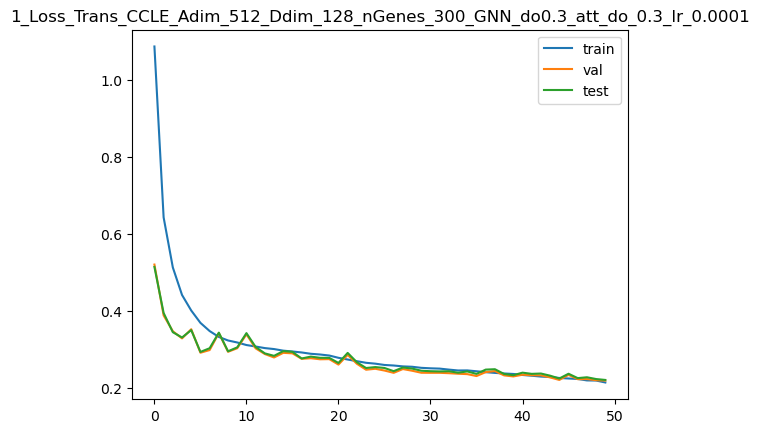

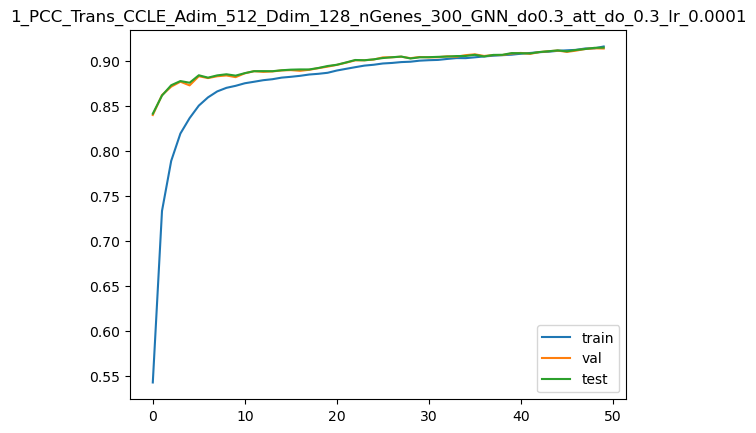

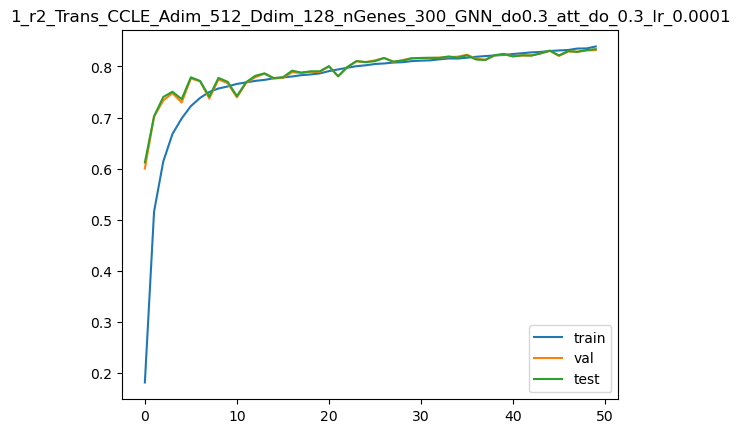

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1627703756093979
The overall Pearson's correlation is 0.9477.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2007591724395752
The overall Pearson's correlation is 0.9386.
Train avg_loss:  0.212535
Train avg_pcc:  0.9165607055176975
Train r2:  0.8400768326352399


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22062051
Validation avg_pcc:  0.9151645864052846
Validation r2:  0.8305763626545695


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2232519
Test avg_pcc:  0.9158995094207183
Test r2:  0.8316677579088632
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1939733475446701
The overall Pearson's correlation is 0.9420.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1945514678955078
The overall Pearson's correlation is 0.9207.
Train avg_loss:  0.20922218
Train avg_pcc:  0.9179205996678121
Train r2:  0.8425695653026721


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21564852
Validation avg_pcc:  0.9155800629717281
Validation r2:  0.8343945556176237
Best Val r2  0.8343945556176237


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21755968
Test avg_pcc:  0.9165502790046626
Test r2:  0.8359596898515738
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18269562721252441
The overall Pearson's correlation is 0.9253.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2079334855079651
The overall Pearson's correlation is 0.9278.
Train avg_loss:  0.20776738
Train avg_pcc:  0.9185162643998976
Train r2:  0.8436642511527894


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21216138
Validation avg_pcc:  0.9160171298761816
Validation r2:  0.8370724758250386
Best Val r2  0.8370724758250386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21348876
Test avg_pcc:  0.9171651378957013
Test r2:  0.8390291763197568
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2255789339542389
The overall Pearson's correlation is 0.9460.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21401840448379517
The overall Pearson's correlation is 0.9255.
Train avg_loss:  0.20578581
Train avg_pcc:  0.9193281349286958
Train r2:  0.8451552998857745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20845896
Validation avg_pcc:  0.9166211877431688
Validation r2:  0.8399157258170367
Best Val r2  0.8399157258170367


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20927148
Test avg_pcc:  0.917909319787949
Test r2:  0.8422090189243301
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23565134406089783
The overall Pearson's correlation is 0.8829.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1561390459537506
The overall Pearson's correlation is 0.9500.
Train avg_loss:  0.20322499
Train avg_pcc:  0.9203762700437448
Train r2:  0.84708219573559


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20465952
Validation avg_pcc:  0.9181687897612614
Validation r2:  0.842833484057365
Best Val r2  0.842833484057365


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20728359
Test avg_pcc:  0.9186116217117127
Test r2:  0.8437078840742214
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29253971576690674
The overall Pearson's correlation is 0.8789.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19204653799533844
The overall Pearson's correlation is 0.8839.
Train avg_loss:  0.20140177
Train avg_pcc:  0.9211204802002134
Train r2:  0.8484540865046429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20856817
Validation avg_pcc:  0.9186698905466856
Validation r2:  0.8398318508637478


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21149547
Test avg_pcc:  0.9191145654188618
Test r2:  0.8405321101816281
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24483473598957062
The overall Pearson's correlation is 0.8932.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10455940663814545
The overall Pearson's correlation is 0.9421.
Train avg_loss:  0.19984132
Train avg_pcc:  0.9217567879856731
Train r2:  0.8496282459557244


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20701592
Validation avg_pcc:  0.9178615296782052
Validation r2:  0.8410238898655836


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2089758
Test avg_pcc:  0.9186803883145561
Test r2:  0.8424319633279598
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17547695338726044
The overall Pearson's correlation is 0.9297.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20396777987480164
The overall Pearson's correlation is 0.9335.
Train avg_loss:  0.1979104
Train avg_pcc:  0.9225462091967034
Train r2:  0.8510811706107796


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19915064
Validation avg_pcc:  0.9204811854858211
Validation r2:  0.84706397620786
Best Val r2  0.84706397620786


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20147897
Test avg_pcc:  0.9210398577973542
Test r2:  0.8480845813476195
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.339221715927124
The overall Pearson's correlation is 0.9184.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2279164046049118
The overall Pearson's correlation is 0.9009.
Train avg_loss:  0.19434118
Train avg_pcc:  0.9239980780378094
Train r2:  0.8537668575566779


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20322463
Validation avg_pcc:  0.9202535012632993
Validation r2:  0.8439353810925124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2067491
Test avg_pcc:  0.9204254822238875
Test r2:  0.8441108932127771
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11877289414405823
The overall Pearson's correlation is 0.9582.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17237694561481476
The overall Pearson's correlation is 0.8924.
Train avg_loss:  0.19369195
Train avg_pcc:  0.9242631071561218
Train r2:  0.8542553737427123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19925737
Validation avg_pcc:  0.9209376191055513
Validation r2:  0.8469820084686296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20274635
Test avg_pcc:  0.9210951539322876
Test r2:  0.8471289541851764
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1892366111278534
The overall Pearson's correlation is 0.8808.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1571751981973648
The overall Pearson's correlation is 0.9406.
Train avg_loss:  0.19248237
Train avg_pcc:  0.9247563720146761
Train r2:  0.855165533205778


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19863425
Validation avg_pcc:  0.9215345602140165
Validation r2:  0.8474605321303116
Best Val r2  0.8474605321303116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20304476
Test avg_pcc:  0.9213457403375288
Test r2:  0.8469039635972136
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16348552703857422
The overall Pearson's correlation is 0.9506.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11928176134824753
The overall Pearson's correlation is 0.9545.
Train avg_loss:  0.19127573
Train avg_pcc:  0.9252469809268682
Train r2:  0.856073475799275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19809286
Validation avg_pcc:  0.9215740730468823
Validation r2:  0.847876280376775
Best Val r2  0.847876280376775


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20106174
Test avg_pcc:  0.92193819022744
Test r2:  0.8483991649735426
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18204528093338013
The overall Pearson's correlation is 0.9375.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22351185977458954
The overall Pearson's correlation is 0.9286.
Train avg_loss:  0.18950231
Train avg_pcc:  0.9259673837632673
Train r2:  0.8574078882247247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19776882
Validation avg_pcc:  0.9215918997115217
Validation r2:  0.8481251181210744
Best Val r2  0.8481251181210744


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20108637
Test avg_pcc:  0.9218083119740983
Test r2:  0.8483805901235394
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19211167097091675
The overall Pearson's correlation is 0.9283.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18690955638885498
The overall Pearson's correlation is 0.9141.
Train avg_loss:  0.18785948
Train avg_pcc:  0.9266346227894985
Train r2:  0.8586440499802762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19425339
Validation avg_pcc:  0.9224203029749395
Validation r2:  0.850824775558306
Best Val r2  0.850824775558306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19622555
Test avg_pcc:  0.9230739984718761
Test r2:  0.8520456645152683
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2181152105331421
The overall Pearson's correlation is 0.9101.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23227828741073608
The overall Pearson's correlation is 0.8983.
Train avg_loss:  0.18666932
Train avg_pcc:  0.9271171484837388
Train r2:  0.8595396068318573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19479512
Validation avg_pcc:  0.9222739749996561
Validation r2:  0.850408759037395


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19855742
Test avg_pcc:  0.9222364884415203
Test r2:  0.8502874427873108
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17512798309326172
The overall Pearson's correlation is 0.9353.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12102306634187698
The overall Pearson's correlation is 0.9493.
Train avg_loss:  0.18424204
Train avg_pcc:  0.9281017832894785
Train r2:  0.8613660041264113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19797565
Validation avg_pcc:  0.9224362762798419
Validation r2:  0.8479662967715246


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20147519
Test avg_pcc:  0.9225642900754027
Test r2:  0.8480874227897146
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2144845426082611
The overall Pearson's correlation is 0.9343.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2870244085788727
The overall Pearson's correlation is 0.8756.
Train avg_loss:  0.18405756
Train avg_pcc:  0.9281766851892858
Train r2:  0.8615048321619482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19349122
Validation avg_pcc:  0.9236526556879127
Validation r2:  0.8514100749923842
Best Val r2  0.8514100749923842


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.197427
Test avg_pcc:  0.9236312867791439
Test r2:  0.8511397709944211
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1446111798286438
The overall Pearson's correlation is 0.9339.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1407368928194046
The overall Pearson's correlation is 0.9369.
Train avg_loss:  0.18270457
Train avg_pcc:  0.9287248776223852
Train r2:  0.8625228979452172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1981178
Validation avg_pcc:  0.9221298721151442
Validation r2:  0.8478571272519233


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2009865
Test avg_pcc:  0.9225509018811697
Test r2:  0.8484558893980096
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2537854313850403
The overall Pearson's correlation is 0.8842.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18507754802703857
The overall Pearson's correlation is 0.9070.
Train avg_loss:  0.1816154
Train avg_pcc:  0.9291673552537656
Train r2:  0.8633424496966942


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19135603
Validation avg_pcc:  0.9244270225321934
Validation r2:  0.8530497676539236
Best Val r2  0.8530497676539236


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19505328
Test avg_pcc:  0.924407384958937
Test r2:  0.8529295531414007
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23067975044250488
The overall Pearson's correlation is 0.8974.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18953703343868256
The overall Pearson's correlation is 0.9056.
Train avg_loss:  0.17889321
Train avg_pcc:  0.930266306740642
Train r2:  0.8653907716952756


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19204251
Validation avg_pcc:  0.9235101819772688
Validation r2:  0.85252260451803


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19581501
Test avg_pcc:  0.9234103829256276
Test r2:  0.8523552092871649
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15646477043628693
The overall Pearson's correlation is 0.9177.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20424491167068481
The overall Pearson's correlation is 0.9263.
Train avg_loss:  0.17864445
Train avg_pcc:  0.9303692152310117
Train r2:  0.8655779558745201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19469655
Validation avg_pcc:  0.9238609487415722
Validation r2:  0.8504844483874128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.199487
Test avg_pcc:  0.9233844078087831
Test r2:  0.8495865091978102
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19254237413406372
The overall Pearson's correlation is 0.9392.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15780463814735413
The overall Pearson's correlation is 0.9489.
Train avg_loss:  0.17757435
Train avg_pcc:  0.9307996821398653
Train r2:  0.8663831572510052


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18823157
Validation avg_pcc:  0.9253766589760548
Validation r2:  0.8554491702283965
Best Val r2  0.8554491702283965


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19125585
Test avg_pcc:  0.9255900541890997
Test r2:  0.8557928180862487
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18339842557907104
The overall Pearson's correlation is 0.9402.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16573528945446014
The overall Pearson's correlation is 0.9348.
Train avg_loss:  0.17523652
Train avg_pcc:  0.9317450051256778
Train r2:  0.8681422747928652


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19411565
Validation avg_pcc:  0.9246186929667386
Validation r2:  0.8509305502467449


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19858974
Test avg_pcc:  0.9243647635715181
Test r2:  0.850263061711436
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14255854487419128
The overall Pearson's correlation is 0.9528.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4010632634162903
The overall Pearson's correlation is 0.8357.
Train avg_loss:  0.17505535
Train avg_pcc:  0.9318185255005693
Train r2:  0.8682785901967971


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19074945
Validation avg_pcc:  0.924049221605755
Validation r2:  0.8535155959997214


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1929295
Test avg_pcc:  0.9245920562181356
Test r2:  0.8545308830637923
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1711248904466629
The overall Pearson's correlation is 0.8883.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16830693185329437
The overall Pearson's correlation is 0.9415.
Train avg_loss:  0.1740777
Train avg_pcc:  0.9322121582481023
Train r2:  0.8690142382839756


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19176951
Validation avg_pcc:  0.9261118087595169
Validation r2:  0.8527322383177904


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19762492
Test avg_pcc:  0.9253153883064276
Test r2:  0.8509905380832667
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1308891475200653
The overall Pearson's correlation is 0.9659.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17108827829360962
The overall Pearson's correlation is 0.9322.
Train avg_loss:  0.17200454
Train avg_pcc:  0.9330495206603331
Train r2:  0.8705741984518884


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18686922
Validation avg_pcc:  0.9255257304127339
Validation r2:  0.8564953771463417
Best Val r2  0.8564953771463417


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19179267
Test avg_pcc:  0.9249539890455646
Test r2:  0.8553880544868555
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15787377953529358
The overall Pearson's correlation is 0.9288.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14703711867332458
The overall Pearson's correlation is 0.9246.
Train avg_loss:  0.17137621
Train avg_pcc:  0.9333031381631165
Train r2:  0.8710469839462233


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19382942
Validation avg_pcc:  0.9247212283130004
Validation r2:  0.8511503526303943


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19888386
Test avg_pcc:  0.9243367544999117
Test r2:  0.8500412923782802
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10723479837179184
The overall Pearson's correlation is 0.9468.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15839794278144836
The overall Pearson's correlation is 0.9166.
Train avg_loss:  0.17068826
Train avg_pcc:  0.9335801520414821
Train r2:  0.871564631798037


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18686001
Validation avg_pcc:  0.9257532439555924
Validation r2:  0.8565024491641193
Best Val r2  0.8565024491641193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1914824
Test avg_pcc:  0.9253311265870678
Test r2:  0.855621989381373
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09381303936243057
The overall Pearson's correlation is 0.9674.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1984504759311676
The overall Pearson's correlation is 0.9303.
Train avg_loss:  0.169988
Train avg_pcc:  0.933861386176147
Train r2:  0.8720915581030488


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18627042
Validation avg_pcc:  0.9265229311555212
Validation r2:  0.8569552149446287
Best Val r2  0.8569552149446287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1905115
Test avg_pcc:  0.9262500166333336
Test r2:  0.8563540643277967
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1843251734972
The overall Pearson's correlation is 0.9332.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14728271961212158
The overall Pearson's correlation is 0.9566.
Train avg_loss:  0.16814084
Train avg_pcc:  0.934605143006778
Train r2:  0.8734814790149152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1859101
Validation avg_pcc:  0.9266312720456825
Validation r2:  0.857231913489635
Best Val r2  0.857231913489635


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18945608
Test avg_pcc:  0.9266347711348368
Test r2:  0.8571498534610711
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29036852717399597
The overall Pearson's correlation is 0.9161.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14596721529960632
The overall Pearson's correlation is 0.9515.
Train avg_loss:  0.16758703
Train avg_pcc:  0.9348282796945956
Train r2:  0.8738981859421935


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18367836
Validation avg_pcc:  0.9268920593538408
Validation r2:  0.8589457715273356
Best Val r2  0.8589457715273356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18920171
Test avg_pcc:  0.9259797949412131
Test r2:  0.8573416313860788
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16195902228355408
The overall Pearson's correlation is 0.9179.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15471524000167847
The overall Pearson's correlation is 0.9436.
Train avg_loss:  0.16647728
Train avg_pcc:  0.9352744549399539
Train r2:  0.8747332191026468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18796821
Validation avg_pcc:  0.9264763130686529
Validation r2:  0.8556514140783371


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19341333
Test avg_pcc:  0.9258666319100428
Test r2:  0.8541660717171597
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22030331194400787
The overall Pearson's correlation is 0.9265.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.34222495555877686
The overall Pearson's correlation is 0.8919.
Train avg_loss:  0.16513221
Train avg_pcc:  0.935815552882762
Train r2:  0.8757453263768096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1864319
Validation avg_pcc:  0.9284224117616955
Validation r2:  0.8568312220328121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19151123
Test avg_pcc:  0.9279115588503715
Test r2:  0.8556002741623017
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14921864867210388
The overall Pearson's correlation is 0.9261.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11530037224292755
The overall Pearson's correlation is 0.9667.
Train avg_loss:  0.16406946
Train avg_pcc:  0.9362427350230423
Train r2:  0.8765449863195076


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1892805
Validation avg_pcc:  0.9271195546523705
Validation r2:  0.8546436648841622


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19509377
Test avg_pcc:  0.9263921050739488
Test r2:  0.8528990182605188
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13212648034095764
The overall Pearson's correlation is 0.9526.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1808786541223526
The overall Pearson's correlation is 0.9094.
Train avg_loss:  0.16296352
Train avg_pcc:  0.9366872686207076
Train r2:  0.8773771606446761


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18171488
Validation avg_pcc:  0.9276418064268902
Validation r2:  0.8604536097285569
Best Val r2  0.8604536097285569


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1861032
Test avg_pcc:  0.9272601341417513
Test r2:  0.8596779279531664
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19153642654418945
The overall Pearson's correlation is 0.9388.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15698295831680298
The overall Pearson's correlation is 0.9376.
Train avg_loss:  0.16204517
Train avg_pcc:  0.9370566487219412
Train r2:  0.8780681932661222


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18379445
Validation avg_pcc:  0.9271383415645873
Validation r2:  0.8588566212822505


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1893365
Test avg_pcc:  0.9263616263490491
Test r2:  0.8572400139635009
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1181054338812828
The overall Pearson's correlation is 0.9420.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11178595572710037
The overall Pearson's correlation is 0.9623.
Train avg_loss:  0.16118926
Train avg_pcc:  0.9373990694241527
Train r2:  0.8787122244612234


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18385862
Validation avg_pcc:  0.9284829019862474
Validation r2:  0.8588073547329106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18894394
Test avg_pcc:  0.9279925624658915
Test r2:  0.8575360022929175
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12622547149658203
The overall Pearson's correlation is 0.9592.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18679547309875488
The overall Pearson's correlation is 0.9401.
Train avg_loss:  0.1606034
Train avg_pcc:  0.9376347477475606
Train r2:  0.8791530458280563


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18269882
Validation avg_pcc:  0.9273490691843342
Validation r2:  0.8596980214678543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18509448
Test avg_pcc:  0.9277428166170771
Test r2:  0.8604385116921698
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11170917749404907
The overall Pearson's correlation is 0.9562.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1354466676712036
The overall Pearson's correlation is 0.9517.
Train avg_loss:  0.16016978
Train avg_pcc:  0.9378087680443147
Train r2:  0.8794793284191856


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18219098
Validation avg_pcc:  0.9285681450886494
Validation r2:  0.8600879964207016


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18617462
Test avg_pcc:  0.9284133715813054
Test r2:  0.8596240823292292
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15193751454353333
The overall Pearson's correlation is 0.9384.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23808109760284424
The overall Pearson's correlation is 0.8996.
Train avg_loss:  0.15662058
Train avg_pcc:  0.9392310139479259
Train r2:  0.8821499439203262


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17767718
Validation avg_pcc:  0.9293366310235017
Validation r2:  0.8635543228868483
Best Val r2  0.8635543228868483


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18253106
Test avg_pcc:  0.9287363799952115
Test r2:  0.8623713201030226
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17221590876579285
The overall Pearson's correlation is 0.9294.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1608124077320099
The overall Pearson's correlation is 0.9387.
Train avg_loss:  0.15749262
Train avg_pcc:  0.9388824352927095
Train r2:  0.881493773263404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18301071
Validation avg_pcc:  0.9286819474305674
Validation r2:  0.8594584825089473


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18717624
Test avg_pcc:  0.9283658272917085
Test r2:  0.8588688479018363
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12358437478542328
The overall Pearson's correlation is 0.9316.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1323341727256775
The overall Pearson's correlation is 0.9377.
Train avg_loss:  0.1568091
Train avg_pcc:  0.9391565253942574
Train r2:  0.8820080817065058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17950922
Validation avg_pcc:  0.9287642289480488
Validation r2:  0.8621474325078291


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18473142
Test avg_pcc:  0.9280607221161828
Test r2:  0.8607122392897038
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1790837049484253
The overall Pearson's correlation is 0.9330.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14064612984657288
The overall Pearson's correlation is 0.9479.
Train avg_loss:  0.1562453
Train avg_pcc:  0.9393814800261797
Train r2:  0.8824323265691936


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18075283
Validation avg_pcc:  0.928732551010915
Validation r2:  0.8611924097647472


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18444347
Test avg_pcc:  0.9286111332542698
Test r2:  0.8609293560911127
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13062715530395508
The overall Pearson's correlation is 0.9577.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14313313364982605
The overall Pearson's correlation is 0.9059.
Train avg_loss:  0.15472943
Train avg_pcc:  0.9399886581492196
Train r2:  0.8835729476524183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18107715
Validation avg_pcc:  0.9293632306305166
Validation r2:  0.8609433440114387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18581513
Test avg_pcc:  0.9288864251479761
Test r2:  0.8598951339569518
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18726840615272522
The overall Pearson's correlation is 0.9361.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11573758721351624
The overall Pearson's correlation is 0.9651.
Train avg_loss:  0.15400119
Train avg_pcc:  0.9402789925631871
Train r2:  0.8841209183309943


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18739668
Validation avg_pcc:  0.9285592750963161
Validation r2:  0.8560903280280809


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19329306
Test avg_pcc:  0.9279278054498317
Test r2:  0.8542567603865863
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11715847253799438
The overall Pearson's correlation is 0.9559.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15887781977653503
The overall Pearson's correlation is 0.9310.
Train avg_loss:  0.1523809
Train avg_pcc:  0.9409285981245126
Train r2:  0.8853401072704952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18153115
Validation avg_pcc:  0.9278329180928068
Validation r2:  0.8605947161249171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18410514
Test avg_pcc:  0.9281756230648357
Test r2:  0.861184467153275
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16199566423892975
The overall Pearson's correlation is 0.9313.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23930905759334564
The overall Pearson's correlation is 0.9318.
Train avg_loss:  0.15277365
Train avg_pcc:  0.9407705743129778
Train r2:  0.8850446028071078


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17965911
Validation avg_pcc:  0.9291441571730066
Validation r2:  0.8620323247900084


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18372834
Test avg_pcc:  0.9289171658365089
Test r2:  0.8614685690669868
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2041386365890503
The overall Pearson's correlation is 0.9158.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1930793821811676
The overall Pearson's correlation is 0.9083.
Train avg_loss:  0.15133439
Train avg_pcc:  0.9413463772547944
Train r2:  0.8861275624383437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17682096
Validation avg_pcc:  0.9297959669246865
Validation r2:  0.8642118523041815
Best Val r2  0.8642118523041815


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18084092
Test avg_pcc:  0.929537645937701
Test r2:  0.8636456940707123
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11126679182052612
The overall Pearson's correlation is 0.9704.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12326706200838089
The overall Pearson's correlation is 0.9536.
Train avg_loss:  0.14969075
Train avg_pcc:  0.9420032992690202
Train r2:  0.8873643369719093


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18140739
Validation avg_pcc:  0.9302930119019188
Validation r2:  0.860689745785064


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18658055
Test avg_pcc:  0.9297546007455008
Test r2:  0.8593179984816528
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1378185749053955
The overall Pearson's correlation is 0.9439.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1594073623418808
The overall Pearson's correlation is 0.9039.
Train avg_loss:  0.14928529
Train avg_pcc:  0.9421649656701312
Train r2:  0.887669426330819


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17853253
Validation avg_pcc:  0.9298892763222146
Validation r2:  0.8628974751235339


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18362503
Test avg_pcc:  0.9292692625125467
Test r2:  0.8615464691763138


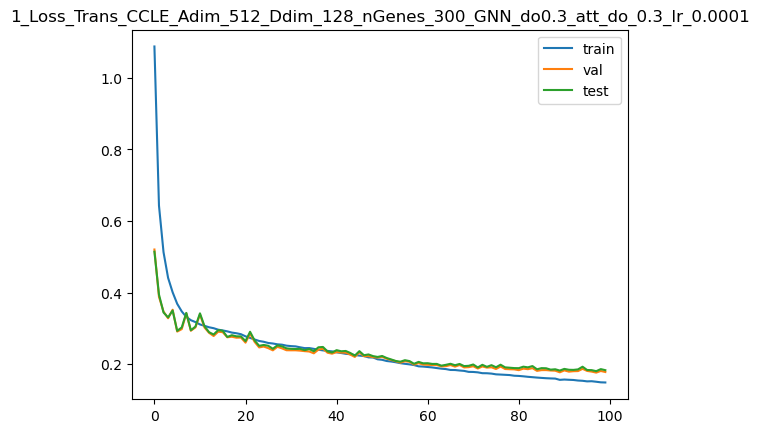

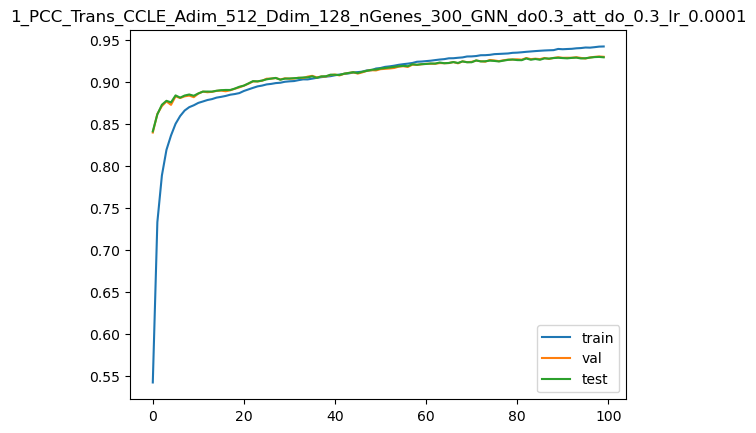

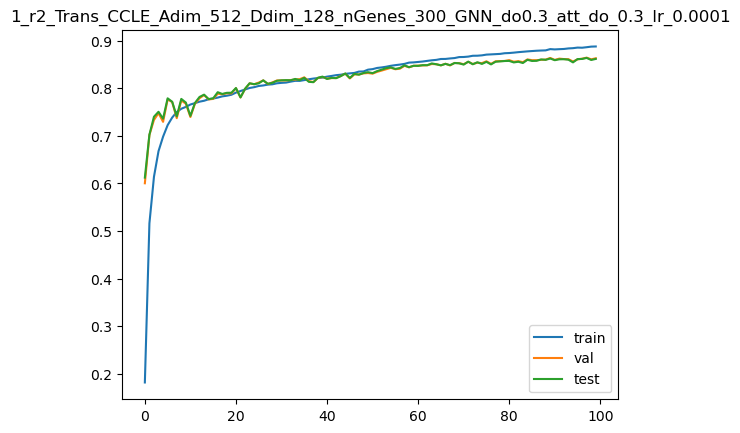

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13464374840259552
The overall Pearson's correlation is 0.9529.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18089963495731354
The overall Pearson's correlation is 0.8873.
Train avg_loss:  0.14869903
Train avg_pcc:  0.942399535352971
Train r2:  0.8881105699866526


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17764227
Validation avg_pcc:  0.9297333180150861
Validation r2:  0.8635811453290897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18118924
Test avg_pcc:  0.9296856889508259
Test r2:  0.8633830560429483
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17188790440559387
The overall Pearson's correlation is 0.9419.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16707316040992737
The overall Pearson's correlation is 0.9228.
Train avg_loss:  0.14793938
Train avg_pcc:  0.9427024331523853
Train r2:  0.8886821618871927


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17526942
Validation avg_pcc:  0.9305041645305085
Validation r2:  0.8654033362196676
Best Val r2  0.8654033362196676


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18008465
Test avg_pcc:  0.9297976280126738
Test r2:  0.864215931230488
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15315988659858704
The overall Pearson's correlation is 0.9507.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17871308326721191
The overall Pearson's correlation is 0.9410.
Train avg_loss:  0.14700218
Train avg_pcc:  0.9430759855559616
Train r2:  0.8893873720781021


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17852409
Validation avg_pcc:  0.9306271809652173
Validation r2:  0.8629039535124944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18417712
Test avg_pcc:  0.9298332491193166
Test r2:  0.8611301888075413
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1641373187303543
The overall Pearson's correlation is 0.9479.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21263976395130157
The overall Pearson's correlation is 0.8872.
Train avg_loss:  0.14707868
Train avg_pcc:  0.9430461209852062
Train r2:  0.8893298102370053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17597693
Validation avg_pcc:  0.9302842454143538
Validation r2:  0.8648600230713854


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17955951
Test avg_pcc:  0.9301308569050134
Test r2:  0.8646118769634843
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1204589307308197
The overall Pearson's correlation is 0.9579.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10164814442396164
The overall Pearson's correlation is 0.9567.
Train avg_loss:  0.14560165
Train avg_pcc:  0.9436344439093903
Train r2:  0.89044119809794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17974462
Validation avg_pcc:  0.9296216750608906
Validation r2:  0.8619666524877404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18125387
Test avg_pcc:  0.9302269506148244
Test r2:  0.8633343301996029
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13389432430267334
The overall Pearson's correlation is 0.9274.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11820289492607117
The overall Pearson's correlation is 0.9589.
Train avg_loss:  0.1446128
Train avg_pcc:  0.9440288217243019
Train r2:  0.8911852709989101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17631641
Validation avg_pcc:  0.9306575976399055
Validation r2:  0.8645993244188681


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18060955
Test avg_pcc:  0.9302345158366896
Test r2:  0.8638201434159426
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12523211538791656
The overall Pearson's correlation is 0.9284.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17292341589927673
The overall Pearson's correlation is 0.9413.
Train avg_loss:  0.14345253
Train avg_pcc:  0.9444909340259369
Train r2:  0.8920583271523359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1808597
Validation avg_pcc:  0.9297708034354866
Validation r2:  0.8611103307877649


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18408833
Test avg_pcc:  0.9298657242215904
Test r2:  0.8611971327620168
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1082673892378807
The overall Pearson's correlation is 0.9591.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15701986849308014
The overall Pearson's correlation is 0.9228.
Train avg_loss:  0.1424247
Train avg_pcc:  0.9449001635963656
Train r2:  0.8928317155546222


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1735647
Validation avg_pcc:  0.9312605220935826
Validation r2:  0.8667124807427795
Best Val r2  0.8667124807427795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17708181
Test avg_pcc:  0.9311107300362438
Test r2:  0.8664800728535557
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14658638834953308
The overall Pearson's correlation is 0.9467.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1430109441280365
The overall Pearson's correlation is 0.9180.
Train avg_loss:  0.14347678
Train avg_pcc:  0.9444822485144064
Train r2:  0.8920400729380804


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17552431
Validation avg_pcc:  0.9305060409334001
Validation r2:  0.8652075965379984


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17774886
Test avg_pcc:  0.9308894297318576
Test r2:  0.8659771139817329
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07976041734218597
The overall Pearson's correlation is 0.9663.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15198028087615967
The overall Pearson's correlation is 0.9469.
Train avg_loss:  0.14218614
Train avg_pcc:  0.9449954142065234
Train r2:  0.8930112351236972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17814058
Validation avg_pcc:  0.93071424374538
Validation r2:  0.8631984611411841


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18114102
Test avg_pcc:  0.9308103782909481
Test r2:  0.8634194202604
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16458842158317566
The overall Pearson's correlation is 0.9432.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11849098652601242
The overall Pearson's correlation is 0.9375.
Train avg_loss:  0.14067826
Train avg_pcc:  0.9455949995740552
Train r2:  0.894145848757584


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17432112
Validation avg_pcc:  0.9307496219418914
Validation r2:  0.8661315781830159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17697279
Test avg_pcc:  0.9309788800826496
Test r2:  0.8665622705532628
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1267576366662979
The overall Pearson's correlation is 0.9547.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12623032927513123
The overall Pearson's correlation is 0.9590.
Train avg_loss:  0.14031406
Train avg_pcc:  0.9457402813694313
Train r2:  0.8944198742856793


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17290314
Validation avg_pcc:  0.9318092931244182
Validation r2:  0.8672205117834986
Best Val r2  0.8672205117834986


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1772207
Test avg_pcc:  0.9312522608568112
Test r2:  0.8663753414634796
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12690024077892303
The overall Pearson's correlation is 0.9432.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14546118676662445
The overall Pearson's correlation is 0.9412.
Train avg_loss:  0.13951096
Train avg_pcc:  0.946059280982094
Train r2:  0.8950241828150074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17714086
Validation avg_pcc:  0.9311376918777289
Validation r2:  0.8639661829456342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17919928
Test avg_pcc:  0.9317136467473304
Test r2:  0.8648834897527562
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13265718519687653
The overall Pearson's correlation is 0.9557.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15903444588184357
The overall Pearson's correlation is 0.9688.
Train avg_loss:  0.13846175
Train avg_pcc:  0.9464775045121016
Train r2:  0.8958136523153528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17939846
Validation avg_pcc:  0.9300696159126427
Validation r2:  0.8622324941355745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18114452
Test avg_pcc:  0.9307331090827735
Test r2:  0.8634167767764412
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2071630209684372
The overall Pearson's correlation is 0.9156.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1412438452243805
The overall Pearson's correlation is 0.9415.
Train avg_loss:  0.13893655
Train avg_pcc:  0.9462887924208625
Train r2:  0.8954564018205988


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17452882
Validation avg_pcc:  0.9314600591976898
Validation r2:  0.8659720855169419


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17818162
Test avg_pcc:  0.9312610955139862
Test r2:  0.8656508114486628
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11614952236413956
The overall Pearson's correlation is 0.9486.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09397764503955841
The overall Pearson's correlation is 0.9608.
Train avg_loss:  0.13775313
Train avg_pcc:  0.9467584724312194
Train r2:  0.8963468678504354


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17370443
Validation avg_pcc:  0.9316581235737428
Validation r2:  0.866605158045429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.177534
Test avg_pcc:  0.9314553463987256
Test r2:  0.8661391206537707
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11315391957759857
The overall Pearson's correlation is 0.9574.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11083600670099258
The overall Pearson's correlation is 0.9625.
Train avg_loss:  0.13775137
Train avg_pcc:  0.9467596908729085
Train r2:  0.8963481993475749


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17299353
Validation avg_pcc:  0.9317827873275658
Validation r2:  0.8671511014591394


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17585003
Test avg_pcc:  0.931820783364727
Test r2:  0.867408825247453
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.135127991437912
The overall Pearson's correlation is 0.9585.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12954872846603394
The overall Pearson's correlation is 0.9406.
Train avg_loss:  0.13663049
Train avg_pcc:  0.9472042123431108
Train r2:  0.8971915920817595


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17441367
Validation avg_pcc:  0.9319719436690123
Validation r2:  0.8660605058128192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1761259
Test avg_pcc:  0.9325883220155848
Test r2:  0.8672008225156543
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18476735055446625
The overall Pearson's correlation is 0.9182.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12976086139678955
The overall Pearson's correlation is 0.9110.
Train avg_loss:  0.13575733
Train avg_pcc:  0.9475517784560396
Train r2:  0.8978486227336456


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17403449
Validation avg_pcc:  0.9312955242041671
Validation r2:  0.8663516899502521


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17833185
Test avg_pcc:  0.9307611974039351
Test r2:  0.8655375372143799
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16666893661022186
The overall Pearson's correlation is 0.9521.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13792790472507477
The overall Pearson's correlation is 0.9492.
Train avg_loss:  0.13567467
Train avg_pcc:  0.9475837295367551
Train r2:  0.8979108207103084


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17577758
Validation avg_pcc:  0.9306687248047242
Validation r2:  0.8650131012145389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17693752
Test avg_pcc:  0.9314664586116014
Test r2:  0.8665888639895315
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14955611526966095
The overall Pearson's correlation is 0.9236.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11189506947994232
The overall Pearson's correlation is 0.9648.
Train avg_loss:  0.13569824
Train avg_pcc:  0.9475751447540199
Train r2:  0.8978930714513675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17163494
Validation avg_pcc:  0.9320584676716078
Validation r2:  0.8681944046500097
Best Val r2  0.8681944046500097


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17353468
Test avg_pcc:  0.9325275385625628
Test r2:  0.869154613125828
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17504200339317322
The overall Pearson's correlation is 0.9366.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1717613935470581
The overall Pearson's correlation is 0.9467.
Train avg_loss:  0.13404025
Train avg_pcc:  0.9482334004710493
Train r2:  0.899140649097145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17584325
Validation avg_pcc:  0.9316062288847563
Validation r2:  0.864962684615882


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17837279
Test avg_pcc:  0.9317564667849947
Test r2:  0.8655066747956792
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.122908815741539
The overall Pearson's correlation is 0.9567.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17492511868476868
The overall Pearson's correlation is 0.9421.
Train avg_loss:  0.13380937
Train avg_pcc:  0.948324419303801
Train r2:  0.8993143709438718


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17092212
Validation avg_pcc:  0.9324230958601866
Validation r2:  0.8687418193029902
Best Val r2  0.8687418193029902


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17399497
Test avg_pcc:  0.9324494334857003
Test r2:  0.8688075514916659
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1383362114429474
The overall Pearson's correlation is 0.9429.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07382163405418396
The overall Pearson's correlation is 0.9564.
Train avg_loss:  0.13289748
Train avg_pcc:  0.9486863407783572
Train r2:  0.9000005247279387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1757593
Validation avg_pcc:  0.932260138080202
Validation r2:  0.8650271528581629


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17981535
Test avg_pcc:  0.9320311866810986
Test r2:  0.8644189761954614
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14645768702030182
The overall Pearson's correlation is 0.9432.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15227192640304565
The overall Pearson's correlation is 0.9464.
Train avg_loss:  0.13261029
Train avg_pcc:  0.9488002787515508
Train r2:  0.9002166304617266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17154093
Validation avg_pcc:  0.932388046220666
Validation r2:  0.8682666045391735


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17474791
Test avg_pcc:  0.9323677626496489
Test r2:  0.8682398243597751
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15378032624721527
The overall Pearson's correlation is 0.9412.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17729178071022034
The overall Pearson's correlation is 0.9172.
Train avg_loss:  0.13195273
Train avg_pcc:  0.9490609865139413
Train r2:  0.9007114094429253


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16859812
Validation avg_pcc:  0.9332455288843894
Validation r2:  0.8705265205526955
Best Val r2  0.8705265205526955


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17185839
Test avg_pcc:  0.9331604993239467
Test r2:  0.8704185393392467
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11591043323278427
The overall Pearson's correlation is 0.9654.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12031718343496323
The overall Pearson's correlation is 0.9659.
Train avg_loss:  0.13125227
Train avg_pcc:  0.9493378701044327
Train r2:  0.9012384813170093


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1808078
Validation avg_pcc:  0.9303685616800694
Validation r2:  0.861150190994457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1816302
Test avg_pcc:  0.9313600220565853
Test r2:  0.8630505703039629
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.146373450756073
The overall Pearson's correlation is 0.9257.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15489615499973297
The overall Pearson's correlation is 0.9385.
Train avg_loss:  0.13110436
Train avg_pcc:  0.9493968390687109
Train r2:  0.9013497710656921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1713634
Validation avg_pcc:  0.9324065972155947
Validation r2:  0.868402943622244


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17366426
Test avg_pcc:  0.9326505625411551
Test r2:  0.869056906613502
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10381364822387695
The overall Pearson's correlation is 0.9566.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15115097165107727
The overall Pearson's correlation is 0.9475.
Train avg_loss:  0.12995781
Train avg_pcc:  0.9498520852946597
Train r2:  0.9022124938772019


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17219561
Validation avg_pcc:  0.9319703064172244
Validation r2:  0.8677638435925275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17543183
Test avg_pcc:  0.9319001826520463
Test r2:  0.8677241520611343
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12704510986804962
The overall Pearson's correlation is 0.9534.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08455691486597061
The overall Pearson's correlation is 0.9625.
Train avg_loss:  0.12961437
Train avg_pcc:  0.9499868205340646
Train r2:  0.9024709212631882


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16962175
Validation avg_pcc:  0.9330314801482974
Validation r2:  0.8697404270043296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17256975
Test avg_pcc:  0.9330909830396249
Test r2:  0.8698821634369703
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10324551165103912
The overall Pearson's correlation is 0.9690.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10777324438095093
The overall Pearson's correlation is 0.9414.
Train avg_loss:  0.12907924
Train avg_pcc:  0.9501991408578676
Train r2:  0.902873577576051


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17473969
Validation avg_pcc:  0.9309437591505145
Validation r2:  0.8658101544576378


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1755064
Test avg_pcc:  0.9318876044847758
Test r2:  0.8676679352793797
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09956224262714386
The overall Pearson's correlation is 0.9674.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1337544023990631
The overall Pearson's correlation is 0.9508.
Train avg_loss:  0.1270819
Train avg_pcc:  0.9509899533797671
Train r2:  0.9043765152794333


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17216812
Validation avg_pcc:  0.9331171508798634
Validation r2:  0.8677849648317153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1743917
Test avg_pcc:  0.9335547225786139
Test r2:  0.8685084123083616
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13539953529834747
The overall Pearson's correlation is 0.9547.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10146704316139221
The overall Pearson's correlation is 0.9552.
Train avg_loss:  0.12864141
Train avg_pcc:  0.9503729944046734
Train r2:  0.9032030399302443


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.170523
Validation avg_pcc:  0.9326105626078951
Validation r2:  0.8690483133104677


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17230187
Test avg_pcc:  0.9331545191719901
Test r2:  0.8700841441365113
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08824791014194489
The overall Pearson's correlation is 0.9655.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10018709301948547
The overall Pearson's correlation is 0.9616.
Train avg_loss:  0.12687328
Train avg_pcc:  0.9510719087850905
Train r2:  0.904533455189755


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1670767
Validation avg_pcc:  0.9338023042022912
Validation r2:  0.8716948643368023
Best Val r2  0.8716948643368023


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16919744
Test avg_pcc:  0.9341723397685567
Test r2:  0.8724249023737936
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15418915450572968
The overall Pearson's correlation is 0.9577.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1439172327518463
The overall Pearson's correlation is 0.9474.
Train avg_loss:  0.12823252
Train avg_pcc:  0.950533737033564
Train r2:  0.9035107117678546


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17017645
Validation avg_pcc:  0.9334096638992626
Validation r2:  0.8693144609403471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17320253
Test avg_pcc:  0.9335108660762431
Test r2:  0.8694050414829689
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08760100603103638
The overall Pearson's correlation is 0.9589.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09161912649869919
The overall Pearson's correlation is 0.9755.
Train avg_loss:  0.12621805
Train avg_pcc:  0.9513318549100582
Train r2:  0.9050265070420158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17233403
Validation avg_pcc:  0.932310387816299
Validation r2:  0.8676575570995247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17356475
Test avg_pcc:  0.9330931754705647
Test r2:  0.8691319288533079
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11262468993663788
The overall Pearson's correlation is 0.9538.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09382441639900208
The overall Pearson's correlation is 0.9530.
Train avg_loss:  0.12531662
Train avg_pcc:  0.9516875389495796
Train r2:  0.9057047853100207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.169243
Validation avg_pcc:  0.9333230941451159
Validation r2:  0.8700312934873299


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1725992
Test avg_pcc:  0.9331799573045548
Test r2:  0.8698599594029358
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14494431018829346
The overall Pearson's correlation is 0.9512.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16156268119812012
The overall Pearson's correlation is 0.9545.
Train avg_loss:  0.12457635
Train avg_pcc:  0.9519802683434944
Train r2:  0.9062618119526795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17218205
Validation avg_pcc:  0.9334380010447417
Validation r2:  0.8677742649307769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17458726
Test avg_pcc:  0.9338008254902175
Test r2:  0.8683609614389467
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0716066062450409
The overall Pearson's correlation is 0.9800.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14908623695373535
The overall Pearson's correlation is 0.9471.
Train avg_loss:  0.12594816
Train avg_pcc:  0.9514382001293966
Train r2:  0.9052295823174229


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16874005
Validation avg_pcc:  0.9331232475541752
Validation r2:  0.8704175299004713


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17003424
Test avg_pcc:  0.9338625614355209
Test r2:  0.8717939378209676
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14252479374408722
The overall Pearson's correlation is 0.9530.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11596018075942993
The overall Pearson's correlation is 0.9667.
Train avg_loss:  0.1242598
Train avg_pcc:  0.9521051082134478
Train r2:  0.9064999929962221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1705034
Validation avg_pcc:  0.9330533664103109
Validation r2:  0.8690633765608442


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1722334
Test avg_pcc:  0.9335927906059515
Test r2:  0.8701357657520832
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13960745930671692
The overall Pearson's correlation is 0.9444.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10750123113393784
The overall Pearson's correlation is 0.9411.
Train avg_loss:  0.1240906
Train avg_pcc:  0.9521721074180678
Train r2:  0.9066273209308275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17244743
Validation avg_pcc:  0.9323366183209835
Validation r2:  0.8675704746350562


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17203349
Test avg_pcc:  0.9338203864141197
Test r2:  0.8702865038222012
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10250826179981232
The overall Pearson's correlation is 0.9434.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20569586753845215
The overall Pearson's correlation is 0.9153.
Train avg_loss:  0.12341118
Train avg_pcc:  0.952441291571301
Train r2:  0.9071385543227344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17333822
Validation avg_pcc:  0.9319321534682663
Validation r2:  0.8668863884776328


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17346846
Test avg_pcc:  0.9330975097321685
Test r2:  0.8692045332436888
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12284921109676361
The overall Pearson's correlation is 0.9524.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13006258010864258
The overall Pearson's correlation is 0.9673.
Train avg_loss:  0.12330539
Train avg_pcc:  0.952482528743306
Train r2:  0.9072181589737173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16637293
Validation avg_pcc:  0.9340495468235035
Validation r2:  0.8722353430107107
Best Val r2  0.8722353430107107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16874751
Test avg_pcc:  0.9343389706629239
Test r2:  0.8727641416631278
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.192264586687088
The overall Pearson's correlation is 0.9185.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14261749386787415
The overall Pearson's correlation is 0.9577.
Train avg_loss:  0.122490115
Train avg_pcc:  0.9528042513489259
Train r2:  0.9078316142816828


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16919157
Validation avg_pcc:  0.9337011469584982
Validation r2:  0.8700707895598047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17112526
Test avg_pcc:  0.9341372146213168
Test r2:  0.8709713103808608
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1231260597705841
The overall Pearson's correlation is 0.9518.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14232785999774933
The overall Pearson's correlation is 0.9337.
Train avg_loss:  0.12221757
Train avg_pcc:  0.9529117801725611
Train r2:  0.9080366858404288


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.172927
Validation avg_pcc:  0.9334278869344698
Validation r2:  0.8672021833234637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17382438
Test avg_pcc:  0.9342680814244284
Test r2:  0.8689361637100448
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10655172169208527
The overall Pearson's correlation is 0.9608.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09744085371494293
The overall Pearson's correlation is 0.9678.
Train avg_loss:  0.12089034
Train avg_pcc:  0.9534358505775831
Train r2:  0.909035368619578


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.168488
Validation avg_pcc:  0.9336484645462974
Validation r2:  0.8706110781918961


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16900034
Test avg_pcc:  0.9346728975119891
Test r2:  0.872573511701577
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10225492715835571
The overall Pearson's correlation is 0.9469.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10280908644199371
The overall Pearson's correlation is 0.9668.
Train avg_loss:  0.120661736
Train avg_pcc:  0.9535266968013513
Train r2:  0.9092073857021247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17008224
Validation avg_pcc:  0.9327514145288629
Validation r2:  0.8693867952688632


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17102762
Test avg_pcc:  0.9336642647189044
Test r2:  0.8710449519258191
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13157394528388977
The overall Pearson's correlation is 0.9418.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10136066377162933
The overall Pearson's correlation is 0.9474.
Train avg_loss:  0.12040975
Train avg_pcc:  0.9536255504064886
Train r2:  0.9093969904026973


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1692653
Validation avg_pcc:  0.9329965681722509
Validation r2:  0.8700141537105273


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17035997
Test avg_pcc:  0.9338094979992034
Test r2:  0.8715483368342599
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15280716121196747
The overall Pearson's correlation is 0.9589.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10750967264175415
The overall Pearson's correlation is 0.9379.
Train avg_loss:  0.12018892
Train avg_pcc:  0.9537124685418836
Train r2:  0.9095631557487933


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16817378
Validation avg_pcc:  0.9340732039681588
Validation r2:  0.8708523825820118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16955748
Test avg_pcc:  0.9346788160346216
Test r2:  0.872153411564064
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13945788145065308
The overall Pearson's correlation is 0.9487.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13250765204429626
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.11992299
Train avg_pcc:  0.9538173036805028
Train r2:  0.9097632635466572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16777067
Validation avg_pcc:  0.9344868672507737
Validation r2:  0.8711619494268681


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16959612
Test avg_pcc:  0.9349125886680092
Test r2:  0.8721242867700476


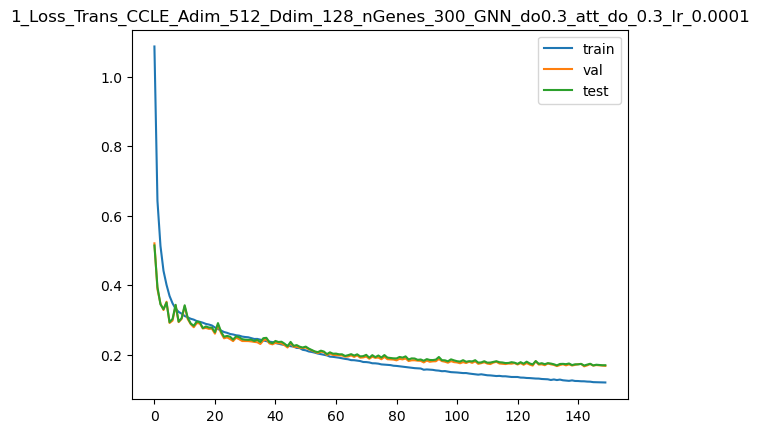

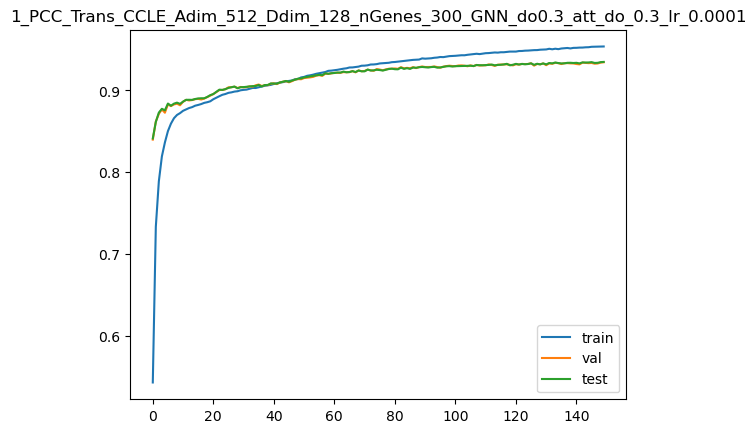

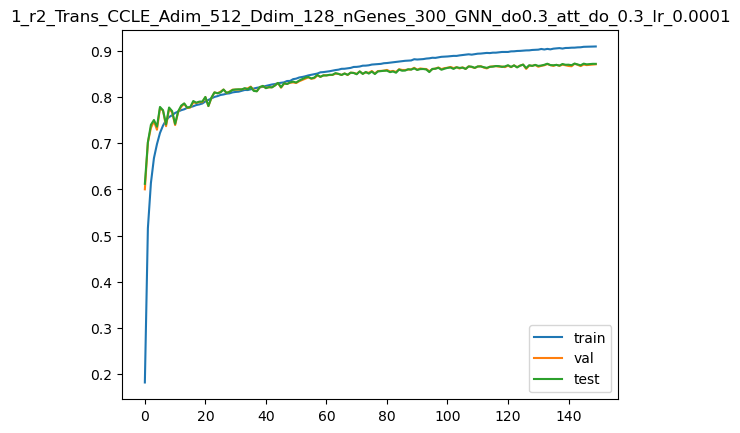

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16874751
Test avg_pcc:  0.934338971156058
Test r2:  0.8727641425359794


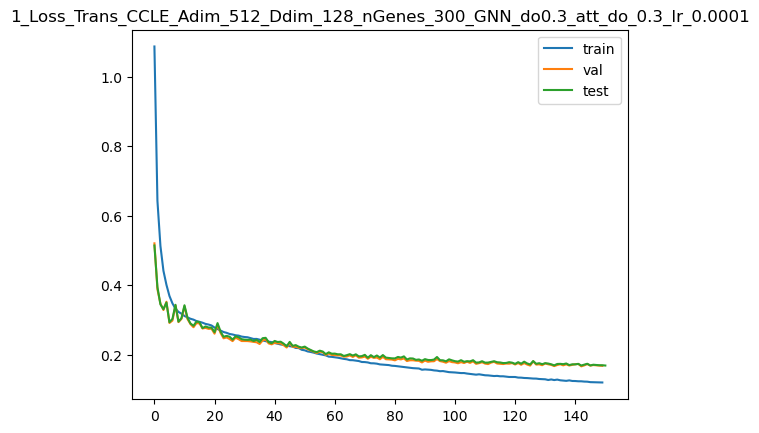

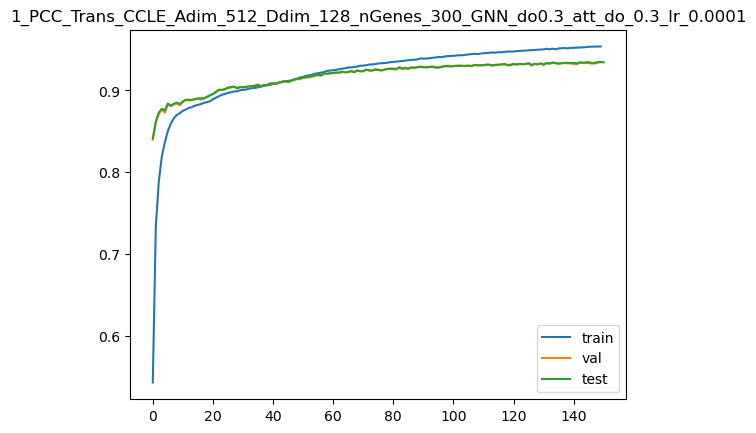

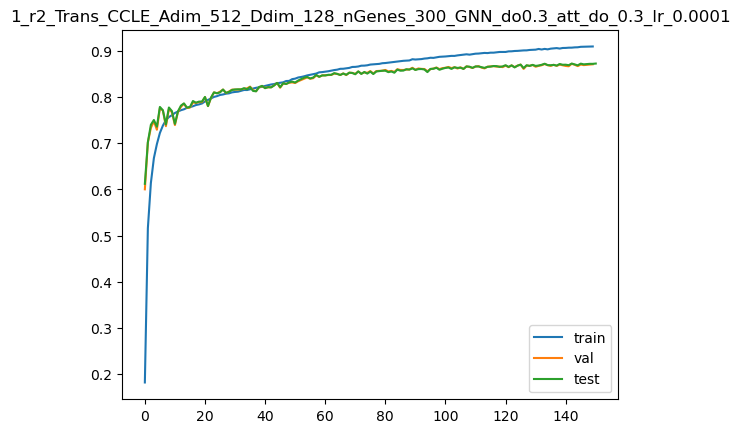

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  1.115875244140625
The overall Pearson's correlation is 0.5503.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.970562219619751
The overall Pearson's correlation is 0.7093.
Train avg_loss:  1.116638
Train avg_pcc:  0.5254179854021684
Train r2:  0.16212849399855034


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.6932829
Validation avg_pcc:  0.8387823115921784
Validation r2:  0.46519666690290806
Best Val r2  0.46519666690290806


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.70306516
Test avg_pcc:  0.8380352268741382
Test r2:  0.4657578358601221
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.6302308440208435
The overall Pearson's correlation is 0.6776.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.786978542804718
The overall Pearson's correlation is 0.7440.
Train avg_loss:  0.64707816
Train avg_pcc:  0.7330522524142498
Train r2:  0.51446356241113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.6351641
Validation avg_pcc:  0.86125031672629
Validation r2:  0.5100299167980569
Best Val r2  0.5100299167980569


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.64708465
Test avg_pcc:  0.8594939067665004
Test r2:  0.5082961205143315
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.5526201725006104
The overall Pearson's correlation is 0.7666.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.39744025468826294
The overall Pearson's correlation is 0.8329.
Train avg_loss:  0.5140026
Train avg_pcc:  0.7892725420854947
Train r2:  0.6143170970925931


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.44979545
Validation avg_pcc:  0.8696816370049877
Validation r2:  0.6530245877298716
Best Val r2  0.6530245877298716


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.45160314
Test avg_pcc:  0.8707098378610046
Test r2:  0.6568377520657598
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4335559606552124
The overall Pearson's correlation is 0.7936.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.30293765664100647
The overall Pearson's correlation is 0.9020.
Train avg_loss:  0.44219628
Train avg_pcc:  0.8195056771088525
Train r2:  0.6681970851711941


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3282667
Validation avg_pcc:  0.8765752088480064
Validation r2:  0.7467727223368125
Best Val r2  0.7467727223368125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33312625
Test avg_pcc:  0.8768595387378063
Test r2:  0.7468654761538527
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3606095612049103
The overall Pearson's correlation is 0.8400.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4109680652618408
The overall Pearson's correlation is 0.8909.
Train avg_loss:  0.3946867
Train avg_pcc:  0.8397267936167441
Train r2:  0.70384601122027


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31249166
Validation avg_pcc:  0.8780561720081134
Validation r2:  0.7589417301976055
Best Val r2  0.7589417301976055


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31817448
Test avg_pcc:  0.8780909104468115
Test r2:  0.7582269728025717
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.37784361839294434
The overall Pearson's correlation is 0.8406.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.29058438539505005
The overall Pearson's correlation is 0.8852.
Train avg_loss:  0.36459306
Train avg_pcc:  0.8525797991900566
Train r2:  0.7264268466607704


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30811864
Validation avg_pcc:  0.8798616248488306
Validation r2:  0.762315109996687
Best Val r2  0.762315109996687


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31390944
Test avg_pcc:  0.8796843613727413
Test r2:  0.7614678659947354
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2714846730232239
The overall Pearson's correlation is 0.8870.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.35619595646858215
The overall Pearson's correlation is 0.8734.
Train avg_loss:  0.34474534
Train avg_pcc:  0.8610984797314927
Train r2:  0.7413196104223689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30677542
Validation avg_pcc:  0.8826748921217359
Validation r2:  0.7633512868695985
Best Val r2  0.7633512868695985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31194487
Test avg_pcc:  0.8826152489933081
Test r2:  0.7629606592774008
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.33615630865097046
The overall Pearson's correlation is 0.8992.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3351609706878662
The overall Pearson's correlation is 0.8630.
Train avg_loss:  0.33027545
Train avg_pcc:  0.8673250780196353
Train r2:  0.7521771398839167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33959734
Validation avg_pcc:  0.8817212936747367
Validation r2:  0.7380322175499907


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3445555
Test avg_pcc:  0.8824536377697393
Test r2:  0.7381806537340401
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22626763582229614
The overall Pearson's correlation is 0.9163.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4075366258621216
The overall Pearson's correlation is 0.8753.
Train avg_loss:  0.32048398
Train avg_pcc:  0.8715306706045786
Train r2:  0.7595241868872883


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30846605
Validation avg_pcc:  0.8827556645527879
Validation r2:  0.762047124526534


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31351662
Test avg_pcc:  0.8829453214092056
Test r2:  0.7617663386343627
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.315817266702652
The overall Pearson's correlation is 0.8647.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.38989198207855225
The overall Pearson's correlation is 0.8523.
Train avg_loss:  0.31583408
Train avg_pcc:  0.8735251712641982
Train r2:  0.7630132543591881


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3101951
Validation avg_pcc:  0.8857376221697023
Validation r2:  0.7607133299571228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31653282
Test avg_pcc:  0.8855278978194651
Test r2:  0.7594743691093644
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3439868092536926
The overall Pearson's correlation is 0.8579.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21280723810195923
The overall Pearson's correlation is 0.9346.
Train avg_loss:  0.3071385
Train avg_pcc:  0.8772485678229921
Train r2:  0.7695379855574463


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30120113
Validation avg_pcc:  0.8840133279961421
Validation r2:  0.7676513156577979
Best Val r2  0.7676513156577979


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30381635
Test avg_pcc:  0.8850260491150365
Test r2:  0.7691373492453879
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2102513313293457
The overall Pearson's correlation is 0.9193.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.28811243176460266
The overall Pearson's correlation is 0.8833.
Train avg_loss:  0.30431598
Train avg_pcc:  0.8784537687823276
Train r2:  0.771655881961666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28540385
Validation avg_pcc:  0.8871741651200015
Validation r2:  0.7798374577210823
Best Val r2  0.7798374577210823


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29036894
Test avg_pcc:  0.8872845591937629
Test r2:  0.7793556973989516
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21982887387275696
The overall Pearson's correlation is 0.9245.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23682567477226257
The overall Pearson's correlation is 0.8935.
Train avg_loss:  0.30025166
Train avg_pcc:  0.8801875401554382
Train r2:  0.7747055424608731


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28870496
Validation avg_pcc:  0.8847982899043969
Validation r2:  0.7772909569037757


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29366544
Test avg_pcc:  0.8847355841601666
Test r2:  0.7768507842240872
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.30820533633232117
The overall Pearson's correlation is 0.9011.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25507038831710815
The overall Pearson's correlation is 0.9040.
Train avg_loss:  0.29768062
Train avg_pcc:  0.8812807063024849
Train r2:  0.7766347431513957


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27754974
Validation avg_pcc:  0.8885167965160607
Validation r2:  0.7858961690475676
Best Val r2  0.7858961690475676


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28272247
Test avg_pcc:  0.8883753292407256
Test r2:  0.7851660534958987
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23375903069972992
The overall Pearson's correlation is 0.9093.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2454552948474884
The overall Pearson's correlation is 0.9088.
Train avg_loss:  0.2947092
Train avg_pcc:  0.8825451898038393
Train r2:  0.7788643468244096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2882012
Validation avg_pcc:  0.8882774188782923
Validation r2:  0.7776795471533453


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29013053
Test avg_pcc:  0.889680982071831
Test r2:  0.7795368714065642
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32207122445106506
The overall Pearson's correlation is 0.8980.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3690599203109741
The overall Pearson's correlation is 0.8361.
Train avg_loss:  0.29082322
Train avg_pcc:  0.8841957872480873
Train r2:  0.7817801946886926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27743474
Validation avg_pcc:  0.8901439991998981
Validation r2:  0.7859849109837292
Best Val r2  0.7859849109837292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28141078
Test avg_pcc:  0.8903162406316261
Test r2:  0.7861628065300914
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20216059684753418
The overall Pearson's correlation is 0.9132.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20166468620300293
The overall Pearson's correlation is 0.8971.
Train avg_loss:  0.28798306
Train avg_pcc:  0.8853972183606408
Train r2:  0.7839113156866212


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27136466
Validation avg_pcc:  0.8916341793411465
Validation r2:  0.7906673842668059
Best Val r2  0.7906673842668059


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27232674
Test avg_pcc:  0.8931100905605165
Test r2:  0.7930655456961465
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.38716623187065125
The overall Pearson's correlation is 0.8469.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20113472640514374
The overall Pearson's correlation is 0.9089.
Train avg_loss:  0.28274843
Train avg_pcc:  0.8876102109636556
Train r2:  0.7878391029482263


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2762354
Validation avg_pcc:  0.8901490474793541
Validation r2:  0.786910039312993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27866536
Test avg_pcc:  0.891286879862863
Test r2:  0.7882489773230714
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27960366010665894
The overall Pearson's correlation is 0.8871.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24290132522583008
The overall Pearson's correlation is 0.9146.
Train avg_loss:  0.27844945
Train avg_pcc:  0.8894296858312882
Train r2:  0.7910648920475375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27733937
Validation avg_pcc:  0.8939318720045212
Validation r2:  0.7860584471839593


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28047773
Test avg_pcc:  0.894855081389829
Test r2:  0.7868718095278567
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.41244083642959595
The overall Pearson's correlation is 0.8656.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20843499898910522
The overall Pearson's correlation is 0.9240.
Train avg_loss:  0.27288952
Train avg_pcc:  0.8917696558192244
Train r2:  0.7952367781239068


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2646879
Validation avg_pcc:  0.8953183760169552
Validation r2:  0.7958178908829494
Best Val r2  0.7958178908829494


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26475784
Test avg_pcc:  0.8972003203883813
Test r2:  0.7988169680833274
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21210570633411407
The overall Pearson's correlation is 0.9305.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25180742144584656
The overall Pearson's correlation is 0.9110.
Train avg_loss:  0.26868176
Train avg_pcc:  0.8935375984387106
Train r2:  0.7983940728643972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26533374
Validation avg_pcc:  0.8987925753264248
Validation r2:  0.79531966406404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26734465
Test avg_pcc:  0.8999264347321676
Test r2:  0.7968513045575097
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.28801262378692627
The overall Pearson's correlation is 0.9128.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3796214461326599
The overall Pearson's correlation is 0.8598.
Train avg_loss:  0.2655468
Train avg_pcc:  0.8948542262704283
Train r2:  0.8007464057684449


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26072878
Validation avg_pcc:  0.8993703338622742
Validation r2:  0.798871958025317
Best Val r2  0.798871958025317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26281166
Test avg_pcc:  0.9005819955201244
Test r2:  0.8002958053811453
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18634584546089172
The overall Pearson's correlation is 0.9052.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.31066250801086426
The overall Pearson's correlation is 0.8441.
Train avg_loss:  0.26316947
Train avg_pcc:  0.8958493973245046
Train r2:  0.8025302527171216


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25368473
Validation avg_pcc:  0.9003089536333666
Validation r2:  0.8043058153836137
Best Val r2  0.8043058153836137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2540621
Test avg_pcc:  0.9019098969358158
Test r2:  0.8069444011602904
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17431271076202393
The overall Pearson's correlation is 0.8908.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20646923780441284
The overall Pearson's correlation is 0.9160.
Train avg_loss:  0.2609605
Train avg_pcc:  0.8967726210179275
Train r2:  0.8041877665732537


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2588275
Validation avg_pcc:  0.9010543335898095
Validation r2:  0.8003386383752171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25960064
Test avg_pcc:  0.9026385472796489
Test r2:  0.8027357848450393
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1698330044746399
The overall Pearson's correlation is 0.9467.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.28520575165748596
The overall Pearson's correlation is 0.8585.
Train avg_loss:  0.25781175
Train avg_pcc:  0.8980894502905336
Train r2:  0.8065504234479931


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24923171
Validation avg_pcc:  0.9005830824748713
Validation r2:  0.8077408956617261
Best Val r2  0.8077408956617261


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24893406
Test avg_pcc:  0.9024487472075533
Test r2:  0.8108410601285333
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22108401358127594
The overall Pearson's correlation is 0.9074.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22886474430561066
The overall Pearson's correlation is 0.8740.
Train avg_loss:  0.25582278
Train avg_pcc:  0.8989210664380974
Train r2:  0.8080428581066196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25278038
Validation avg_pcc:  0.9018449579249195
Validation r2:  0.805003444587416


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25344133
Test avg_pcc:  0.9034461201963502
Test r2:  0.8074160849132899
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2521134316921234
The overall Pearson's correlation is 0.9053.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24705475568771362
The overall Pearson's correlation is 0.9090.
Train avg_loss:  0.25381538
Train avg_pcc:  0.8997568913439074
Train r2:  0.8095490753819671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.254048
Validation avg_pcc:  0.901689193600512
Validation r2:  0.8040255991572722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25563976
Test avg_pcc:  0.9029526137608056
Test r2:  0.8057455558209135
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4340628981590271
The overall Pearson's correlation is 0.8632.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2155701220035553
The overall Pearson's correlation is 0.9089.
Train avg_loss:  0.25304958
Train avg_pcc:  0.9000781355903833
Train r2:  0.8101237375773152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24774522
Validation avg_pcc:  0.8995211182736447
Validation r2:  0.808887599517714
Best Val r2  0.808887599517714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24604428
Test avg_pcc:  0.9018311307214144
Test r2:  0.8130369266446308
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2582889795303345
The overall Pearson's correlation is 0.9031.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20935207605361938
The overall Pearson's correlation is 0.9448.
Train avg_loss:  0.25076565
Train avg_pcc:  0.9010266887029156
Train r2:  0.8118374832491105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24920842
Validation avg_pcc:  0.8999296642050145
Validation r2:  0.8077588654652161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24693596
Test avg_pcc:  0.902506082495407
Test r2:  0.812359355362391
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19036389887332916
The overall Pearson's correlation is 0.9177.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.28536149859428406
The overall Pearson's correlation is 0.9089.
Train avg_loss:  0.24992992
Train avg_pcc:  0.9013782228330247
Train r2:  0.8124645895904781


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24853833
Validation avg_pcc:  0.9020690504859743
Validation r2:  0.8082757791871414


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24762659
Test avg_pcc:  0.9042056623074369
Test r2:  0.8118345712880535
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20461851358413696
The overall Pearson's correlation is 0.9091.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3393418788909912
The overall Pearson's correlation is 0.8117.
Train avg_loss:  0.24900095
Train avg_pcc:  0.9017607792192793
Train r2:  0.8131616174060509


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2407482
Validation avg_pcc:  0.9025929803699994
Validation r2:  0.8142851432150705
Best Val r2  0.8142851432150705


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24035956
Test avg_pcc:  0.9042958221949481
Test r2:  0.8173566184359293
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24937313795089722
The overall Pearson's correlation is 0.9061.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15913604199886322
The overall Pearson's correlation is 0.9330.
Train avg_loss:  0.24751513
Train avg_pcc:  0.9023792027038413
Train r2:  0.8142765196855617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24689254
Validation avg_pcc:  0.9022024694272746
Validation r2:  0.8095453398021122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24755573
Test avg_pcc:  0.9035064314427108
Test r2:  0.8118884228541339
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2450028955936432
The overall Pearson's correlation is 0.9096.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2742737829685211
The overall Pearson's correlation is 0.8737.
Train avg_loss:  0.24458203
Train avg_pcc:  0.9035971666691245
Train r2:  0.8164773457858615


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25612912
Validation avg_pcc:  0.9025753904488568
Validation r2:  0.8024201961799822


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25519446
Test avg_pcc:  0.9048494732482898
Test r2:  0.8060839491955601
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24105128645896912
The overall Pearson's correlation is 0.9310.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19304969906806946
The overall Pearson's correlation is 0.9168.
Train avg_loss:  0.24538614
Train avg_pcc:  0.9032658438949446
Train r2:  0.8158739996768791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23944645
Validation avg_pcc:  0.9030090956794846
Validation r2:  0.8152893098679918
Best Val r2  0.8152893098679918


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23744841
Test avg_pcc:  0.9053691276360532
Test r2:  0.819568717569125
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19679559767246246
The overall Pearson's correlation is 0.8745.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24787305295467377
The overall Pearson's correlation is 0.9019.
Train avg_loss:  0.24335161
Train avg_pcc:  0.9041080623242174
Train r2:  0.8174006203512773


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24204631
Validation avg_pcc:  0.9051507841159891
Validation r2:  0.8132837694772539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24171473
Test avg_pcc:  0.9068973826197999
Test r2:  0.8163268776226689
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18345212936401367
The overall Pearson's correlation is 0.9406.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18706531822681427
The overall Pearson's correlation is 0.8922.
Train avg_loss:  0.24201673
Train avg_pcc:  0.904662357294504
Train r2:  0.8184022293811787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23695888
Validation avg_pcc:  0.9040010699332959
Validation r2:  0.8172082450947384
Best Val r2  0.8172082450947384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23526013
Test avg_pcc:  0.9062242303045026
Test r2:  0.8212315524194624
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21286152303218842
The overall Pearson's correlation is 0.9277.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.28164032101631165
The overall Pearson's correlation is 0.8845.
Train avg_loss:  0.23992118
Train avg_pcc:  0.9055298136306076
Train r2:  0.8199746464132308


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23983715
Validation avg_pcc:  0.9047618591978867
Validation r2:  0.8149879195694287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23859738
Test avg_pcc:  0.9068428130206723
Test r2:  0.818695656938969
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23901712894439697
The overall Pearson's correlation is 0.8800.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3285122513771057
The overall Pearson's correlation is 0.8726.
Train avg_loss:  0.23940444
Train avg_pcc:  0.9057434033051469
Train r2:  0.8203623717847208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2405142
Validation avg_pcc:  0.9043453318088406
Validation r2:  0.8144656427952053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24171409
Test avg_pcc:  0.9054172535149118
Test r2:  0.816327340117238
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18596629798412323
The overall Pearson's correlation is 0.9235.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19047923386096954
The overall Pearson's correlation is 0.9348.
Train avg_loss:  0.2380254
Train avg_pcc:  0.9063159399040198
Train r2:  0.8213971536237596


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23415461
Validation avg_pcc:  0.9058232010139351
Validation r2:  0.8193714690615265
Best Val r2  0.8193714690615265


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23421992
Test avg_pcc:  0.9073687613021855
Test r2:  0.8220219879624052
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2635560929775238
The overall Pearson's correlation is 0.9004.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17985188961029053
The overall Pearson's correlation is 0.9457.
Train avg_loss:  0.23539522
Train avg_pcc:  0.9074021220027741
Train r2:  0.8233707090499862


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23730919
Validation avg_pcc:  0.9057400596844941
Validation r2:  0.8169380046683483


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23638943
Test avg_pcc:  0.9077351564235249
Test r2:  0.8203734281935724
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16865068674087524
The overall Pearson's correlation is 0.9320.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2618391513824463
The overall Pearson's correlation is 0.9194.
Train avg_loss:  0.23492466
Train avg_pcc:  0.9075977852333981
Train r2:  0.8237238053901239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24560967
Validation avg_pcc:  0.9048922086492862
Validation r2:  0.8105349614175522


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24616623
Test avg_pcc:  0.9063688601570479
Test r2:  0.8129442684848358
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1641629934310913
The overall Pearson's correlation is 0.9256.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26274868845939636
The overall Pearson's correlation is 0.9272.
Train avg_loss:  0.23320532
Train avg_pcc:  0.9083079658592952
Train r2:  0.8250139229592492


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23443647
Validation avg_pcc:  0.9067368764995872
Validation r2:  0.8191540498961578


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23608384
Test avg_pcc:  0.9078171136987343
Test r2:  0.8206056298979592
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19325289130210876
The overall Pearson's correlation is 0.9184.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2824772000312805
The overall Pearson's correlation is 0.8258.
Train avg_loss:  0.23127437
Train avg_pcc:  0.9091053720230884
Train r2:  0.8264628072846728


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2297185
Validation avg_pcc:  0.9071519322288488
Validation r2:  0.822793529220554
Best Val r2  0.822793529220554


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22683936
Test avg_pcc:  0.9098276923459436
Test r2:  0.8276302702525091
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24491816759109497
The overall Pearson's correlation is 0.8870.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17531219124794006
The overall Pearson's correlation is 0.9339.
Train avg_loss:  0.22938578
Train avg_pcc:  0.9098845146655745
Train r2:  0.8278798957633307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23136455
Validation avg_pcc:  0.9069992012720234
Validation r2:  0.8215237483247775


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22961426
Test avg_pcc:  0.909122098837766
Test r2:  0.8255216973086856
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.36259976029396057
The overall Pearson's correlation is 0.8853.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22109928727149963
The overall Pearson's correlation is 0.9374.
Train avg_loss:  0.22649164
Train avg_pcc:  0.9110761512584984
Train r2:  0.830051533319751


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22823551
Validation avg_pcc:  0.9087428739177978
Validation r2:  0.8239375033000762
Best Val r2  0.8239375033000762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22768089
Test avg_pcc:  0.9105291993445888
Test r2:  0.826990832485405
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1476953625679016
The overall Pearson's correlation is 0.9549.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3103032112121582
The overall Pearson's correlation is 0.8969.
Train avg_loss:  0.22517376
Train avg_pcc:  0.9116177955277022
Train r2:  0.8310403968716673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22891971
Validation avg_pcc:  0.9077637395416915
Validation r2:  0.8234097127203495


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22608915
Test avg_pcc:  0.9104451289025578
Test r2:  0.8282003579427089
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2962886095046997
The overall Pearson's correlation is 0.8889.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22743567824363708
The overall Pearson's correlation is 0.9404.
Train avg_loss:  0.22325702
Train avg_pcc:  0.9124062930597859
Train r2:  0.8324786476461259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22874859
Validation avg_pcc:  0.9106435999107795
Validation r2:  0.8235417299926202


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23002309
Test avg_pcc:  0.9116751583815689
Test r2:  0.8252110363547878
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2376566380262375
The overall Pearson's correlation is 0.9205.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17881473898887634
The overall Pearson's correlation is 0.9358.
Train avg_loss:  0.22004724
Train avg_pcc:  0.9137260264420644
Train r2:  0.8348871075105091


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22596748
Validation avg_pcc:  0.9106311962347932
Validation r2:  0.8256870856160001
Best Val r2  0.8256870856160001


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22499107
Test avg_pcc:  0.9125384636006819
Test r2:  0.8290347621118802
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23182973265647888
The overall Pearson's correlation is 0.8984.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19199904799461365
The overall Pearson's correlation is 0.9275.
Train avg_loss:  0.2184107
Train avg_pcc:  0.9143970885057608
Train r2:  0.8361150751263068


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22414602
Validation avg_pcc:  0.9101242727797603
Validation r2:  0.827092159954428
Best Val r2  0.827092159954428


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22346716
Test avg_pcc:  0.9118956682852792
Test r2:  0.8301927431811126
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27271613478660583
The overall Pearson's correlation is 0.9031.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3646426796913147
The overall Pearson's correlation is 0.8954.
Train avg_loss:  0.21761428
Train avg_pcc:  0.9147239889230394
Train r2:  0.8367126761467976


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2435001
Validation avg_pcc:  0.9114142138001585
Validation r2:  0.812162304219822


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24374284
Test avg_pcc:  0.9131290386407709
Test r2:  0.8147857444390924


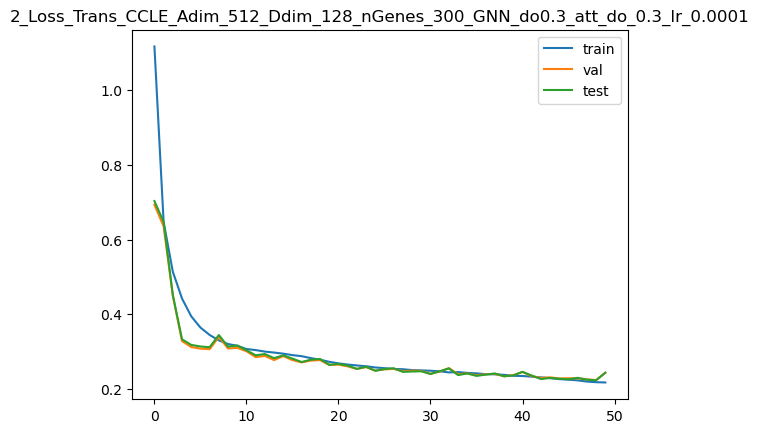

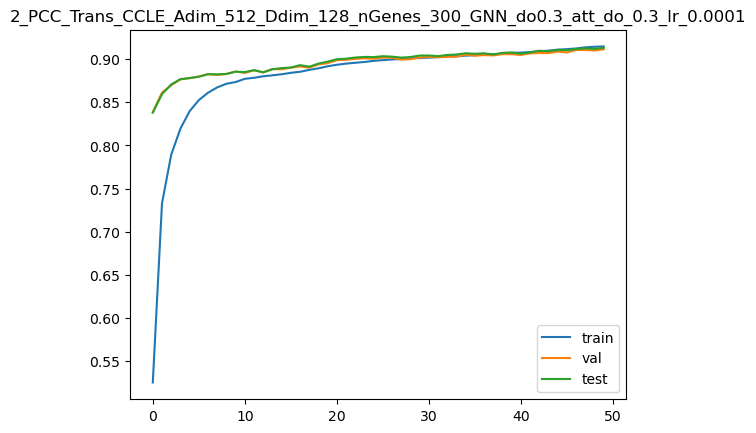

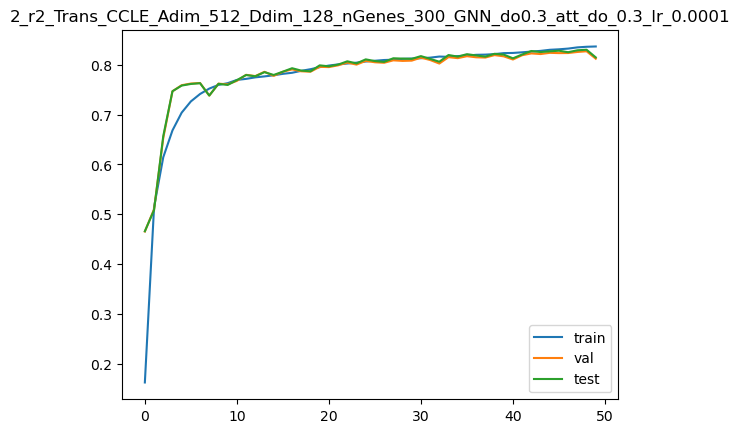

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1922326385974884
The overall Pearson's correlation is 0.9169.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1703825294971466
The overall Pearson's correlation is 0.9238.
Train avg_loss:  0.21567388
Train avg_pcc:  0.9155203050807482
Train r2:  0.8381686684096469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21720152
Validation avg_pcc:  0.9126084605115805
Validation r2:  0.83244922442239
Best Val r2  0.83244922442239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21732971
Test avg_pcc:  0.9139675889108226
Test r2:  0.8348564491594103
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16511236131191254
The overall Pearson's correlation is 0.9268.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1312330812215805
The overall Pearson's correlation is 0.9392.
Train avg_loss:  0.2144598
Train avg_pcc:  0.9160173333316349
Train r2:  0.8390796418508649


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22397374
Validation avg_pcc:  0.9116780582824694
Validation r2:  0.827225077243744


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22419153
Test avg_pcc:  0.9131036642479352
Test r2:  0.8296423014951732
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20688942074775696
The overall Pearson's correlation is 0.9368.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25003814697265625
The overall Pearson's correlation is 0.9125.
Train avg_loss:  0.2111248
Train avg_pcc:  0.9173819423762175
Train r2:  0.8415820836199748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21953683
Validation avg_pcc:  0.9136285794720843
Validation r2:  0.8306477416551692


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21916837
Test avg_pcc:  0.9151371255734079
Test r2:  0.8334592838675092
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19498950242996216
The overall Pearson's correlation is 0.9256.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17904385924339294
The overall Pearson's correlation is 0.9229.
Train avg_loss:  0.21017705
Train avg_pcc:  0.9177708026645468
Train r2:  0.8422932059561948


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21827641
Validation avg_pcc:  0.9133930610585274
Validation r2:  0.8316200417266344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22011597
Test avg_pcc:  0.9140919175097701
Test r2:  0.8327392272079532
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23677149415016174
The overall Pearson's correlation is 0.9052.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.30643412470817566
The overall Pearson's correlation is 0.8883.
Train avg_loss:  0.20747848
Train avg_pcc:  0.9188721901283898
Train r2:  0.8443180955074119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21108247
Validation avg_pcc:  0.9152816091625828
Validation r2:  0.8371694850642045
Best Val r2  0.8371694850642045


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21076621
Test avg_pcc:  0.9166967337390449
Test r2:  0.8398438665480177
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18001075088977814
The overall Pearson's correlation is 0.9512.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.27642881870269775
The overall Pearson's correlation is 0.9038.
Train avg_loss:  0.2048602
Train avg_pcc:  0.9199397306461877
Train r2:  0.8462827284832558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21553335
Validation avg_pcc:  0.9135245075256205
Validation r2:  0.8337360510764606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21264902
Test avg_pcc:  0.9160953684444433
Test r2:  0.838413190278012
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14916324615478516
The overall Pearson's correlation is 0.9170.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21909171342849731
The overall Pearson's correlation is 0.9138.
Train avg_loss:  0.20393749
Train avg_pcc:  0.9203167793229069
Train r2:  0.8469750718376894


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21509305
Validation avg_pcc:  0.9152698980703468
Validation r2:  0.8340757088402264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2155471
Test avg_pcc:  0.916613395503949
Test r2:  0.8362110023459985
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21513232588768005
The overall Pearson's correlation is 0.8743.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17185500264167786
The overall Pearson's correlation is 0.9365.
Train avg_loss:  0.20107464
Train avg_pcc:  0.9214827422162898
Train r2:  0.8491232346811537


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20994075
Validation avg_pcc:  0.9159112723458087
Validation r2:  0.8380502199474961
Best Val r2  0.8380502199474961


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21088667
Test avg_pcc:  0.9168562111586859
Test r2:  0.8397523558986543
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2703222930431366
The overall Pearson's correlation is 0.9366.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18298861384391785
The overall Pearson's correlation is 0.8867.
Train avg_loss:  0.19963728
Train avg_pcc:  0.9220696702357107
Train r2:  0.8502017551953907


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20739111
Validation avg_pcc:  0.9176641630726707
Validation r2:  0.8400170228253013
Best Val r2  0.8400170228253013


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20835865
Test avg_pcc:  0.9184074925632146
Test r2:  0.8416733250414824
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2543147802352905
The overall Pearson's correlation is 0.8994.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2512178122997284
The overall Pearson's correlation is 0.9128.
Train avg_loss:  0.19708623
Train avg_pcc:  0.9231048828248541
Train r2:  0.8521159360461255


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20591731
Validation avg_pcc:  0.9173396176108924
Validation r2:  0.8411539420000644
Best Val r2  0.8411539420000644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20695782
Test avg_pcc:  0.918240053968311
Test r2:  0.8427377902655403
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1440204381942749
The overall Pearson's correlation is 0.9246.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2190895974636078
The overall Pearson's correlation is 0.9278.
Train avg_loss:  0.19575548
Train avg_pcc:  0.9236452396711292
Train r2:  0.8531144647256133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20878331
Validation avg_pcc:  0.9189954198729898
Validation r2:  0.8389430758268805


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20826232
Test avg_pcc:  0.9206275341337186
Test r2:  0.8417465265670044
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1780780553817749
The overall Pearson's correlation is 0.9440.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16184496879577637
The overall Pearson's correlation is 0.9214.
Train avg_loss:  0.19517235
Train avg_pcc:  0.9238833376461936
Train r2:  0.8535520282521207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20506226
Validation avg_pcc:  0.9184400954219988
Validation r2:  0.8418135316570092
Best Val r2  0.8418135316570092


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20506471
Test avg_pcc:  0.919776014400752
Test r2:  0.8441763107823821
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1920105516910553
The overall Pearson's correlation is 0.8838.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13661019504070282
The overall Pearson's correlation is 0.9465.
Train avg_loss:  0.19229303
Train avg_pcc:  0.9250505947794279
Train r2:  0.8557125379512952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20192249
Validation avg_pcc:  0.9193827112311922
Validation r2:  0.8442355678024952
Best Val r2  0.8442355678024952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2033751
Test avg_pcc:  0.9201345767025262
Test r2:  0.8454602039530903
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2691155970096588
The overall Pearson's correlation is 0.9058.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22455726563930511
The overall Pearson's correlation is 0.8964.
Train avg_loss:  0.19093046
Train avg_pcc:  0.9256037844585026
Train r2:  0.8567349291338978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20013943
Validation avg_pcc:  0.9205416236234425
Validation r2:  0.8456110215555521
Best Val r2  0.8456110215555521


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20207168
Test avg_pcc:  0.921144015841556
Test r2:  0.8464506524771579
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13392874598503113
The overall Pearson's correlation is 0.9612.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3112475574016571
The overall Pearson's correlation is 0.9024.
Train avg_loss:  0.18785773
Train avg_pcc:  0.9268482358080787
Train r2:  0.8590405612822574


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20707256
Validation avg_pcc:  0.9195875447490981
Validation r2:  0.84026276402528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20583488
Test avg_pcc:  0.921315599092251
Test r2:  0.8435910854735705
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21133306622505188
The overall Pearson's correlation is 0.9195.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17116203904151917
The overall Pearson's correlation is 0.9446.
Train avg_loss:  0.18789868
Train avg_pcc:  0.9268330607822075
Train r2:  0.8590098287190453


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19901189
Validation avg_pcc:  0.9206102047231343
Validation r2:  0.8464808141965859
Best Val r2  0.8464808141965859


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20041974
Test avg_pcc:  0.9212665801450286
Test r2:  0.8477059112310009
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1807062178850174
The overall Pearson's correlation is 0.9128.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23892995715141296
The overall Pearson's correlation is 0.9283.
Train avg_loss:  0.18524982
Train avg_pcc:  0.9279025610294148
Train r2:  0.8609974161414147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20272306
Validation avg_pcc:  0.9200082818280501
Validation r2:  0.8436179987353987


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20413874
Test avg_pcc:  0.9207960344137986
Test r2:  0.8448799413530372
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1847371906042099
The overall Pearson's correlation is 0.9332.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16688096523284912
The overall Pearson's correlation is 0.9344.
Train avg_loss:  0.1856145
Train avg_pcc:  0.9277568379178279
Train r2:  0.8607237651725074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20041294
Validation avg_pcc:  0.921380680047976
Validation r2:  0.8454000400546221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2016495
Test avg_pcc:  0.9221785585079456
Test r2:  0.8467714591348401
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13557028770446777
The overall Pearson's correlation is 0.9316.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1921928972005844
The overall Pearson's correlation is 0.9282.
Train avg_loss:  0.1825126
Train avg_pcc:  0.9290090383477324
Train r2:  0.8630512897144148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.193133
Validation avg_pcc:  0.9227131226260306
Validation r2:  0.8510158546571077
Best Val r2  0.8510158546571077


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19619612
Test avg_pcc:  0.9227301152378583
Test r2:  0.8509153417061699
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1651085615158081
The overall Pearson's correlation is 0.9302.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2776661217212677
The overall Pearson's correlation is 0.9151.
Train avg_loss:  0.18103883
Train avg_pcc:  0.9296040491470515
Train r2:  0.8641571547937832


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20023546
Validation avg_pcc:  0.9216811660603492
Validation r2:  0.8455369583066423


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19995058
Test avg_pcc:  0.9231543858700749
Test r2:  0.8480624188292403
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17876765131950378
The overall Pearson's correlation is 0.9392.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1857391893863678
The overall Pearson's correlation is 0.9569.
Train avg_loss:  0.18039295
Train avg_pcc:  0.9298651313446733
Train r2:  0.8646417668047197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19106497
Validation avg_pcc:  0.9234169161311279
Validation r2:  0.8526111254095046
Best Val r2  0.8526111254095046


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19115798
Test avg_pcc:  0.9245800651878063
Test r2:  0.8547437132044436
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1580980122089386
The overall Pearson's correlation is 0.8938.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2421194463968277
The overall Pearson's correlation is 0.9021.
Train avg_loss:  0.17946209
Train avg_pcc:  0.9302406450278486
Train r2:  0.8653402442899448


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19267708
Validation avg_pcc:  0.9234385333823847
Validation r2:  0.851367534596126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1948173
Test avg_pcc:  0.9238813481553779
Test r2:  0.8519630640233191
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1358603537082672
The overall Pearson's correlation is 0.9611.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17383980751037598
The overall Pearson's correlation is 0.9473.
Train avg_loss:  0.17769516
Train avg_pcc:  0.9309512344497777
Train r2:  0.8666660645624248


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20447017
Validation avg_pcc:  0.9222303597158542
Validation r2:  0.8422702645220054


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20521142
Test avg_pcc:  0.9233891480922659
Test r2:  0.8440648402603572
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12817655503749847
The overall Pearson's correlation is 0.9426.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2001776099205017
The overall Pearson's correlation is 0.9323.
Train avg_loss:  0.17638503
Train avg_pcc:  0.9314810729104575
Train r2:  0.8676491386539101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19187054
Validation avg_pcc:  0.9233790960083993
Validation r2:  0.85198971693351


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19146615
Test avg_pcc:  0.9247817768534288
Test r2:  0.8545095342097221
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16914880275726318
The overall Pearson's correlation is 0.9068.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1580345332622528
The overall Pearson's correlation is 0.9502.
Train avg_loss:  0.17658566
Train avg_pcc:  0.9314002564746916
Train r2:  0.8674985823408646


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19164857
Validation avg_pcc:  0.9233228005539152
Validation r2:  0.8521609323532643


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19303268
Test avg_pcc:  0.9239996303559375
Test r2:  0.8533191491219636
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10269805043935776
The overall Pearson's correlation is 0.9595.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18992698192596436
The overall Pearson's correlation is 0.9273.
Train avg_loss:  0.17439452
Train avg_pcc:  0.932281009727504
Train r2:  0.8691427020160138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19124962
Validation avg_pcc:  0.9238108546790663
Validation r2:  0.852468689755825


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19096762
Test avg_pcc:  0.9251462230899858
Test r2:  0.8548883564800767
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18183255195617676
The overall Pearson's correlation is 0.9358.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16355393826961517
The overall Pearson's correlation is 0.8814.
Train avg_loss:  0.17276335
Train avg_pcc:  0.9329375791154058
Train r2:  0.8703666769027537


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19423735
Validation avg_pcc:  0.9230005646223818
Validation r2:  0.8501639289181343


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1936044
Test avg_pcc:  0.9245112203172237
Test r2:  0.852884727964455
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10887797176837921
The overall Pearson's correlation is 0.9586.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14777447283267975
The overall Pearson's correlation is 0.9428.
Train avg_loss:  0.17225774
Train avg_pcc:  0.9331416730568753
Train r2:  0.8707460456680928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18796839
Validation avg_pcc:  0.92486714073091
Validation r2:  0.8549998524364075
Best Val r2  0.8549998524364075


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1909509
Test avg_pcc:  0.9248249572776656
Test r2:  0.8549010568898405
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1741136610507965
The overall Pearson's correlation is 0.9184.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16355502605438232
The overall Pearson's correlation is 0.9242.
Train avg_loss:  0.17188872
Train avg_pcc:  0.9332890462156191
Train r2:  0.8710229362237996


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19283724
Validation avg_pcc:  0.9242291285903397
Validation r2:  0.8512439840182022


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19332263
Test avg_pcc:  0.9253900692075225
Test r2:  0.8530988381079089
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1962241530418396
The overall Pearson's correlation is 0.9367.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17588627338409424
The overall Pearson's correlation is 0.9479.
Train avg_loss:  0.17029782
Train avg_pcc:  0.9339290702459676
Train r2:  0.8722166770673715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18998304
Validation avg_pcc:  0.9243204933969488
Validation r2:  0.8534457309861712


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19443789
Test avg_pcc:  0.9238354701470849
Test r2:  0.852251380523625
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.126800075173378
The overall Pearson's correlation is 0.9499.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1679890751838684
The overall Pearson's correlation is 0.9428.
Train avg_loss:  0.16822426
Train avg_pcc:  0.9347605018094669
Train r2:  0.8737725714362599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18620141
Validation avg_pcc:  0.9257133726682258
Validation r2:  0.8563629184554442
Best Val r2  0.8563629184554442


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18894984
Test avg_pcc:  0.9257951049605821
Test r2:  0.8564216184191447
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2016620934009552
The overall Pearson's correlation is 0.9409.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15826521813869476
The overall Pearson's correlation is 0.9303.
Train avg_loss:  0.16769756
Train avg_pcc:  0.9349733124902597
Train r2:  0.8741677872486004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18679312
Validation avg_pcc:  0.9258321742992464
Validation r2:  0.8559064606732771


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18834075
Test avg_pcc:  0.9264549971874904
Test r2:  0.856884437630937
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12940570712089539
The overall Pearson's correlation is 0.9381.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17473141849040985
The overall Pearson's correlation is 0.9171.
Train avg_loss:  0.16654652
Train avg_pcc:  0.935434759728123
Train r2:  0.8750314662215224


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18967609
Validation avg_pcc:  0.9242654325208873
Validation r2:  0.8536825212888194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19008878
Test avg_pcc:  0.9253216808808159
Test r2:  0.8555561606056092
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11005444824695587
The overall Pearson's correlation is 0.9533.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.205980584025383
The overall Pearson's correlation is 0.9364.
Train avg_loss:  0.16580978
Train avg_pcc:  0.9357296750363049
Train r2:  0.8755842875156568


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18916127
Validation avg_pcc:  0.925080277303585
Validation r2:  0.8540796517700091


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19102879
Test avg_pcc:  0.9255708477677784
Test r2:  0.8548418873184259
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16487562656402588
The overall Pearson's correlation is 0.9392.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09318622201681137
The overall Pearson's correlation is 0.9653.
Train avg_loss:  0.16452834
Train avg_pcc:  0.9362436323246441
Train r2:  0.8765458142616807


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1877071
Validation avg_pcc:  0.9252357838857235
Validation r2:  0.8552014361301821


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19177653
Test avg_pcc:  0.9248925761717497
Test r2:  0.8542736833589442
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26503294706344604
The overall Pearson's correlation is 0.9254.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19363555312156677
The overall Pearson's correlation is 0.9277.
Train avg_loss:  0.16319941
Train avg_pcc:  0.9367757392019463
Train r2:  0.8775429886819572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18228981
Validation avg_pcc:  0.927064865530222
Validation r2:  0.8593803583060236
Best Val r2  0.8593803583060236


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18489684
Test avg_pcc:  0.9271179620736779
Test r2:  0.8595013816279152
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1892065703868866
The overall Pearson's correlation is 0.9236.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16976970434188843
The overall Pearson's correlation is 0.9471.
Train avg_loss:  0.16240552
Train avg_pcc:  0.9370935500017161
Train r2:  0.8781386830902245


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1835393
Validation avg_pcc:  0.9266828977928647
Validation r2:  0.8584164969073573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18618307
Test avg_pcc:  0.9268345784247325
Test r2:  0.858524011664724
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17086482048034668
The overall Pearson's correlation is 0.9337.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17147797346115112
The overall Pearson's correlation is 0.9556.
Train avg_loss:  0.16119632
Train avg_pcc:  0.9375779776263372
Train r2:  0.8790460071639893


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18902767
Validation avg_pcc:  0.9260519031012814
Validation r2:  0.8541827096414429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18994445
Test avg_pcc:  0.9270395193320213
Test r2:  0.855665836399158
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15380796790122986
The overall Pearson's correlation is 0.9379.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16315531730651855
The overall Pearson's correlation is 0.9452.
Train avg_loss:  0.16052352
Train avg_pcc:  0.9378476704302068
Train r2:  0.879550844742512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18548672
Validation avg_pcc:  0.9273329473623073
Validation r2:  0.8569142240594617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18677522
Test avg_pcc:  0.9280444259509752
Test r2:  0.8580740595546198
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1711190640926361
The overall Pearson's correlation is 0.9260.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10394658148288727
The overall Pearson's correlation is 0.9580.
Train avg_loss:  0.15934119
Train avg_pcc:  0.9383192616373044
Train r2:  0.8804380169271109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18263587
Validation avg_pcc:  0.927035218145897
Validation r2:  0.8591133973498264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18473011
Test avg_pcc:  0.9273680958644788
Test r2:  0.8596280844855713
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13159120082855225
The overall Pearson's correlation is 0.9643.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1449175477027893
The overall Pearson's correlation is 0.9299.
Train avg_loss:  0.15918386
Train avg_pcc:  0.9383823856704853
Train r2:  0.8805560714222403


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1823435
Validation avg_pcc:  0.9275627778823363
Validation r2:  0.8593389432851415


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18447271
Test avg_pcc:  0.9279036854672685
Test r2:  0.8598236757931754
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.177247554063797
The overall Pearson's correlation is 0.9495.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1365363597869873
The overall Pearson's correlation is 0.9544.
Train avg_loss:  0.1585443
Train avg_pcc:  0.9386381691658905
Train r2:  0.8810359533261709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18235077
Validation avg_pcc:  0.9281280426328384
Validation r2:  0.8593333265757461


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18440336
Test avg_pcc:  0.9285684341709137
Test r2:  0.8598763760947021
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13528291881084442
The overall Pearson's correlation is 0.9266.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15344154834747314
The overall Pearson's correlation is 0.9572.
Train avg_loss:  0.15816094
Train avg_pcc:  0.938791549534984
Train r2:  0.881323618177897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18252093
Validation avg_pcc:  0.9274738834854149
Validation r2:  0.8592020679377745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18469232
Test avg_pcc:  0.9277691411029246
Test r2:  0.8596567983637515
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10345722734928131
The overall Pearson's correlation is 0.9371.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11401844024658203
The overall Pearson's correlation is 0.9392.
Train avg_loss:  0.15608409
Train avg_pcc:  0.9396203592141174
Train r2:  0.8828819584789825


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17809564
Validation avg_pcc:  0.928935695576806
Validation r2:  0.8626157763327789
Best Val r2  0.8626157763327789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18115771
Test avg_pcc:  0.9288425014065206
Test r2:  0.8623426626391408
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08767008781433105
The overall Pearson's correlation is 0.9702.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11407745629549026
The overall Pearson's correlation is 0.9636.
Train avg_loss:  0.15564156
Train avg_pcc:  0.939797801381172
Train r2:  0.8832140415048316


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17942494
Validation avg_pcc:  0.9286981550514567
Validation r2:  0.86159033208251


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18213353
Test avg_pcc:  0.928809231146137
Test r2:  0.8616011571821705
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1836477816104889
The overall Pearson's correlation is 0.8986.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12404927611351013
The overall Pearson's correlation is 0.9576.
Train avg_loss:  0.15510523
Train avg_pcc:  0.9400127709271311
Train r2:  0.8836164634469968


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18156749
Validation avg_pcc:  0.92786452154769
Validation r2:  0.8599375415952987


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18406916
Test avg_pcc:  0.9280367857008265
Test r2:  0.8601303399560791
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17298123240470886
The overall Pearson's correlation is 0.9280.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1151030883193016
The overall Pearson's correlation is 0.9461.
Train avg_loss:  0.15405154
Train avg_pcc:  0.9404317320808641
Train r2:  0.8844071138648922


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18027562
Validation avg_pcc:  0.9280343603071859
Validation r2:  0.8609341087088058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18218999
Test avg_pcc:  0.9284139272770366
Test r2:  0.8615582581372471
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12030021101236343
The overall Pearson's correlation is 0.9486.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2588021159172058
The overall Pearson's correlation is 0.8710.
Train avg_loss:  0.15322293
Train avg_pcc:  0.9407633260699162
Train r2:  0.8850288650481726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17923263
Validation avg_pcc:  0.9285104366098659
Validation r2:  0.861738668840208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18153875
Test avg_pcc:  0.928666131853589
Test r2:  0.8620531220245276
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19490133225917816
The overall Pearson's correlation is 0.9195.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24030983448028564
The overall Pearson's correlation is 0.9329.
Train avg_loss:  0.15189469
Train avg_pcc:  0.9412924319012219
Train r2:  0.8860255095057453


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17926268
Validation avg_pcc:  0.9290217784448567
Validation r2:  0.8617155038646529


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1835386
Test avg_pcc:  0.9285075743726958
Test r2:  0.860533476472936
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1121111810207367
The overall Pearson's correlation is 0.9596.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22628937661647797
The overall Pearson's correlation is 0.9265.
Train avg_loss:  0.1511414
Train avg_pcc:  0.9415924794900035
Train r2:  0.8865907315941846


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18284163
Validation avg_pcc:  0.9272457586715764
Validation r2:  0.8589546758925455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18424702
Test avg_pcc:  0.9279151759335257
Test r2:  0.8599951701861809


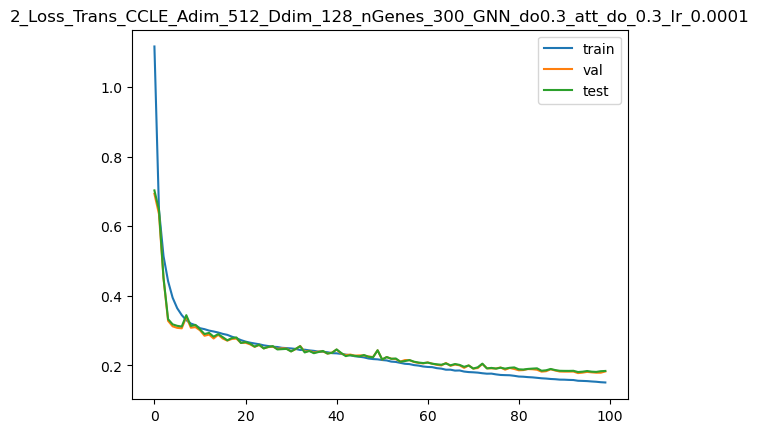

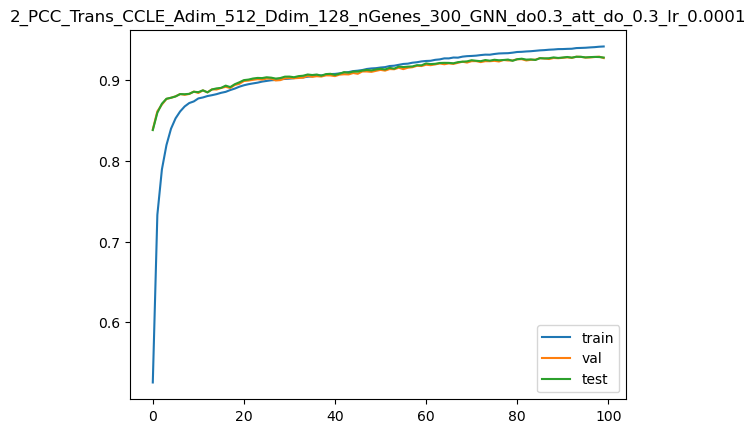

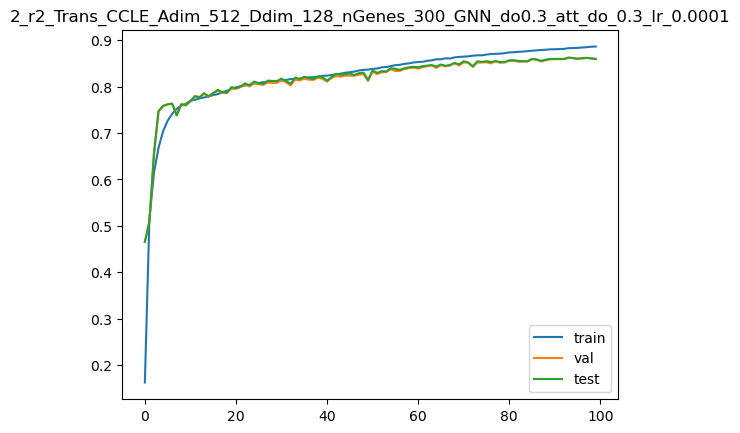

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1591610163450241
The overall Pearson's correlation is 0.9303.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10388034582138062
The overall Pearson's correlation is 0.9557.
Train avg_loss:  0.15031216
Train avg_pcc:  0.9419231790723958
Train r2:  0.8872129593659202


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.182397
Validation avg_pcc:  0.9297070719347964
Validation r2:  0.8592976783488604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1861099
Test avg_pcc:  0.929450804216403
Test r2:  0.8585796186610309
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1574329137802124
The overall Pearson's correlation is 0.9428.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14489927887916565
The overall Pearson's correlation is 0.9568.
Train avg_loss:  0.14981464
Train avg_pcc:  0.9421221509342553
Train r2:  0.8875862810673633


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17769976
Validation avg_pcc:  0.929226707478389
Validation r2:  0.8629211405773243
Best Val r2  0.8629211405773243


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18131125
Test avg_pcc:  0.9288057468090478
Test r2:  0.862225989076686
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20842117071151733
The overall Pearson's correlation is 0.9170.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1694490611553192
The overall Pearson's correlation is 0.9244.
Train avg_loss:  0.1489342
Train avg_pcc:  0.9424714699706295
Train r2:  0.8882469114219912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17707951
Validation avg_pcc:  0.9299956978891194
Validation r2:  0.8633996261665983
Best Val r2  0.8633996261665983


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18030426
Test avg_pcc:  0.929868722134048
Test r2:  0.8629911728279589
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1421535164117813
The overall Pearson's correlation is 0.9361.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2097005546092987
The overall Pearson's correlation is 0.9262.
Train avg_loss:  0.14759861
Train avg_pcc:  0.94300284367341
Train r2:  0.8892490783322263


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17578357
Validation avg_pcc:  0.9299173054673479
Validation r2:  0.8643993057415728
Best Val r2  0.8643993057415728


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17951836
Test avg_pcc:  0.9294655785305438
Test r2:  0.863588362565918
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15362416207790375
The overall Pearson's correlation is 0.9492.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10726010799407959
The overall Pearson's correlation is 0.9588.
Train avg_loss:  0.14816041
Train avg_pcc:  0.9427797777505078
Train r2:  0.8888275315157371


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17537925
Validation avg_pcc:  0.9299551681462049
Validation r2:  0.8647112204722568
Best Val r2  0.8647112204722568


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1773735
Test avg_pcc:  0.9302021893014139
Test r2:  0.8652181963197104
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10315729677677155
The overall Pearson's correlation is 0.9138.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14566373825073242
The overall Pearson's correlation is 0.9524.
Train avg_loss:  0.14590017
Train avg_pcc:  0.9436777224756399
Train r2:  0.8905235023452722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17777222
Validation avg_pcc:  0.9291803185034162
Validation r2:  0.8628652615872323


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18156973
Test avg_pcc:  0.9287449727220166
Test r2:  0.8620295815037293
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15331631898880005
The overall Pearson's correlation is 0.9352.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16123540699481964
The overall Pearson's correlation is 0.9400.
Train avg_loss:  0.14588237
Train avg_pcc:  0.9436852187428374
Train r2:  0.8905368702947734


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18131772
Validation avg_pcc:  0.9292655338377305
Validation r2:  0.8601302363156588


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18373246
Test avg_pcc:  0.9296574588051982
Test r2:  0.8603861595385128
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12025727331638336
The overall Pearson's correlation is 0.9539.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10155652463436127
The overall Pearson's correlation is 0.9612.
Train avg_loss:  0.14534791
Train avg_pcc:  0.9438978193303054
Train r2:  0.8909378969627053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17664762
Validation avg_pcc:  0.9295994230710096
Validation r2:  0.863732782510424


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17805658
Test avg_pcc:  0.930048051532782
Test r2:  0.8646991247590344
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09403697401285172
The overall Pearson's correlation is 0.9344.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15351024270057678
The overall Pearson's correlation is 0.9265.
Train avg_loss:  0.14463927
Train avg_pcc:  0.9441798205562706
Train r2:  0.8914696290803219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17658898
Validation avg_pcc:  0.9294187362262007
Validation r2:  0.8637780125643708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17941101
Test avg_pcc:  0.9293563272717976
Test r2:  0.863669942308132
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16132193803787231
The overall Pearson's correlation is 0.9612.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14931301772594452
The overall Pearson's correlation is 0.9419.
Train avg_loss:  0.14396167
Train avg_pcc:  0.9444486337033562
Train r2:  0.8919780743832506


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17790787
Validation avg_pcc:  0.9297823807369548
Validation r2:  0.8627606194939587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18135567
Test avg_pcc:  0.9293894096133024
Test r2:  0.8621922322949483
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13018891215324402
The overall Pearson's correlation is 0.9702.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12799100577831268
The overall Pearson's correlation is 0.9377.
Train avg_loss:  0.14339852
Train avg_pcc:  0.9446723866622628
Train r2:  0.89240062164364


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1752038
Validation avg_pcc:  0.9301464449859888
Validation r2:  0.8648465551665041
Best Val r2  0.8648465551665041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17811875
Test avg_pcc:  0.9300547419720441
Test r2:  0.8646518915793524
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1726427972316742
The overall Pearson's correlation is 0.9537.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14542990922927856
The overall Pearson's correlation is 0.9509.
Train avg_loss:  0.14309384
Train avg_pcc:  0.9447936102209682
Train r2:  0.8926292522513102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17606623
Validation avg_pcc:  0.9299852534625818
Validation r2:  0.8641812592746743


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17975566
Test avg_pcc:  0.929600081158751
Test r2:  0.8634080462482154
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1929103434085846
The overall Pearson's correlation is 0.9247.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16357706487178802
The overall Pearson's correlation is 0.9509.
Train avg_loss:  0.1417889
Train avg_pcc:  0.9453110720035891
Train r2:  0.893608422106616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1734511
Validation avg_pcc:  0.9307813565019458
Validation r2:  0.8661986047058465
Best Val r2  0.8661986047058465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17689295
Test avg_pcc:  0.9304213003593726
Test r2:  0.8655833434688058
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11171855032444
The overall Pearson's correlation is 0.9668.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11401784420013428
The overall Pearson's correlation is 0.9582.
Train avg_loss:  0.14024949
Train avg_pcc:  0.9459216587307647
Train r2:  0.894763496138837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17581101
Validation avg_pcc:  0.930462220495768
Validation r2:  0.8643781504996262


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18050978
Test avg_pcc:  0.9297508170795438
Test r2:  0.8628350137995875
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09298205375671387
The overall Pearson's correlation is 0.9592.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13546520471572876
The overall Pearson's correlation is 0.9662.
Train avg_loss:  0.14053775
Train avg_pcc:  0.9458077938684111
Train r2:  0.8945471980989088


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17531672
Validation avg_pcc:  0.930188120398582
Validation r2:  0.8647594460989473


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17688061
Test avg_pcc:  0.9306807695314313
Test r2:  0.8655927211939702
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13506413996219635
The overall Pearson's correlation is 0.9541.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12731678783893585
The overall Pearson's correlation is 0.9531.
Train avg_loss:  0.13940129
Train avg_pcc:  0.9462584130080652
Train r2:  0.8953999566946469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17457019
Validation avg_pcc:  0.9302928789086685
Validation r2:  0.865335325274701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17683223
Test avg_pcc:  0.93044337061119
Test r2:  0.8656294858528373
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1306035965681076
The overall Pearson's correlation is 0.9501.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10543732345104218
The overall Pearson's correlation is 0.9589.
Train avg_loss:  0.13933152
Train avg_pcc:  0.9462861490996339
Train r2:  0.8954523214704418


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17424086
Validation avg_pcc:  0.93095630233362
Validation r2:  0.8655893749012546


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17844741
Test avg_pcc:  0.9304313567642404
Test r2:  0.8644021566135965
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11427373439073563
The overall Pearson's correlation is 0.9703.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17132478952407837
The overall Pearson's correlation is 0.9418.
Train avg_loss:  0.13805091
Train avg_pcc:  0.9467932776478543
Train r2:  0.8964132126385247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1736258
Validation avg_pcc:  0.9317139629219559
Validation r2:  0.8660638418333618


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1775595
Test avg_pcc:  0.9313209701486663
Test r2:  0.8650768548590203
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18707217276096344
The overall Pearson's correlation is 0.9347.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13825508952140808
The overall Pearson's correlation is 0.9419.
Train avg_loss:  0.13812235
Train avg_pcc:  0.9467661416399331
Train r2:  0.8963596161486241


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19164062
Validation avg_pcc:  0.9294842096437727
Validation r2:  0.8521670752310715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1940993
Test avg_pcc:  0.9299918053978693
Test r2:  0.8525086623719033
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1501438021659851
The overall Pearson's correlation is 0.9555.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10928060859441757
The overall Pearson's correlation is 0.9687.
Train avg_loss:  0.13709198
Train avg_pcc:  0.9471739518126095
Train r2:  0.8971327499420709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17183708
Validation avg_pcc:  0.9313948358723423
Validation r2:  0.867443669360779
Best Val r2  0.867443669360779


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17609744
Test avg_pcc:  0.9307440938057756
Test r2:  0.8661878322151599
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16795614361763
The overall Pearson's correlation is 0.9382.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17597348988056183
The overall Pearson's correlation is 0.9225.
Train avg_loss:  0.13711624
Train avg_pcc:  0.9471643565613649
Train r2:  0.8971145592043975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1744261
Validation avg_pcc:  0.930887400577967
Validation r2:  0.8654464830787508


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17603458
Test avg_pcc:  0.9313350419447204
Test r2:  0.86623559153138
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15910765528678894
The overall Pearson's correlation is 0.9467.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13093577325344086
The overall Pearson's correlation is 0.9486.
Train avg_loss:  0.13528845
Train avg_pcc:  0.9478874277114266
Train r2:  0.8984860326989285


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1712956
Validation avg_pcc:  0.9316854491702543
Validation r2:  0.8678613783399616
Best Val r2  0.8678613783399616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1750273
Test avg_pcc:  0.9312698337008216
Test r2:  0.8670010203887684
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13019175827503204
The overall Pearson's correlation is 0.9564.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15104489028453827
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.1347459
Train avg_pcc:  0.9481026543512971
Train r2:  0.8988931460756717


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1734908
Validation avg_pcc:  0.9313203041558334
Validation r2:  0.8661679739587932


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17821191
Test avg_pcc:  0.9306021833781306
Test r2:  0.8645810937110441
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12910699844360352
The overall Pearson's correlation is 0.9553.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06758490204811096
The overall Pearson's correlation is 0.9531.
Train avg_loss:  0.13412529
Train avg_pcc:  0.9483480596085976
Train r2:  0.8993588144523698


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1710907
Validation avg_pcc:  0.9322436404837581
Validation r2:  0.8680194244130859
Best Val r2  0.8680194244130859


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17535909
Test avg_pcc:  0.931626689901134
Test r2:  0.8667488931154703
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16400954127311707
The overall Pearson's correlation is 0.9440.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11333713680505753
The overall Pearson's correlation is 0.9521.
Train avg_loss:  0.13460235
Train avg_pcc:  0.9481586000909287
Train r2:  0.8990008412719644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1727336
Validation avg_pcc:  0.931338804635758
Validation r2:  0.8667520809450294


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17573908
Test avg_pcc:  0.9311270449707357
Test r2:  0.8664601475821374
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10175460577011108
The overall Pearson's correlation is 0.9518.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14868977665901184
The overall Pearson's correlation is 0.9273.
Train avg_loss:  0.13378368
Train avg_pcc:  0.9484833715777673
Train r2:  0.8996151350281594


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17318149
Validation avg_pcc:  0.9325800418762247
Validation r2:  0.866406574328981


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17648222
Test avg_pcc:  0.9321061488382409
Test r2:  0.8658954595680866
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0716203898191452
The overall Pearson's correlation is 0.9681.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12606960535049438
The overall Pearson's correlation is 0.9391.
Train avg_loss:  0.13320404
Train avg_pcc:  0.9487116722593794
Train r2:  0.9000500747627231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17116804
Validation avg_pcc:  0.9319712605311035
Validation r2:  0.867959760956324


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17342736
Test avg_pcc:  0.9321554258974393
Test r2:  0.8682167739409886
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15919062495231628
The overall Pearson's correlation is 0.9168.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1434749960899353
The overall Pearson's correlation is 0.9356.
Train avg_loss:  0.13191772
Train avg_pcc:  0.9492214660565833
Train r2:  0.9010152715649519


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1730552
Validation avg_pcc:  0.9315414293951693
Validation r2:  0.8665040004203824


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17711766
Test avg_pcc:  0.9310254914340536
Test r2:  0.8654125954105866
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1131458580493927
The overall Pearson's correlation is 0.9551.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1037449985742569
The overall Pearson's correlation is 0.9583.
Train avg_loss:  0.13129127
Train avg_pcc:  0.9494679907304139
Train r2:  0.9014853176830203


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17130847
Validation avg_pcc:  0.9324492295841885
Validation r2:  0.8678514350542711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17518638
Test avg_pcc:  0.9319227514839722
Test r2:  0.8668801290831817
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08824732899665833
The overall Pearson's correlation is 0.9601.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.138215571641922
The overall Pearson's correlation is 0.9556.
Train avg_loss:  0.13112195
Train avg_pcc:  0.9495347119243126
Train r2:  0.9016123880438341


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17251796
Validation avg_pcc:  0.9325717989853777
Validation r2:  0.866918431835102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1769481
Test avg_pcc:  0.9319636051575145
Test r2:  0.865541439473296
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1333090215921402
The overall Pearson's correlation is 0.9425.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1274603009223938
The overall Pearson's correlation is 0.9562.
Train avg_loss:  0.13045779
Train avg_pcc:  0.9497982956081332
Train r2:  0.9021107171451929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16774385
Validation avg_pcc:  0.9333325870741976
Validation r2:  0.870601216781215
Best Val r2  0.870601216781215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17282236
Test avg_pcc:  0.9322418802197262
Test r2:  0.86867648702202
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18901972472667694
The overall Pearson's correlation is 0.9252.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11246176064014435
The overall Pearson's correlation is 0.9559.
Train avg_loss:  0.13008614
Train avg_pcc:  0.9499440440372658
Train r2:  0.9023895977072935


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16910823
Validation avg_pcc:  0.9327045841275216
Validation r2:  0.869548717941619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17206904
Test avg_pcc:  0.9325502168600128
Test r2:  0.8692489069739702
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11982683837413788
The overall Pearson's correlation is 0.9572.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1598411500453949
The overall Pearson's correlation is 0.9394.
Train avg_loss:  0.12970309
Train avg_pcc:  0.9500954938744354
Train r2:  0.9026770172230233


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17250967
Validation avg_pcc:  0.9323292115067869
Validation r2:  0.8669248182980094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17495993
Test avg_pcc:  0.932516383851535
Test r2:  0.8670521963604845
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14903615415096283
The overall Pearson's correlation is 0.9570.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10502032935619354
The overall Pearson's correlation is 0.9632.
Train avg_loss:  0.12882105
Train avg_pcc:  0.9504445168012227
Train r2:  0.9033388662818589


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1739718
Validation avg_pcc:  0.9306078067826535
Validation r2:  0.8657969214479856


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1775414
Test avg_pcc:  0.9303158942900357
Test r2:  0.8650906057014196
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16142436861991882
The overall Pearson's correlation is 0.9429.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1250840127468109
The overall Pearson's correlation is 0.9697.
Train avg_loss:  0.1292715
Train avg_pcc:  0.9502660073906001
Train r2:  0.9030008638391986


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17130199
Validation avg_pcc:  0.9323245777658462
Validation r2:  0.8678564310456119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17497665
Test avg_pcc:  0.9320399418964178
Test r2:  0.8670395014947967
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09203686565160751
The overall Pearson's correlation is 0.9605.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09591422975063324
The overall Pearson's correlation is 0.9675.
Train avg_loss:  0.12806794
Train avg_pcc:  0.9507420241071628
Train r2:  0.9039039579928851


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16923618
Validation avg_pcc:  0.9326195584161739
Validation r2:  0.8694500159428278


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17234437
Test avg_pcc:  0.9324459962251508
Test r2:  0.8690397020493608
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13769569993019104
The overall Pearson's correlation is 0.9524.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18834581971168518
The overall Pearson's correlation is 0.9367.
Train avg_loss:  0.12764238
Train avg_pcc:  0.9509086845341705
Train r2:  0.9042232843847187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16859682
Validation avg_pcc:  0.9329727515701974
Validation r2:  0.8699432150331495


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17162523
Test avg_pcc:  0.9327470789792844
Test r2:  0.8695861635904893
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11104997247457504
The overall Pearson's correlation is 0.9549.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.088882677257061
The overall Pearson's correlation is 0.9575.
Train avg_loss:  0.1269849
Train avg_pcc:  0.9511682474223676
Train r2:  0.9047166226121685


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17098801
Validation avg_pcc:  0.9320781462469669
Validation r2:  0.8680986468892355


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17195478
Test avg_pcc:  0.9328046527166909
Test r2:  0.8693357449476159
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11189938336610794
The overall Pearson's correlation is 0.9662.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11204797774553299
The overall Pearson's correlation is 0.9357.
Train avg_loss:  0.1255921
Train avg_pcc:  0.9517178452164242
Train r2:  0.9057617086593321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16847876
Validation avg_pcc:  0.9332236586814889
Validation r2:  0.8700342972611672


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17050076
Test avg_pcc:  0.9334254075771476
Test r2:  0.8704406142544983
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08455386757850647
The overall Pearson's correlation is 0.9702.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.168312668800354
The overall Pearson's correlation is 0.9415.
Train avg_loss:  0.1265473
Train avg_pcc:  0.951341371128446
Train r2:  0.9050449686088293


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17142202
Validation avg_pcc:  0.9319253430981689
Validation r2:  0.8677638384953641


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17332876
Test avg_pcc:  0.9322344169470876
Test r2:  0.8682916925482224
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15960459411144257
The overall Pearson's correlation is 0.9417.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13622421026229858
The overall Pearson's correlation is 0.9378.
Train avg_loss:  0.1257664
Train avg_pcc:  0.9516485366254785
Train r2:  0.9056309224621988


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16945101
Validation avg_pcc:  0.9336776089570759
Validation r2:  0.8692842935478626


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17456456
Test avg_pcc:  0.9326329712296981
Test r2:  0.867352644775992
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07342362403869629
The overall Pearson's correlation is 0.9703.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11647847294807434
The overall Pearson's correlation is 0.9678.
Train avg_loss:  0.12518196
Train avg_pcc:  0.9518795639623445
Train r2:  0.906069450957153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1687435
Validation avg_pcc:  0.9328055292545736
Validation r2:  0.8698300647704567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17277047
Test avg_pcc:  0.9321813490131983
Test r2:  0.8687159206521364
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09336294233798981
The overall Pearson's correlation is 0.9672.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11825712025165558
The overall Pearson's correlation is 0.9485.
Train avg_loss:  0.12442544
Train avg_pcc:  0.9521778076582352
Train r2:  0.9066371157389406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16670325
Validation avg_pcc:  0.9335577557302993
Validation r2:  0.871403914382397
Best Val r2  0.871403914382397


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16898397
Test avg_pcc:  0.9337063737067182
Test r2:  0.8715931998011164
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0929323211312294
The overall Pearson's correlation is 0.9593.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06754931062459946
The overall Pearson's correlation is 0.9781.
Train avg_loss:  0.1242608
Train avg_pcc:  0.9522423238324144
Train r2:  0.9067606515404278


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17179087
Validation avg_pcc:  0.9329473773688433
Validation r2:  0.8674793099846685


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17438069
Test avg_pcc:  0.9330729402052024
Test r2:  0.8674923556490646
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1025255024433136
The overall Pearson's correlation is 0.9659.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12286727130413055
The overall Pearson's correlation is 0.9383.
Train avg_loss:  0.12349395
Train avg_pcc:  0.9525440334822101
Train r2:  0.9073360630066932


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1729067
Validation avg_pcc:  0.9329760846201571
Validation r2:  0.8666185484037241


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17552395
Test avg_pcc:  0.9330671468832792
Test r2:  0.8666236226778201
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15080735087394714
The overall Pearson's correlation is 0.9659.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14826196432113647
The overall Pearson's correlation is 0.9394.
Train avg_loss:  0.1236347
Train avg_pcc:  0.952489260636818
Train r2:  0.9072304486079757


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17185596
Validation avg_pcc:  0.9326812769204547
Validation r2:  0.8674291028048068


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17545998
Test avg_pcc:  0.9323768299141654
Test r2:  0.8666722261587211
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14484566450119019
The overall Pearson's correlation is 0.9502.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13151915371418
The overall Pearson's correlation is 0.9533.
Train avg_loss:  0.12229533
Train avg_pcc:  0.9530163104553763
Train r2:  0.9082354468236259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17164488
Validation avg_pcc:  0.932513659202853
Validation r2:  0.867591930938322


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17486008
Test avg_pcc:  0.932350274665332
Test r2:  0.8671280814483364
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11438561230897903
The overall Pearson's correlation is 0.9661.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07071620225906372
The overall Pearson's correlation is 0.9753.
Train avg_loss:  0.12235019
Train avg_pcc:  0.9529948267338694
Train r2:  0.9081942808070536


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16711289
Validation avg_pcc:  0.9335517822926735
Validation r2:  0.8710879492834877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16901232
Test avg_pcc:  0.9337894419972582
Test r2:  0.8715716446301857
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0899449810385704
The overall Pearson's correlation is 0.9577.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08971986174583435
The overall Pearson's correlation is 0.9712.
Train avg_loss:  0.121262066
Train avg_pcc:  0.9534232061431039
Train r2:  0.9090107593559867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16829084
Validation avg_pcc:  0.9340115762634054
Validation r2:  0.8701792592343013


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17101555
Test avg_pcc:  0.9338923878093867
Test r2:  0.8700494500867069
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1459716260433197
The overall Pearson's correlation is 0.9523.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10418172925710678
The overall Pearson's correlation is 0.9502.
Train avg_loss:  0.1204314
Train avg_pcc:  0.9537498242060134
Train r2:  0.9096340407925898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17037067
Validation avg_pcc:  0.9327239406210742
Validation r2:  0.8685748562291304


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1732527
Test avg_pcc:  0.9325331560336807
Test r2:  0.868349487836602


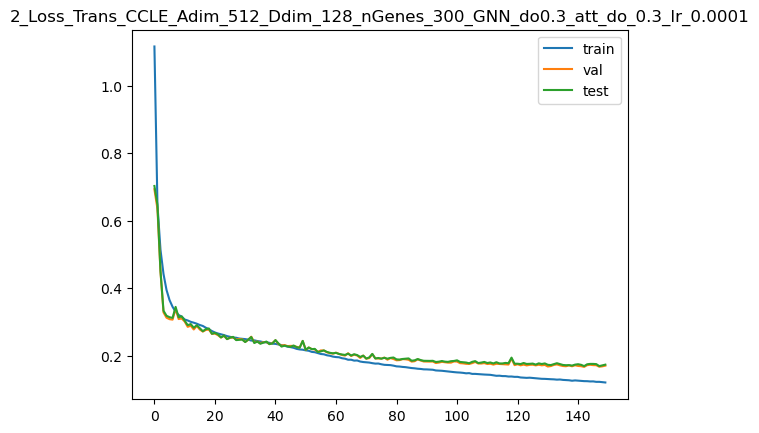

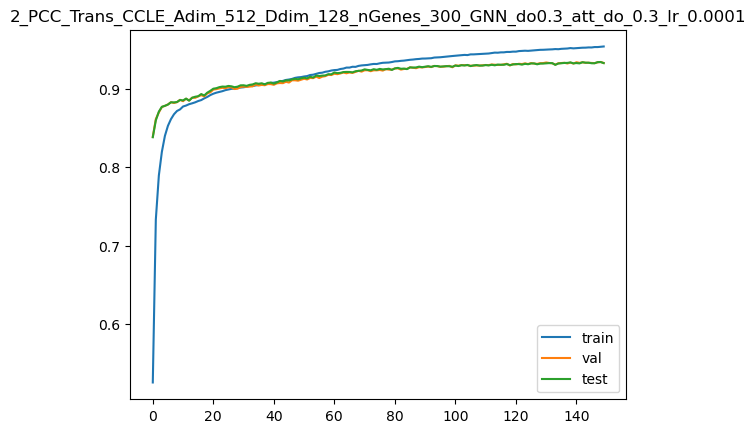

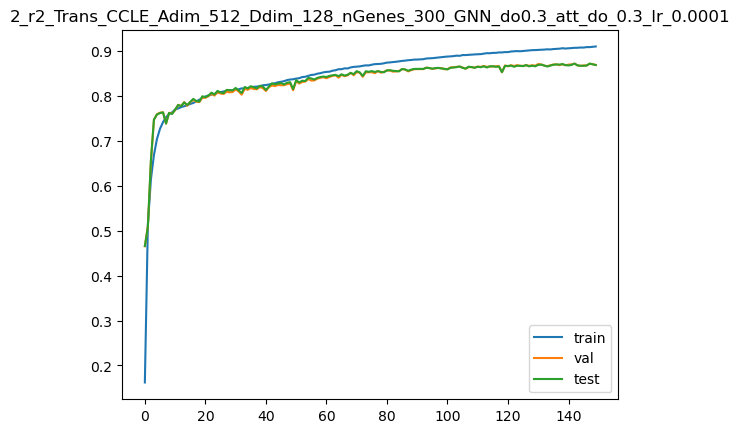

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16898395
Test avg_pcc:  0.9337063736527277
Test r2:  0.8715931995729539


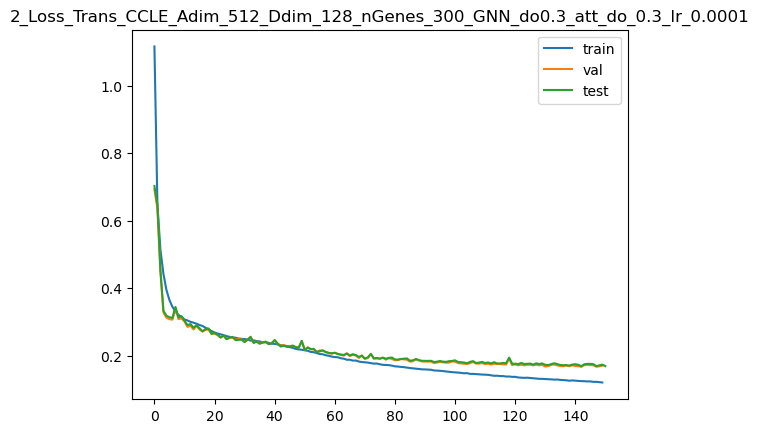

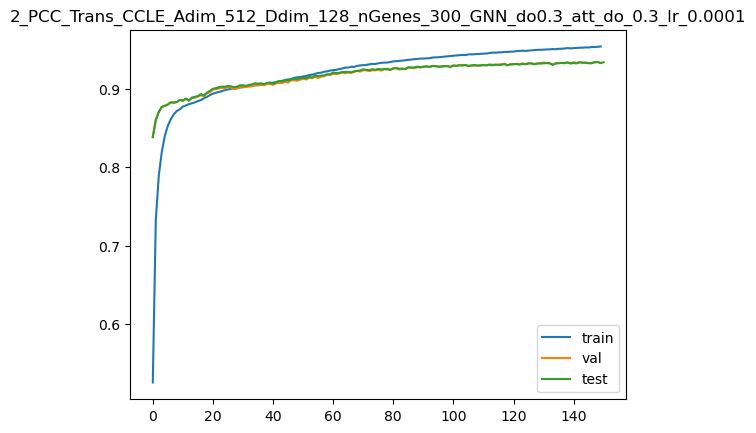

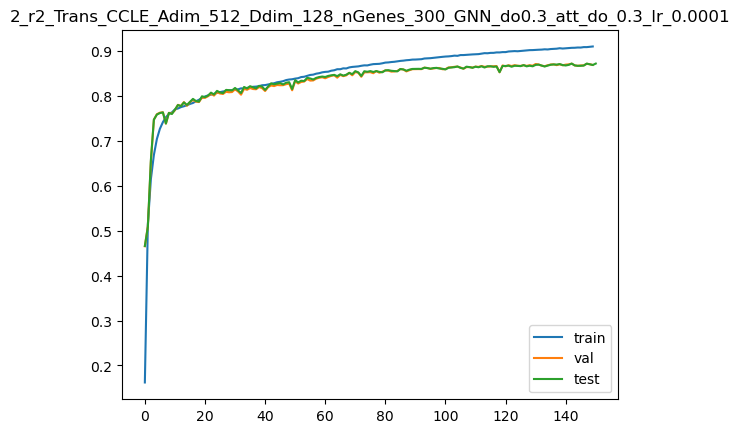

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  1.049243450164795
The overall Pearson's correlation is 0.4818.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.8861473798751831
The overall Pearson's correlation is 0.7146.
Train avg_loss:  1.1088831
Train avg_pcc:  0.5278642323448041
Train r2:  0.16581407339474052


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.43036464
Validation avg_pcc:  0.8318451887039748
Validation r2:  0.6658006780847512
Best Val r2  0.6658006780847512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.43709722
Test avg_pcc:  0.8344739914166841
Test r2:  0.6719452701056585
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.5796316266059875
The overall Pearson's correlation is 0.8031.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.72594153881073
The overall Pearson's correlation is 0.6701.
Train avg_loss:  0.650165
Train avg_pcc:  0.7297381444888829
Train r2:  0.5108966574451532


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.52118087
Validation avg_pcc:  0.8613820951772488
Validation r2:  0.5952773434105727


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.5259479
Test avg_pcc:  0.8630790087239092
Test r2:  0.6052600853148693
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4194101095199585
The overall Pearson's correlation is 0.7639.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.34105297923088074
The overall Pearson's correlation is 0.8824.
Train avg_loss:  0.5192801
Train avg_pcc:  0.7860667138060744
Train r2:  0.6093581156257757


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.40821284
Validation avg_pcc:  0.8717603199304281
Validation r2:  0.6830026300705612
Best Val r2  0.6830026300705612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.41191635
Test avg_pcc:  0.8732100860793206
Test r2:  0.6908442625069203
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.44870641827583313
The overall Pearson's correlation is 0.7832.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2813568115234375
The overall Pearson's correlation is 0.8260.
Train avg_loss:  0.44550756
Train avg_pcc:  0.8174270730497747
Train r2:  0.6648554739631749


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3341764
Validation avg_pcc:  0.8756609318685543
Validation r2:  0.7404955634226937
Best Val r2  0.7404955634226937


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3403025
Test avg_pcc:  0.8764856924316637
Test r2:  0.7445926281652775
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4216310679912567
The overall Pearson's correlation is 0.7975.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4808836579322815
The overall Pearson's correlation is 0.8770.
Train avg_loss:  0.39787793
Train avg_pcc:  0.837827760309426
Train r2:  0.7006860359046239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31467173
Validation avg_pcc:  0.87945890040239
Validation r2:  0.75564190329053
Best Val r2  0.75564190329053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32349208
Test avg_pcc:  0.8795206108388098
Test r2:  0.7572093547071217
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2887296974658966
The overall Pearson's correlation is 0.8800.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4844546318054199
The overall Pearson's correlation is 0.8308.
Train avg_loss:  0.36617965
Train avg_pcc:  0.8514594491024682
Train r2:  0.7245319055232118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31678656
Validation avg_pcc:  0.8782992534850467
Validation r2:  0.7539996457199084


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32222483
Test avg_pcc:  0.879746002742897
Test r2:  0.7581604747538139
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3794511556625366
The overall Pearson's correlation is 0.8073.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3505537509918213
The overall Pearson's correlation is 0.8923.
Train avg_loss:  0.34733456
Train avg_pcc:  0.8595724010734043
Train r2:  0.7387086254704651


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32004327
Validation avg_pcc:  0.881609697804316
Validation r2:  0.7514706544942817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32458568
Test avg_pcc:  0.8830499830348273
Test r2:  0.7563885532656596
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32035818696022034
The overall Pearson's correlation is 0.8995.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2901192009449005
The overall Pearson's correlation is 0.8914.
Train avg_loss:  0.33287534
Train avg_pcc:  0.8658316274150382
Train r2:  0.7495859540164994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30534667
Validation avg_pcc:  0.8829233785095736
Validation r2:  0.7628832623738906
Best Val r2  0.7628832623738906


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31012946
Test avg_pcc:  0.8841221178073134
Test r2:  0.7672384107043749
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24754247069358826
The overall Pearson's correlation is 0.8997.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3451440930366516
The overall Pearson's correlation is 0.8733.
Train avg_loss:  0.3222233
Train avg_pcc:  0.8704253798104208
Train r2:  0.7575992212209043


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30823103
Validation avg_pcc:  0.8825877504721938
Validation r2:  0.7606434188442829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3120037
Test avg_pcc:  0.8842327500379406
Test r2:  0.7658317240773586
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2910469174385071
The overall Pearson's correlation is 0.8366.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2733755111694336
The overall Pearson's correlation is 0.8341.
Train avg_loss:  0.31658685
Train avg_pcc:  0.8728533436919271
Train r2:  0.7618393802916799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29349217
Validation avg_pcc:  0.8856250776908973
Validation r2:  0.7720888756778658
Best Val r2  0.7720888756778658


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29554427
Test avg_pcc:  0.8876762054644781
Test r2:  0.7781850376105066
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27913859486579895
The overall Pearson's correlation is 0.8846.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25501105189323425
The overall Pearson's correlation is 0.8593.
Train avg_loss:  0.30897486
Train avg_pcc:  0.8761225960668229
Train r2:  0.767565687243293


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2814378
Validation avg_pcc:  0.8853627911561037
Validation r2:  0.7814496710763585
Best Val r2  0.7814496710763585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28566474
Test avg_pcc:  0.8873448581518877
Test r2:  0.7855999123667579
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2697966694831848
The overall Pearson's correlation is 0.8883.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.32566553354263306
The overall Pearson's correlation is 0.8410.
Train avg_loss:  0.3046609
Train avg_pcc:  0.8779696849718669
Train r2:  0.7708110221370479


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31086385
Validation avg_pcc:  0.886852891443287
Validation r2:  0.7585989310180343


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31577662
Test avg_pcc:  0.8875615093860707
Test r2:  0.7630000465971809
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2533375918865204
The overall Pearson's correlation is 0.8978.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.28798907995224
The overall Pearson's correlation is 0.8838.
Train avg_loss:  0.29971656
Train avg_pcc:  0.8800879881489531
Train r2:  0.7745304946726257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29311785
Validation avg_pcc:  0.8878284539367287
Validation r2:  0.7723795342080502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2965075
Test avg_pcc:  0.8893728256872657
Test r2:  0.7774621112597173
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2613135874271393
The overall Pearson's correlation is 0.8957.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3658652603626251
The overall Pearson's correlation is 0.8480.
Train avg_loss:  0.29719505
Train avg_pcc:  0.8811627685938482
Train r2:  0.7764273921846558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2929088
Validation avg_pcc:  0.8862186482138341
Validation r2:  0.7725419031689631


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29670742
Test avg_pcc:  0.88775389703737
Test r2:  0.7773120600564554
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.39384615421295166
The overall Pearson's correlation is 0.8190.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3554312586784363
The overall Pearson's correlation is 0.8768.
Train avg_loss:  0.2940062
Train avg_pcc:  0.8825242817919259
Train r2:  0.778826266916643


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27681482
Validation avg_pcc:  0.8886645627684536
Validation r2:  0.7850396732469737
Best Val r2  0.7850396732469737


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2821652
Test avg_pcc:  0.8899115972879128
Test r2:  0.7882264440174004
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21870064735412598
The overall Pearson's correlation is 0.9496.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.31655967235565186
The overall Pearson's correlation is 0.9044.
Train avg_loss:  0.29111084
Train avg_pcc:  0.8837565797510398
Train r2:  0.7810043780535787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27853546
Validation avg_pcc:  0.8885709508052845
Validation r2:  0.7837034909633387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28331268
Test avg_pcc:  0.8900360363315721
Test r2:  0.7873652058070166
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3024734854698181
The overall Pearson's correlation is 0.8463.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21882951259613037
The overall Pearson's correlation is 0.9048.
Train avg_loss:  0.2892005
Train avg_pcc:  0.8845663990763375
Train r2:  0.7824414484730177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27109948
Validation avg_pcc:  0.890448558240682
Validation r2:  0.7894778798323097
Best Val r2  0.7894778798323097


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27476484
Test avg_pcc:  0.8922799526789542
Test r2:  0.7937806471305262
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3112439513206482
The overall Pearson's correlation is 0.8762.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14687982201576233
The overall Pearson's correlation is 0.9324.
Train avg_loss:  0.28396004
Train avg_pcc:  0.8867925219126178
Train r2:  0.7863837516600156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2761889
Validation avg_pcc:  0.8909812651275555
Validation r2:  0.7855257015401953


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2793807
Test avg_pcc:  0.8925593512417047
Test r2:  0.7903162668895903
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21057158708572388
The overall Pearson's correlation is 0.9181.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.30660903453826904
The overall Pearson's correlation is 0.8964.
Train avg_loss:  0.27980533
Train avg_pcc:  0.8885545732212676
Train r2:  0.789509235370881


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2653595
Validation avg_pcc:  0.8931049310390514
Validation r2:  0.7939352873452838
Best Val r2  0.7939352873452838


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2691723
Test avg_pcc:  0.8947859063064139
Test r2:  0.7979779911120426
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3309451937675476
The overall Pearson's correlation is 0.8197.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.369720995426178
The overall Pearson's correlation is 0.8568.
Train avg_loss:  0.27505136
Train avg_pcc:  0.8905618579807861
Train r2:  0.7930855522189522


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26303652
Validation avg_pcc:  0.8952155678641862
Validation r2:  0.7957391902803113
Best Val r2  0.7957391902803113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26680896
Test avg_pcc:  0.896962218027433
Test r2:  0.7997517797749397
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24895897507667542
The overall Pearson's correlation is 0.9049.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23998115956783295
The overall Pearson's correlation is 0.9111.
Train avg_loss:  0.26937833
Train avg_pcc:  0.8929574085950869
Train r2:  0.7973532124526754


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25404385
Validation avg_pcc:  0.8960284690746017
Validation r2:  0.8027224340423823
Best Val r2  0.8027224340423823


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25688222
Test avg_pcc:  0.8984518791454167
Test r2:  0.807202089350602
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3620107173919678
The overall Pearson's correlation is 0.8740.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3350686728954315
The overall Pearson's correlation is 0.8539.
Train avg_loss:  0.2668525
Train avg_pcc:  0.8940200944894577
Train r2:  0.799253328077626


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26283243
Validation avg_pcc:  0.8960450175520468
Validation r2:  0.7958976614465436


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2638377
Test avg_pcc:  0.8986467092089729
Test r2:  0.801981796065866
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18997518718242645
The overall Pearson's correlation is 0.9338.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25787582993507385
The overall Pearson's correlation is 0.8889.
Train avg_loss:  0.26330683
Train avg_pcc:  0.8955074931363992
Train r2:  0.801920635947044


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25319928
Validation avg_pcc:  0.8989386158629644
Validation r2:  0.803378288751359
Best Val r2  0.803378288751359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2549336
Test avg_pcc:  0.9013678881227705
Test r2:  0.8086645801127242
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2130284607410431
The overall Pearson's correlation is 0.9321.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21086859703063965
The overall Pearson's correlation is 0.9408.
Train avg_loss:  0.26020288
Train avg_pcc:  0.8968116432956631
Train r2:  0.8042556562623915


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25941432
Validation avg_pcc:  0.8986141298493091
Validation r2:  0.7985520030151686


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26016036
Test avg_pcc:  0.9011885045877417
Test r2:  0.8047417296476262
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19878846406936646
The overall Pearson's correlation is 0.9413.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3434106111526489
The overall Pearson's correlation is 0.8555.
Train avg_loss:  0.2578061
Train avg_pcc:  0.8978166957663742
Train r2:  0.806058700983999


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25059018
Validation avg_pcc:  0.8998547836280764
Validation r2:  0.8054043829553539
Best Val r2  0.8054043829553539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2523224
Test avg_pcc:  0.9024519365722217
Test r2:  0.8106243614662603
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2517068684101105
The overall Pearson's correlation is 0.8902.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17410576343536377
The overall Pearson's correlation is 0.9226.
Train avg_loss:  0.25420538
Train avg_pcc:  0.8993244922797153
Train r2:  0.8087674276346412


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25838456
Validation avg_pcc:  0.8993006868866079
Validation r2:  0.7993516489912961


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25712365
Test avg_pcc:  0.9024962340466768
Test r2:  0.8070208726736868
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25983673334121704
The overall Pearson's correlation is 0.9146.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25816500186920166
The overall Pearson's correlation is 0.8931.
Train avg_loss:  0.25324455
Train avg_pcc:  0.8997247891930831
Train r2:  0.8094902812109879


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25087544
Validation avg_pcc:  0.8984435414744018
Validation r2:  0.8051828746916354


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25171217
Test avg_pcc:  0.9013374607180624
Test r2:  0.811082361411519
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18621450662612915
The overall Pearson's correlation is 0.9223.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2022905796766281
The overall Pearson's correlation is 0.9340.
Train avg_loss:  0.25292212
Train avg_pcc:  0.8998598967312865
Train r2:  0.8097327932108076


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24863175
Validation avg_pcc:  0.9018335995167351
Validation r2:  0.8069251979290031
Best Val r2  0.8069251979290031


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2509684
Test avg_pcc:  0.9037378047897617
Test r2:  0.8116405836970689
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24079369008541107
The overall Pearson's correlation is 0.9082.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2770664095878601
The overall Pearson's correlation is 0.8999.
Train avg_loss:  0.25058553
Train avg_pcc:  0.9008348457703136
Train r2:  0.8114905993635597


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24055111
Validation avg_pcc:  0.9023573947406929
Validation r2:  0.8132001929483138
Best Val r2  0.8132001929483138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2436109
Test avg_pcc:  0.9045345416578019
Test r2:  0.817162598974839
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1962140053510666
The overall Pearson's correlation is 0.9197.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24924834072589874
The overall Pearson's correlation is 0.9185.
Train avg_loss:  0.24929729
Train avg_pcc:  0.901373176290101
Train r2:  0.8124596821318428


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24250498
Validation avg_pcc:  0.9026769931559102
Validation r2:  0.8116829148336859


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24427848
Test avg_pcc:  0.9048970562001686
Test r2:  0.8166615753146281
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2894611954689026
The overall Pearson's correlation is 0.8576.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2797686457633972
The overall Pearson's correlation is 0.8789.
Train avg_loss:  0.2474781
Train avg_pcc:  0.90213228941797
Train r2:  0.8138282078316094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24436158
Validation avg_pcc:  0.9023455430842531
Validation r2:  0.8102411799255419


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24549557
Test avg_pcc:  0.905286514049975
Test r2:  0.8157481115574359
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2098081111907959
The overall Pearson's correlation is 0.8807.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.28589311242103577
The overall Pearson's correlation is 0.8957.
Train avg_loss:  0.24515654
Train avg_pcc:  0.9030975858406735
Train r2:  0.815574676514433


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24760443
Validation avg_pcc:  0.9012918860984991
Validation r2:  0.8077229678428037


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24632514
Test avg_pcc:  0.9049301822309272
Test r2:  0.8151255010926914
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.383987694978714
The overall Pearson's correlation is 0.8790.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2513083517551422
The overall Pearson's correlation is 0.9234.
Train avg_loss:  0.24528612
Train avg_pcc:  0.9030474094280906
Train r2:  0.8154772137969708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2512481
Validation avg_pcc:  0.901060533704468
Validation r2:  0.8048934832194403


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25124633
Test avg_pcc:  0.9043549875493587
Test r2:  0.8114319867673635
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2472119927406311
The overall Pearson's correlation is 0.8809.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24783262610435486
The overall Pearson's correlation is 0.8706.
Train avg_loss:  0.24332717
Train avg_pcc:  0.9038587604760311
Train r2:  0.8169508779533412


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24962798
Validation avg_pcc:  0.9003694254690835
Validation r2:  0.8061515775585406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25125664
Test avg_pcc:  0.9027692646262142
Test r2:  0.8114242406742997
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2042073756456375
The overall Pearson's correlation is 0.9207.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3036845326423645
The overall Pearson's correlation is 0.9078.
Train avg_loss:  0.24144022
Train avg_pcc:  0.9046452863097469
Train r2:  0.8183703621171677


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24270837
Validation avg_pcc:  0.9028650220219101
Validation r2:  0.8115249914659275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24410167
Test avg_pcc:  0.9052839317257544
Test r2:  0.8167942572055269
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18605782091617584
The overall Pearson's correlation is 0.9452.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24993327260017395
The overall Pearson's correlation is 0.8999.
Train avg_loss:  0.23997486
Train avg_pcc:  0.9052542150994951
Train r2:  0.8194727295338524


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24431102
Validation avg_pcc:  0.903057621181674
Validation r2:  0.810280466974821


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24550179
Test avg_pcc:  0.9058200829750426
Test r2:  0.8157434410792002
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23031926155090332
The overall Pearson's correlation is 0.9132.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19180262088775635
The overall Pearson's correlation is 0.9224.
Train avg_loss:  0.2382912
Train avg_pcc:  0.905951393431167
Train r2:  0.8207393033632


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23943417
Validation avg_pcc:  0.9040850432017153
Validation r2:  0.8140675837652512
Best Val r2  0.8140675837652512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23847127
Test avg_pcc:  0.9076171923494425
Test r2:  0.821020057694346
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25528770685195923
The overall Pearson's correlation is 0.8839.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2887027859687805
The overall Pearson's correlation is 0.8595.
Train avg_loss:  0.2379394
Train avg_pcc:  0.906099869185223
Train r2:  0.8210039573814791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2375914
Validation avg_pcc:  0.9031311935448298
Validation r2:  0.8154985694416674
Best Val r2  0.8154985694416674


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23821378
Test avg_pcc:  0.9062153451225852
Test r2:  0.8212133004936988
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15021303296089172
The overall Pearson's correlation is 0.9379.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2708030939102173
The overall Pearson's correlation is 0.9163.
Train avg_loss:  0.23614083
Train avg_pcc:  0.9068438539006889
Train r2:  0.8223569573300975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24124701
Validation avg_pcc:  0.9029679213045431
Validation r2:  0.8126598037731987


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24044962
Test avg_pcc:  0.9067904379998722
Test r2:  0.8195352500627058
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24600619077682495
The overall Pearson's correlation is 0.8903.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.27987271547317505
The overall Pearson's correlation is 0.8695.
Train avg_loss:  0.23446965
Train avg_pcc:  0.9075364073157101
Train r2:  0.8236141529703308


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2375986
Validation avg_pcc:  0.9034589208521545
Validation r2:  0.8154929887527166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23760629
Test avg_pcc:  0.9066993475392106
Test r2:  0.8216692613606311
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16669580340385437
The overall Pearson's correlation is 0.9355.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20298579335212708
The overall Pearson's correlation is 0.9318.
Train avg_loss:  0.2315826
Train avg_pcc:  0.9087313981568976
Train r2:  0.8257860047113852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23401822
Validation avg_pcc:  0.9057943473153045
Validation r2:  0.8182733290242009
Best Val r2  0.8182733290242009


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23437557
Test avg_pcc:  0.9087059018568067
Test r2:  0.8240939997830266
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2738407850265503
The overall Pearson's correlation is 0.9035.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13451477885246277
The overall Pearson's correlation is 0.9423.
Train avg_loss:  0.2299808
Train avg_pcc:  0.9093955204023412
Train r2:  0.8269910041758717


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23048209
Validation avg_pcc:  0.9069930044832576
Validation r2:  0.8210192955154219
Best Val r2  0.8210192955154219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23035838
Test avg_pcc:  0.9102464818227906
Test r2:  0.8271090383841571
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19418513774871826
The overall Pearson's correlation is 0.9151.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13742750883102417
The overall Pearson's correlation is 0.9582.
Train avg_loss:  0.2277832
Train avg_pcc:  0.9103030047766459
Train r2:  0.8286442266557549


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23678784
Validation avg_pcc:  0.9076078531558949
Validation r2:  0.8161225771639032


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23721004
Test avg_pcc:  0.9101338154370113
Test r2:  0.8219666560861273
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2761220335960388
The overall Pearson's correlation is 0.9091.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16163313388824463
The overall Pearson's correlation is 0.9187.
Train avg_loss:  0.22664088
Train avg_pcc:  0.910775688077457
Train r2:  0.8295035628891048


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23073313
Validation avg_pcc:  0.9063100881372431
Validation r2:  0.8208243686228769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23070166
Test avg_pcc:  0.9095599734215994
Test r2:  0.8268513797083108
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25690799951553345
The overall Pearson's correlation is 0.9151.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21392729878425598
The overall Pearson's correlation is 0.9276.
Train avg_loss:  0.22347713
Train avg_pcc:  0.9120807496474562
Train r2:  0.831883582176878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22962515
Validation avg_pcc:  0.9073018930916559
Validation r2:  0.8216847499670386
Best Val r2  0.8216847499670386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22837462
Test avg_pcc:  0.9107833630380975
Test r2:  0.828597921860703
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1878390908241272
The overall Pearson's correlation is 0.9001.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2833254933357239
The overall Pearson's correlation is 0.8928.
Train avg_loss:  0.22204456
Train avg_pcc:  0.9126724690167274
Train r2:  0.8329612545073406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22903304
Validation avg_pcc:  0.9077919178225109
Validation r2:  0.8221445650092793
Best Val r2  0.8221445650092793


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22927855
Test avg_pcc:  0.9109542043895924
Test r2:  0.8279194618018807
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1393011212348938
The overall Pearson's correlation is 0.9413.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24048593640327454
The overall Pearson's correlation is 0.9110.
Train avg_loss:  0.21901482
Train avg_pcc:  0.9139179055477232
Train r2:  0.835240445530096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22842088
Validation avg_pcc:  0.9078998377545578
Validation r2:  0.8226199345062091
Best Val r2  0.8226199345062091


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22595729
Test avg_pcc:  0.9117665880367295
Test r2:  0.8304121761613474
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19702807068824768
The overall Pearson's correlation is 0.9315.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1591108739376068
The overall Pearson's correlation is 0.9523.
Train avg_loss:  0.2187539
Train avg_pcc:  0.9140273811065671
Train r2:  0.8354367368967186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2260563
Validation avg_pcc:  0.9095377577162845
Validation r2:  0.8244561547983413
Best Val r2  0.8244561547983413


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22537956
Test avg_pcc:  0.9129728350465587
Test r2:  0.8308457866177378
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15410134196281433
The overall Pearson's correlation is 0.9263.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2258194237947464
The overall Pearson's correlation is 0.9006.
Train avg_loss:  0.2159575
Train avg_pcc:  0.9151772221376242
Train r2:  0.8375404021862748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22115807
Validation avg_pcc:  0.9108704980313909
Validation r2:  0.8282598474293104
Best Val r2  0.8282598474293104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22106318
Test avg_pcc:  0.9140302776372846
Test r2:  0.8340853462038159
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15978235006332397
The overall Pearson's correlation is 0.9111.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20170152187347412
The overall Pearson's correlation is 0.9201.
Train avg_loss:  0.21358863
Train avg_pcc:  0.9161507343139901
Train r2:  0.839322438562719


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21828735
Validation avg_pcc:  0.9116984993737828
Validation r2:  0.8304891093062223
Best Val r2  0.8304891093062223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21904227
Test avg_pcc:  0.9145186073972011
Test r2:  0.8356021143434068


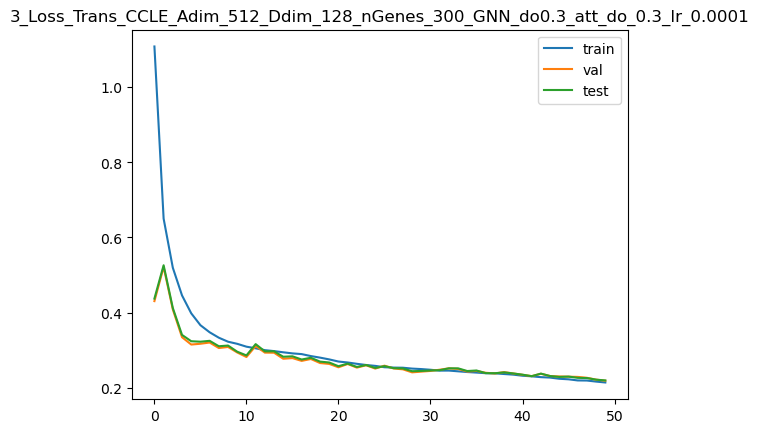

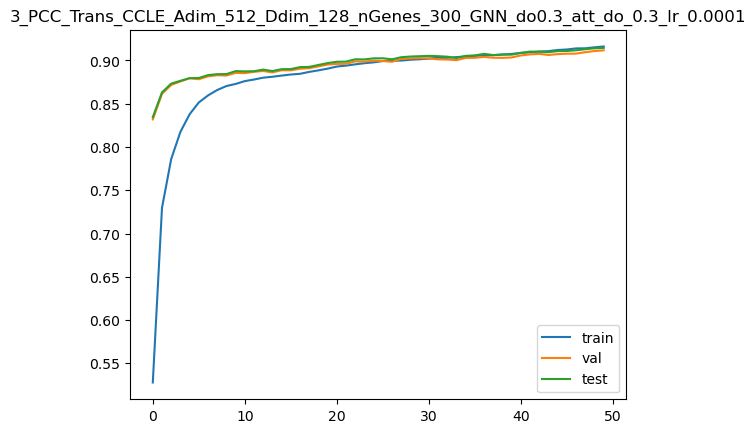

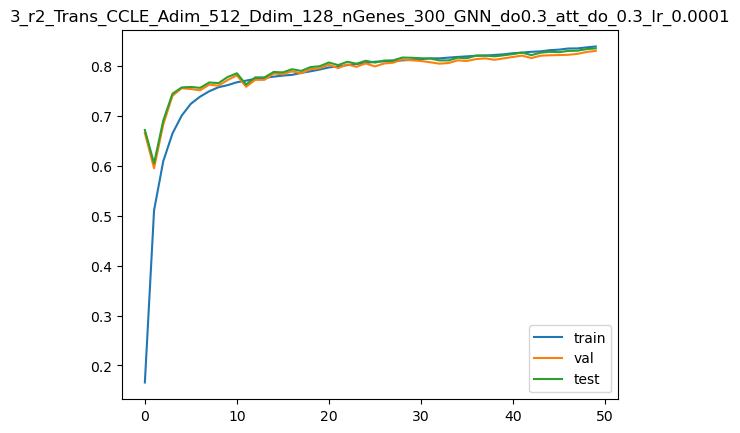

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1695607453584671
The overall Pearson's correlation is 0.9447.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24024483561515808
The overall Pearson's correlation is 0.8819.
Train avg_loss:  0.21273123
Train avg_pcc:  0.9165021171914942
Train r2:  0.8399674504070602


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22298901
Validation avg_pcc:  0.9104466848413267
Validation r2:  0.8268380616128961


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22230546
Test avg_pcc:  0.9136989308267535
Test r2:  0.8331529826191639
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18421269953250885
The overall Pearson's correlation is 0.8967.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22805801033973694
The overall Pearson's correlation is 0.9180.
Train avg_loss:  0.20950842
Train avg_pcc:  0.9178238041554245
Train r2:  0.8423918984074135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22101855
Validation avg_pcc:  0.9117630654529173
Validation r2:  0.8283682034931401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22000843
Test avg_pcc:  0.9150398393591573
Test r2:  0.8348769820125378
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19165447354316711
The overall Pearson's correlation is 0.9337.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19911763072013855
The overall Pearson's correlation is 0.9306.
Train avg_loss:  0.2075639
Train avg_pcc:  0.9186200820192552
Train r2:  0.8438546950597077


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21745326
Validation avg_pcc:  0.9117812022490344
Validation r2:  0.8311368282590614
Best Val r2  0.8311368282590614


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21609914
Test avg_pcc:  0.9154978451142681
Test r2:  0.8378110190733761
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3102913796901703
The overall Pearson's correlation is 0.9055.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1663469821214676
The overall Pearson's correlation is 0.8978.
Train avg_loss:  0.20465833
Train avg_pcc:  0.919808370564486
Train r2:  0.8460404949814404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2156369
Validation avg_pcc:  0.9131412425863925
Validation r2:  0.8325473162669673
Best Val r2  0.8325473162669673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21505924
Test avg_pcc:  0.9164056625224944
Test r2:  0.8385915104038306
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21524320542812347
The overall Pearson's correlation is 0.9358.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17168664932250977
The overall Pearson's correlation is 0.9173.
Train avg_loss:  0.20254909
Train avg_pcc:  0.9206714924466982
Train r2:  0.8476272280632837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22032781
Validation avg_pcc:  0.9133672737353536
Validation r2:  0.8289045946159774


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21943763
Test avg_pcc:  0.9164581148958326
Test r2:  0.8353053785638924
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13602331280708313
The overall Pearson's correlation is 0.9406.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2561301589012146
The overall Pearson's correlation is 0.9006.
Train avg_loss:  0.20240319
Train avg_pcc:  0.9207308277063584
Train r2:  0.847736975892626


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21835078
Validation avg_pcc:  0.9139439473208634
Validation r2:  0.8304398681050628


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21633881
Test avg_pcc:  0.9174649483153942
Test r2:  0.8376311361063307
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18899321556091309
The overall Pearson's correlation is 0.9350.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1603500097990036
The overall Pearson's correlation is 0.9503.
Train avg_loss:  0.19984896
Train avg_pcc:  0.921773873278374
Train r2:  0.8496584619597887


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21393518
Validation avg_pcc:  0.9138954363757874
Validation r2:  0.8338687921007154
Best Val r2  0.8338687921007154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21204703
Test avg_pcc:  0.917429752177823
Test r2:  0.840852259318809
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14476509392261505
The overall Pearson's correlation is 0.9264.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.33124449849128723
The overall Pearson's correlation is 0.8930.
Train avg_loss:  0.19929104
Train avg_pcc:  0.9220013124156923
Train r2:  0.8500781755071153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21163699
Validation avg_pcc:  0.9149647916371092
Validation r2:  0.8356534578944033
Best Val r2  0.8356534578944033


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21080795
Test avg_pcc:  0.9180608312947153
Test r2:  0.8417822321119548
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29854434728622437
The overall Pearson's correlation is 0.8776.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13484720885753632
The overall Pearson's correlation is 0.9444.
Train avg_loss:  0.19594835
Train avg_pcc:  0.9233636863654204
Train r2:  0.8525928124672907


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20634346
Validation avg_pcc:  0.9164304484882287
Validation r2:  0.8397641328382852
Best Val r2  0.8397641328382852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20537359
Test avg_pcc:  0.9197650646461025
Test r2:  0.845860878445238
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12632779777050018
The overall Pearson's correlation is 0.9509.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1777404248714447
The overall Pearson's correlation is 0.9284.
Train avg_loss:  0.19387817
Train avg_pcc:  0.9242059312832521
Train r2:  0.8541501449598031


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2082485
Validation avg_pcc:  0.9162559883896517
Validation r2:  0.8382847817499268


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2075676
Test avg_pcc:  0.9193464452123165
Test r2:  0.8442142115592521
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11638396978378296
The overall Pearson's correlation is 0.9402.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1788572072982788
The overall Pearson's correlation is 0.9017.
Train avg_loss:  0.19362518
Train avg_pcc:  0.9243098152242946
Train r2:  0.8543404676566738


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20576401
Validation avg_pcc:  0.9167503583890191
Validation r2:  0.8402141178675991
Best Val r2  0.8402141178675991


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20766965
Test avg_pcc:  0.9190062012674074
Test r2:  0.8441376173025612
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21667934954166412
The overall Pearson's correlation is 0.9136.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2531076669692993
The overall Pearson's correlation is 0.9031.
Train avg_loss:  0.19076885
Train avg_pcc:  0.9254710957792609
Train r2:  0.8564892119326929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20893298
Validation avg_pcc:  0.9169241577963824
Validation r2:  0.8377532426360303


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20889755
Test avg_pcc:  0.9199631931833474
Test r2:  0.8432160395751834
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16174843907356262
The overall Pearson's correlation is 0.8741.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1506819725036621
The overall Pearson's correlation is 0.9392.
Train avg_loss:  0.18981613
Train avg_pcc:  0.9258582975857778
Train r2:  0.8572059227144629


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20651771
Validation avg_pcc:  0.9182842307905376
Validation r2:  0.8396288215648267


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20667443
Test avg_pcc:  0.9211350276615297
Test r2:  0.8448845462516062
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15602853894233704
The overall Pearson's correlation is 0.9530.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13729442656040192
The overall Pearson's correlation is 0.9436.
Train avg_loss:  0.1873796
Train avg_pcc:  0.9268476717405507
Train r2:  0.8590388731590142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2066482
Validation avg_pcc:  0.91848753405292
Validation r2:  0.8395274948958543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20764555
Test avg_pcc:  0.9210090662777964
Test r2:  0.8441556987406
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3051280081272125
The overall Pearson's correlation is 0.9033.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14982695877552032
The overall Pearson's correlation is 0.9328.
Train avg_loss:  0.18591157
Train avg_pcc:  0.9274425527257303
Train r2:  0.8601432260496125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2028136
Validation avg_pcc:  0.9193290600670196
Validation r2:  0.8425052621120941
Best Val r2  0.8425052621120941


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20171666
Test avg_pcc:  0.9225566618552605
Test r2:  0.8486055088360254
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15158389508724213
The overall Pearson's correlation is 0.9303.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19871585071086884
The overall Pearson's correlation is 0.9384.
Train avg_loss:  0.18396856
Train avg_pcc:  0.9282299440077261
Train r2:  0.861604902682778


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19950053
Validation avg_pcc:  0.9206853568030668
Validation r2:  0.8450780176125328
Best Val r2  0.8450780176125328


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20029926
Test avg_pcc:  0.9230497025818735
Test r2:  0.8496693152119827
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19891324639320374
The overall Pearson's correlation is 0.9183.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17898604273796082
The overall Pearson's correlation is 0.9310.
Train avg_loss:  0.18315524
Train avg_pcc:  0.9285603718421196
Train r2:  0.8622167485662384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19974692
Validation avg_pcc:  0.9196054539302577
Validation r2:  0.8448866674297465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19938803
Test avg_pcc:  0.9225701154984592
Test r2:  0.8503532289313243
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17065972089767456
The overall Pearson's correlation is 0.9139.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3012024164199829
The overall Pearson's correlation is 0.9150.
Train avg_loss:  0.18087365
Train avg_pcc:  0.9294832756423022
Train r2:  0.8639331457299836


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20521764
Validation avg_pcc:  0.9204121450921747
Validation r2:  0.8406383834247056


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2049874
Test avg_pcc:  0.9231860046480262
Test r2:  0.846150716364051
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22921332716941833
The overall Pearson's correlation is 0.8971.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23840570449829102
The overall Pearson's correlation is 0.9038.
Train avg_loss:  0.17860073
Train avg_pcc:  0.9304033418634119
Train r2:  0.8656429866162627


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19950746
Validation avg_pcc:  0.921147044741481
Validation r2:  0.8450726313616685


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19924437
Test avg_pcc:  0.9240154563849013
Test r2:  0.8504610419230632
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2008102387189865
The overall Pearson's correlation is 0.9181.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19675536453723907
The overall Pearson's correlation is 0.9091.
Train avg_loss:  0.17906216
Train avg_pcc:  0.9302166562767349
Train r2:  0.8652958724013433


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2000261
Validation avg_pcc:  0.9208630092239268
Validation r2:  0.8446698749716764


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19939698
Test avg_pcc:  0.9236662474103386
Test r2:  0.850346497702157
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1356302797794342
The overall Pearson's correlation is 0.9366.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2069883942604065
The overall Pearson's correlation is 0.9302.
Train avg_loss:  0.17689525
Train avg_pcc:  0.9310924780613188
Train r2:  0.8669259979610509


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19979009
Validation avg_pcc:  0.9212809940990656
Validation r2:  0.8448531436148174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19841881
Test avg_pcc:  0.9246693198832664
Test r2:  0.8510806612941366
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10898364335298538
The overall Pearson's correlation is 0.9704.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16916018724441528
The overall Pearson's correlation is 0.9484.
Train avg_loss:  0.17647187
Train avg_pcc:  0.9312621033392385
Train r2:  0.8672444816994798


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19561528
Validation avg_pcc:  0.9217612006518761
Validation r2:  0.8480950993547333
Best Val r2  0.8480950993547333


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19580705
Test avg_pcc:  0.9242756160760224
Test r2:  0.8530408578550948
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21012620627880096
The overall Pearson's correlation is 0.9057.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1610095202922821
The overall Pearson's correlation is 0.9383.
Train avg_loss:  0.17423743
Train avg_pcc:  0.9321663770232295
Train r2:  0.8689254133250858


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19276433
Validation avg_pcc:  0.9221677210599248
Validation r2:  0.8503089990673713
Best Val r2  0.8503089990673713


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19187944
Test avg_pcc:  0.9253261419855296
Test r2:  0.8559886469513855
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17678621411323547
The overall Pearson's correlation is 0.9370.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14518506824970245
The overall Pearson's correlation is 0.9150.
Train avg_loss:  0.17260873
Train avg_pcc:  0.9328214964661574
Train r2:  0.8701506273531081


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19861992
Validation avg_pcc:  0.9216425673567631
Validation r2:  0.8457618433417662


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19703153
Test avg_pcc:  0.9248940626034562
Test r2:  0.8521218296145479
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14385035634040833
The overall Pearson's correlation is 0.9319.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18646323680877686
The overall Pearson's correlation is 0.9219.
Train avg_loss:  0.17245495
Train avg_pcc:  0.9328851750447932
Train r2:  0.8702663151321414


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.195221
Validation avg_pcc:  0.921710017259384
Validation r2:  0.8484012709776789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19418077
Test avg_pcc:  0.9248760718609897
Test r2:  0.8542614346084446
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19031685590744019
The overall Pearson's correlation is 0.9234.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14936208724975586
The overall Pearson's correlation is 0.9282.
Train avg_loss:  0.17053898
Train avg_pcc:  0.9336559087344694
Train r2:  0.8717076582674208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19614342
Validation avg_pcc:  0.9226549957061567
Validation r2:  0.847684980545084


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19579521
Test avg_pcc:  0.9254149297186511
Test r2:  0.8530497370293693
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22742724418640137
The overall Pearson's correlation is 0.9108.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17150135338306427
The overall Pearson's correlation is 0.9342.
Train avg_loss:  0.1690012
Train avg_pcc:  0.934275798651748
Train r2:  0.8728644742928051


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19258042
Validation avg_pcc:  0.9226947804951058
Validation r2:  0.8504518122384228
Best Val r2  0.8504518122384228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19227844
Test avg_pcc:  0.925568505888631
Test r2:  0.8556891782411153
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15819862484931946
The overall Pearson's correlation is 0.9383.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13590030372142792
The overall Pearson's correlation is 0.9377.
Train avg_loss:  0.16871856
Train avg_pcc:  0.9343887646196104
Train r2:  0.8730771075464583


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19446236
Validation avg_pcc:  0.9216886361847092
Validation r2:  0.8489904007525227


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19226791
Test avg_pcc:  0.9253149890640686
Test r2:  0.8556970841897411
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20513394474983215
The overall Pearson's correlation is 0.9034.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.28395748138427734
The overall Pearson's correlation is 0.9237.
Train avg_loss:  0.16820283
Train avg_pcc:  0.9345968919871013
Train r2:  0.8734650842209307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19305238
Validation avg_pcc:  0.922769883880879
Validation r2:  0.8500853133788036


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19108997
Test avg_pcc:  0.926318101370327
Test r2:  0.8565811687262581
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25651633739471436
The overall Pearson's correlation is 0.9191.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15812140703201294
The overall Pearson's correlation is 0.9493.
Train avg_loss:  0.1663806
Train avg_pcc:  0.9353296069993138
Train r2:  0.8748358923884825


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19292857
Validation avg_pcc:  0.9220728693964206
Validation r2:  0.8501814764080637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19112024
Test avg_pcc:  0.9255285940575493
Test r2:  0.8565584434355313
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.197096586227417
The overall Pearson's correlation is 0.9529.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20644371211528778
The overall Pearson's correlation is 0.8769.
Train avg_loss:  0.16527261
Train avg_pcc:  0.9357757673817054
Train r2:  0.8756694135994568


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19558822
Validation avg_pcc:  0.9230394337509183
Validation r2:  0.8481161191280411


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1946227
Test avg_pcc:  0.9260906741494577
Test r2:  0.8539297554959981
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12339387834072113
The overall Pearson's correlation is 0.9507.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14779287576675415
The overall Pearson's correlation is 0.9438.
Train avg_loss:  0.16386089
Train avg_pcc:  0.9363421474247174
Train r2:  0.8767314264191606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18709862
Validation avg_pcc:  0.9247315422452023
Validation r2:  0.854708689232667
Best Val r2  0.854708689232667


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18576176
Test avg_pcc:  0.9277796171558159
Test r2:  0.8605801520436426
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14503918588161469
The overall Pearson's correlation is 0.9466.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13509833812713623
The overall Pearson's correlation is 0.9475.
Train avg_loss:  0.16244696
Train avg_pcc:  0.9369118901340916
Train r2:  0.8777950898411317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18840735
Validation avg_pcc:  0.9245152340779862
Validation r2:  0.8536924114116704


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18913713
Test avg_pcc:  0.9270004209166283
Test r2:  0.8580468274174045
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19263608753681183
The overall Pearson's correlation is 0.9042.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25212597846984863
The overall Pearson's correlation is 0.8955.
Train avg_loss:  0.16155635
Train avg_pcc:  0.9372676708469435
Train r2:  0.8784650729069562


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18805246
Validation avg_pcc:  0.9247141071245182
Validation r2:  0.8539679950665877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18652593
Test avg_pcc:  0.9281641975879671
Test r2:  0.8600066123008399
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1405961811542511
The overall Pearson's correlation is 0.9458.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19795602560043335
The overall Pearson's correlation is 0.9257.
Train avg_loss:  0.16254304
Train avg_pcc:  0.9368718510855243
Train r2:  0.8777228135330318


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18985198
Validation avg_pcc:  0.9248123062150834
Validation r2:  0.8525705891495166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18830863
Test avg_pcc:  0.9282636080975895
Test r2:  0.8586686390731219
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20748592913150787
The overall Pearson's correlation is 0.9306.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16975852847099304
The overall Pearson's correlation is 0.9149.
Train avg_loss:  0.16038227
Train avg_pcc:  0.9377388172633746
Train r2:  0.8793482953175673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18664673
Validation avg_pcc:  0.9248460467508433
Validation r2:  0.855059610538178
Best Val r2  0.855059610538178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18541732
Test avg_pcc:  0.9278622980915442
Test r2:  0.8608386714119453
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18954353034496307
The overall Pearson's correlation is 0.9622.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14252611994743347
The overall Pearson's correlation is 0.9158.
Train avg_loss:  0.15959132
Train avg_pcc:  0.9380562221085778
Train r2:  0.8799433214041674


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18791379
Validation avg_pcc:  0.9255376693806685
Validation r2:  0.8540756882147102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18609409
Test avg_pcc:  0.928900160377663
Test r2:  0.8603307379606697
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14416491985321045
The overall Pearson's correlation is 0.9541.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18751904368400574
The overall Pearson's correlation is 0.9333.
Train avg_loss:  0.1582445
Train avg_pcc:  0.9385957580470186
Train r2:  0.8809564867425206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19044034
Validation avg_pcc:  0.9253511855927593
Validation r2:  0.852113706047962


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18869726
Test avg_pcc:  0.9283485590641539
Test r2:  0.8583769513717563
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13045912981033325
The overall Pearson's correlation is 0.9504.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21840301156044006
The overall Pearson's correlation is 0.9295.
Train avg_loss:  0.157643
Train avg_pcc:  0.9388371228451481
Train r2:  0.8814089908825908


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18664232
Validation avg_pcc:  0.9252820533120107
Validation r2:  0.8550630356561437
Best Val r2  0.8550630356561437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18791394
Test avg_pcc:  0.9275179413399829
Test r2:  0.8589648512944912
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11235184967517853
The overall Pearson's correlation is 0.9587.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1834792196750641
The overall Pearson's correlation is 0.9368.
Train avg_loss:  0.15584238
Train avg_pcc:  0.9395574041769966
Train r2:  0.8827635577646867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1863634
Validation avg_pcc:  0.926334420485972
Validation r2:  0.8552796307092116
Best Val r2  0.8552796307092116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18549825
Test avg_pcc:  0.9291328039588468
Test r2:  0.8607779132180903
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11786042898893356
The overall Pearson's correlation is 0.9644.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16381236910820007
The overall Pearson's correlation is 0.9565.
Train avg_loss:  0.1552885
Train avg_pcc:  0.9397800360276508
Train r2:  0.8831802177465855


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1841796
Validation avg_pcc:  0.9260221255314488
Validation r2:  0.8569754646015553
Best Val r2  0.8569754646015553


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18375607
Test avg_pcc:  0.9289234290949633
Test r2:  0.8620854808477074
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13738365471363068
The overall Pearson's correlation is 0.9489.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15084713697433472
The overall Pearson's correlation is 0.9509.
Train avg_loss:  0.15494002
Train avg_pcc:  0.9399190319020736
Train r2:  0.8834423765056035


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18883654
Validation avg_pcc:  0.9258846407333394
Validation r2:  0.8533591291914528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18828161
Test avg_pcc:  0.9285082185396694
Test r2:  0.8586889137717337
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13096797466278076
The overall Pearson's correlation is 0.9593.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13652630150318146
The overall Pearson's correlation is 0.9544.
Train avg_loss:  0.15440908
Train avg_pcc:  0.940133326528297
Train r2:  0.8838417927068889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1854373
Validation avg_pcc:  0.9264343238321715
Validation r2:  0.8559987918675758


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18574223
Test avg_pcc:  0.9290685903378177
Test r2:  0.8605948033414792
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16071796417236328
The overall Pearson's correlation is 0.9184.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15245279669761658
The overall Pearson's correlation is 0.8849.
Train avg_loss:  0.15324159
Train avg_pcc:  0.9405982479530778
Train r2:  0.8847200568840711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18469758
Validation avg_pcc:  0.9271757503005557
Validation r2:  0.8565732292694997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18397424
Test avg_pcc:  0.9298915956265761
Test r2:  0.8619217309952769
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1876063346862793
The overall Pearson's correlation is 0.9439.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15237832069396973
The overall Pearson's correlation is 0.9492.
Train avg_loss:  0.15156105
Train avg_pcc:  0.9412699235296359
Train r2:  0.8859842915815115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18440424
Validation avg_pcc:  0.9267804029018359
Validation r2:  0.8568010123993598


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18367231
Test avg_pcc:  0.9295433660756212
Test r2:  0.8621483414599393
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09886829555034637
The overall Pearson's correlation is 0.9649.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1507120132446289
The overall Pearson's correlation is 0.9563.
Train avg_loss:  0.15084296
Train avg_pcc:  0.941556903839631
Train r2:  0.8865244993929049


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18381685
Validation avg_pcc:  0.9260048034066128
Validation r2:  0.8572571633616058
Best Val r2  0.8572571633616058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18083583
Test avg_pcc:  0.92975706340586
Test r2:  0.8642772074027998
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11588215082883835
The overall Pearson's correlation is 0.9404.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12277032434940338
The overall Pearson's correlation is 0.9518.
Train avg_loss:  0.15054785
Train avg_pcc:  0.9416755274000388
Train r2:  0.8867465077874119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18347514
Validation avg_pcc:  0.9268551923717538
Validation r2:  0.8575225373029929
Best Val r2  0.8575225373029929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18268631
Test avg_pcc:  0.929704879067654
Test r2:  0.8628883635462061
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14548742771148682
The overall Pearson's correlation is 0.9495.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19771930575370789
The overall Pearson's correlation is 0.9347.
Train avg_loss:  0.15026005
Train avg_pcc:  0.9417907874666175
Train r2:  0.886963015107779


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18334623
Validation avg_pcc:  0.9275404675064981
Validation r2:  0.8576226237665697
Best Val r2  0.8576226237665697


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18345772
Test avg_pcc:  0.930147737239832
Test r2:  0.8623093907293188
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11770536750555038
The overall Pearson's correlation is 0.9412.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1415071040391922
The overall Pearson's correlation is 0.9566.
Train avg_loss:  0.1496425
Train avg_pcc:  0.9420362080332028
Train r2:  0.8874275760303376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18357582
Validation avg_pcc:  0.9264274003131296
Validation r2:  0.8574443279605632


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1829995
Test avg_pcc:  0.9291912369969122
Test r2:  0.8626532857519862
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14452606439590454
The overall Pearson's correlation is 0.9587.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12255290895700455
The overall Pearson's correlation is 0.9595.
Train avg_loss:  0.14851305
Train avg_pcc:  0.9424874400924624
Train r2:  0.8882772431805662


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1813786
Validation avg_pcc:  0.9276101171350554
Validation r2:  0.859150572685776
Best Val r2  0.859150572685776


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17978285
Test avg_pcc:  0.9307514116281378
Test r2:  0.8650675026332734


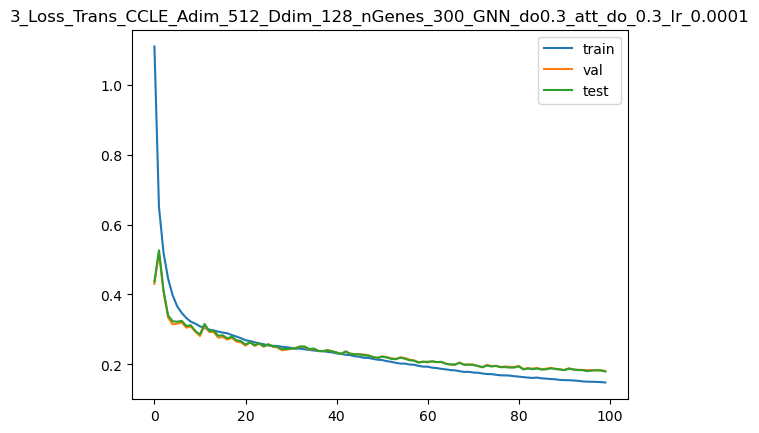

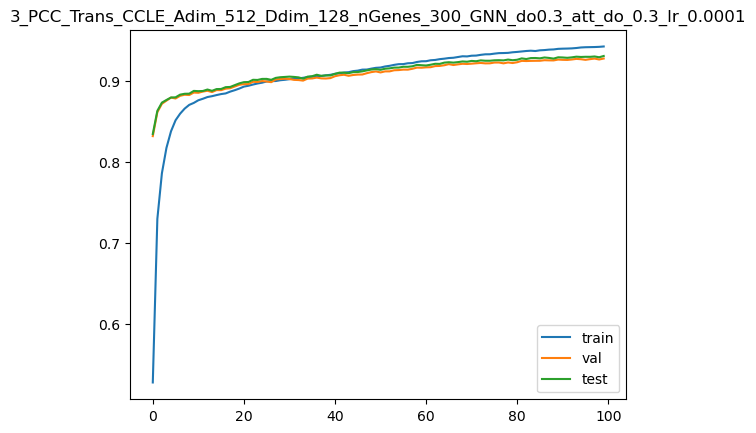

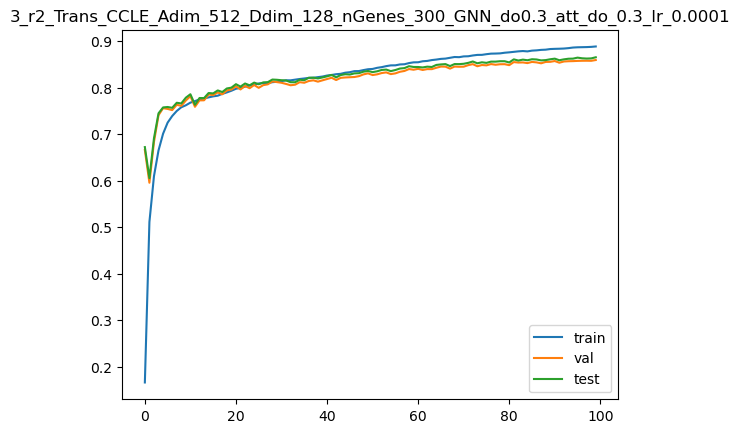

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1315389722585678
The overall Pearson's correlation is 0.9520.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11825042963027954
The overall Pearson's correlation is 0.9615.
Train avg_loss:  0.1480893
Train avg_pcc:  0.942656432875804
Train r2:  0.888595993376124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1788459
Validation avg_pcc:  0.9280391746293154
Validation r2:  0.8611173441379725
Best Val r2  0.8611173441379725


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17847295
Test avg_pcc:  0.9306465859774004
Test r2:  0.8660506228257296
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1173088550567627
The overall Pearson's correlation is 0.9603.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07921849191188812
The overall Pearson's correlation is 0.9741.
Train avg_loss:  0.14570665
Train avg_pcc:  0.9436065194768832
Train r2:  0.8903884089878779


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18233967
Validation avg_pcc:  0.9270936181522061
Validation r2:  0.8584042552823387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18156698
Test avg_pcc:  0.9299094086682435
Test r2:  0.8637284436778603
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14575554430484772
The overall Pearson's correlation is 0.9553.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11913590133190155
The overall Pearson's correlation is 0.9472.
Train avg_loss:  0.14647195
Train avg_pcc:  0.9433021766461398
Train r2:  0.8898126872376747


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18377751
Validation avg_pcc:  0.9267618139229808
Validation r2:  0.8572877136932576


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18410349
Test avg_pcc:  0.9291768731419899
Test r2:  0.8618247339683942
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11423894762992859
The overall Pearson's correlation is 0.9355.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15360486507415771
The overall Pearson's correlation is 0.9323.
Train avg_loss:  0.14596598
Train avg_pcc:  0.9435031491405605
Train r2:  0.8901933167462494


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1781516
Validation avg_pcc:  0.9287095497458159
Validation r2:  0.8616565059270241
Best Val r2  0.8616565059270241


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1764131
Test avg_pcc:  0.931896688361207
Test r2:  0.8675965990774468
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1079634353518486
The overall Pearson's correlation is 0.9704.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.131919726729393
The overall Pearson's correlation is 0.9527.
Train avg_loss:  0.14477883
Train avg_pcc:  0.9439764166152935
Train r2:  0.8910863874296482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18155563
Validation avg_pcc:  0.9271783800674641
Validation r2:  0.8590131154101046


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1776667
Test avg_pcc:  0.931152388289933
Test r2:  0.8666557452470334
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1357399821281433
The overall Pearson's correlation is 0.9338.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11008459329605103
The overall Pearson's correlation is 0.9593.
Train avg_loss:  0.14375167
Train avg_pcc:  0.9443857470151453
Train r2:  0.8918591029220954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1804717
Validation avg_pcc:  0.9282330414142976
Validation r2:  0.8598548264729711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17879255
Test avg_pcc:  0.9312715100794214
Test r2:  0.8658107553495333
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16985923051834106
The overall Pearson's correlation is 0.9225.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15625572204589844
The overall Pearson's correlation is 0.9554.
Train avg_loss:  0.14276549
Train avg_pcc:  0.9447786109227351
Train r2:  0.8926009832701453


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17883968
Validation avg_pcc:  0.9289124259719755
Validation r2:  0.8611221866957911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1771281
Test avg_pcc:  0.9320812282798191
Test r2:  0.8670599603127003
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1825779676437378
The overall Pearson's correlation is 0.8924.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17421448230743408
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.14360395
Train avg_pcc:  0.9444453586567906
Train r2:  0.8919702229147844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18847066
Validation avg_pcc:  0.9287206232647434
Validation r2:  0.8536432524384701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18699254
Test avg_pcc:  0.9315816299984218
Test r2:  0.8596564131680249
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22791507840156555
The overall Pearson's correlation is 0.9243.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13869677484035492
The overall Pearson's correlation is 0.9616.
Train avg_loss:  0.14199662
Train avg_pcc:  0.9450845143879146
Train r2:  0.8931793774947727


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17667606
Validation avg_pcc:  0.9292204803338179
Validation r2:  0.8628023221287637
Best Val r2  0.8628023221287637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17633113
Test avg_pcc:  0.9317022056193619
Test r2:  0.8676581120918844
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17423665523529053
The overall Pearson's correlation is 0.9103.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17221882939338684
The overall Pearson's correlation is 0.9330.
Train avg_loss:  0.14098002
Train avg_pcc:  0.9454892570366757
Train r2:  0.8939441560051085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17927639
Validation avg_pcc:  0.9284236638757469
Validation r2:  0.8607830471733845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17786902
Test avg_pcc:  0.931396930928401
Test r2:  0.8665038876191488
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17147092521190643
The overall Pearson's correlation is 0.9579.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.099824920296669
The overall Pearson's correlation is 0.9613.
Train avg_loss:  0.14105515
Train avg_pcc:  0.9454593587189114
Train r2:  0.8938876192962487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17776322
Validation avg_pcc:  0.9291079529662388
Validation r2:  0.8619581010741146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17664085
Test avg_pcc:  0.9321825668810199
Test r2:  0.8674256575450109
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15248903632164001
The overall Pearson's correlation is 0.9474.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11344373226165771
The overall Pearson's correlation is 0.9572.
Train avg_loss:  0.14013098
Train avg_pcc:  0.9458259539216421
Train r2:  0.8945828610801346


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1784825
Validation avg_pcc:  0.9294307719491638
Validation r2:  0.8613995348349573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17720771
Test avg_pcc:  0.9322887551512051
Test r2:  0.8670002245331364
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12747842073440552
The overall Pearson's correlation is 0.9544.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1159658133983612
The overall Pearson's correlation is 0.9521.
Train avg_loss:  0.13955712
Train avg_pcc:  0.9460552419972378
Train r2:  0.8950145570030053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17824493
Validation avg_pcc:  0.9286841901332559
Validation r2:  0.8615840283250328


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17674835
Test avg_pcc:  0.9316513877446908
Test r2:  0.8673449856760893
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16086047887802124
The overall Pearson's correlation is 0.9378.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1311999261379242
The overall Pearson's correlation is 0.9501.
Train avg_loss:  0.1375273
Train avg_pcc:  0.9468610814716194
Train r2:  0.8965415433766839


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17467718
Validation avg_pcc:  0.9298044587952183
Validation r2:  0.8643545803412895
Best Val r2  0.8643545803412895


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17438284
Test avg_pcc:  0.9323942099979199
Test r2:  0.869120374294649
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15991365909576416
The overall Pearson's correlation is 0.9134.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11636833101511002
The overall Pearson's correlation is 0.9617.
Train avg_loss:  0.13685225
Train avg_pcc:  0.9471300678566186
Train r2:  0.8970493635816136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17995317
Validation avg_pcc:  0.9285291436806733
Validation r2:  0.8602574923737509


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1787832
Test avg_pcc:  0.9315322270326104
Test r2:  0.865817776151806
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11453363299369812
The overall Pearson's correlation is 0.9511.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12603561580181122
The overall Pearson's correlation is 0.9605.
Train avg_loss:  0.1367883
Train avg_pcc:  0.9471554247328761
Train r2:  0.8970974661784886


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17601544
Validation avg_pcc:  0.9292055749765178
Validation r2:  0.8633153418299819


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1746794
Test avg_pcc:  0.932258015178952
Test r2:  0.8688977983494737
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1586705446243286
The overall Pearson's correlation is 0.9581.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13373985886573792
The overall Pearson's correlation is 0.9315.
Train avg_loss:  0.13629149
Train avg_pcc:  0.9473517025432417
Train r2:  0.8974712145930507


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17560607
Validation avg_pcc:  0.9295423090615189
Validation r2:  0.8636332276208942


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17409202
Test avg_pcc:  0.932560606616277
Test r2:  0.8693386443141222
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19664224982261658
The overall Pearson's correlation is 0.9463.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1478210985660553
The overall Pearson's correlation is 0.9515.
Train avg_loss:  0.13604559
Train avg_pcc:  0.947450287683895
Train r2:  0.8976561939571763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17717464
Validation avg_pcc:  0.9297521165896382
Validation r2:  0.8624151575266741


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1761253
Test avg_pcc:  0.9327063828161556
Test r2:  0.8678125952326909
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15288344025611877
The overall Pearson's correlation is 0.9496.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11402478814125061
The overall Pearson's correlation is 0.9393.
Train avg_loss:  0.1360285
Train avg_pcc:  0.9474561022677187
Train r2:  0.8976690534218096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17535628
Validation avg_pcc:  0.9295234175849502
Validation r2:  0.8638272129656313


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17322566
Test avg_pcc:  0.9328436538167377
Test r2:  0.8699888689842517
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13002309203147888
The overall Pearson's correlation is 0.9471.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11884796619415283
The overall Pearson's correlation is 0.9613.
Train avg_loss:  0.13455445
Train avg_pcc:  0.9480417902466672
Train r2:  0.898777954180922


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17471418
Validation avg_pcc:  0.9302784967181932
Validation r2:  0.8643258283844468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1734056
Test avg_pcc:  0.9332442922265629
Test r2:  0.8698538201891307
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10047470778226852
The overall Pearson's correlation is 0.9449.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14668458700180054
The overall Pearson's correlation is 0.9535.
Train avg_loss:  0.13405168
Train avg_pcc:  0.9482407779799197
Train r2:  0.8991561619079972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17276882
Validation avg_pcc:  0.9309708495065511
Validation r2:  0.8658365050492619
Best Val r2  0.8658365050492619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17259586
Test avg_pcc:  0.9334816636090028
Test r2:  0.870461554831861
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1677890419960022
The overall Pearson's correlation is 0.9500.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14356210827827454
The overall Pearson's correlation is 0.9273.
Train avg_loss:  0.13422252
Train avg_pcc:  0.9481739454646488
Train r2:  0.8990276412665976


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1761218
Validation avg_pcc:  0.9297763936173654
Validation r2:  0.8632327433049547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17552295
Test avg_pcc:  0.9326897773509879
Test r2:  0.8682646777144436
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18112170696258545
The overall Pearson's correlation is 0.9303.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1612003594636917
The overall Pearson's correlation is 0.9202.
Train avg_loss:  0.13327375
Train avg_pcc:  0.9485492270121025
Train r2:  0.8997413759503398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17555836
Validation avg_pcc:  0.9300810617148056
Validation r2:  0.8636702907203744


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17405683
Test avg_pcc:  0.93305890211856
Test r2:  0.8693650560650934
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17435970902442932
The overall Pearson's correlation is 0.9409.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1127384752035141
The overall Pearson's correlation is 0.9661.
Train avg_loss:  0.1316361
Train avg_pcc:  0.9491991399443955
Train r2:  0.9009733545851077


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17592928
Validation avg_pcc:  0.9304357310517946
Validation r2:  0.8633822484506978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17400211
Test avg_pcc:  0.9335555029311905
Test r2:  0.8694061287715744
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1536586880683899
The overall Pearson's correlation is 0.9411.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1396808922290802
The overall Pearson's correlation is 0.9360.
Train avg_loss:  0.13141279
Train avg_pcc:  0.9492876520990602
Train r2:  0.9011413566917296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17123891
Validation avg_pcc:  0.9315014903476175
Validation r2:  0.8670245526559744
Best Val r2  0.8670245526559744


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.171098
Test avg_pcc:  0.9341062058712961
Test r2:  0.8715857449303299
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25199854373931885
The overall Pearson's correlation is 0.8978.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1101822480559349
The overall Pearson's correlation is 0.9583.
Train avg_loss:  0.13043255
Train avg_pcc:  0.9496753960810478
Train r2:  0.9018787510199499


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17357324
Validation avg_pcc:  0.9303846353835764
Validation r2:  0.865211835611394


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17200685
Test avg_pcc:  0.933575043695439
Test r2:  0.8709036235873486
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13745175302028656
The overall Pearson's correlation is 0.9497.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13725319504737854
The overall Pearson's correlation is 0.9397.
Train avg_loss:  0.13147843
Train avg_pcc:  0.9492611999319214
Train r2:  0.9010919567071195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17561743
Validation avg_pcc:  0.9299827323108868
Validation r2:  0.8636244142783094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17444734
Test avg_pcc:  0.932762984248489
Test r2:  0.8690719511155139
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16260643303394318
The overall Pearson's correlation is 0.9507.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1317695826292038
The overall Pearson's correlation is 0.9560.
Train avg_loss:  0.12976518
Train avg_pcc:  0.9499398508064341
Train r2:  0.9023807949147213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17797126
Validation avg_pcc:  0.930250238178314
Validation r2:  0.8617965508069985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17727402
Test avg_pcc:  0.9329007182512711
Test r2:  0.8669504567782769
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14382404088974
The overall Pearson's correlation is 0.9540.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21764825284481049
The overall Pearson's correlation is 0.9036.
Train avg_loss:  0.12853315
Train avg_pcc:  0.9504269013952664
Train r2:  0.9033076241928396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17205533
Validation avg_pcc:  0.9308662330347813
Validation r2:  0.8663905658278752


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17190155
Test avg_pcc:  0.9332879990296364
Test r2:  0.8709826531377298
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1199059709906578
The overall Pearson's correlation is 0.9552.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12069079279899597
The overall Pearson's correlation is 0.9485.
Train avg_loss:  0.13010514
Train avg_pcc:  0.9498056637638721
Train r2:  0.9021250504791964


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17574574
Validation avg_pcc:  0.9309890269647485
Validation r2:  0.8635247701976881


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17544635
Test avg_pcc:  0.9339283413392578
Test r2:  0.8683221848306576
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12363731116056442
The overall Pearson's correlation is 0.9571.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09330688416957855
The overall Pearson's correlation is 0.9678.
Train avg_loss:  0.12878332
Train avg_pcc:  0.9503287455493795
Train r2:  0.9031194292067356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17454319
Validation avg_pcc:  0.9310533597982447
Validation r2:  0.8644586094903012


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17295799
Test avg_pcc:  0.9340699823587533
Test r2:  0.8701897627730146
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1341749131679535
The overall Pearson's correlation is 0.9453.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1009315699338913
The overall Pearson's correlation is 0.9600.
Train avg_loss:  0.12839815
Train avg_pcc:  0.9504806520179369
Train r2:  0.9034091901221692


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17363068
Validation avg_pcc:  0.9312083114310217
Validation r2:  0.8651672243526691


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17322841
Test avg_pcc:  0.9337574402735835
Test r2:  0.8699868096849807
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12516310811042786
The overall Pearson's correlation is 0.9533.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10343258082866669
The overall Pearson's correlation is 0.9746.
Train avg_loss:  0.12713692
Train avg_pcc:  0.9509798612130298
Train r2:  0.9043579728076472


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17450196
Validation avg_pcc:  0.9321277558364779
Validation r2:  0.8644906318787884


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17480002
Test avg_pcc:  0.9343036827871837
Test r2:  0.8688072679033533
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08119446039199829
The overall Pearson's correlation is 0.9755.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09150831401348114
The overall Pearson's correlation is 0.9591.
Train avg_loss:  0.12714225
Train avg_pcc:  0.950977878596521
Train r2:  0.9043539681053957


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17188601
Validation avg_pcc:  0.9310870943152844
Validation r2:  0.8665220377383163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17053597
Test avg_pcc:  0.9340861058191681
Test r2:  0.8720075633157821
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09457491338253021
The overall Pearson's correlation is 0.9688.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12043861299753189
The overall Pearson's correlation is 0.9521.
Train avg_loss:  0.12691633
Train avg_pcc:  0.951066943504044
Train r2:  0.9045239173970684


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17239234
Validation avg_pcc:  0.9318811887710221
Validation r2:  0.8661288639913757


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1713333
Test avg_pcc:  0.9347838721926389
Test r2:  0.8714091527613763
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10337036103010178
The overall Pearson's correlation is 0.9655.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12037403136491776
The overall Pearson's correlation is 0.9561.
Train avg_loss:  0.12620027
Train avg_pcc:  0.9513500772571625
Train r2:  0.9050625814527203


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17802116
Validation avg_pcc:  0.9310235598654236
Validation r2:  0.861757809310557


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17653404
Test avg_pcc:  0.9339432658140224
Test r2:  0.8675058229720891
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09944546222686768
The overall Pearson's correlation is 0.9275.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1479072868824005
The overall Pearson's correlation is 0.9516.
Train avg_loss:  0.12564923
Train avg_pcc:  0.9515684779420809
Train r2:  0.9054771237359949


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17346925
Validation avg_pcc:  0.9311128253130445
Validation r2:  0.8652925809037251


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17088026
Test avg_pcc:  0.9345318759523762
Test r2:  0.8717491708964233
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12317031621932983
The overall Pearson's correlation is 0.9555.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09687628597021103
The overall Pearson's correlation is 0.9569.
Train avg_loss:  0.1254351
Train avg_pcc:  0.9516524495118917
Train r2:  0.9056382224846085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17156647
Validation avg_pcc:  0.9315348881142085
Validation r2:  0.8667701705309796


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16990757
Test avg_pcc:  0.9346130025476842
Test r2:  0.8724792018795243
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10668031126260757
The overall Pearson's correlation is 0.9469.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14320003986358643
The overall Pearson's correlation is 0.9570.
Train avg_loss:  0.12413394
Train avg_pcc:  0.9521669088463776
Train r2:  0.9066170448588806


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17197625
Validation avg_pcc:  0.9315216159273583
Validation r2:  0.8664519640387696


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16970852
Test avg_pcc:  0.93504845395372
Test r2:  0.8726285914423777
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18124575912952423
The overall Pearson's correlation is 0.9221.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20428898930549622
The overall Pearson's correlation is 0.9134.
Train avg_loss:  0.124569476
Train avg_pcc:  0.9519948965280087
Train r2:  0.9062894052403472


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16942845
Validation avg_pcc:  0.9324660157440345
Validation r2:  0.8684304598860877
Best Val r2  0.8684304598860877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16945732
Test avg_pcc:  0.9348747220730227
Test r2:  0.8728171248661791
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11967930197715759
The overall Pearson's correlation is 0.9551.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17104361951351166
The overall Pearson's correlation is 0.9436.
Train avg_loss:  0.123968184
Train avg_pcc:  0.952231880728473
Train r2:  0.9067417356579024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17037871
Validation avg_pcc:  0.9318342313168702
Validation r2:  0.8676925308196861


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16826397
Test avg_pcc:  0.9351968630301055
Test r2:  0.8737127761054989
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1555236428976059
The overall Pearson's correlation is 0.8880.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12984949350357056
The overall Pearson's correlation is 0.9488.
Train avg_loss:  0.12333809
Train avg_pcc:  0.9524811802113204
Train r2:  0.9072157446343635


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17028359
Validation avg_pcc:  0.9319695011921447
Validation r2:  0.867766409068225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16953906
Test avg_pcc:  0.9346899183789829
Test r2:  0.8727557692925065
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09148168563842773
The overall Pearson's correlation is 0.9612.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08136330544948578
The overall Pearson's correlation is 0.9738.
Train avg_loss:  0.12211472
Train avg_pcc:  0.9529634351506312
Train r2:  0.908136063983769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17378515
Validation avg_pcc:  0.9308873773081434
Validation r2:  0.8650472745652406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17248528
Test avg_pcc:  0.9336958405400089
Test r2:  0.87054454980542
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11965833604335785
The overall Pearson's correlation is 0.9417.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1081085354089737
The overall Pearson's correlation is 0.9694.
Train avg_loss:  0.12212782
Train avg_pcc:  0.9529592654273622
Train r2:  0.908126191295756


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17081898
Validation avg_pcc:  0.9323820107036088
Validation r2:  0.8673506415096855


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16997822
Test avg_pcc:  0.9349952576665089
Test r2:  0.872426167252849
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17277774214744568
The overall Pearson's correlation is 0.8834.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1525486409664154
The overall Pearson's correlation is 0.9383.
Train avg_loss:  0.12114087
Train avg_pcc:  0.9533483451850963
Train r2:  0.9088686602531773


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1697606
Validation avg_pcc:  0.931842098412943
Validation r2:  0.8681725256849


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1683567
Test avg_pcc:  0.9347178312337837
Test r2:  0.8736431707404964
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11131514608860016
The overall Pearson's correlation is 0.9453.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14001940190792084
The overall Pearson's correlation is 0.9502.
Train avg_loss:  0.121136755
Train avg_pcc:  0.953350466314468
Train r2:  0.9088717535784958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17088735
Validation avg_pcc:  0.9320003837242261
Validation r2:  0.8672975539073275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16978937
Test avg_pcc:  0.9348145673170201
Test r2:  0.8725679068077219
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1128230094909668
The overall Pearson's correlation is 0.9589.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17170073091983795
The overall Pearson's correlation is 0.9357.
Train avg_loss:  0.119491875
Train avg_pcc:  0.9539985316402187
Train r2:  0.9101091554918646


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17178313
Validation avg_pcc:  0.9319147091459522
Validation r2:  0.8666019231453207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17036554
Test avg_pcc:  0.9350898761754065
Test r2:  0.8721354758576975
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1119040846824646
The overall Pearson's correlation is 0.9406.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09114185720682144
The overall Pearson's correlation is 0.9509.
Train avg_loss:  0.1196205
Train avg_pcc:  0.9539483332525275
Train r2:  0.9100123994368512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17209558
Validation avg_pcc:  0.9319924773802943
Validation r2:  0.8663593015656498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17252246
Test avg_pcc:  0.9341914255104581
Test r2:  0.8705166480413011
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09920960664749146
The overall Pearson's correlation is 0.9348.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12362765520811081
The overall Pearson's correlation is 0.9562.
Train avg_loss:  0.11889111
Train avg_pcc:  0.9542356397907497
Train r2:  0.9105610974079331


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16974804
Validation avg_pcc:  0.9320575151761856
Validation r2:  0.8681822850164679


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16935235
Test avg_pcc:  0.9346979504585736
Test r2:  0.8728959128210098
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14278559386730194
The overall Pearson's correlation is 0.9494.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09484722465276718
The overall Pearson's correlation is 0.9538.
Train avg_loss:  0.120118864
Train avg_pcc:  0.9537512698650527
Train r2:  0.9096375005337082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1684983
Validation avg_pcc:  0.9324858377123371
Validation r2:  0.8691527711035987
Best Val r2  0.8691527711035987


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16738993
Test avg_pcc:  0.9353497434048226
Test r2:  0.8743687682229293


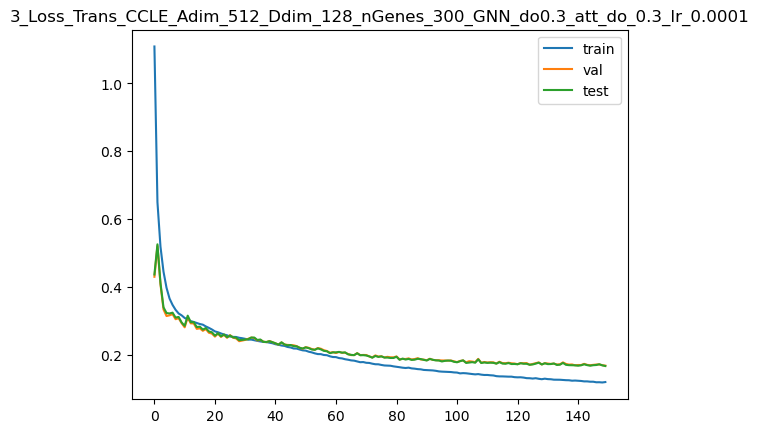

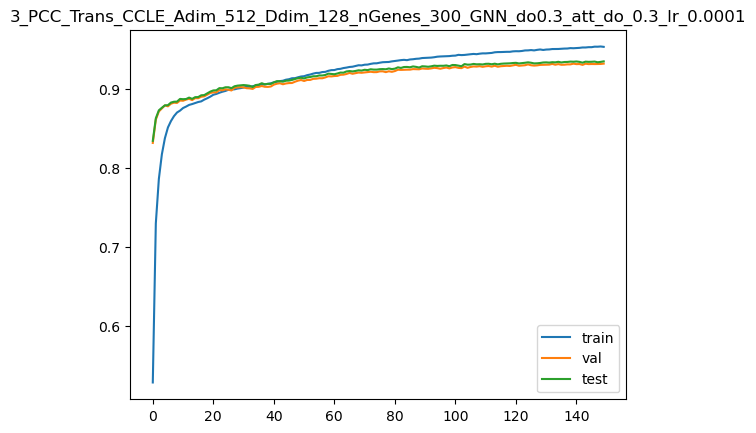

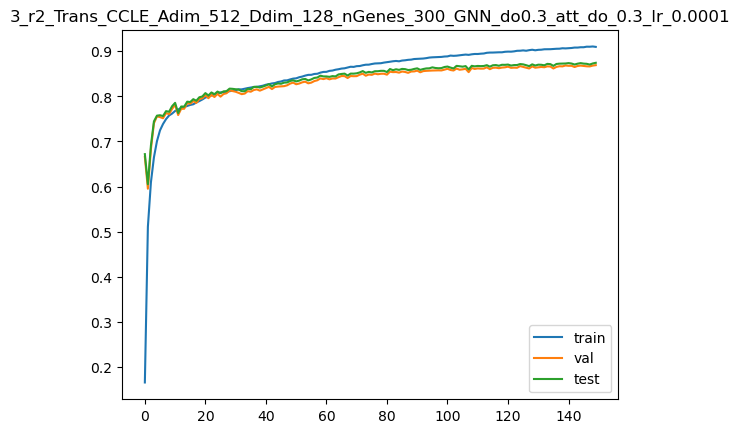

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16738991
Test avg_pcc:  0.935349743906587
Test r2:  0.8743687670200616


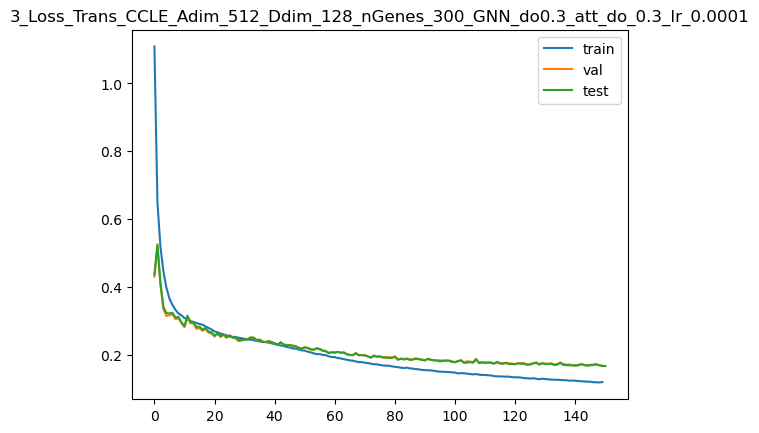

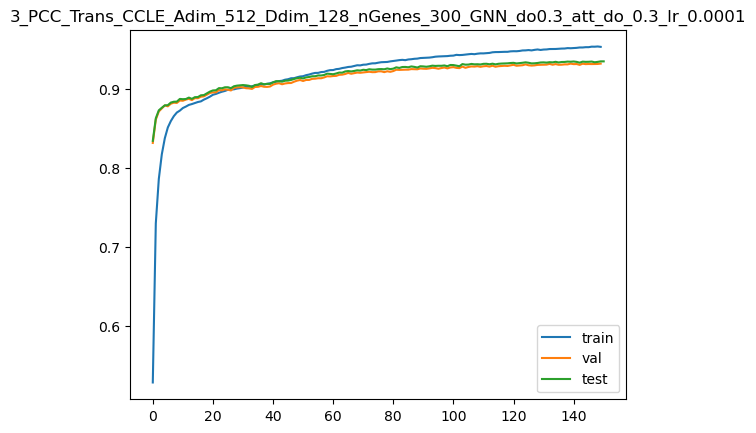

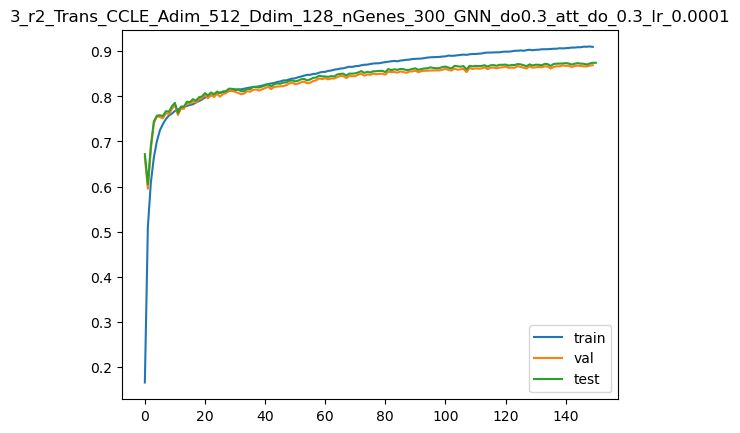

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  1.0054187774658203
The overall Pearson's correlation is 0.5793.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.9182767868041992
The overall Pearson's correlation is 0.7030.
Train avg_loss:  1.1345174
Train avg_pcc:  0.5171861746895698
Train r2:  0.1439851076703098


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.81432927
Validation avg_pcc:  0.8482123976509701
Validation r2:  0.38518182322184746
Best Val r2  0.38518182322184746


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.818461
Test avg_pcc:  0.843098359040459
Test r2:  0.38346641806640336
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.5331078767776489
The overall Pearson's correlation is 0.8608.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4764685332775116
The overall Pearson's correlation is 0.8114.
Train avg_loss:  0.65862054
Train avg_pcc:  0.7262443785310494
Train r2:  0.5030582985675263


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.48930654
Validation avg_pcc:  0.8665664823492735
Validation r2:  0.6305737853823457
Best Val r2  0.6305737853823457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.49543315
Test avg_pcc:  0.8619489814428724
Test r2:  0.626798125127019
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4392385184764862
The overall Pearson's correlation is 0.8638.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.8200538754463196
The overall Pearson's correlation is 0.6752.
Train avg_loss:  0.5256467
Train avg_pcc:  0.7825952150807762
Train r2:  0.6033895915669623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.35207456
Validation avg_pcc:  0.8729450641840689
Validation r2:  0.7341838863841316
Best Val r2  0.7341838863841316


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.36022136
Test avg_pcc:  0.8697427230833348
Test r2:  0.728650997181431
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.39248672127723694
The overall Pearson's correlation is 0.8712.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.5949110984802246
The overall Pearson's correlation is 0.8269.
Train avg_loss:  0.45389614
Train avg_pcc:  0.813327161719753
Train r2:  0.6575267672943489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33224025
Validation avg_pcc:  0.8828475690520102
Validation r2:  0.7491587749741868
Best Val r2  0.7491587749741868


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34075654
Test avg_pcc:  0.8791979048923646
Test r2:  0.7433135566000221
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.40922272205352783
The overall Pearson's correlation is 0.8031.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4234482944011688
The overall Pearson's correlation is 0.8375.
Train avg_loss:  0.39817202
Train avg_pcc:  0.8372084829116391
Train r2:  0.6995716177515817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30500364
Validation avg_pcc:  0.8820624556107483
Validation r2:  0.76972240199744
Best Val r2  0.76972240199744


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31160378
Test avg_pcc:  0.8792760137657547
Test r2:  0.7652738574516278
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.42242366075515747
The overall Pearson's correlation is 0.8087.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2762734591960907
The overall Pearson's correlation is 0.8882.
Train avg_loss:  0.36827275
Train avg_pcc:  0.8500830284752241
Train r2:  0.7221312342477483


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30403802
Validation avg_pcc:  0.8846850885656199
Validation r2:  0.7704514593683961
Best Val r2  0.7704514593683961


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30917057
Test avg_pcc:  0.8825590244876592
Test r2:  0.7671067643081448
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4084545969963074
The overall Pearson's correlation is 0.8683.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3145042061805725
The overall Pearson's correlation is 0.8031.
Train avg_loss:  0.3492467
Train avg_pcc:  0.8582991102081485
Train r2:  0.7364867193405471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31976146
Validation avg_pcc:  0.8847116642907568
Validation r2:  0.7585802566214919


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32448927
Test avg_pcc:  0.882364602454094
Test r2:  0.755567399402229
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27632588148117065
The overall Pearson's correlation is 0.8861.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3139202892780304
The overall Pearson's correlation is 0.8706.
Train avg_loss:  0.33524296
Train avg_pcc:  0.8643714988449953
Train r2:  0.7470528517420316


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3152249
Validation avg_pcc:  0.8861617849918753
Validation r2:  0.7620053661530973


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31950918
Test avg_pcc:  0.8839983173903992
Test r2:  0.759318840581165
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3156207203865051
The overall Pearson's correlation is 0.8488.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.29087963700294495
The overall Pearson's correlation is 0.8686.
Train avg_loss:  0.32175493
Train avg_pcc:  0.8702124137152182
Train r2:  0.7572297828423168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.312535
Validation avg_pcc:  0.8863165320039905
Validation r2:  0.7640362432141954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3212024
Test avg_pcc:  0.882883679680137
Test r2:  0.7580433759420075
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3311120271682739
The overall Pearson's correlation is 0.8400.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3065694570541382
The overall Pearson's correlation is 0.8488.
Train avg_loss:  0.31517768
Train avg_pcc:  0.8730588302155905
Train r2:  0.7621924678356226


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29528406
Validation avg_pcc:  0.8868058882670202
Validation r2:  0.7770606682659762
Best Val r2  0.7770606682659762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3009941
Test avg_pcc:  0.884396051896038
Test r2:  0.7732659364625565
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.31494778394699097
The overall Pearson's correlation is 0.9041.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3211900591850281
The overall Pearson's correlation is 0.8547.
Train avg_loss:  0.3099478
Train avg_pcc:  0.8753049661123592
Train r2:  0.7661384930776817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29365695
Validation avg_pcc:  0.8903462802026656
Validation r2:  0.7782891471569348
Best Val r2  0.7782891471569348


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3018695
Test avg_pcc:  0.8870804577639797
Test r2:  0.7726065202210102
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.31455206871032715
The overall Pearson's correlation is 0.7813.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.340629518032074
The overall Pearson's correlation is 0.8834.
Train avg_loss:  0.30620685
Train avg_pcc:  0.8769195512915852
Train r2:  0.7689611374352852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3034485
Validation avg_pcc:  0.8873580844397042
Validation r2:  0.7708965318153378


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30993715
Test avg_pcc:  0.8849253194583748
Test r2:  0.766529297265869
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24108180403709412
The overall Pearson's correlation is 0.9032.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2388421595096588
The overall Pearson's correlation is 0.8933.
Train avg_loss:  0.3020674
Train avg_pcc:  0.8786952135738563
Train r2:  0.7720844096326326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29054642
Validation avg_pcc:  0.89084078386994
Validation r2:  0.7806376098564243
Best Val r2  0.7806376098564243


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2974866
Test avg_pcc:  0.8881543305525974
Test r2:  0.775908117015794
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.35212188959121704
The overall Pearson's correlation is 0.7906.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.27362677454948425
The overall Pearson's correlation is 0.8670.
Train avg_loss:  0.298054
Train avg_pcc:  0.8804162437564181
Train r2:  0.7751126023704566


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3074831
Validation avg_pcc:  0.8906264560748515
Validation r2:  0.7678504014712324


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31517223
Test avg_pcc:  0.8876604547016712
Test r2:  0.7625857861834164
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2625894546508789
The overall Pearson's correlation is 0.8872.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23326247930526733
The overall Pearson's correlation is 0.9192.
Train avg_loss:  0.2952726
Train avg_pcc:  0.8816066282674668
Train r2:  0.7772112474142019


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31821284
Validation avg_pcc:  0.8919846275714753
Validation r2:  0.7597494755451183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3253232
Test avg_pcc:  0.8894147388990694
Test r2:  0.7549392370978183
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3627423048019409
The overall Pearson's correlation is 0.8729.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23678770661354065
The overall Pearson's correlation is 0.8757.
Train avg_loss:  0.29246572
Train avg_pcc:  0.8828062116582388
Train r2:  0.7793290642705266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2748416
Validation avg_pcc:  0.8927249903261927
Validation r2:  0.792494732570806
Best Val r2  0.792494732570806


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28070834
Test avg_pcc:  0.8906528782393658
Test r2:  0.788546892839481
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24816259741783142
The overall Pearson's correlation is 0.9192.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3351202607154846
The overall Pearson's correlation is 0.8928.
Train avg_loss:  0.29082772
Train avg_pcc:  0.883507524844995
Train r2:  0.7805649727883356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27185318
Validation avg_pcc:  0.893352857353636
Validation r2:  0.7947509926484502
Best Val r2  0.7947509926484502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27850524
Test avg_pcc:  0.8909104846459551
Test r2:  0.7902064563034129
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3118423819541931
The overall Pearson's correlation is 0.8331.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3771376609802246
The overall Pearson's correlation is 0.8307.
Train avg_loss:  0.28651434
Train avg_pcc:  0.885343596806558
Train r2:  0.7838195104332889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28941214
Validation avg_pcc:  0.8935301181182114
Validation r2:  0.7814939779383769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29630738
Test avg_pcc:  0.8912781103951563
Test r2:  0.7767963871783965
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2526780962944031
The overall Pearson's correlation is 0.8767.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2867644429206848
The overall Pearson's correlation is 0.8729.
Train avg_loss:  0.2850615
Train avg_pcc:  0.8859665843554286
Train r2:  0.7849157023157617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2638096
Validation avg_pcc:  0.8948899275033153
Validation r2:  0.8008238828314668
Best Val r2  0.8008238828314668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27072406
Test avg_pcc:  0.8922393670787666
Test r2:  0.796067889914301
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2302824854850769
The overall Pearson's correlation is 0.9090.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15395990014076233
The overall Pearson's correlation is 0.9055.
Train avg_loss:  0.2804154
Train avg_pcc:  0.8879408418220499
Train r2:  0.7884212672004767


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27001143
Validation avg_pcc:  0.8959211059296287
Validation r2:  0.7961415004004463


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27650905
Test avg_pcc:  0.89363010210791
Test r2:  0.7917101455462904
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.219169482588768
The overall Pearson's correlation is 0.8860.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3324151039123535
The overall Pearson's correlation is 0.8630.
Train avg_loss:  0.27544695
Train avg_pcc:  0.8900474750159453
Train r2:  0.7921700651795711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25554225
Validation avg_pcc:  0.900482684041644
Validation r2:  0.8070657242832976
Best Val r2  0.8070657242832976


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26511675
Test avg_pcc:  0.8968735020997889
Test r2:  0.8002917967893977
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2508033812046051
The overall Pearson's correlation is 0.8907.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3137322962284088
The overall Pearson's correlation is 0.8805.
Train avg_loss:  0.2703769
Train avg_pcc:  0.892195111904677
Train r2:  0.7959954918904996


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2566162
Validation avg_pcc:  0.9012597087946606
Validation r2:  0.8062548804574106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26412877
Test avg_pcc:  0.8986005703039085
Test r2:  0.8010360121255898
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17530351877212524
The overall Pearson's correlation is 0.9354.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21597351133823395
The overall Pearson's correlation is 0.8871.
Train avg_loss:  0.2659912
Train avg_pcc:  0.8940474066261113
Train r2:  0.7993046082660491


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25170207
Validation avg_pcc:  0.9019929629140211
Validation r2:  0.8099650656323485
Best Val r2  0.8099650656323485


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2575419
Test avg_pcc:  0.89955258745396
Test r2:  0.8059978259494458
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24870094656944275
The overall Pearson's correlation is 0.9346.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3113011121749878
The overall Pearson's correlation is 0.9102.
Train avg_loss:  0.2618423
Train avg_pcc:  0.8957963083589136
Train r2:  0.8024350182024399


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25377893
Validation avg_pcc:  0.9026249506176437
Validation r2:  0.8083970418672709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26116058
Test avg_pcc:  0.8999821850522065
Test r2:  0.8032718988457376
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.28588712215423584
The overall Pearson's correlation is 0.8830.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2862073481082916
The overall Pearson's correlation is 0.9035.
Train avg_loss:  0.25833964
Train avg_pcc:  0.8972698480777369
Train r2:  0.8050778405312319


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24942935
Validation avg_pcc:  0.9043530035977901
Validation r2:  0.8116809713917958
Best Val r2  0.8116809713917958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25928017
Test avg_pcc:  0.9008032282719127
Test r2:  0.8046884034398823
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26692795753479004
The overall Pearson's correlation is 0.8414.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2334524691104889
The overall Pearson's correlation is 0.9266.
Train avg_loss:  0.2560606
Train avg_pcc:  0.8982279419488841
Train r2:  0.8067973951004217


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24112123
Validation avg_pcc:  0.904423043326486
Validation r2:  0.8179535959642552
Best Val r2  0.8179535959642552


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24999928
Test avg_pcc:  0.9009363558331003
Test r2:  0.8116795386007255
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27336743474006653
The overall Pearson's correlation is 0.9020.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2684028148651123
The overall Pearson's correlation is 0.9184.
Train avg_loss:  0.25397182
Train avg_pcc:  0.8991038305861584
Train r2:  0.808373460873989


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25186068
Validation avg_pcc:  0.9034788790671405
Validation r2:  0.8098453196248587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2594763
Test avg_pcc:  0.9008574961371157
Test r2:  0.8045406777838193
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20701813697814941
The overall Pearson's correlation is 0.8967.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18535450100898743
The overall Pearson's correlation is 0.9187.
Train avg_loss:  0.2516494
Train avg_pcc:  0.9000776899093819
Train r2:  0.8101257410511491


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23629156
Validation avg_pcc:  0.9065301982473715
Validation r2:  0.8215999859838444
Best Val r2  0.8215999859838444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24269943
Test avg_pcc:  0.9041250238850671
Test r2:  0.8171784094701732
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3451114296913147
The overall Pearson's correlation is 0.8619.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3003658056259155
The overall Pearson's correlation is 0.8926.
Train avg_loss:  0.25066173
Train avg_pcc:  0.9004898222074619
Train r2:  0.8108709423404135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24801219
Validation avg_pcc:  0.9060652036532013
Validation r2:  0.8127509073502228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25680074
Test avg_pcc:  0.9027748071779677
Test r2:  0.8065561305376192
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.35812097787857056
The overall Pearson's correlation is 0.8517.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.28073444962501526
The overall Pearson's correlation is 0.8723.
Train avg_loss:  0.25018176
Train avg_pcc:  0.9006934328083601
Train r2:  0.8112331226539182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24553956
Validation avg_pcc:  0.906039951973749
Validation r2:  0.8146177376007778


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25484183
Test avg_pcc:  0.9028832883876811
Test r2:  0.8080317120338376
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26789218187332153
The overall Pearson's correlation is 0.8743.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22847676277160645
The overall Pearson's correlation is 0.8840.
Train avg_loss:  0.24753913
Train avg_pcc:  0.9017998733417529
Train r2:  0.8132270141727671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23896746
Validation avg_pcc:  0.906967432976984
Validation r2:  0.8195796826662065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24640517
Test avg_pcc:  0.9042676377637956
Test r2:  0.8143869254527032
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2519253194332123
The overall Pearson's correlation is 0.8849.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3350866734981537
The overall Pearson's correlation is 0.8841.
Train avg_loss:  0.24552694
Train avg_pcc:  0.902639242009837
Train r2:  0.8147452722993769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23622005
Validation avg_pcc:  0.9072591833059089
Validation r2:  0.8216539753079258
Best Val r2  0.8216539753079258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24541298
Test avg_pcc:  0.9037604774853475
Test r2:  0.8151343340530566
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1994788944721222
The overall Pearson's correlation is 0.8782.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21585100889205933
The overall Pearson's correlation is 0.9152.
Train avg_loss:  0.24562724
Train avg_pcc:  0.9025975429924584
Train r2:  0.8146695895076326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23648046
Validation avg_pcc:  0.9063636879761467
Validation r2:  0.8214573722149129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2429206
Test avg_pcc:  0.9038889124813282
Test r2:  0.8170117979475412
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3197053372859955
The overall Pearson's correlation is 0.8381.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1992587447166443
The overall Pearson's correlation is 0.9184.
Train avg_loss:  0.24197292
Train avg_pcc:  0.9041221181043393
Train r2:  0.8174268386323171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24289075
Validation avg_pcc:  0.9076596731829274
Validation r2:  0.8166176110084794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24985509
Test avg_pcc:  0.9051972224217252
Test r2:  0.8117881615568168
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23979632556438446
The overall Pearson's correlation is 0.8909.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.38116222620010376
The overall Pearson's correlation is 0.8093.
Train avg_loss:  0.24014825
Train avg_pcc:  0.904883177658995
Train r2:  0.818803582276373


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2344902
Validation avg_pcc:  0.9079539521793708
Validation r2:  0.8229600150937761
Best Val r2  0.8229600150937761


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24373302
Test avg_pcc:  0.9044456135013342
Test r2:  0.8163998074898834
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27306944131851196
The overall Pearson's correlation is 0.9161.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16784033179283142
The overall Pearson's correlation is 0.9090.
Train avg_loss:  0.2386463
Train avg_pcc:  0.9055089627242886
Train r2:  0.8199368367329705


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23809198
Validation avg_pcc:  0.9075995904696955
Validation r2:  0.8202406764560272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24547414
Test avg_pcc:  0.9050245846488659
Test r2:  0.8150882571366659
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20030470192432404
The overall Pearson's correlation is 0.9224.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14113260805606842
The overall Pearson's correlation is 0.9518.
Train avg_loss:  0.23643152
Train avg_pcc:  0.9064314034629607
Train r2:  0.8216079242126011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23095156
Validation avg_pcc:  0.9088035805257204
Validation r2:  0.8256316675156438
Best Val r2  0.8256316675156438


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23825343
Test avg_pcc:  0.9060488293871956
Test r2:  0.8205274992726554
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26563483476638794
The overall Pearson's correlation is 0.8764.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3129957914352417
The overall Pearson's correlation is 0.8868.
Train avg_loss:  0.23552781
Train avg_pcc:  0.9068062758328617
Train r2:  0.8222897904197892


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23615974
Validation avg_pcc:  0.9090773320559072
Validation r2:  0.8216995255723321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24206515
Test avg_pcc:  0.9070741373096748
Test r2:  0.8176562039388395
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18014715611934662
The overall Pearson's correlation is 0.8838.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2709972560405731
The overall Pearson's correlation is 0.8985.
Train avg_loss:  0.23307739
Train avg_pcc:  0.9078258384792309
Train r2:  0.8241386965377802


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23220523
Validation avg_pcc:  0.9089118096859238
Validation r2:  0.8246851622853768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23802839
Test avg_pcc:  0.9065412340607355
Test r2:  0.8206970082156014
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1837376356124878
The overall Pearson's correlation is 0.9419.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.28882789611816406
The overall Pearson's correlation is 0.8935.
Train avg_loss:  0.2306627
Train avg_pcc:  0.9088296944203574
Train r2:  0.8259606084560123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23114623
Validation avg_pcc:  0.9088898781925653
Validation r2:  0.8254846979305774


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23766156
Test avg_pcc:  0.9065249017251856
Test r2:  0.8209733504447553
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22323349118232727
The overall Pearson's correlation is 0.8757.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1993248015642166
The overall Pearson's correlation is 0.9281.
Train avg_loss:  0.22908221
Train avg_pcc:  0.9094848891022675
Train r2:  0.8271531393116995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22811313
Validation avg_pcc:  0.9116362213698818
Validation r2:  0.8277746922882273
Best Val r2  0.8277746922882273


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23598127
Test avg_pcc:  0.908750001499372
Test r2:  0.8222390795581512
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2610904574394226
The overall Pearson's correlation is 0.8788.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24106687307357788
The overall Pearson's correlation is 0.9085.
Train avg_loss:  0.22711171
Train avg_pcc:  0.9103008190285178
Train r2:  0.8286399048594799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22631386
Validation avg_pcc:  0.9111237219540086
Validation r2:  0.8291331544443621
Best Val r2  0.8291331544443621


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23222588
Test avg_pcc:  0.9089243127735471
Test r2:  0.8250679596849086
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2753854990005493
The overall Pearson's correlation is 0.8847.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1609860509634018
The overall Pearson's correlation is 0.9553.
Train avg_loss:  0.22529228
Train avg_pcc:  0.9110581473572104
Train r2:  0.8300126737604585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2264747
Validation avg_pcc:  0.9106997279529111
Validation r2:  0.82901171632192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23172615
Test avg_pcc:  0.9087637729425941
Test r2:  0.8254443946872791
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26694464683532715
The overall Pearson's correlation is 0.8777.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22593943774700165
The overall Pearson's correlation is 0.8995.
Train avg_loss:  0.22217682
Train avg_pcc:  0.9123433564778132
Train r2:  0.8323633692753223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22368225
Validation avg_pcc:  0.9118235335418193
Validation r2:  0.8311200031730455
Best Val r2  0.8311200031730455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22962958
Test avg_pcc:  0.9095581004181346
Test r2:  0.8270237088079849
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2827262878417969
The overall Pearson's correlation is 0.8564.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2669628858566284
The overall Pearson's correlation is 0.8923.
Train avg_loss:  0.22126906
Train avg_pcc:  0.9127197615675221
Train r2:  0.8330482916234826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2207945
Validation avg_pcc:  0.9129725234047144
Validation r2:  0.8333002688410307
Best Val r2  0.8333002688410307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22670148
Test avg_pcc:  0.9108171252105758
Test r2:  0.829229400345666
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17748816311359406
The overall Pearson's correlation is 0.9252.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2099570333957672
The overall Pearson's correlation is 0.9248.
Train avg_loss:  0.21926767
Train avg_pcc:  0.9135473601612902
Train r2:  0.8345583854032373


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22088896
Validation avg_pcc:  0.9139835792480575
Validation r2:  0.8332289466349382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2273281
Test avg_pcc:  0.9117802316573264
Test r2:  0.8287573669921342
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16485562920570374
The overall Pearson's correlation is 0.9381.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17068004608154297
The overall Pearson's correlation is 0.9226.
Train avg_loss:  0.21748365
Train avg_pcc:  0.9142828113776187
Train r2:  0.8359044634761217


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22396044
Validation avg_pcc:  0.9126404414377284
Validation r2:  0.8309099789832902


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22870906
Test avg_pcc:  0.91093888701286
Test r2:  0.8277171223048722
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.28499293327331543
The overall Pearson's correlation is 0.8896.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3128788471221924
The overall Pearson's correlation is 0.8553.
Train avg_loss:  0.21545392
Train avg_pcc:  0.9151202674461556
Train r2:  0.837435923787876


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22450116
Validation avg_pcc:  0.9132647447150481
Validation r2:  0.8305017407382647


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22933118
Test avg_pcc:  0.9116462945223294
Test r2:  0.8272484893326976
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21171274781227112
The overall Pearson's correlation is 0.9146.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21209092438220978
The overall Pearson's correlation is 0.9010.
Train avg_loss:  0.21317889
Train avg_pcc:  0.9160565442802837
Train r2:  0.8391524805035514


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2152269
Validation avg_pcc:  0.9151872982481297
Validation r2:  0.8375037902678487
Best Val r2  0.8375037902678487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22024351
Test avg_pcc:  0.9133099371779859
Test r2:  0.8340940740353104
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20981253683567047
The overall Pearson's correlation is 0.9057.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16226065158843994
The overall Pearson's correlation is 0.9310.
Train avg_loss:  0.21131274
Train avg_pcc:  0.9168255325719522
Train r2:  0.8405605260989965


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22197944
Validation avg_pcc:  0.9152368008478523
Validation r2:  0.832405630978749


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22760394
Test avg_pcc:  0.9130998627256606
Test r2:  0.8285495870979751


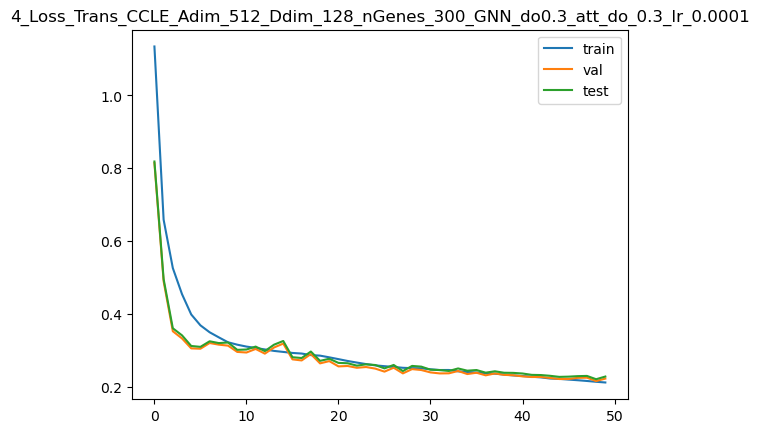

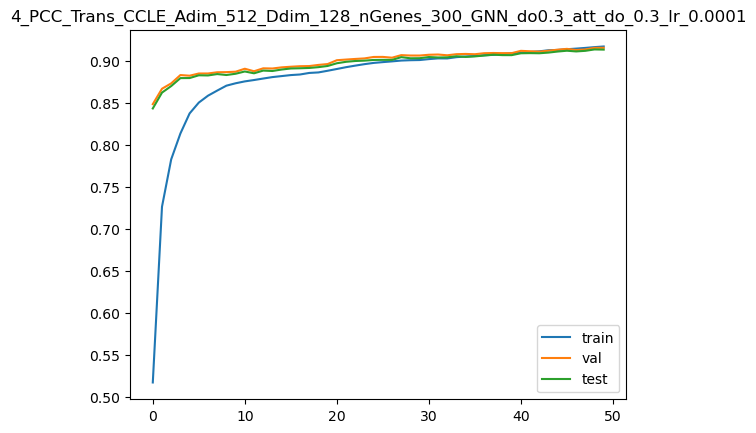

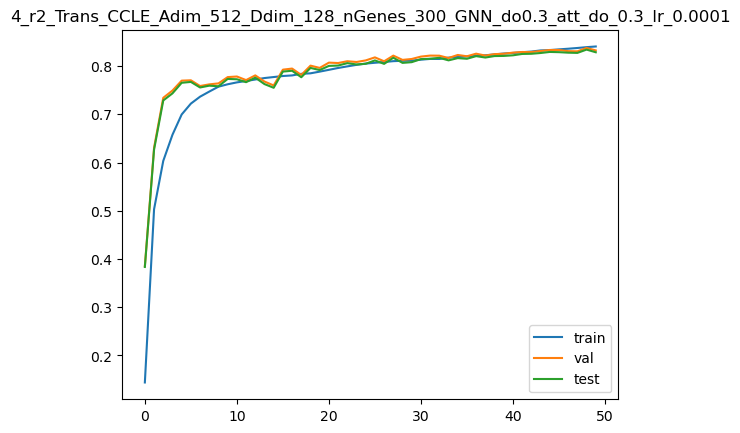

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2118789553642273
The overall Pearson's correlation is 0.9186.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16104835271835327
The overall Pearson's correlation is 0.9383.
Train avg_loss:  0.2093249
Train avg_pcc:  0.9176433271649446
Train r2:  0.8420603958909696


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21476512
Validation avg_pcc:  0.9155094198070379
Validation r2:  0.8378524540779172
Best Val r2  0.8378524540779172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21880238
Test avg_pcc:  0.9141146742675758
Test r2:  0.8351796717183011
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16786935925483704
The overall Pearson's correlation is 0.9139.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15510161221027374
The overall Pearson's correlation is 0.9494.
Train avg_loss:  0.20729378
Train avg_pcc:  0.9184779364202783
Train r2:  0.8435929113160809


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21362488
Validation avg_pcc:  0.9170245590442513
Validation r2:  0.8387133128488667
Best Val r2  0.8387133128488667


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2188933
Test avg_pcc:  0.9152069656574597
Test r2:  0.8351111578154107
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11655338853597641
The overall Pearson's correlation is 0.9515.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1261926293373108
The overall Pearson's correlation is 0.9412.
Train avg_loss:  0.20552953
Train avg_pcc:  0.9192021326647974
Train r2:  0.8449240646292943


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21589378
Validation avg_pcc:  0.9163996608341926
Validation r2:  0.8370003085427972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22097847
Test avg_pcc:  0.9145790995441244
Test r2:  0.8335404568773087
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19554929435253143
The overall Pearson's correlation is 0.8779.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17712992429733276
The overall Pearson's correlation is 0.9409.
Train avg_loss:  0.2036334
Train avg_pcc:  0.9199795961319248
Train r2:  0.8463547335218765


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21060753
Validation avg_pcc:  0.9176770738114702
Validation r2:  0.8409914289249378
Best Val r2  0.8409914289249378


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21403868
Test avg_pcc:  0.9165054105714782
Test r2:  0.8387680888874578
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14643366634845734
The overall Pearson's correlation is 0.9396.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.29708945751190186
The overall Pearson's correlation is 0.8739.
Train avg_loss:  0.20113023
Train avg_pcc:  0.9210059549035224
Train r2:  0.8482434382459108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21816926
Validation avg_pcc:  0.9188499347314362
Validation r2:  0.8352823050399272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22308879
Test avg_pcc:  0.9171463051249591
Test r2:  0.8319507819298011
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21229800581932068
The overall Pearson's correlation is 0.9070.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3229343295097351
The overall Pearson's correlation is 0.8846.
Train avg_loss:  0.19992383
Train avg_pcc:  0.9215012439970844
Train r2:  0.849153675928583


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20912634
Validation avg_pcc:  0.9183304526160043
Validation r2:  0.842109719056769
Best Val r2  0.842109719056769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21338302
Test avg_pcc:  0.9170043288407755
Test r2:  0.8392619783497489
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15828317403793335
The overall Pearson's correlation is 0.9430.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13004593551158905
The overall Pearson's correlation is 0.9402.
Train avg_loss:  0.19822596
Train avg_pcc:  0.9221941044661729
Train r2:  0.85043476909533


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20960866
Validation avg_pcc:  0.9181291503468719
Validation r2:  0.8417455647342702


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21256985
Test avg_pcc:  0.9172539289649904
Test r2:  0.8398745394300614
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32768428325653076
The overall Pearson's correlation is 0.8916.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23646321892738342
The overall Pearson's correlation is 0.8873.
Train avg_loss:  0.19591348
Train avg_pcc:  0.9231384273736233
Train r2:  0.8521795558102068


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21368615
Validation avg_pcc:  0.9202856198257665
Validation r2:  0.8386670674627932


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21910293
Test avg_pcc:  0.9185210472705412
Test r2:  0.8349532773216444
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21523422002792358
The overall Pearson's correlation is 0.8922.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19970498979091644
The overall Pearson's correlation is 0.9066.
Train avg_loss:  0.1941937
Train avg_pcc:  0.9238432394741422
Train r2:  0.8534771636344499


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20937407
Validation avg_pcc:  0.9207180003597729
Validation r2:  0.8419226665309367


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21420953
Test avg_pcc:  0.9190920590405192
Test r2:  0.8386393784591395
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22280946373939514
The overall Pearson's correlation is 0.9398.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.195818692445755
The overall Pearson's correlation is 0.9441.
Train avg_loss:  0.19276923
Train avg_pcc:  0.9244245844425799
Train r2:  0.8545519587786574


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2000891
Validation avg_pcc:  0.9213778280951381
Validation r2:  0.8489328248604577
Best Val r2  0.8489328248604577


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20505695
Test avg_pcc:  0.9195562013614319
Test r2:  0.8455338848421011
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17096219956874847
The overall Pearson's correlation is 0.9340.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15634599328041077
The overall Pearson's correlation is 0.9477.
Train avg_loss:  0.19129467
Train avg_pcc:  0.9250257886339915
Train r2:  0.8556645324410178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20356315
Validation avg_pcc:  0.9207129833548915
Validation r2:  0.8463099147282518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20729534
Test avg_pcc:  0.9195476624471208
Test r2:  0.8438477323078473
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1902000904083252
The overall Pearson's correlation is 0.9392.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14208641648292542
The overall Pearson's correlation is 0.9021.
Train avg_loss:  0.18931565
Train avg_pcc:  0.9258323519932914
Train r2:  0.857157746453995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19782892
Validation avg_pcc:  0.9225138884451013
Validation r2:  0.8506392681038424
Best Val r2  0.8506392681038424


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20342492
Test avg_pcc:  0.9203238826692671
Test r2:  0.8467632697205375
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.169187530875206
The overall Pearson's correlation is 0.9145.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16858108341693878
The overall Pearson's correlation is 0.9317.
Train avg_loss:  0.18797946
Train avg_pcc:  0.9263775719726675
Train r2:  0.858165932629572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19826744
Validation avg_pcc:  0.9221459992838075
Validation r2:  0.8503081895665902


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20227821
Test avg_pcc:  0.9207279724900349
Test r2:  0.8476270437199742
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21084105968475342
The overall Pearson's correlation is 0.9238.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2111324667930603
The overall Pearson's correlation is 0.9185.
Train avg_loss:  0.18519016
Train avg_pcc:  0.9275109129846426
Train r2:  0.860270510610167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19953273
Validation avg_pcc:  0.9231405959121246
Validation r2:  0.849352893080491


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20413828
Test avg_pcc:  0.9215678108036623
Test r2:  0.8462259044797215
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20535442233085632
The overall Pearson's correlation is 0.9006.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1218114048242569
The overall Pearson's correlation is 0.9488.
Train avg_loss:  0.18540351
Train avg_pcc:  0.9274244754490051
Train r2:  0.860109541545544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19862974
Validation avg_pcc:  0.9230859232817312
Validation r2:  0.8500346517995585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20294562
Test avg_pcc:  0.9215078258377807
Test r2:  0.8471243096225064
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18430709838867188
The overall Pearson's correlation is 0.9217.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23925887048244476
The overall Pearson's correlation is 0.8845.
Train avg_loss:  0.18361549
Train avg_pcc:  0.928152809849611
Train r2:  0.8614586188493223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19418539
Validation avg_pcc:  0.9239318300947745
Validation r2:  0.853390137192371
Best Val r2  0.853390137192371


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19982554
Test avg_pcc:  0.921892667561323
Test r2:  0.849474613021396
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12605421245098114
The overall Pearson's correlation is 0.9470.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.248386949300766
The overall Pearson's correlation is 0.9229.
Train avg_loss:  0.18237957
Train avg_pcc:  0.9286541582956326
Train r2:  0.8623911447025349


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19837837
Validation avg_pcc:  0.9229709704626784
Validation r2:  0.8502244400379909


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2048785
Test avg_pcc:  0.9206096963581185
Test r2:  0.8456683006204795
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17234620451927185
The overall Pearson's correlation is 0.9335.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17883943021297455
The overall Pearson's correlation is 0.9397.
Train avg_loss:  0.18120137
Train avg_pcc:  0.9291325897858383
Train r2:  0.8632801302090121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19368552
Validation avg_pcc:  0.9242595379527864
Validation r2:  0.8537675252448547
Best Val r2  0.8537675252448547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19809888
Test avg_pcc:  0.9227253226420326
Test r2:  0.8507752820385744
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19286713004112244
The overall Pearson's correlation is 0.9329.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16388437151908875
The overall Pearson's correlation is 0.9381.
Train avg_loss:  0.18062258
Train avg_pcc:  0.9293674611394664
Train r2:  0.8637168490116918


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20114554
Validation avg_pcc:  0.9243167584921194
Validation r2:  0.8481352117094975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2081504
Test avg_pcc:  0.9219345234119062
Test r2:  0.8432036269618155
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2235441356897354
The overall Pearson's correlation is 0.9392.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1583770513534546
The overall Pearson's correlation is 0.9298.
Train avg_loss:  0.17839074
Train avg_pcc:  0.9302736304944625
Train r2:  0.8654008048333994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1924946
Validation avg_pcc:  0.9248149558756351
Validation r2:  0.8546666653958259
Best Val r2  0.8546666653958259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1949713
Test avg_pcc:  0.9240790084260941
Test r2:  0.8531312362742277
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21213316917419434
The overall Pearson's correlation is 0.9233.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1299302577972412
The overall Pearson's correlation is 0.9147.
Train avg_loss:  0.17723446
Train avg_pcc:  0.9307416356386229
Train r2:  0.8662732483838614


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19185412
Validation avg_pcc:  0.9252994059127567
Validation r2:  0.8551502235321147
Best Val r2  0.8551502235321147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19650657
Test avg_pcc:  0.9237068961733255
Test r2:  0.8519747396454631
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18581992387771606
The overall Pearson's correlation is 0.9293.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18631486594676971
The overall Pearson's correlation is 0.9434.
Train avg_loss:  0.17536394
Train avg_pcc:  0.9315000579900853
Train r2:  0.86768457279538


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1999914
Validation avg_pcc:  0.9259067218176544
Validation r2:  0.8490065775600178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20750509
Test avg_pcc:  0.9233049860076329
Test r2:  0.8436897294657937
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2952601909637451
The overall Pearson's correlation is 0.9339.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1569051444530487
The overall Pearson's correlation is 0.9490.
Train avg_loss:  0.17419642
Train avg_pcc:  0.931971643035565
Train r2:  0.8685654866519599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19400921
Validation avg_pcc:  0.9250397041758615
Validation r2:  0.8535231401899016


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19780064
Test avg_pcc:  0.92378952085028
Test r2:  0.850999946279346
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10611418634653091
The overall Pearson's correlation is 0.9586.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1995035707950592
The overall Pearson's correlation is 0.9402.
Train avg_loss:  0.17366378
Train avg_pcc:  0.932188292919722
Train r2:  0.868967392498861


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18927713
Validation avg_pcc:  0.9257953290535176
Validation r2:  0.8570958461772673
Best Val r2  0.8570958461772673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19453722
Test avg_pcc:  0.9238388553266703
Test r2:  0.8534582052531413
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11931610107421875
The overall Pearson's correlation is 0.9380.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1569654643535614
The overall Pearson's correlation is 0.9366.
Train avg_loss:  0.17242421
Train avg_pcc:  0.9326891872699338
Train r2:  0.8699026633710997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19278303
Validation avg_pcc:  0.926148897015273
Validation r2:  0.854448906581608


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19814076
Test avg_pcc:  0.9242000449651522
Test r2:  0.8507437362045246
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12885698676109314
The overall Pearson's correlation is 0.9413.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10949087142944336
The overall Pearson's correlation is 0.9620.
Train avg_loss:  0.17230871
Train avg_pcc:  0.9327364211592767
Train r2:  0.8699898083224424


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19009122
Validation avg_pcc:  0.925663902626186
Validation r2:  0.8564812182611347


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19532554
Test avg_pcc:  0.9237591289832151
Test r2:  0.8528643941502925
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16926126182079315
The overall Pearson's correlation is 0.9423.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1434563547372818
The overall Pearson's correlation is 0.9280.
Train avg_loss:  0.17018385
Train avg_pcc:  0.9335945755215378
Train r2:  0.8715930485280148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19100483
Validation avg_pcc:  0.9264311126980056
Validation r2:  0.8557914550410524


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19671483
Test avg_pcc:  0.9243873092560624
Test r2:  0.8518178603725222
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2107982486486435
The overall Pearson's correlation is 0.9051.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21893322467803955
The overall Pearson's correlation is 0.9035.
Train avg_loss:  0.17006452
Train avg_pcc:  0.9336435796534531
Train r2:  0.8716830913526936


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18954158
Validation avg_pcc:  0.9261327866949448
Validation r2:  0.8568961992475966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19481893
Test avg_pcc:  0.9242068059871431
Test r2:  0.8532460170664335
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20045918226242065
The overall Pearson's correlation is 0.8698.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1727222204208374
The overall Pearson's correlation is 0.9199.
Train avg_loss:  0.16801475
Train avg_pcc:  0.934470963941883
Train r2:  0.8732296842979177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18914478
Validation avg_pcc:  0.9269838874774633
Validation r2:  0.8571957856356938
Best Val r2  0.8571957856356938


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19531174
Test avg_pcc:  0.9247166732241053
Test r2:  0.8528747934294775
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18135493993759155
The overall Pearson's correlation is 0.9320.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18751245737075806
The overall Pearson's correlation is 0.8833.
Train avg_loss:  0.16791686
Train avg_pcc:  0.9345114448964457
Train r2:  0.8733035345854319


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18556063
Validation avg_pcc:  0.9282096659987503
Validation r2:  0.859901804663347
Best Val r2  0.859901804663347


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18990017
Test avg_pcc:  0.9267472928311662
Test r2:  0.8569512267650204
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16031663119792938
The overall Pearson's correlation is 0.9308.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13639700412750244
The overall Pearson's correlation is 0.9446.
Train avg_loss:  0.16595213
Train avg_pcc:  0.9353024392542295
Train r2:  0.8747859608961447


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1878352
Validation avg_pcc:  0.926689050543569
Validation r2:  0.8581845241111468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19236715
Test avg_pcc:  0.924969567225207
Test r2:  0.8550928913410665
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15649756789207458
The overall Pearson's correlation is 0.9452.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16232800483703613
The overall Pearson's correlation is 0.9350.
Train avg_loss:  0.16540815
Train avg_pcc:  0.9355216057887383
Train r2:  0.8751964040819475


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19200125
Validation avg_pcc:  0.927317950415973
Validation r2:  0.8550391573736008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19734545
Test avg_pcc:  0.9255579612016946
Test r2:  0.8513428256522512
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15047863125801086
The overall Pearson's correlation is 0.9360.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19653505086898804
The overall Pearson's correlation is 0.9321.
Train avg_loss:  0.16378202
Train avg_pcc:  0.936179473172789
Train r2:  0.8764233698470035


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18776487
Validation avg_pcc:  0.9270671298740759
Validation r2:  0.8582376058867637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1923215
Test avg_pcc:  0.9254481374403732
Test r2:  0.855127292623543
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16127140820026398
The overall Pearson's correlation is 0.9320.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21770042181015015
The overall Pearson's correlation is 0.9066.
Train avg_loss:  0.16270702
Train avg_pcc:  0.9366114760125159
Train r2:  0.8772344643740316


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19022492
Validation avg_pcc:  0.927867831497449
Validation r2:  0.856380293165608


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19377995
Test avg_pcc:  0.9266615841303645
Test r2:  0.854028664395435
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1543998271226883
The overall Pearson's correlation is 0.9351.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17911729216575623
The overall Pearson's correlation is 0.9327.
Train avg_loss:  0.1623023
Train avg_pcc:  0.9367738028543741
Train r2:  0.8775398366422178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18422914
Validation avg_pcc:  0.9280133621657346
Validation r2:  0.8609070868115519
Best Val r2  0.8609070868115519


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18837897
Test avg_pcc:  0.9264226381948167
Test r2:  0.8580971210788516
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20717424154281616
The overall Pearson's correlation is 0.9286.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10381220281124115
The overall Pearson's correlation is 0.9547.
Train avg_loss:  0.16246614
Train avg_pcc:  0.9367090780686099
Train r2:  0.8774162179354195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18535459
Validation avg_pcc:  0.9282183056137622
Validation r2:  0.8600573907446687


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18975794
Test avg_pcc:  0.9266876979068291
Test r2:  0.8570583775528826
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1533932089805603
The overall Pearson's correlation is 0.9519.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1622036099433899
The overall Pearson's correlation is 0.9528.
Train avg_loss:  0.16059321
Train avg_pcc:  0.9374613803739428
Train r2:  0.8788293742434757


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1852422
Validation avg_pcc:  0.9285842396204285
Validation r2:  0.8601422308385389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18981642
Test avg_pcc:  0.9270426108189899
Test r2:  0.8570143123607132
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25262951850891113
The overall Pearson's correlation is 0.9274.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15021196007728577
The overall Pearson's correlation is 0.9509.
Train avg_loss:  0.1599106
Train avg_pcc:  0.9377382327201949
Train r2:  0.8793444161620971


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19070385
Validation avg_pcc:  0.9262778264708146
Validation r2:  0.8560186835379081


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19431639
Test avg_pcc:  0.9249270507409388
Test r2:  0.8536245846472266
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1841219663619995
The overall Pearson's correlation is 0.9242.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16127249598503113
The overall Pearson's correlation is 0.9423.
Train avg_loss:  0.15884452
Train avg_pcc:  0.9381647015611515
Train r2:  0.880148806695018


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1859845
Validation avg_pcc:  0.9290998174708561
Validation r2:  0.8595817950939493


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1920986
Test avg_pcc:  0.9270048625651567
Test r2:  0.8552951898917804
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21028102934360504
The overall Pearson's correlation is 0.9126.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2363884150981903
The overall Pearson's correlation is 0.8950.
Train avg_loss:  0.15726316
Train avg_pcc:  0.9388014565564113
Train r2:  0.8813419644374206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18366434
Validation avg_pcc:  0.9288589958457845
Validation r2:  0.8613335058983882
Best Val r2  0.8613335058983882


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18892384
Test avg_pcc:  0.9269698343381115
Test r2:  0.8576866978494563
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19088682532310486
The overall Pearson's correlation is 0.9262.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23813025653362274
The overall Pearson's correlation is 0.9214.
Train avg_loss:  0.15656051
Train avg_pcc:  0.939083892662533
Train r2:  0.8818721272974606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18275101
Validation avg_pcc:  0.9287913734471459
Validation r2:  0.8620230693791033
Best Val r2  0.8620230693791033


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18584247
Test avg_pcc:  0.9278024205468168
Test r2:  0.8600078446331785
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19048799574375153
The overall Pearson's correlation is 0.9143.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15532900393009186
The overall Pearson's correlation is 0.9301.
Train avg_loss:  0.15617017
Train avg_pcc:  0.9392397814973726
Train r2:  0.8821666323610016


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18543752
Validation avg_pcc:  0.9291057027526599
Validation r2:  0.8599947730431929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19208118
Test avg_pcc:  0.9268676037875782
Test r2:  0.8553083161892704
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21433843672275543
The overall Pearson's correlation is 0.9432.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12284383177757263
The overall Pearson's correlation is 0.9532.
Train avg_loss:  0.15447108
Train avg_pcc:  0.9399226185173203
Train r2:  0.883448652622628


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18088518
Validation avg_pcc:  0.9300579696631626
Validation r2:  0.8634317863195742
Best Val r2  0.8634317863195742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18542051
Test avg_pcc:  0.9284915663544471
Test r2:  0.8603256879578338
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11825989186763763
The overall Pearson's correlation is 0.9555.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09342366456985474
The overall Pearson's correlation is 0.9719.
Train avg_loss:  0.15442018
Train avg_pcc:  0.939943260594132
Train r2:  0.8834870456889633


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18163235
Validation avg_pcc:  0.9301071484267714
Validation r2:  0.8628676559289497


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1866078
Test avg_pcc:  0.9282235441965127
Test r2:  0.8594313316841099
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2219894826412201
The overall Pearson's correlation is 0.9292.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14793111383914948
The overall Pearson's correlation is 0.9387.
Train avg_loss:  0.1539126
Train avg_pcc:  0.9401465551214676
Train r2:  0.8838700190772301


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18031847
Validation avg_pcc:  0.929532841870837
Validation r2:  0.8638596534386751
Best Val r2  0.8638596534386751


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1843731
Test avg_pcc:  0.9281048898556049
Test r2:  0.8611147026601593
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14064733684062958
The overall Pearson's correlation is 0.9396.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12128927558660507
The overall Pearson's correlation is 0.9640.
Train avg_loss:  0.15206754
Train avg_pcc:  0.9408869705390689
Train r2:  0.8852621616677184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1807829
Validation avg_pcc:  0.9292734465573873
Validation r2:  0.8635089978473942


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18336333
Test avg_pcc:  0.9284046476580212
Test r2:  0.8618753356918347
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19163067638874054
The overall Pearson's correlation is 0.9274.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16512534022331238
The overall Pearson's correlation is 0.9336.
Train avg_loss:  0.15179294
Train avg_pcc:  0.9409979624482049
Train r2:  0.8854693390824887


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1845952
Validation avg_pcc:  0.9298543853782987
Validation r2:  0.8606307124074248


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18873428
Test avg_pcc:  0.9285664932208992
Test r2:  0.8578294875848975
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17735040187835693
The overall Pearson's correlation is 0.9519.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10801968723535538
The overall Pearson's correlation is 0.9510.
Train avg_loss:  0.15070122
Train avg_pcc:  0.9414335022803707
Train r2:  0.8862930730498888


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17876543
Validation avg_pcc:  0.9303180171634571
Validation r2:  0.8650321847586239
Best Val r2  0.8650321847586239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1819704
Test avg_pcc:  0.9292597376780295
Test r2:  0.8629246135940576
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21733275055885315
The overall Pearson's correlation is 0.9265.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1667470782995224
The overall Pearson's correlation is 0.9377.
Train avg_loss:  0.14941753
Train avg_pcc:  0.9419491147436283
Train r2:  0.8872616321651249


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17851599
Validation avg_pcc:  0.9304314895440676
Validation r2:  0.8652205151608245
Best Val r2  0.8652205151608245


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18213177
Test avg_pcc:  0.9292193526835024
Test r2:  0.8628030514245516
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10918179154396057
The overall Pearson's correlation is 0.9532.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14036507904529572
The overall Pearson's correlation is 0.9586.
Train avg_loss:  0.14831884
Train avg_pcc:  0.9423884661784697
Train r2:  0.8880906255074487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17961884
Validation avg_pcc:  0.9297851685170845
Validation r2:  0.8643878644571731


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18520951
Test avg_pcc:  0.9276375216495535
Test r2:  0.8604846273732951


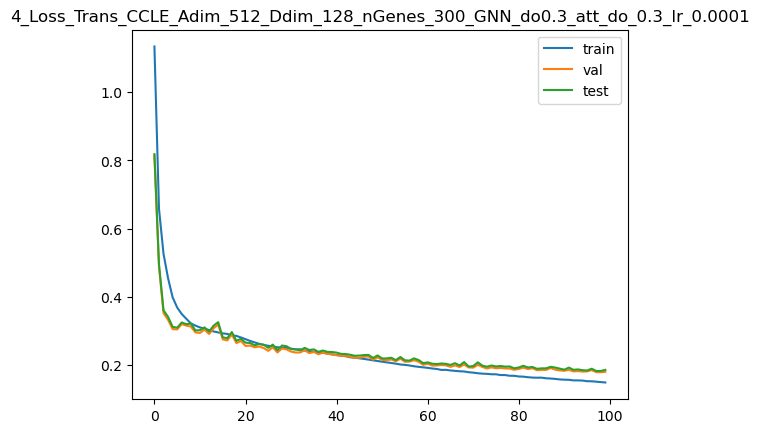

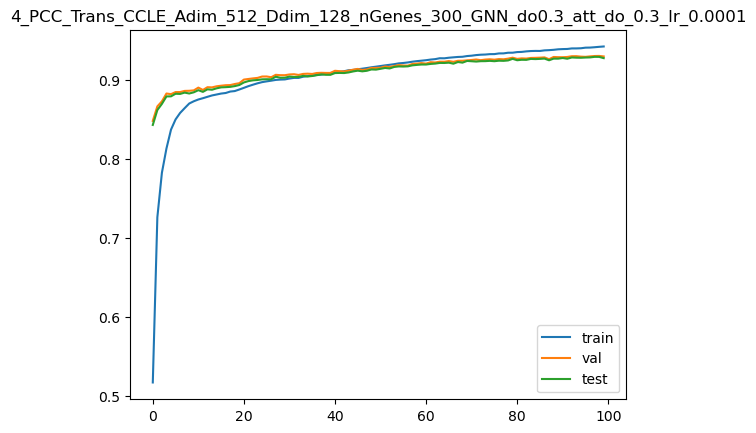

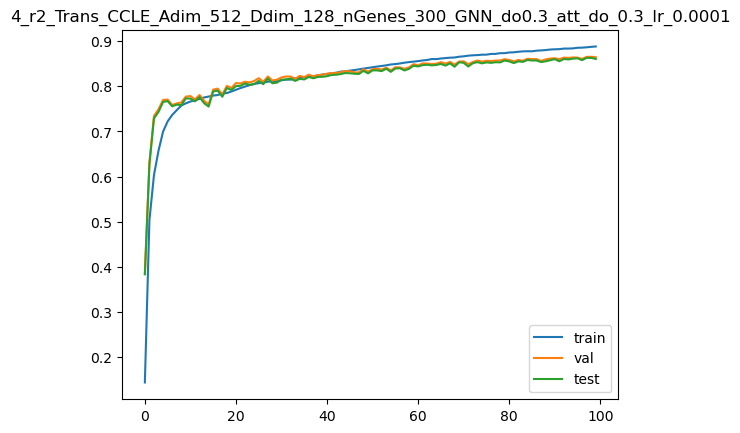

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14809325337409973
The overall Pearson's correlation is 0.9374.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13781967759132385
The overall Pearson's correlation is 0.9617.
Train avg_loss:  0.14818038
Train avg_pcc:  0.9424446696908169
Train r2:  0.8881950961920855


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.177811
Validation avg_pcc:  0.9307253644274284
Validation r2:  0.8657527826406965
Best Val r2  0.8657527826406965


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1807347
Test avg_pcc:  0.9297308101123621
Test r2:  0.8638554432342473
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17594850063323975
The overall Pearson's correlation is 0.8950.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1468924582004547
The overall Pearson's correlation is 0.9525.
Train avg_loss:  0.1473275
Train avg_pcc:  0.9427854498600339
Train r2:  0.888838599192505


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17714258
Validation avg_pcc:  0.9307643610323431
Validation r2:  0.866257450793561
Best Val r2  0.866257450793561


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1811969
Test avg_pcc:  0.9293329985000597
Test r2:  0.8635072697496883
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20077762007713318
The overall Pearson's correlation is 0.9288.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15870872139930725
The overall Pearson's correlation is 0.9563.
Train avg_loss:  0.14687397
Train avg_pcc:  0.9429667482121895
Train r2:  0.8891807986244383


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18215495
Validation avg_pcc:  0.9298690620721712
Validation r2:  0.8624731012895004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18310232
Test avg_pcc:  0.9297605308267212
Test r2:  0.8620719463073638
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1494961678981781
The overall Pearson's correlation is 0.9367.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1726193130016327
The overall Pearson's correlation is 0.9398.
Train avg_loss:  0.14665744
Train avg_pcc:  0.9430533518066689
Train r2:  0.8893441876713145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18016325
Validation avg_pcc:  0.930224268088542
Validation r2:  0.8639768308623372


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18230596
Test avg_pcc:  0.92953433822005
Test r2:  0.8626718284274122
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17294666171073914
The overall Pearson's correlation is 0.9450.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1433088779449463
The overall Pearson's correlation is 0.9514.
Train avg_loss:  0.14494027
Train avg_pcc:  0.943739526811035
Train r2:  0.8906398134829654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17482866
Validation avg_pcc:  0.9317794329659899
Validation r2:  0.8680044376267475
Best Val r2  0.8680044376267475


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17934708
Test avg_pcc:  0.93013525144875
Test r2:  0.8649007163378777
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1826673299074173
The overall Pearson's correlation is 0.9299.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14254453778266907
The overall Pearson's correlation is 0.9275.
Train avg_loss:  0.14423321
Train avg_pcc:  0.9440230637093765
Train r2:  0.8911733074034434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17730176
Validation avg_pcc:  0.9315090084811859
Validation r2:  0.8661372673040939


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1815266
Test avg_pcc:  0.9300500300595639
Test r2:  0.8632589141843882
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17071077227592468
The overall Pearson's correlation is 0.9364.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21189197897911072
The overall Pearson's correlation is 0.9398.
Train avg_loss:  0.1432963
Train avg_pcc:  0.9443966842657833
Train r2:  0.8918802127308438


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17985205
Validation avg_pcc:  0.9309043971335953
Validation r2:  0.8642117868822115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18406267
Test avg_pcc:  0.9294467528033725
Test r2:  0.8613485316814207
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11135265976190567
The overall Pearson's correlation is 0.9427.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12489692866802216
The overall Pearson's correlation is 0.9522.
Train avg_loss:  0.14346087
Train avg_pcc:  0.9443311829514841
Train r2:  0.8917560489538675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17573765
Validation avg_pcc:  0.9322281168550846
Validation r2:  0.8673181592055823


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17993662
Test avg_pcc:  0.9307036858100776
Test r2:  0.8644566153877843
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14292696118354797
The overall Pearson's correlation is 0.9422.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1350751519203186
The overall Pearson's correlation is 0.9576.
Train avg_loss:  0.14192374
Train avg_pcc:  0.9449457462676801
Train r2:  0.8929158436282579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1745386
Validation avg_pcc:  0.9319077074026276
Validation r2:  0.8682234607343584
Best Val r2  0.8682234607343584


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17733312
Test avg_pcc:  0.9308897112589054
Test r2:  0.8664178051947595
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14797699451446533
The overall Pearson's correlation is 0.9374.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10267576575279236
The overall Pearson's correlation is 0.9592.
Train avg_loss:  0.14182149
Train avg_pcc:  0.9449855846289448
Train r2:  0.8929930008626074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17954944
Validation avg_pcc:  0.9307429195493115
Validation r2:  0.8644402551781851


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18285933
Test avg_pcc:  0.9296438063346587
Test r2:  0.8622549716614613
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3333550691604614
The overall Pearson's correlation is 0.9034.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13077794015407562
The overall Pearson's correlation is 0.9658.
Train avg_loss:  0.14016789
Train avg_pcc:  0.9456461590789058
Train r2:  0.8942406609102183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17328843
Validation avg_pcc:  0.9325673536459396
Validation r2:  0.8691673176663361
Best Val r2  0.8691673176663361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17803334
Test avg_pcc:  0.9309082074922312
Test r2:  0.8658903367641749
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13345077633857727
The overall Pearson's correlation is 0.9456.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.39306801557540894
The overall Pearson's correlation is 0.8374.
Train avg_loss:  0.14053114
Train avg_pcc:  0.9455012562389714
Train r2:  0.8939665831761067


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17324127
Validation avg_pcc:  0.9330992863326633
Validation r2:  0.8692029256084779
Best Val r2  0.8692029256084779


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17633417
Test avg_pcc:  0.9321017271858657
Test r2:  0.8671702844023876
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12160158157348633
The overall Pearson's correlation is 0.9590.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08837597817182541
The overall Pearson's correlation is 0.9626.
Train avg_loss:  0.1389294
Train avg_pcc:  0.9461389517133255
Train r2:  0.895175122894471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17726508
Validation avg_pcc:  0.9315825444382293
Validation r2:  0.8661649555795052


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18091658
Test avg_pcc:  0.9304551866386811
Test r2:  0.8637184340278987
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1522272825241089
The overall Pearson's correlation is 0.9272.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1164809837937355
The overall Pearson's correlation is 0.9074.
Train avg_loss:  0.13914226
Train avg_pcc:  0.9460556535172512
Train r2:  0.8950145213411576


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17489003
Validation avg_pcc:  0.9323721837574349
Validation r2:  0.8679581101993308


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17761326
Test avg_pcc:  0.9313934732908158
Test r2:  0.8662067734007534
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1224665716290474
The overall Pearson's correlation is 0.9596.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1795436143875122
The overall Pearson's correlation is 0.8563.
Train avg_loss:  0.13859038
Train avg_pcc:  0.9462742427244826
Train r2:  0.8954309313131311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17357136
Validation avg_pcc:  0.9323624821939308
Validation r2:  0.8689537002976014


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17651932
Test avg_pcc:  0.9313809456537061
Test r2:  0.8670308113201021
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14946042001247406
The overall Pearson's correlation is 0.9411.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.210507333278656
The overall Pearson's correlation is 0.8965.
Train avg_loss:  0.13755001
Train avg_pcc:  0.9466902681935009
Train r2:  0.8962159125387887


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17331511
Validation avg_pcc:  0.9327608184480067
Validation r2:  0.8691471783078389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17600346
Test avg_pcc:  0.9318914893037712
Test r2:  0.8674194154604243
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15163123607635498
The overall Pearson's correlation is 0.9544.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1331842839717865
The overall Pearson's correlation is 0.9481.
Train avg_loss:  0.1363583
Train avg_pcc:  0.9471643504406559
Train r2:  0.8971150728609573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17712243
Validation avg_pcc:  0.9319839807728247
Validation r2:  0.8662726609852215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1789496
Test avg_pcc:  0.9313763832689012
Test r2:  0.8652001344480862
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12697593867778778
The overall Pearson's correlation is 0.9426.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18112455308437347
The overall Pearson's correlation is 0.9217.
Train avg_loss:  0.13703704
Train avg_pcc:  0.9468939206008304
Train r2:  0.8966029644107197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17328146
Validation avg_pcc:  0.9333151664283864
Validation r2:  0.8691725812895555


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17709227
Test avg_pcc:  0.9320129736830332
Test r2:  0.8665992333257331
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14870813488960266
The overall Pearson's correlation is 0.9532.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12739452719688416
The overall Pearson's correlation is 0.9551.
Train avg_loss:  0.13592234
Train avg_pcc:  0.9473375164845845
Train r2:  0.8974440271879311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17285764
Validation avg_pcc:  0.9330316559836856
Validation r2:  0.8694925689909844
Best Val r2  0.8694925689909844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17657147
Test avg_pcc:  0.9317669988526596
Test r2:  0.8669915284193377
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10457571595907211
The overall Pearson's correlation is 0.9614.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13798223435878754
The overall Pearson's correlation is 0.9466.
Train avg_loss:  0.13517249
Train avg_pcc:  0.9476367599440871
Train r2:  0.8980098048339124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17246717
Validation avg_pcc:  0.9338991470684929
Validation r2:  0.8697873620057303
Best Val r2  0.8697873620057303


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17661281
Test avg_pcc:  0.932520763877569
Test r2:  0.8669604024594202
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16161951422691345
The overall Pearson's correlation is 0.9552.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10475948452949524
The overall Pearson's correlation is 0.9614.
Train avg_loss:  0.13369629
Train avg_pcc:  0.948223670441357
Train r2:  0.8991236103178682


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17522852
Validation avg_pcc:  0.9315891440731018
Validation r2:  0.8677025585584732


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17757359
Test avg_pcc:  0.9308195789404863
Test r2:  0.8662366447961911
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07346931099891663
The overall Pearson's correlation is 0.9636.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12285715341567993
The overall Pearson's correlation is 0.9638.
Train avg_loss:  0.13393646
Train avg_pcc:  0.9481287252010832
Train r2:  0.8989423947405522


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1718448
Validation avg_pcc:  0.9333867121846896
Validation r2:  0.8702572487083097
Best Val r2  0.8702572487083097


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1745552
Test avg_pcc:  0.9325358687769394
Test r2:  0.8685103602371139
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11936148256063461
The overall Pearson's correlation is 0.9670.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12446032464504242
The overall Pearson's correlation is 0.9375.
Train avg_loss:  0.13307548
Train avg_pcc:  0.9484706003729876
Train r2:  0.8995920338659384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17237459
Validation avg_pcc:  0.9330978796066633
Validation r2:  0.8698572584401444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17453736
Test avg_pcc:  0.9322938970925687
Test r2:  0.8685237901946323
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14496280252933502
The overall Pearson's correlation is 0.9621.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11929328739643097
The overall Pearson's correlation is 0.9626.
Train avg_loss:  0.13195527
Train avg_pcc:  0.9489167831516623
Train r2:  0.9004372542472011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1736972
Validation avg_pcc:  0.9332770759976765
Validation r2:  0.8688586965292652


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17784333
Test avg_pcc:  0.931841116539684
Test r2:  0.8660334659063816
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11269594728946686
The overall Pearson's correlation is 0.9626.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14907415211200714
The overall Pearson's correlation is 0.9610.
Train avg_loss:  0.13184704
Train avg_pcc:  0.9489592137860754
Train r2:  0.9005189002056497


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16943447
Validation avg_pcc:  0.934065941662785
Validation r2:  0.8720770603794834
Best Val r2  0.8720770603794834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17372745
Test avg_pcc:  0.932473107088644
Test r2:  0.8691338859616851
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09450560808181763
The overall Pearson's correlation is 0.9640.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11456578969955444
The overall Pearson's correlation is 0.9486.
Train avg_loss:  0.131431
Train avg_pcc:  0.9491241692226761
Train r2:  0.9008328170513806


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17086256
Validation avg_pcc:  0.9339301765388848
Validation r2:  0.8709988635480009


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17502472
Test avg_pcc:  0.9325443298012026
Test r2:  0.8681566845326025
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14158087968826294
The overall Pearson's correlation is 0.9585.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10995255410671234
The overall Pearson's correlation is 0.9628.
Train avg_loss:  0.13078101
Train avg_pcc:  0.9493835941217016
Train r2:  0.9013232498043015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16991487
Validation avg_pcc:  0.9342528753893824
Validation r2:  0.8717143556461315


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17404754
Test avg_pcc:  0.9329019693819733
Test r2:  0.8688927675908372
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16183321177959442
The overall Pearson's correlation is 0.9458.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1669936180114746
The overall Pearson's correlation is 0.9413.
Train avg_loss:  0.13010953
Train avg_pcc:  0.9496502337818166
Train r2:  0.9018298737500589


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17043354
Validation avg_pcc:  0.9337602118789633
Validation r2:  0.8713227595841319


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17411163
Test avg_pcc:  0.9323531414807625
Test r2:  0.8688444815761716
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1095830500125885
The overall Pearson's correlation is 0.9578.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.164284810423851
The overall Pearson's correlation is 0.9307.
Train avg_loss:  0.12963015
Train avg_pcc:  0.9498399987121904
Train r2:  0.9021915954442357


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16881254
Validation avg_pcc:  0.9342256168733928
Validation r2:  0.8725466178195885
Best Val r2  0.8725466178195885


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17264129
Test avg_pcc:  0.9329255454101596
Test r2:  0.8699520715846262
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11324512213468552
The overall Pearson's correlation is 0.9529.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14243701100349426
The overall Pearson's correlation is 0.9390.
Train avg_loss:  0.12905161
Train avg_pcc:  0.9500705168066448
Train r2:  0.9026281076717079


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16856179
Validation avg_pcc:  0.9343930380389013
Validation r2:  0.8727359266166858
Best Val r2  0.8727359266166858


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17223981
Test avg_pcc:  0.933100650245749
Test r2:  0.8702545053024122
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11826212704181671
The overall Pearson's correlation is 0.9544.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15026268362998962
The overall Pearson's correlation is 0.9451.
Train avg_loss:  0.12887768
Train avg_pcc:  0.950138883340911
Train r2:  0.9027593469510571


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17225125
Validation avg_pcc:  0.9335237397354352
Validation r2:  0.8699503855609947


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17636298
Test avg_pcc:  0.9321053024923517
Test r2:  0.8671485851115693
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12509360909461975
The overall Pearson's correlation is 0.9417.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12543825805187225
The overall Pearson's correlation is 0.9510.
Train avg_loss:  0.12778595
Train avg_pcc:  0.9505728814489772
Train r2:  0.9035830692586911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16915312
Validation avg_pcc:  0.9348075094261558
Validation r2:  0.8722894736473293


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17228861
Test avg_pcc:  0.9337276294752134
Test r2:  0.8702177477789135
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11230215430259705
The overall Pearson's correlation is 0.9413.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07119527459144592
The overall Pearson's correlation is 0.9767.
Train avg_loss:  0.12691881
Train avg_pcc:  0.950916756951831
Train r2:  0.9042373509526223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16934198
Validation avg_pcc:  0.9341521740332002
Validation r2:  0.8721468792958011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17173845
Test avg_pcc:  0.9332994615880964
Test r2:  0.8706321739692389
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11207835376262665
The overall Pearson's correlation is 0.9541.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08810694515705109
The overall Pearson's correlation is 0.9641.
Train avg_loss:  0.12616572
Train avg_pcc:  0.9512156321657261
Train r2:  0.9048055647619437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17231572
Validation avg_pcc:  0.9343648598675892
Validation r2:  0.8699017251012083


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1760657
Test avg_pcc:  0.9330993654326137
Test r2:  0.8673725255843412
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10894940793514252
The overall Pearson's correlation is 0.9682.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11194261163473129
The overall Pearson's correlation is 0.9621.
Train avg_loss:  0.1264054
Train avg_pcc:  0.9511200886412547
Train r2:  0.904624725880951


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16995788
Validation avg_pcc:  0.9344635312495384
Validation r2:  0.8716818911539124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17277065
Test avg_pcc:  0.9336235977331211
Test r2:  0.8698546414332885
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12431184202432632
The overall Pearson's correlation is 0.9583.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1333915740251541
The overall Pearson's correlation is 0.9498.
Train avg_loss:  0.12655465
Train avg_pcc:  0.9510611623942188
Train r2:  0.904512097186621


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17006837
Validation avg_pcc:  0.9342700091346106
Validation r2:  0.8715984730714227


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1730865
Test avg_pcc:  0.9333310766967471
Test r2:  0.8696167066642919
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12254174053668976
The overall Pearson's correlation is 0.9529.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0825340747833252
The overall Pearson's correlation is 0.9570.
Train avg_loss:  0.124148965
Train avg_pcc:  0.9520144724147606
Train r2:  0.9063272543672839


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16705763
Validation avg_pcc:  0.9349053364595171
Validation r2:  0.8738715687923795
Best Val r2  0.8738715687923795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17078304
Test avg_pcc:  0.9335996817015398
Test r2:  0.8713518707724999
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11116045713424683
The overall Pearson's correlation is 0.9372.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.109413281083107
The overall Pearson's correlation is 0.9682.
Train avg_loss:  0.12469285
Train avg_pcc:  0.9517991886152743
Train r2:  0.9059168817135818


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17049661
Validation avg_pcc:  0.9345753045756843
Validation r2:  0.8712751407522158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17397045
Test avg_pcc:  0.93353939353881
Test r2:  0.8689508380034667
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10355476289987564
The overall Pearson's correlation is 0.9438.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16664192080497742
The overall Pearson's correlation is 0.9448.
Train avg_loss:  0.123879015
Train avg_pcc:  0.9521221575471708
Train r2:  0.9065309288560491


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16925766
Validation avg_pcc:  0.9346809878197924
Validation r2:  0.8722105565847639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17278767
Test avg_pcc:  0.9333384400283585
Test r2:  0.8698418204709382
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11347328126430511
The overall Pearson's correlation is 0.9585.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1635606288909912
The overall Pearson's correlation is 0.9405.
Train avg_loss:  0.12386073
Train avg_pcc:  0.9521286092625384
Train r2:  0.9065447289981848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17172392
Validation avg_pcc:  0.9341872817918312
Validation r2:  0.8703485248293972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1747949
Test avg_pcc:  0.933231614548799
Test r2:  0.8683297965347248
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11822324991226196
The overall Pearson's correlation is 0.9447.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09913408011198044
The overall Pearson's correlation is 0.9658.
Train avg_loss:  0.12330814
Train avg_pcc:  0.9523475033137219
Train r2:  0.906961668899842


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16987827
Validation avg_pcc:  0.9344524172763459
Validation r2:  0.8717419866726758


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17217807
Test avg_pcc:  0.9338121715549894
Test r2:  0.8703010242177496
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10692010819911957
The overall Pearson's correlation is 0.9613.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09834514558315277
The overall Pearson's correlation is 0.9597.
Train avg_loss:  0.12290528
Train avg_pcc:  0.95250734156143
Train r2:  0.9072656410889729


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16960557
Validation avg_pcc:  0.9353727408208368
Validation r2:  0.8719478778215668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17347096
Test avg_pcc:  0.9337468623818422
Test r2:  0.8693271125700333
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1415175497531891
The overall Pearson's correlation is 0.9649.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08431261777877808
The overall Pearson's correlation is 0.9658.
Train avg_loss:  0.12128734
Train avg_pcc:  0.9531476614878386
Train r2:  0.9084864047765847


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16729666
Validation avg_pcc:  0.9356871669118723
Validation r2:  0.8736911026144965


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17179778
Test avg_pcc:  0.9337949540108946
Test r2:  0.870587472838362
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11833406984806061
The overall Pearson's correlation is 0.9428.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14418327808380127
The overall Pearson's correlation is 0.9490.
Train avg_loss:  0.12102021
Train avg_pcc:  0.9532533390313636
Train r2:  0.9086879587332688


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16921535
Validation avg_pcc:  0.9343952540556509
Validation r2:  0.8722424994149484


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17302687
Test avg_pcc:  0.9330776244464823
Test r2:  0.8696616330831176
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09494736045598984
The overall Pearson's correlation is 0.9681.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12177352607250214
The overall Pearson's correlation is 0.9591.
Train avg_loss:  0.121678
Train avg_pcc:  0.9529935199395725
Train r2:  0.9081916440946575


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16825783
Validation avg_pcc:  0.9352491322151395
Validation r2:  0.8729654226947681


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17207673
Test avg_pcc:  0.9338807321632452
Test r2:  0.8703773488384495
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1192135214805603
The overall Pearson's correlation is 0.9569.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1199624165892601
The overall Pearson's correlation is 0.9476.
Train avg_loss:  0.120972686
Train avg_pcc:  0.9532728907790371
Train r2:  0.9087238064187568


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16734366
Validation avg_pcc:  0.9350116494872501
Validation r2:  0.8736556148681124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16979295
Test avg_pcc:  0.9342476609502894
Test r2:  0.8720976798916446
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12451358139514923
The overall Pearson's correlation is 0.9502.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1028597429394722
The overall Pearson's correlation is 0.9704.
Train avg_loss:  0.12056876
Train avg_pcc:  0.9534320643350327
Train r2:  0.9090285858654849


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16705972
Validation avg_pcc:  0.9352165862943129
Validation r2:  0.8738699988157628


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17070252
Test avg_pcc:  0.9340039655939146
Test r2:  0.8714125156580409
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08786223828792572
The overall Pearson's correlation is 0.9611.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1317708045244217
The overall Pearson's correlation is 0.9442.
Train avg_loss:  0.11966842
Train avg_pcc:  0.953788550944773
Train r2:  0.9097078954271675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16779667
Validation avg_pcc:  0.9352526125892658
Validation r2:  0.8733136079880794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1721424
Test avg_pcc:  0.9337857394877979
Test r2:  0.8703278783331658
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11715143918991089
The overall Pearson's correlation is 0.9562.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11628881096839905
The overall Pearson's correlation is 0.9565.
Train avg_loss:  0.12002912
Train avg_pcc:  0.9536455513106324
Train r2:  0.9094357549391272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16876523
Validation avg_pcc:  0.9342307859305115
Validation r2:  0.872582336384577


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1718142
Test avg_pcc:  0.9332058184505889
Test r2:  0.8705751084677944
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11611618101596832
The overall Pearson's correlation is 0.9380.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14983391761779785
The overall Pearson's correlation is 0.9479.
Train avg_loss:  0.11870534
Train avg_pcc:  0.9541699173033821
Train r2:  0.9104345672179378


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17040044
Validation avg_pcc:  0.9346718159429467
Validation r2:  0.8713477605480876


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1735186
Test avg_pcc:  0.9335504818379398
Test r2:  0.8692912105365778


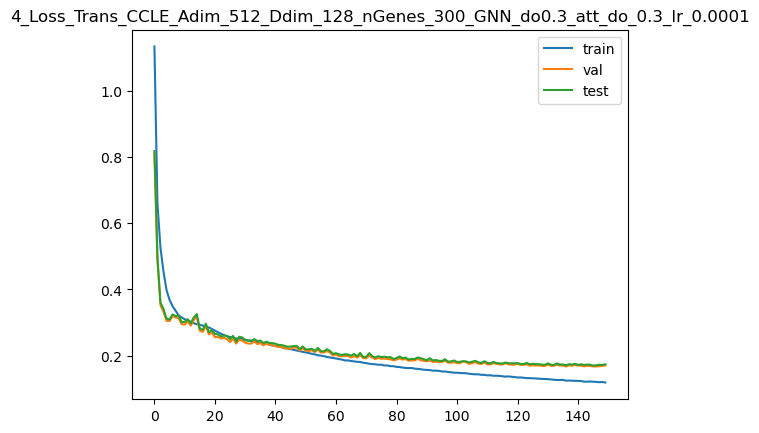

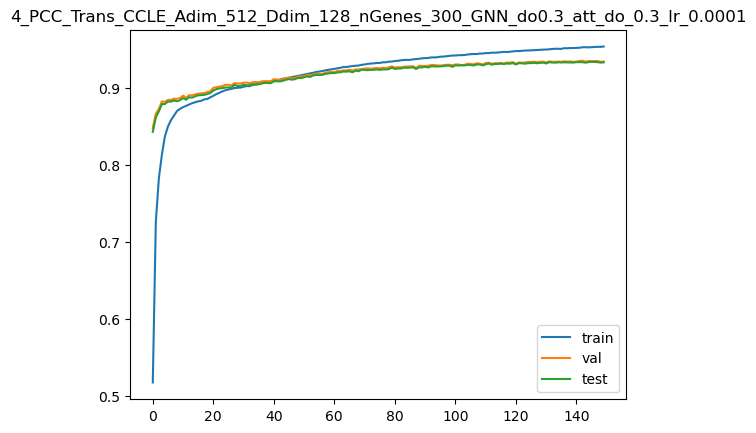

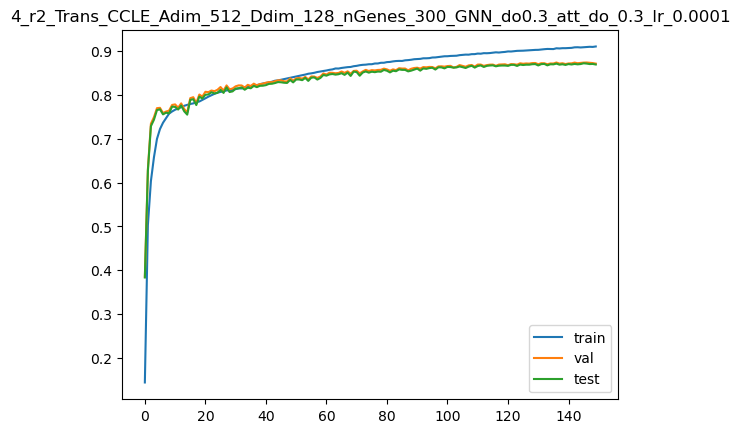

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17078304
Test avg_pcc:  0.9335996817485702
Test r2:  0.8713518709404884


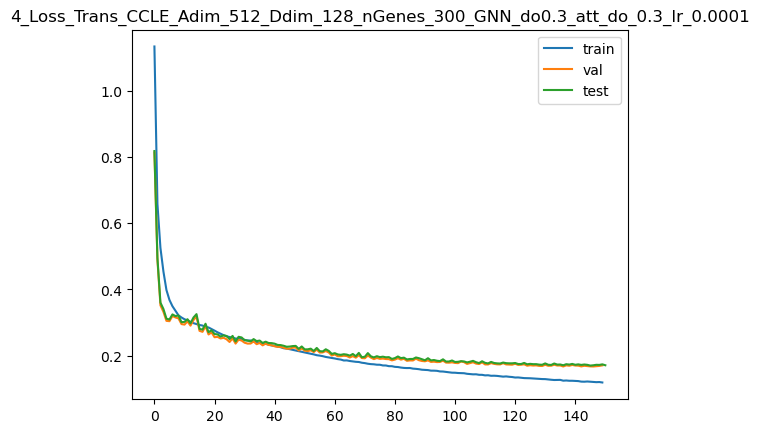

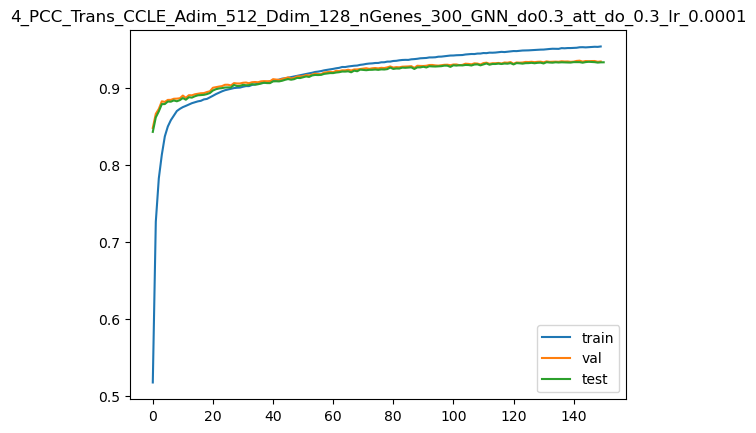

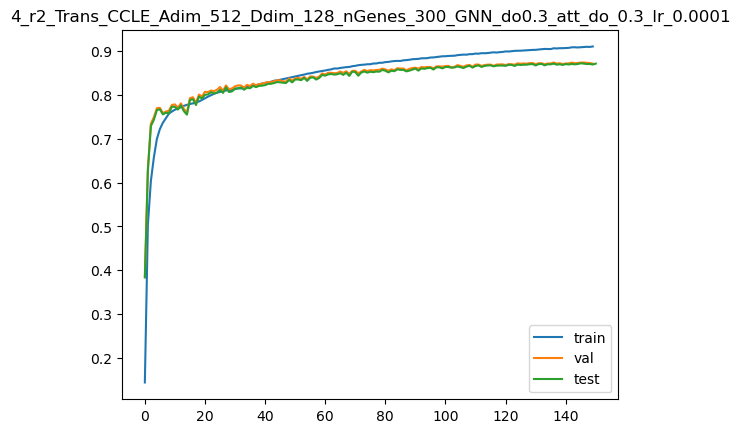

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.9274889230728149
The overall Pearson's correlation is 0.6048.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.7313665747642517
The overall Pearson's correlation is 0.7153.
Train avg_loss:  1.1206067
Train avg_pcc:  0.5200072278668207
Train r2:  0.15044362084496132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.43329275
Validation avg_pcc:  0.8410141865712435
Validation r2:  0.6761559879718356
Best Val r2  0.6761559879718356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.42794713
Test avg_pcc:  0.8403989721531345
Test r2:  0.6813595839414983
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.5651639699935913
The overall Pearson's correlation is 0.7684.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.7110676765441895
The overall Pearson's correlation is 0.6944.
Train avg_loss:  0.64839256
Train avg_pcc:  0.7284875883740175
Train r2:  0.5084394395171569


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.36748138
Validation avg_pcc:  0.8635012187452749
Validation r2:  0.7253435328892361
Best Val r2  0.7253435328892361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3678944
Test avg_pcc:  0.8623328174740177
Test r2:  0.7260735897568293
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.48584964871406555
The overall Pearson's correlation is 0.8392.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.8078483939170837
The overall Pearson's correlation is 0.7333.
Train avg_loss:  0.51763904
Train avg_pcc:  0.7848614555537842
Train r2:  0.6075665060048647


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.36124238
Validation avg_pcc:  0.8716325271679324
Validation r2:  0.7300065676597067
Best Val r2  0.7300065676597067


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.35707507
Test avg_pcc:  0.8719972427965563
Test r2:  0.73412941992933
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.7091661691665649
The overall Pearson's correlation is 0.8096.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3501572906970978
The overall Pearson's correlation is 0.8533.
Train avg_loss:  0.4387508
Train avg_pcc:  0.818889095686012
Train r2:  0.6673734386023648


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3511198
Validation avg_pcc:  0.8744395867427618
Validation r2:  0.7375722030813145
Best Val r2  0.7375722030813145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34522095
Test avg_pcc:  0.8757213127301671
Test r2:  0.7429557537462372
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21872511506080627
The overall Pearson's correlation is 0.9189.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.29038146138191223
The overall Pearson's correlation is 0.8924.
Train avg_loss:  0.3956237
Train avg_pcc:  0.8373982227271727
Train r2:  0.7000690456391769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.38128725
Validation avg_pcc:  0.8767522403663984
Validation r2:  0.7150249851820434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.37732455
Test avg_pcc:  0.8774773509714807
Test r2:  0.7190520794305463
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2518649399280548
The overall Pearson's correlation is 0.9003.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23073284327983856
The overall Pearson's correlation is 0.9149.
Train avg_loss:  0.36543897
Train avg_pcc:  0.8505326970893876
Train r2:  0.7229527672817169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33318743
Validation avg_pcc:  0.88292810268658
Validation r2:  0.7509748913130612
Best Val r2  0.7509748913130612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33238536
Test avg_pcc:  0.882132561415915
Test r2:  0.7525128818523201
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2658139765262604
The overall Pearson's correlation is 0.8912.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.30757319927215576
The overall Pearson's correlation is 0.9237.
Train avg_loss:  0.34563383
Train avg_pcc:  0.8591485180430811
Train r2:  0.7379674488588


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3391474
Validation avg_pcc:  0.8848437022621799
Validation r2:  0.7465204281895548


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3379245
Test avg_pcc:  0.8843728113494792
Test r2:  0.7483885660206886
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2138746827840805
The overall Pearson's correlation is 0.9325.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.36087462306022644
The overall Pearson's correlation is 0.8669.
Train avg_loss:  0.33144277
Train avg_pcc:  0.8653306432669211
Train r2:  0.7487260187467967


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30698887
Validation avg_pcc:  0.8859515563577749
Validation r2:  0.7705557664382554
Best Val r2  0.7705557664382554


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30554435
Test avg_pcc:  0.8862074349752194
Test r2:  0.7724981470669465
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4096434712409973
The overall Pearson's correlation is 0.8470.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2524109184741974
The overall Pearson's correlation is 0.9159.
Train avg_loss:  0.3196331
Train avg_pcc:  0.8704735396765566
Train r2:  0.7576791916688057


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30071023
Validation avg_pcc:  0.8849055152942832
Validation r2:  0.7752484478105024
Best Val r2  0.7752484478105024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30110607
Test avg_pcc:  0.8847945502357798
Test r2:  0.7758027999902177
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3561639189720154
The overall Pearson's correlation is 0.8611.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2679435610771179
The overall Pearson's correlation is 0.8999.
Train avg_loss:  0.31427246
Train avg_pcc:  0.8727946362447864
Train r2:  0.7617431656822486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3171008
Validation avg_pcc:  0.8875908537598755
Validation r2:  0.7629980862109662


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31311432
Test avg_pcc:  0.8879831393951967
Test r2:  0.7668616890097532
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2669728994369507
The overall Pearson's correlation is 0.9079.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21654266119003296
The overall Pearson's correlation is 0.9306.
Train avg_loss:  0.3056568
Train avg_pcc:  0.8765289830293561
Train r2:  0.7682749059427219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30065468
Validation avg_pcc:  0.8886393362732453
Validation r2:  0.7752899525204534
Best Val r2  0.7752899525204534


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30310702
Test avg_pcc:  0.8873400961024364
Test r2:  0.7743129098503285
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1787174940109253
The overall Pearson's correlation is 0.9414.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3693235218524933
The overall Pearson's correlation is 0.8653.
Train avg_loss:  0.30289468
Train avg_pcc:  0.8777177685549797
Train r2:  0.7703689283109219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30413496
Validation avg_pcc:  0.8875547419353987
Validation r2:  0.772688788842921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3029663
Test avg_pcc:  0.8874836323405688
Test r2:  0.7744176994879476
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25914880633354187
The overall Pearson's correlation is 0.8717.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3165466785430908
The overall Pearson's correlation is 0.8394.
Train avg_loss:  0.29911485
Train avg_pcc:  0.8793478649667444
Train r2:  0.7732345001440697


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30264336
Validation avg_pcc:  0.8893670032752979
Validation r2:  0.7738036056444518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30046147
Test avg_pcc:  0.8897863356052065
Test r2:  0.7762827221372763
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23330058157444
The overall Pearson's correlation is 0.9153.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25168293714523315
The overall Pearson's correlation is 0.8909.
Train avg_loss:  0.29628372
Train avg_pcc:  0.8805700293159425
Train r2:  0.7753808387955229


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2839951
Validation avg_pcc:  0.8904028383251393
Validation r2:  0.7877413929377752
Best Val r2  0.7877413929377752


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28205055
Test avg_pcc:  0.8909874991874245
Test r2:  0.7899910914511988
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2383165806531906
The overall Pearson's correlation is 0.8481.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2949121594429016
The overall Pearson's correlation is 0.8599.
Train avg_loss:  0.29404423
Train avg_pcc:  0.8815301081554376
Train r2:  0.7770786578278188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29564703
Validation avg_pcc:  0.890508946389025
Validation r2:  0.7790326743290132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29553747
Test avg_pcc:  0.8901074491068803
Test r2:  0.7799490292091731
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20143291354179382
The overall Pearson's correlation is 0.8894.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2381705343723297
The overall Pearson's correlation is 0.9256.
Train avg_loss:  0.29159197
Train avg_pcc:  0.8825849705407669
Train r2:  0.7789377658670635


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2897954
Validation avg_pcc:  0.890421003167367
Validation r2:  0.7834062084473863


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2881549
Test avg_pcc:  0.8911926370661358
Test r2:  0.785445959360995
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3217698335647583
The overall Pearson's correlation is 0.8032.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.30038729310035706
The overall Pearson's correlation is 0.8501.
Train avg_loss:  0.28853935
Train avg_pcc:  0.8838945006793412
Train r2:  0.7812520060265709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28526917
Validation avg_pcc:  0.8912339804450157
Validation r2:  0.786789124019768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2856748
Test avg_pcc:  0.8908608187522244
Test r2:  0.7872925504110284
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20418399572372437
The overall Pearson's correlation is 0.9263.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19320595264434814
The overall Pearson's correlation is 0.9024.
Train avg_loss:  0.28560367
Train avg_pcc:  0.8851522295822165
Train r2:  0.783477631684265


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29424307
Validation avg_pcc:  0.8914652072580648
Validation r2:  0.780082012665619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2956049
Test avg_pcc:  0.8905727085036648
Test r2:  0.7798988157908407
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3093794882297516
The overall Pearson's correlation is 0.8564.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3397442698478699
The overall Pearson's correlation is 0.8806.
Train avg_loss:  0.28172988
Train avg_pcc:  0.8868097477328968
Train r2:  0.7864144378697335


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27090585
Validation avg_pcc:  0.8939823225192493
Validation r2:  0.7975242965962435
Best Val r2  0.7975242965962435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27268353
Test avg_pcc:  0.8933681104091544
Test r2:  0.7969655915524747
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.30701500177383423
The overall Pearson's correlation is 0.9242.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2929145097732544
The overall Pearson's correlation is 0.8921.
Train avg_loss:  0.2763869
Train avg_pcc:  0.8890907911016288
Train r2:  0.7904651042822152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27476645
Validation avg_pcc:  0.8950650036487583
Validation r2:  0.7946388982627106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27732867
Test avg_pcc:  0.8941508788703111
Test r2:  0.7935069329622715
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.35287511348724365
The overall Pearson's correlation is 0.8454.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23137785494327545
The overall Pearson's correlation is 0.8888.
Train avg_loss:  0.2724012
Train avg_pcc:  0.8907877516813452
Train r2:  0.7934866987251944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26073575
Validation avg_pcc:  0.9001588895991607
Validation r2:  0.8051254596587483
Best Val r2  0.8051254596587483


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26368678
Test avg_pcc:  0.8990704942479485
Test r2:  0.8036643757400965
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27947938442230225
The overall Pearson's correlation is 0.7870.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4320913255214691
The overall Pearson's correlation is 0.8322.
Train avg_loss:  0.2680418
Train avg_pcc:  0.8926419728176054
Train r2:  0.7967916785797317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25977108
Validation avg_pcc:  0.8993022696677254
Validation r2:  0.8058464509308008
Best Val r2  0.8058464509308008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2599088
Test avg_pcc:  0.8992817890377888
Test r2:  0.8064774163926618
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32851237058639526
The overall Pearson's correlation is 0.9237.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2500762939453125
The overall Pearson's correlation is 0.9043.
Train avg_loss:  0.26384538
Train avg_pcc:  0.8944202107113141
Train r2:  0.7999730346338644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2563419
Validation avg_pcc:  0.9011964713168911
Validation r2:  0.8084094345887682
Best Val r2  0.8084094345887682


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25864393
Test avg_pcc:  0.9005389540634885
Test r2:  0.8074191772008827
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.253521203994751
The overall Pearson's correlation is 0.9226.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23704560101032257
The overall Pearson's correlation is 0.8854.
Train avg_loss:  0.2618057
Train avg_pcc:  0.8952857874650637
Train r2:  0.8015193782756829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25508797
Validation avg_pcc:  0.9016318969441179
Validation r2:  0.809346630513451
Best Val r2  0.809346630513451


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2581233
Test avg_pcc:  0.9003355337504632
Test r2:  0.8078068409232806
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2717825770378113
The overall Pearson's correlation is 0.9062.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19011454284191132
The overall Pearson's correlation is 0.9326.
Train avg_loss:  0.25795364
Train avg_pcc:  0.8969132908367423
Train r2:  0.8044397155133431


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25817066
Validation avg_pcc:  0.9019416578581111
Validation r2:  0.8070426243109063


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26109675
Test avg_pcc:  0.9004188360188278
Test r2:  0.8055928525154633
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22591808438301086
The overall Pearson's correlation is 0.8954.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14896129071712494
The overall Pearson's correlation is 0.9648.
Train avg_loss:  0.25560752
Train avg_pcc:  0.897906266071563
Train r2:  0.8062184085097813


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2570161
Validation avg_pcc:  0.9018605936155998
Validation r2:  0.8079055401869989


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.260145
Test avg_pcc:  0.901085142498883
Test r2:  0.8063015322950938
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32219868898391724
The overall Pearson's correlation is 0.9120.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2164674699306488
The overall Pearson's correlation is 0.9155.
Train avg_loss:  0.25379243
Train avg_pcc:  0.898671285087549
Train r2:  0.8075944025849665


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24880615
Validation avg_pcc:  0.9041944882965754
Validation r2:  0.8140416860736863
Best Val r2  0.8140416860736863


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25177562
Test avg_pcc:  0.9034430950804214
Test r2:  0.8125332136586996
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24932655692100525
The overall Pearson's correlation is 0.8665.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1603918969631195
The overall Pearson's correlation is 0.9435.
Train avg_loss:  0.25235483
Train avg_pcc:  0.8992770266633304
Train r2:  0.808684283461708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24915262
Validation avg_pcc:  0.9045495015167293
Validation r2:  0.8137827300826113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25167632
Test avg_pcc:  0.9039100588687635
Test r2:  0.8126071276681
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24495479464530945
The overall Pearson's correlation is 0.9430.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2099844217300415
The overall Pearson's correlation is 0.8863.
Train avg_loss:  0.25016275
Train avg_pcc:  0.9001998153078317
Train r2:  0.8103461496867026


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24436116
Validation avg_pcc:  0.9048081314755945
Validation r2:  0.817363873180281
Best Val r2  0.817363873180281


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24858314
Test avg_pcc:  0.9036869285577649
Test r2:  0.8149102463249287
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3436889052391052
The overall Pearson's correlation is 0.8815.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22542564570903778
The overall Pearson's correlation is 0.9202.
Train avg_loss:  0.24844767
Train avg_pcc:  0.9009211503435354
Train r2:  0.8116464103732387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24627316
Validation avg_pcc:  0.9052045030481222
Validation r2:  0.8159348394613223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24933621
Test avg_pcc:  0.9045006926911131
Test r2:  0.8143495320842387
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3063216209411621
The overall Pearson's correlation is 0.8685.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2253921627998352
The overall Pearson's correlation is 0.9080.
Train avg_loss:  0.2477747
Train avg_pcc:  0.9012049490373507
Train r2:  0.8121565815228586


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2545749
Validation avg_pcc:  0.9041497002385663
Validation r2:  0.8097301135365615


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25583318
Test avg_pcc:  0.9041275562482031
Test r2:  0.8095120213988647
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22258439660072327
The overall Pearson's correlation is 0.9110.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.321392297744751
The overall Pearson's correlation is 0.8890.
Train avg_loss:  0.24503362
Train avg_pcc:  0.9023562137549279
Train r2:  0.8142346709300514


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2582468
Validation avg_pcc:  0.9039498968988186
Validation r2:  0.8069857257909725


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25935885
Test avg_pcc:  0.9038657015078312
Test r2:  0.8068868646130876
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24234981834888458
The overall Pearson's correlation is 0.9115.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.31943193078041077
The overall Pearson's correlation is 0.8667.
Train avg_loss:  0.2431481
Train avg_pcc:  0.9031476680253578
Train r2:  0.8156640943076918


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24604708
Validation avg_pcc:  0.9052962877747872
Validation r2:  0.8161038239635382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2468383
Test avg_pcc:  0.9052691371083592
Test r2:  0.816209417064554
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26892244815826416
The overall Pearson's correlation is 0.8854.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.31177282333374023
The overall Pearson's correlation is 0.8602.
Train avg_loss:  0.24274626
Train avg_pcc:  0.9033173002704187
Train r2:  0.8159687665292112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24209732
Validation avg_pcc:  0.9068875149844842
Validation r2:  0.8190558754988948
Best Val r2  0.8190558754988948


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24478807
Test avg_pcc:  0.9063669147748301
Test r2:  0.8177359666379258
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.221063494682312
The overall Pearson's correlation is 0.9128.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22688548266887665
The overall Pearson's correlation is 0.9396.
Train avg_loss:  0.24071985
Train avg_pcc:  0.9041652095031414
Train r2:  0.8175050350977127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25129187
Validation avg_pcc:  0.9059026741031083
Validation r2:  0.8121838441543211


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2541297
Test avg_pcc:  0.9049917036362289
Test r2:  0.8107803651110503
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16019505262374878
The overall Pearson's correlation is 0.9092.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18882939219474792
The overall Pearson's correlation is 0.9155.
Train avg_loss:  0.23936078
Train avg_pcc:  0.9047377577713287
Train r2:  0.8185353451880171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23553504
Validation avg_pcc:  0.9078658695386738
Validation r2:  0.8239605344801946
Best Val r2  0.8239605344801946


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24001043
Test avg_pcc:  0.9063299901270961
Test r2:  0.821293291440053
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23649603128433228
The overall Pearson's correlation is 0.9113.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13343024253845215
The overall Pearson's correlation is 0.9457.
Train avg_loss:  0.23891205
Train avg_pcc:  0.9049219439621534
Train r2:  0.8188755497504879


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23997138
Validation avg_pcc:  0.9066891077547071
Validation r2:  0.8206448063580433


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23921353
Test avg_pcc:  0.9071056904230164
Test r2:  0.8218866588499074
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2581872344017029
The overall Pearson's correlation is 0.9095.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13567914068698883
The overall Pearson's correlation is 0.9385.
Train avg_loss:  0.23682694
Train avg_pcc:  0.9057979091171379
Train r2:  0.8204563333705134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2352744
Validation avg_pcc:  0.9082000018901779
Validation r2:  0.8241553440429735
Best Val r2  0.8241553440429735


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23931557
Test avg_pcc:  0.9067879847918816
Test r2:  0.8218106780861245
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.36597463488578796
The overall Pearson's correlation is 0.9182.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2670370042324066
The overall Pearson's correlation is 0.8798.
Train avg_loss:  0.23518631
Train avg_pcc:  0.9064817709632453
Train r2:  0.821700127683866


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24116038
Validation avg_pcc:  0.9078870690867429
Validation r2:  0.8197561345655461


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24241515
Test avg_pcc:  0.9076540171469332
Test r2:  0.8195027992258626
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18850943446159363
The overall Pearson's correlation is 0.8894.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1942034512758255
The overall Pearson's correlation is 0.9418.
Train avg_loss:  0.23347773
Train avg_pcc:  0.9071970997280091
Train r2:  0.8229954153663475


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2402181
Validation avg_pcc:  0.908332837124995
Validation r2:  0.8204603972266264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24396442
Test avg_pcc:  0.9076887292831046
Test r2:  0.8183492447159154
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18775492906570435
The overall Pearson's correlation is 0.9319.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22528645396232605
The overall Pearson's correlation is 0.9364.
Train avg_loss:  0.23153707
Train avg_pcc:  0.9080065500230492
Train r2:  0.8244666790358239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23993655
Validation avg_pcc:  0.909144880840917
Validation r2:  0.8206708522572318


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24279591
Test avg_pcc:  0.908534265987987
Test r2:  0.8192192901470845
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19647707045078278
The overall Pearson's correlation is 0.9352.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2706278860569
The overall Pearson's correlation is 0.8853.
Train avg_loss:  0.22887857
Train avg_pcc:  0.9091152809304833
Train r2:  0.826482174725192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23284715
Validation avg_pcc:  0.9099702953623867
Validation r2:  0.8259694768142742
Best Val r2  0.8259694768142742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23559141
Test avg_pcc:  0.9090716795284813
Test r2:  0.8245836118364329
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23249240219593048
The overall Pearson's correlation is 0.9277.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.30519717931747437
The overall Pearson's correlation is 0.8855.
Train avg_loss:  0.2273544
Train avg_pcc:  0.9097516009227112
Train r2:  0.8276376596926591


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22949106
Validation avg_pcc:  0.9108322601420418
Validation r2:  0.8284778287999348
Best Val r2  0.8284778287999348


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22984673
Test avg_pcc:  0.911131471566078
Test r2:  0.8288609696925364
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2376316487789154
The overall Pearson's correlation is 0.8914.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2525249123573303
The overall Pearson's correlation is 0.9092.
Train avg_loss:  0.22527526
Train avg_pcc:  0.9106157903468437
Train r2:  0.8292139008002981


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23468685
Validation avg_pcc:  0.9099848431908688
Validation r2:  0.8245944776526934


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23349352
Test avg_pcc:  0.9104802424243907
Test r2:  0.8261456427959292
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19343309104442596
The overall Pearson's correlation is 0.9370.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21980251371860504
The overall Pearson's correlation is 0.8809.
Train avg_loss:  0.2237367
Train avg_pcc:  0.9112572581339939
Train r2:  0.8303803163252609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22915292
Validation avg_pcc:  0.9113039230365403
Validation r2:  0.828730557262777
Best Val r2  0.828730557262777


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22966138
Test avg_pcc:  0.9114985518625888
Test r2:  0.8289989948242088
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1558975875377655
The overall Pearson's correlation is 0.9271.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2572149634361267
The overall Pearson's correlation is 0.8607.
Train avg_loss:  0.22194815
Train avg_pcc:  0.9120004228634866
Train r2:  0.8317362673626685


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23126575
Validation avg_pcc:  0.9102485919997582
Validation r2:  0.8271514271956155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23306003
Test avg_pcc:  0.9098388548534507
Test r2:  0.8264684183667033
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1908857822418213
The overall Pearson's correlation is 0.9388.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15368592739105225
The overall Pearson's correlation is 0.9318.
Train avg_loss:  0.21941134
Train avg_pcc:  0.9130540702612842
Train r2:  0.8336594619013586


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22893722
Validation avg_pcc:  0.9119686626478545
Validation r2:  0.8288917695818323
Best Val r2  0.8288917695818323


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23042788
Test avg_pcc:  0.9115671071299651
Test r2:  0.8284282743017988
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2984478175640106
The overall Pearson's correlation is 0.8877.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1795438826084137
The overall Pearson's correlation is 0.9114.
Train avg_loss:  0.21762173
Train avg_pcc:  0.9137973490370777
Train r2:  0.8350162036286786


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22479557
Validation avg_pcc:  0.9130139757048371
Validation r2:  0.831987241293401
Best Val r2  0.831987241293401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22623515
Test avg_pcc:  0.912870207693685
Test r2:  0.8315500718077149
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23788827657699585
The overall Pearson's correlation is 0.8839.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14941149950027466
The overall Pearson's correlation is 0.9421.
Train avg_loss:  0.2152785
Train avg_pcc:  0.9147680999514203
Train r2:  0.8367926444122992


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22341417
Validation avg_pcc:  0.9131968964548361
Validation r2:  0.833019702902952
Best Val r2  0.833019702902952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2239777
Test avg_pcc:  0.913267023842523
Test r2:  0.8332309317502193
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2231915295124054
The overall Pearson's correlation is 0.8976.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.207886204123497
The overall Pearson's correlation is 0.9188.
Train avg_loss:  0.21398205
Train avg_pcc:  0.9153062931459044
Train r2:  0.8377755510516962


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2277304
Validation avg_pcc:  0.9129597458300682
Validation r2:  0.8297937475954493


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2287837
Test avg_pcc:  0.9130398915957737
Test r2:  0.8296524765371112


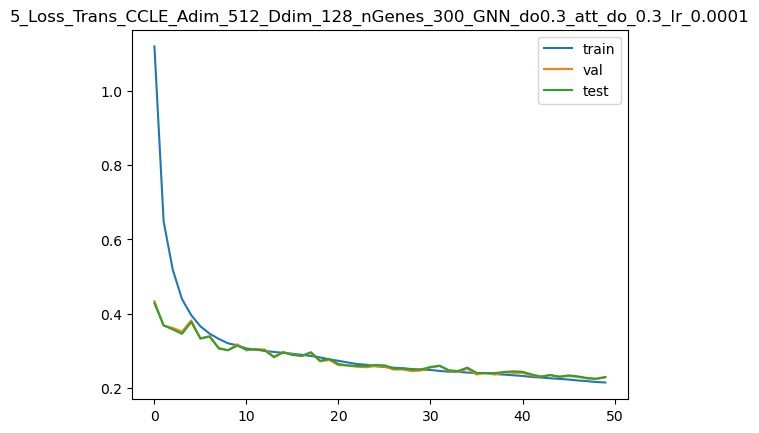

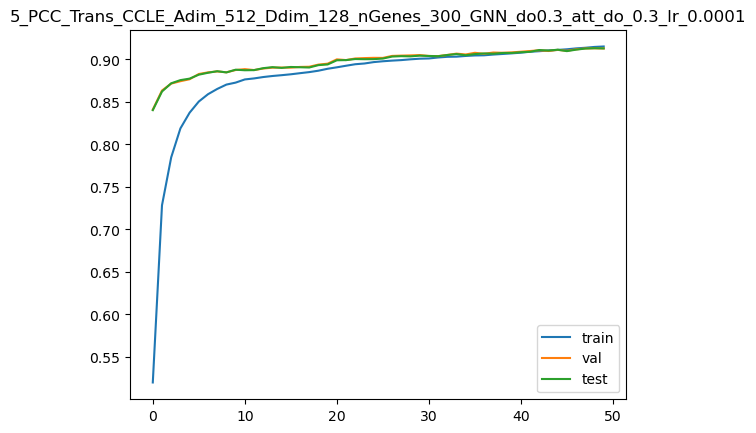

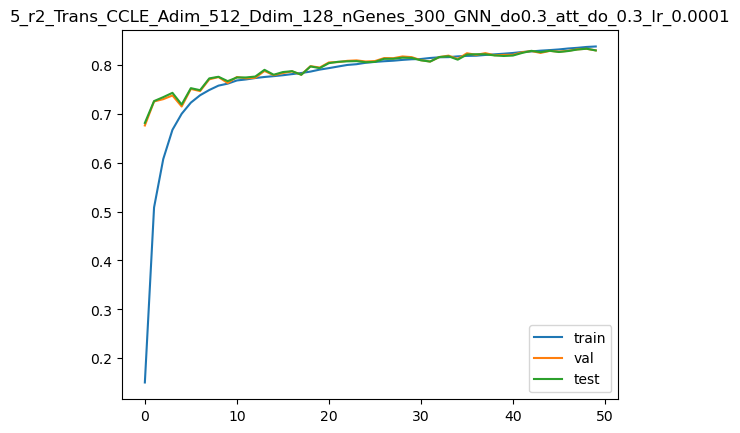

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2253693789243698
The overall Pearson's correlation is 0.8848.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2146037369966507
The overall Pearson's correlation is 0.8902.
Train avg_loss:  0.21282908
Train avg_pcc:  0.9157825647329987
Train r2:  0.8386496398213954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22395034
Validation avg_pcc:  0.9127618718347144
Validation r2:  0.8326189764597383


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22553958
Test avg_pcc:  0.9123152515652034
Test r2:  0.8320679936704205
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21204563975334167
The overall Pearson's correlation is 0.9256.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3273994028568268
The overall Pearson's correlation is 0.9007.
Train avg_loss:  0.21046662
Train avg_pcc:  0.9167599071000374
Train r2:  0.8404406739556259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23200417
Validation avg_pcc:  0.9130335314458885
Validation r2:  0.8265995221111121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23365594
Test avg_pcc:  0.9129523236759455
Test r2:  0.8260247151518278
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15104031562805176
The overall Pearson's correlation is 0.9233.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15960104763507843
The overall Pearson's correlation is 0.8970.
Train avg_loss:  0.2090233
Train avg_pcc:  0.9173552093437266
Train r2:  0.8415348764517407


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22638392
Validation avg_pcc:  0.9146652233169337
Validation r2:  0.8308001157270284


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22863197
Test avg_pcc:  0.9141227905526688
Test r2:  0.8297654676577504
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15491676330566406
The overall Pearson's correlation is 0.9415.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15838338434696198
The overall Pearson's correlation is 0.9372.
Train avg_loss:  0.20718268
Train avg_pcc:  0.9181174427514088
Train r2:  0.8429303058343591


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22000477
Validation avg_pcc:  0.9150076773165075
Validation r2:  0.8355678895005245
Best Val r2  0.8355678895005245


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22127452
Test avg_pcc:  0.9148187177815269
Test r2:  0.8352436654331352
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23235741257667542
The overall Pearson's correlation is 0.9338.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1828877031803131
The overall Pearson's correlation is 0.8766.
Train avg_loss:  0.20562148
Train avg_pcc:  0.9187616047403597
Train r2:  0.8441138623469175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21690565
Validation avg_pcc:  0.9175546667813015
Validation r2:  0.8378841931719502
Best Val r2  0.8378841931719502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22121094
Test avg_pcc:  0.9163867305775594
Test r2:  0.8352909970537498
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1474267542362213
The overall Pearson's correlation is 0.9421.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17691096663475037
The overall Pearson's correlation is 0.9389.
Train avg_loss:  0.20409207
Train avg_pcc:  0.9193917692706003
Train r2:  0.8452733415858766


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21315226
Validation avg_pcc:  0.917006109071997
Validation r2:  0.8406894753301704
Best Val r2  0.8406894753301704


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21470286
Test avg_pcc:  0.916643406762383
Test r2:  0.8401367841742788
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15410271286964417
The overall Pearson's correlation is 0.9424.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.229714035987854
The overall Pearson's correlation is 0.9187.
Train avg_loss:  0.20307475
Train avg_pcc:  0.9198110440868603
Train r2:  0.8460445946105124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21297178
Validation avg_pcc:  0.9181119913852811
Validation r2:  0.8408243783609005
Best Val r2  0.8408243783609005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21686356
Test avg_pcc:  0.916839847995798
Test r2:  0.8385279740722317
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14022250473499298
The overall Pearson's correlation is 0.9294.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22947561740875244
The overall Pearson's correlation is 0.9377.
Train avg_loss:  0.20024334
Train avg_pcc:  0.9209776825092315
Train r2:  0.8481911638739932


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21243629
Validation avg_pcc:  0.9175385346920523
Validation r2:  0.8412246008479993
Best Val r2  0.8412246008479993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21369363
Test avg_pcc:  0.9173271382919831
Test r2:  0.8408882441271649
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1960291564464569
The overall Pearson's correlation is 0.9403.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15906278789043427
The overall Pearson's correlation is 0.9288.
Train avg_loss:  0.19773453
Train avg_pcc:  0.9220095157850442
Train r2:  0.8500931346994146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21190377
Validation avg_pcc:  0.9177364703798577
Validation r2:  0.8416226111832876
Best Val r2  0.8416226111832876


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21577087
Test avg_pcc:  0.9165050396083755
Test r2:  0.8393415703253535
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21298570930957794
The overall Pearson's correlation is 0.8762.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1621280014514923
The overall Pearson's correlation is 0.9195.
Train avg_loss:  0.1966173
Train avg_pcc:  0.9224688750900727
Train r2:  0.8509401300481665


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20781909
Validation avg_pcc:  0.9203161699304317
Validation r2:  0.8446755123990926
Best Val r2  0.8446755123990926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21317795
Test avg_pcc:  0.9186113070032944
Test r2:  0.8412721937287191
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26899632811546326
The overall Pearson's correlation is 0.8546.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2028992474079132
The overall Pearson's correlation is 0.9205.
Train avg_loss:  0.19446915
Train avg_pcc:  0.9233513128817353
Train r2:  0.852568692642268


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20879145
Validation avg_pcc:  0.9201389862268302
Validation r2:  0.8439487571721191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21292478
Test avg_pcc:  0.9189821478056345
Test r2:  0.8414607084934147
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19059616327285767
The overall Pearson's correlation is 0.9369.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17471247911453247
The overall Pearson's correlation is 0.9182.
Train avg_loss:  0.19325711
Train avg_pcc:  0.9238477960288037
Train r2:  0.8534875733049098


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20656388
Validation avg_pcc:  0.9203045934567466
Validation r2:  0.8456136682518944
Best Val r2  0.8456136682518944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21102856
Test avg_pcc:  0.9189359005754716
Test r2:  0.8428725847335925
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1992928832769394
The overall Pearson's correlation is 0.9314.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25375115871429443
The overall Pearson's correlation is 0.9032.
Train avg_loss:  0.19147436
Train avg_pcc:  0.9245792433816667
Train r2:  0.8548391002807098


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20374447
Validation avg_pcc:  0.9216820815749882
Validation r2:  0.8477208829600594
Best Val r2  0.8477208829600594


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21060325
Test avg_pcc:  0.9193675083261468
Test r2:  0.8431892800736093
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13560675084590912
The overall Pearson's correlation is 0.9333.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14367899298667908
The overall Pearson's correlation is 0.9232.
Train avg_loss:  0.1895397
Train avg_pcc:  0.9253722014535732
Train r2:  0.8563058219968944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2045186
Validation avg_pcc:  0.9206443587792832
Validation r2:  0.8471423058725068


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20767704
Test avg_pcc:  0.9196824445140035
Test r2:  0.8453680728408286
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19925758242607117
The overall Pearson's correlation is 0.8973.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1899147927761078
The overall Pearson's correlation is 0.8615.
Train avg_loss:  0.18742768
Train avg_pcc:  0.9262369546128493
Train r2:  0.8579069953394262


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19854769
Validation avg_pcc:  0.9228535910642104
Validation r2:  0.8516049777956759
Best Val r2  0.8516049777956759


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20460753
Test avg_pcc:  0.9207394830151431
Test r2:  0.8476535595793198
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1940411925315857
The overall Pearson's correlation is 0.9190.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1536494344472885
The overall Pearson's correlation is 0.9370.
Train avg_loss:  0.18706192
Train avg_pcc:  0.9263864752478901
Train r2:  0.8581842742106022


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20049767
Validation avg_pcc:  0.9227453769216962
Validation r2:  0.8501475637907179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20623435
Test avg_pcc:  0.9208959806556777
Test r2:  0.846442260388727
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13936102390289307
The overall Pearson's correlation is 0.9434.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1564187854528427
The overall Pearson's correlation is 0.9436.
Train avg_loss:  0.18524477
Train avg_pcc:  0.9271301223955754
Train r2:  0.8595619005630568


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20453231
Validation avg_pcc:  0.9224572416256009
Validation r2:  0.847132053181905


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20860496
Test avg_pcc:  0.9211847557111277
Test r2:  0.8446771461265118
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16401614248752594
The overall Pearson's correlation is 0.9434.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20209082961082458
The overall Pearson's correlation is 0.9287.
Train avg_loss:  0.18439202
Train avg_pcc:  0.9274793671523607
Train r2:  0.8602083893420915


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20031367
Validation avg_pcc:  0.9234637626250585
Validation r2:  0.8502850821929914


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20673135
Test avg_pcc:  0.9214141307501724
Test r2:  0.8460722017084955
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18830275535583496
The overall Pearson's correlation is 0.8724.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13980555534362793
The overall Pearson's correlation is 0.9546.
Train avg_loss:  0.18251106
Train avg_pcc:  0.9282457008408815
Train r2:  0.8616343771962578


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1962354
Validation avg_pcc:  0.9237678441849084
Validation r2:  0.8533331824123382
Best Val r2  0.8533331824123382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20310563
Test avg_pcc:  0.9212922962183021
Test r2:  0.8487718241127833
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24888738989830017
The overall Pearson's correlation is 0.9175.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16582968831062317
The overall Pearson's correlation is 0.9515.
Train avg_loss:  0.18106458
Train avg_pcc:  0.9288367548237353
Train r2:  0.8627309928939308


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19744638
Validation avg_pcc:  0.9240925722543277
Validation r2:  0.8524281065556847


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20592736
Test avg_pcc:  0.9209867923995461
Test r2:  0.8466708308552446
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13658902049064636
The overall Pearson's correlation is 0.9276.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10786857455968857
The overall Pearson's correlation is 0.9592.
Train avg_loss:  0.18060352
Train avg_pcc:  0.9290252318133372
Train r2:  0.8630805252819185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19398272
Validation avg_pcc:  0.9252911546085855
Validation r2:  0.8550168516019558
Best Val r2  0.8550168516019558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20105435
Test avg_pcc:  0.9228366986556987
Test r2:  0.8502991822768393
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1759043037891388
The overall Pearson's correlation is 0.9529.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23204617202281952
The overall Pearson's correlation is 0.9064.
Train avg_loss:  0.1794173
Train avg_pcc:  0.9295094576995778
Train r2:  0.8639798396499813


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19488394
Validation avg_pcc:  0.9246874219900318
Validation r2:  0.8543432670970706


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20025694
Test avg_pcc:  0.9229489538139605
Test r2:  0.850892903325948
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11689024418592453
The overall Pearson's correlation is 0.9645.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13977572321891785
The overall Pearson's correlation is 0.9415.
Train avg_loss:  0.1775169
Train avg_pcc:  0.9302838246309636
Train r2:  0.8654205719011683


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19908911
Validation avg_pcc:  0.9251990134154512
Validation r2:  0.8512003238854418


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2066684
Test avg_pcc:  0.9228755730018671
Test r2:  0.8461190660771877
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11665169149637222
The overall Pearson's correlation is 0.9411.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14413733780384064
The overall Pearson's correlation is 0.9376.
Train avg_loss:  0.17567
Train avg_pcc:  0.9310351515886577
Train r2:  0.8668207397444396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19636306
Validation avg_pcc:  0.9239073349305026
Validation r2:  0.8532377642456137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.200891
Test avg_pcc:  0.9223504647200288
Test r2:  0.8504208011873509
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1601967215538025
The overall Pearson's correlation is 0.9240.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19142788648605347
The overall Pearson's correlation is 0.9369.
Train avg_loss:  0.1752444
Train avg_pcc:  0.9312088151768235
Train r2:  0.8671433897330604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19096324
Validation avg_pcc:  0.9259967736325948
Validation r2:  0.8572736052735171
Best Val r2  0.8572736052735171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19645588
Test avg_pcc:  0.9240464423057404
Test r2:  0.8537230976156359
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16884338855743408
The overall Pearson's correlation is 0.9371.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1324344277381897
The overall Pearson's correlation is 0.9495.
Train avg_loss:  0.17463994
Train avg_pcc:  0.931455724786869
Train r2:  0.8676016516246208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19368513
Validation avg_pcc:  0.9259007120772766
Validation r2:  0.8552392712765224


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20296061
Test avg_pcc:  0.9227112107424307
Test r2:  0.8488798226623991
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1839972883462906
The overall Pearson's correlation is 0.9402.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18859541416168213
The overall Pearson's correlation is 0.9408.
Train avg_loss:  0.17361856
Train avg_pcc:  0.9318702920680662
Train r2:  0.8683759762425782


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18961284
Validation avg_pcc:  0.9265471080301281
Validation r2:  0.8582829133720913
Best Val r2  0.8582829133720913


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19634569
Test avg_pcc:  0.9240571333309435
Test r2:  0.8538051487377853
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21003097295761108
The overall Pearson's correlation is 0.9110.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11960530281066895
The overall Pearson's correlation is 0.9288.
Train avg_loss:  0.17136694
Train avg_pcc:  0.9327853298139198
Train r2:  0.8700829850553384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1918015
Validation avg_pcc:  0.9255862625767977
Validation r2:  0.8566470931398487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19756891
Test avg_pcc:  0.9235842694369462
Test r2:  0.8528943464156296
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13961052894592285
The overall Pearson's correlation is 0.9258.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17128267884254456
The overall Pearson's correlation is 0.9508.
Train avg_loss:  0.17022799
Train avg_pcc:  0.9332494407185915
Train r2:  0.8709464530230733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19457607
Validation avg_pcc:  0.9264834214682915
Validation r2:  0.8545733726631153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2005423
Test avg_pcc:  0.9244579879466781
Test r2:  0.8506804460008197
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13902153074741364
The overall Pearson's correlation is 0.9615.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1317652016878128
The overall Pearson's correlation is 0.9385.
Train avg_loss:  0.17038643
Train avg_pcc:  0.9331846764998749
Train r2:  0.8708263305925087


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19062999
Validation avg_pcc:  0.9260487030088307
Validation r2:  0.8575226936727907


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19557744
Test avg_pcc:  0.9243427343548256
Test r2:  0.8543771650825478
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17153844237327576
The overall Pearson's correlation is 0.9073.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1813107430934906
The overall Pearson's correlation is 0.9063.
Train avg_loss:  0.16939664
Train avg_pcc:  0.9335867553624261
Train r2:  0.8715767220127266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18817556
Validation avg_pcc:  0.927217900183105
Validation r2:  0.8593571310262328
Best Val r2  0.8593571310262328


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19425839
Test avg_pcc:  0.9250315280946391
Test r2:  0.855359318211227
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.219739630818367
The overall Pearson's correlation is 0.9279.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12243504822254181
The overall Pearson's correlation is 0.9479.
Train avg_loss:  0.16747974
Train avg_pcc:  0.9343636406565562
Train r2:  0.8730299489364606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19286361
Validation avg_pcc:  0.9267996416384321
Validation r2:  0.8558532644498655


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20059656
Test avg_pcc:  0.9241867312338038
Test r2:  0.8506400415275875
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16346433758735657
The overall Pearson's correlation is 0.9066.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14018908143043518
The overall Pearson's correlation is 0.9250.
Train avg_loss:  0.16630793
Train avg_pcc:  0.9348389127049078
Train r2:  0.8739183354193096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19069408
Validation avg_pcc:  0.9260817349895435
Validation r2:  0.8574747894752675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19616541
Test avg_pcc:  0.9241689740582681
Test r2:  0.853939362880176
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1524367481470108
The overall Pearson's correlation is 0.9096.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22293564677238464
The overall Pearson's correlation is 0.8983.
Train avg_loss:  0.16605046
Train avg_pcc:  0.9349441836224782
Train r2:  0.8741135252498946


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18674536
Validation avg_pcc:  0.9276447591825487
Validation r2:  0.8604260684112583
Best Val r2  0.8604260684112583


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19227085
Test avg_pcc:  0.9257167366353155
Test r2:  0.8568391797471567
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1411188840866089
The overall Pearson's correlation is 0.9516.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1806696355342865
The overall Pearson's correlation is 0.9332.
Train avg_loss:  0.16548762
Train avg_pcc:  0.9351720469682487
Train r2:  0.8745402267833486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18910441
Validation avg_pcc:  0.9269024938938556
Validation r2:  0.8586629112183615


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19541155
Test avg_pcc:  0.9247994211759095
Test r2:  0.8545006956245882
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2509382963180542
The overall Pearson's correlation is 0.8889.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15555989742279053
The overall Pearson's correlation is 0.9530.
Train avg_loss:  0.16360457
Train avg_pcc:  0.9359353865369774
Train r2:  0.8759678046175633


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18871373
Validation avg_pcc:  0.9278459924324102
Validation r2:  0.858954900138547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19463384
Test avg_pcc:  0.9259539307939584
Test r2:  0.8550797584147813
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16674074530601501
The overall Pearson's correlation is 0.8910.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14891156554222107
The overall Pearson's correlation is 0.9326.
Train avg_loss:  0.16357327
Train avg_pcc:  0.9359471981036427
Train r2:  0.8759915328072212


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18482442
Validation avg_pcc:  0.9285305219892646
Validation r2:  0.8618617744410609
Best Val r2  0.8618617744410609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19186428
Test avg_pcc:  0.9260630388929532
Test r2:  0.8571418978787266
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15044140815734863
The overall Pearson's correlation is 0.9624.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11821725964546204
The overall Pearson's correlation is 0.9649.
Train avg_loss:  0.16232246
Train avg_pcc:  0.9364544579169934
Train r2:  0.8769397970660248


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18719514
Validation avg_pcc:  0.9279087864394779
Validation r2:  0.8600899100331387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19250342
Test avg_pcc:  0.9261777427720784
Test r2:  0.8566660127823668
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16914290189743042
The overall Pearson's correlation is 0.9536.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17760024964809418
The overall Pearson's correlation is 0.9368.
Train avg_loss:  0.16144599
Train avg_pcc:  0.9368085039771278
Train r2:  0.8776042758560668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18723255
Validation avg_pcc:  0.9278450771457623
Validation r2:  0.8600619446825601


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19299726
Test avg_pcc:  0.9259282576756996
Test r2:  0.8562983232515404
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22451868653297424
The overall Pearson's correlation is 0.9538.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18845340609550476
The overall Pearson's correlation is 0.9421.
Train avg_loss:  0.15990205
Train avg_pcc:  0.9374333300218408
Train r2:  0.8787747832439319


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18509558
Validation avg_pcc:  0.9285162807745936
Validation r2:  0.8616591165902714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18979919
Test avg_pcc:  0.9270418993963399
Test r2:  0.8586795252184681
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18112637102603912
The overall Pearson's correlation is 0.9465.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17881058156490326
The overall Pearson's correlation is 0.9384.
Train avg_loss:  0.15895922
Train avg_pcc:  0.9378140761798984
Train r2:  0.879489551198398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18595687
Validation avg_pcc:  0.9282392928061592
Validation r2:  0.8610153744872795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1905798
Test avg_pcc:  0.9268041058051376
Test r2:  0.8580982969751304
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1956392079591751
The overall Pearson's correlation is 0.9488.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2003350704908371
The overall Pearson's correlation is 0.9293.
Train avg_loss:  0.15907274
Train avg_pcc:  0.9377677103141784
Train r2:  0.8794034830419544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18957837
Validation avg_pcc:  0.9271544132912883
Validation r2:  0.8583086740609923


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19326705
Test avg_pcc:  0.9260492995186856
Test r2:  0.8560974245673941
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1371862143278122
The overall Pearson's correlation is 0.9402.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17245113849639893
The overall Pearson's correlation is 0.9146.
Train avg_loss:  0.1585184
Train avg_pcc:  0.937993021874625
Train r2:  0.8798237355423539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18671319
Validation avg_pcc:  0.9281195203123492
Validation r2:  0.8604501110448971


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.192354
Test avg_pcc:  0.926332160282409
Test r2:  0.8567772863411496
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1014341339468956
The overall Pearson's correlation is 0.9499.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17193949222564697
The overall Pearson's correlation is 0.9431.
Train avg_loss:  0.15734997
Train avg_pcc:  0.9384643905718573
Train r2:  0.8807095553912422


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18560793
Validation avg_pcc:  0.9291020077041418
Validation r2:  0.861276182631705


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19121961
Test avg_pcc:  0.927315688246624
Test r2:  0.8576219177948086
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12583470344543457
The overall Pearson's correlation is 0.9563.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13667109608650208
The overall Pearson's correlation is 0.9563.
Train avg_loss:  0.15620254
Train avg_pcc:  0.9389285298624686
Train r2:  0.8815794434652711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18469884
Validation avg_pcc:  0.9285010419261669
Validation r2:  0.861955647040194
Best Val r2  0.861955647040194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18961726
Test avg_pcc:  0.9268576147442296
Test r2:  0.8588149967008473
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20961137115955353
The overall Pearson's correlation is 0.8550.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1365036517381668
The overall Pearson's correlation is 0.9543.
Train avg_loss:  0.15527125
Train avg_pcc:  0.9393038953237107
Train r2:  0.8822854798055045


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18085171
Validation avg_pcc:  0.9299843295706696
Validation r2:  0.8648309822479742
Best Val r2  0.8648309822479742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1867982
Test avg_pcc:  0.9278561370635175
Test r2:  0.8609139895980602
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13969139754772186
The overall Pearson's correlation is 0.9470.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1291506290435791
The overall Pearson's correlation is 0.9265.
Train avg_loss:  0.15417382
Train avg_pcc:  0.9397467305857411
Train r2:  0.8831174558648204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18457298
Validation avg_pcc:  0.9299476245294129
Validation r2:  0.8620497040200659


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19192648
Test avg_pcc:  0.9274816747284137
Test r2:  0.8570955873380427
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12335335463285446
The overall Pearson's correlation is 0.9474.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11381405591964722
The overall Pearson's correlation is 0.9620.
Train avg_loss:  0.1530333
Train avg_pcc:  0.940207153724525
Train r2:  0.8839821272398479


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18190235
Validation avg_pcc:  0.9298134352238085
Validation r2:  0.8640457404684082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18888533
Test avg_pcc:  0.9273908731144379
Test r2:  0.8593599673191818
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24642625451087952
The overall Pearson's correlation is 0.8956.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23968927562236786
The overall Pearson's correlation is 0.9022.
Train avg_loss:  0.1531747
Train avg_pcc:  0.9401490744535126
Train r2:  0.8838749187214748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19082378
Validation avg_pcc:  0.9292695576296655
Validation r2:  0.8573778499976024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19729729
Test avg_pcc:  0.9274189967728781
Test r2:  0.853096593369357
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20138496160507202
The overall Pearson's correlation is 0.9275.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15801972150802612
The overall Pearson's correlation is 0.9282.
Train avg_loss:  0.15144576
Train avg_pcc:  0.9408456831715445
Train r2:  0.8851856741340469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1843958
Validation avg_pcc:  0.9285650177999302
Validation r2:  0.8621821424532449


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18911964
Test avg_pcc:  0.9269977432870642
Test r2:  0.8591855083014104


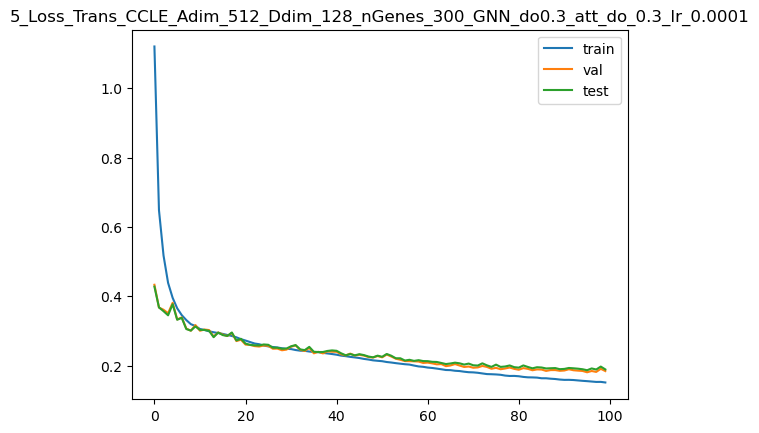

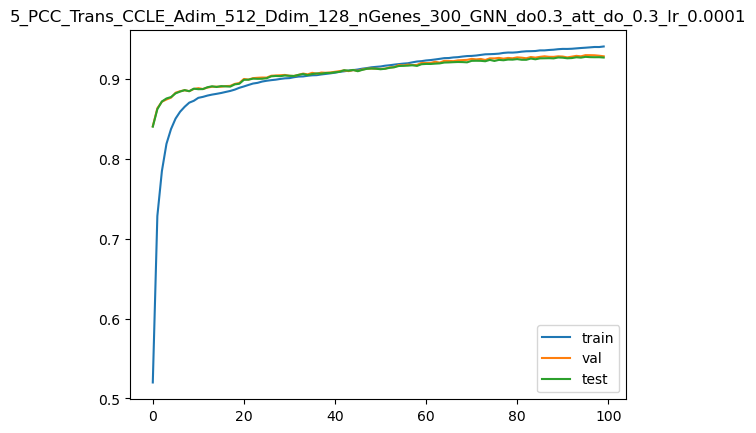

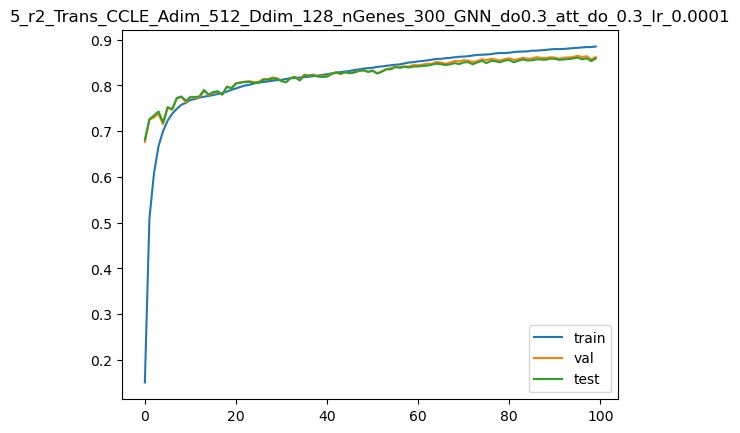

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2413651943206787
The overall Pearson's correlation is 0.9132.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.056031376123428345
The overall Pearson's correlation is 0.9807.
Train avg_loss:  0.15102881
Train avg_pcc:  0.9410145716272299
Train r2:  0.8855017551544146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17997877
Validation avg_pcc:  0.9305940832958955
Validation r2:  0.8654834311918812
Best Val r2  0.8654834311918812


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1868908
Test avg_pcc:  0.9281846309633758
Test r2:  0.8608450547587764
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21396467089653015
The overall Pearson's correlation is 0.9465.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1208142340183258
The overall Pearson's correlation is 0.9639.
Train avg_loss:  0.1494671
Train avg_pcc:  0.9416423743138322
Train r2:  0.8866857337188977


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18017596
Validation avg_pcc:  0.9305002963667725
Validation r2:  0.8653360553727547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18804002
Test avg_pcc:  0.9277478877189477
Test r2:  0.8599893677355979
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11576998233795166
The overall Pearson's correlation is 0.9466.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21703919768333435
The overall Pearson's correlation is 0.9326.
Train avg_loss:  0.15054923
Train avg_pcc:  0.9412074503102229
Train r2:  0.8858653430503997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18151514
Validation avg_pcc:  0.9304045377400048
Validation r2:  0.864335140950984


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18608126
Test avg_pcc:  0.9290098592984505
Test r2:  0.8614478161024286
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16025078296661377
The overall Pearson's correlation is 0.9479.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16987761855125427
The overall Pearson's correlation is 0.9340.
Train avg_loss:  0.1491607
Train avg_pcc:  0.9417667194818645
Train r2:  0.8869180204782476


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18480836
Validation avg_pcc:  0.9295238765181334
Validation r2:  0.8618737867396906


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19005719
Test avg_pcc:  0.9279667550273029
Test r2:  0.8584874261181062
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22260291874408722
The overall Pearson's correlation is 0.9451.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19352033734321594
The overall Pearson's correlation is 0.9340.
Train avg_loss:  0.14772837
Train avg_pcc:  0.9423424995324156
Train r2:  0.888003891909026


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18085815
Validation avg_pcc:  0.9306996548550697
Validation r2:  0.8648261800094738


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18603702
Test avg_pcc:  0.9290603997604643
Test r2:  0.8614807661789438
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16009345650672913
The overall Pearson's correlation is 0.9420.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1509546935558319
The overall Pearson's correlation is 0.9428.
Train avg_loss:  0.14730842
Train avg_pcc:  0.9425107777982054
Train r2:  0.8883222678336745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18032797
Validation avg_pcc:  0.9302179416525762
Validation r2:  0.8652224298359137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18771712
Test avg_pcc:  0.9276021215942726
Test r2:  0.860229799327519
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14165005087852478
The overall Pearson's correlation is 0.9335.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24784687161445618
The overall Pearson's correlation is 0.9291.
Train avg_loss:  0.14597787
Train avg_pcc:  0.9430467290026853
Train r2:  0.8893310061800346


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18033595
Validation avg_pcc:  0.9309011197116694
Validation r2:  0.8652164848440492


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18655173
Test avg_pcc:  0.9288651120231879
Test r2:  0.8610975230879344
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13036492466926575
The overall Pearson's correlation is 0.9316.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12886473536491394
The overall Pearson's correlation is 0.9365.
Train avg_loss:  0.1456452
Train avg_pcc:  0.9431804389458999
Train r2:  0.8895831930525434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1795015
Validation avg_pcc:  0.9315315247619034
Validation r2:  0.8658401496815661
Best Val r2  0.8658401496815661


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18641624
Test avg_pcc:  0.9292805868147905
Test r2:  0.8611984134798193
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13354885578155518
The overall Pearson's correlation is 0.9408.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2029651701450348
The overall Pearson's correlation is 0.9283.
Train avg_loss:  0.14567958
Train avg_pcc:  0.9431664564983112
Train r2:  0.8895571314615562


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18265764
Validation avg_pcc:  0.9306750482455736
Validation r2:  0.8634812353105221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18799849
Test avg_pcc:  0.928969301842747
Test r2:  0.8600202876815154
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14987808465957642
The overall Pearson's correlation is 0.9502.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11152072250843048
The overall Pearson's correlation is 0.9548.
Train avg_loss:  0.14417265
Train avg_pcc:  0.9437708835402425
Train r2:  0.8906995509220215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17782351
Validation avg_pcc:  0.9320409175896908
Validation r2:  0.8670942765584528
Best Val r2  0.8670942765584528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18412684
Test avg_pcc:  0.9299624682406864
Test r2:  0.8629030447031207
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18397566676139832
The overall Pearson's correlation is 0.9432.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10404970496892929
The overall Pearson's correlation is 0.9381.
Train avg_loss:  0.14401221
Train avg_pcc:  0.9438369800270275
Train r2:  0.8908211986586503


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17857061
Validation avg_pcc:  0.9315006954807091
Validation r2:  0.8665359039008407


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1850563
Test avg_pcc:  0.9293860431593438
Test r2:  0.8622109764052509
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16900363564491272
The overall Pearson's correlation is 0.9406.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1541009247303009
The overall Pearson's correlation is 0.9522.
Train avg_loss:  0.14284812
Train avg_pcc:  0.944303610062412
Train r2:  0.8917037179332256


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18249555
Validation avg_pcc:  0.9297023850759816
Validation r2:  0.8636023861442255


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18842784
Test avg_pcc:  0.9277557101862366
Test r2:  0.8597006111393382
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12058468163013458
The overall Pearson's correlation is 0.9490.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18870076537132263
The overall Pearson's correlation is 0.9416.
Train avg_loss:  0.14207557
Train avg_pcc:  0.9446129054127238
Train r2:  0.892289414666886


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17643167
Validation avg_pcc:  0.9317553222501207
Validation r2:  0.8681345391553333
Best Val r2  0.8681345391553333


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18178152
Test avg_pcc:  0.9299032763837406
Test r2:  0.8646493257747717
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1678847074508667
The overall Pearson's correlation is 0.9071.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15043489634990692
The overall Pearson's correlation is 0.9542.
Train avg_loss:  0.14004594
Train avg_pcc:  0.9454271445284548
Train r2:  0.8938281130007493


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17674428
Validation avg_pcc:  0.9320176571196699
Validation r2:  0.8679008926507832


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18201882
Test avg_pcc:  0.9302673876457317
Test r2:  0.8644726348666821
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13448840379714966
The overall Pearson's correlation is 0.9542.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13401803374290466
The overall Pearson's correlation is 0.9566.
Train avg_loss:  0.13911152
Train avg_pcc:  0.9458026810280934
Train r2:  0.8945365203924269


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17686328
Validation avg_pcc:  0.9318608603200933
Validation r2:  0.8678119468701235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18231688
Test avg_pcc:  0.9299656513932086
Test r2:  0.8642506927651532
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10107040405273438
The overall Pearson's correlation is 0.9434.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11251654475927353
The overall Pearson's correlation is 0.9503.
Train avg_loss:  0.1391671
Train avg_pcc:  0.945779039027332
Train r2:  0.8944943912403991


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18015906
Validation avg_pcc:  0.9312024176657014
Validation r2:  0.8653486857034074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18533872
Test avg_pcc:  0.9296423161192755
Test r2:  0.8620007084007544
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09848622232675552
The overall Pearson's correlation is 0.9612.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12540626525878906
The overall Pearson's correlation is 0.9501.
Train avg_loss:  0.13852654
Train avg_pcc:  0.9460369859494152
Train r2:  0.8949800057917469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17806934
Validation avg_pcc:  0.9315993114948773
Validation r2:  0.8669105490418956


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18367761
Test avg_pcc:  0.9297660847458494
Test r2:  0.8632375213114325
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1450643241405487
The overall Pearson's correlation is 0.9510.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.120490163564682
The overall Pearson's correlation is 0.9605.
Train avg_loss:  0.13773234
Train avg_pcc:  0.9463545267865446
Train r2:  0.8955821070230575


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18309198
Validation avg_pcc:  0.9314214984518856
Validation r2:  0.8631566103401148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18781991
Test avg_pcc:  0.9300961265055836
Test r2:  0.8601532786868231
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09649529308080673
The overall Pearson's correlation is 0.9706.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16699129343032837
The overall Pearson's correlation is 0.9249.
Train avg_loss:  0.13786373
Train avg_pcc:  0.9463021282290305
Train r2:  0.8954825052660663


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1764144
Validation avg_pcc:  0.9322034995237731
Validation r2:  0.8681474544836536
Best Val r2  0.8681474544836536


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18228832
Test avg_pcc:  0.9303077540491337
Test r2:  0.8642719618331457
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.116735078394413
The overall Pearson's correlation is 0.9629.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1498803347349167
The overall Pearson's correlation is 0.9319.
Train avg_loss:  0.13685954
Train avg_pcc:  0.9467044207314733
Train r2:  0.8962437960107354


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17927946
Validation avg_pcc:  0.9313695614083313
Validation r2:  0.8660061042289533


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18637575
Test avg_pcc:  0.9289531438191694
Test r2:  0.8612285489985035
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13452358543872833
The overall Pearson's correlation is 0.9393.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13543125987052917
The overall Pearson's correlation is 0.9526.
Train avg_loss:  0.13638173
Train avg_pcc:  0.9468957045514169
Train r2:  0.8966060344064521


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17673576
Validation avg_pcc:  0.9324868969268942
Validation r2:  0.867907276143673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18326265
Test avg_pcc:  0.9304067044981027
Test r2:  0.8635465043024385
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15911740064620972
The overall Pearson's correlation is 0.9453.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09723316133022308
The overall Pearson's correlation is 0.9600.
Train avg_loss:  0.13582768
Train avg_pcc:  0.9471173635314213
Train r2:  0.8970260789934994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17910784
Validation avg_pcc:  0.9318963346174959
Validation r2:  0.8661343651383656


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18377629
Test avg_pcc:  0.9305239364020498
Test r2:  0.863164056513658
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14041534066200256
The overall Pearson's correlation is 0.9478.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11845692247152328
The overall Pearson's correlation is 0.9701.
Train avg_loss:  0.13575292
Train avg_pcc:  0.9471467011960648
Train r2:  0.897082750720157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17801185
Validation avg_pcc:  0.9315227224997793
Validation r2:  0.8669535156511176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18196231
Test avg_pcc:  0.9303424732392296
Test r2:  0.8645147035890463
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1812993884086609
The overall Pearson's correlation is 0.9208.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16569502651691437
The overall Pearson's correlation is 0.9483.
Train avg_loss:  0.13459457
Train avg_pcc:  0.9476106429716648
Train r2:  0.8979609205002949


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18078737
Validation avg_pcc:  0.9321642919943381
Validation r2:  0.8648790832866993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18672381
Test avg_pcc:  0.9303029378893244
Test r2:  0.8609693893791764
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1472768485546112
The overall Pearson's correlation is 0.9450.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11001776903867722
The overall Pearson's correlation is 0.9642.
Train avg_loss:  0.13422826
Train avg_pcc:  0.9477569227144943
Train r2:  0.8982386280914155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17456202
Validation avg_pcc:  0.932517226768923
Validation r2:  0.8695319260929719
Best Val r2  0.8695319260929719


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18062693
Test avg_pcc:  0.9304021619362997
Test r2:  0.8655090045293734
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14312924444675446
The overall Pearson's correlation is 0.9485.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10009869188070297
The overall Pearson's correlation is 0.9469.
Train avg_loss:  0.13302368
Train avg_pcc:  0.9482390677252499
Train r2:  0.8991518436078857


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17410412
Validation avg_pcc:  0.9337614783839022
Validation r2:  0.8698741682052333
Best Val r2  0.8698741682052333


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18011995
Test avg_pcc:  0.9318211966267643
Test r2:  0.8658864869867096
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12020450830459595
The overall Pearson's correlation is 0.9527.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11400862783193588
The overall Pearson's correlation is 0.9418.
Train avg_loss:  0.13273649
Train avg_pcc:  0.9483542414218982
Train r2:  0.8993695749345537


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17624877
Validation avg_pcc:  0.932293255997095
Validation r2:  0.8682712456081675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1813886
Test avg_pcc:  0.9305815699176421
Test r2:  0.8649418704965396
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12864896655082703
The overall Pearson's correlation is 0.9553.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11720918118953705
The overall Pearson's correlation is 0.9516.
Train avg_loss:  0.13218601
Train avg_pcc:  0.9485737279135757
Train r2:  0.8997868948565207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17409457
Validation avg_pcc:  0.9332737226044311
Validation r2:  0.8698812942552723
Best Val r2  0.8698812942552723


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1804188
Test avg_pcc:  0.9310638265670241
Test r2:  0.8656639674836475
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10213208198547363
The overall Pearson's correlation is 0.9368.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13713812828063965
The overall Pearson's correlation is 0.9422.
Train avg_loss:  0.1313336
Train avg_pcc:  0.948913734152092
Train r2:  0.9004331259833009


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17214988
Validation avg_pcc:  0.9336033849115156
Validation r2:  0.8713347552114645
Best Val r2  0.8713347552114645


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17928976
Test avg_pcc:  0.9311227831475561
Test r2:  0.8665046362448886
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17554059624671936
The overall Pearson's correlation is 0.9516.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1477086842060089
The overall Pearson's correlation is 0.9578.
Train avg_loss:  0.13109803
Train avg_pcc:  0.9490084794802709
Train r2:  0.9006117268028827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1802064
Validation avg_pcc:  0.9321453011611285
Validation r2:  0.8653132981146096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18614773
Test avg_pcc:  0.9303278583359466
Test r2:  0.8613983170307982
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12277817726135254
The overall Pearson's correlation is 0.9496.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1427549570798874
The overall Pearson's correlation is 0.9237.
Train avg_loss:  0.13036698
Train avg_pcc:  0.9493003993407774
Train r2:  0.9011659532583581


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17065282
Validation avg_pcc:  0.9340560823808423
Validation r2:  0.8724536665375495
Best Val r2  0.8724536665375495


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17702712
Test avg_pcc:  0.9318036345548919
Test r2:  0.8681893420421933
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09730695188045502
The overall Pearson's correlation is 0.9553.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05549893528223038
The overall Pearson's correlation is 0.9618.
Train avg_loss:  0.12995142
Train avg_pcc:  0.9494656982686165
Train r2:  0.9014809910514325


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17275704
Validation avg_pcc:  0.9335788016485893
Validation r2:  0.8708809644010975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17907567
Test avg_pcc:  0.931497308407587
Test r2:  0.866664030955212
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10332147777080536
The overall Pearson's correlation is 0.9542.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15228119492530823
The overall Pearson's correlation is 0.9431.
Train avg_loss:  0.12882139
Train avg_pcc:  0.9499168395695203
Train r2:  0.9023376910658353


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17413293
Validation avg_pcc:  0.9332000979518249
Validation r2:  0.8698526276594392


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18158077
Test avg_pcc:  0.9304107226896192
Test r2:  0.8647987894049398
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15643735229969025
The overall Pearson's correlation is 0.9440.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1728762984275818
The overall Pearson's correlation is 0.9432.
Train avg_loss:  0.1291869
Train avg_pcc:  0.9497711197114864
Train r2:  0.9020605901559856


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17388341
Validation avg_pcc:  0.9329966725255576
Validation r2:  0.8700391102792999


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17939188
Test avg_pcc:  0.9311774309762274
Test r2:  0.8664285930876707
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15262055397033691
The overall Pearson's correlation is 0.9339.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13336756825447083
The overall Pearson's correlation is 0.9315.
Train avg_loss:  0.12822612
Train avg_pcc:  0.9501545353116272
Train r2:  0.9027889822326585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17486994
Validation avg_pcc:  0.9336855766197284
Validation r2:  0.8693017831909404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18172987
Test avg_pcc:  0.9314423767674627
Test r2:  0.8646877735006003
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14958882331848145
The overall Pearson's correlation is 0.9556.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1058640405535698
The overall Pearson's correlation is 0.9549.
Train avg_loss:  0.12731926
Train avg_pcc:  0.9505165157871172
Train r2:  0.9034764804545533


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1731927
Validation avg_pcc:  0.9331692072576915
Validation r2:  0.8705553694701317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17848173
Test avg_pcc:  0.9313603629695805
Test r2:  0.86710627396385
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10342302173376083
The overall Pearson's correlation is 0.9614.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11887208372354507
The overall Pearson's correlation is 0.9479.
Train avg_loss:  0.12708004
Train avg_pcc:  0.9506120882210998
Train r2:  0.9036578486944211


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17239368
Validation avg_pcc:  0.9336232767173326
Validation r2:  0.8711525473036144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17869453
Test avg_pcc:  0.9315269779019013
Test r2:  0.8669478324713334
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10619248449802399
The overall Pearson's correlation is 0.9591.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12285749614238739
The overall Pearson's correlation is 0.9357.
Train avg_loss:  0.12572004
Train avg_pcc:  0.9511538105860559
Train r2:  0.9046888913425546


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17432496
Validation avg_pcc:  0.9340838836573171
Validation r2:  0.8697091058374408


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18116492
Test avg_pcc:  0.9319020881027746
Test r2:  0.8651084326577845
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11469981074333191
The overall Pearson's correlation is 0.9495.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08242275565862656
The overall Pearson's correlation is 0.9704.
Train avg_loss:  0.12587884
Train avg_pcc:  0.9510906508819692
Train r2:  0.9045684958662457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17550647
Validation avg_pcc:  0.9337302474459289
Validation r2:  0.8688260479034388


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18167594
Test avg_pcc:  0.9318599146370072
Test r2:  0.8647279237039477
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12893953919410706
The overall Pearson's correlation is 0.9605.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12658946216106415
The overall Pearson's correlation is 0.9592.
Train avg_loss:  0.12513317
Train avg_pcc:  0.9513875201625064
Train r2:  0.9051338150604153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17411031
Validation avg_pcc:  0.9337155389196101
Validation r2:  0.8698695338391063


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17968023
Test avg_pcc:  0.9319900820307456
Test r2:  0.8662138903244763
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12007708847522736
The overall Pearson's correlation is 0.9483.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13074477016925812
The overall Pearson's correlation is 0.9582.
Train avg_loss:  0.12542468
Train avg_pcc:  0.9512713533888357
Train r2:  0.9049128018445596


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16987747
Validation avg_pcc:  0.9348371565768192
Validation r2:  0.8730331698733259
Best Val r2  0.8730331698733259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17593814
Test avg_pcc:  0.9325781413900158
Test r2:  0.8690001798624767
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12057703733444214
The overall Pearson's correlation is 0.9726.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15698719024658203
The overall Pearson's correlation is 0.9264.
Train avg_loss:  0.12327307
Train avg_pcc:  0.9521285978048972
Train r2:  0.9065439944110273


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17405908
Validation avg_pcc:  0.9339304866917189
Validation r2:  0.8699078295663093


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1811356
Test avg_pcc:  0.9316529516920213
Test r2:  0.865130263067027
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.092040054500103
The overall Pearson's correlation is 0.9605.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14145421981811523
The overall Pearson's correlation is 0.9401.
Train avg_loss:  0.123137265
Train avg_pcc:  0.9521828567464051
Train r2:  0.9066469571857984


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17310888
Validation avg_pcc:  0.9339689631286864
Validation r2:  0.8706180132912353


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18006517
Test avg_pcc:  0.9317080127500034
Test r2:  0.8659272841478189
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06985819339752197
The overall Pearson's correlation is 0.9807.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11648543179035187
The overall Pearson's correlation is 0.9570.
Train avg_loss:  0.122907594
Train avg_pcc:  0.9522734973236144
Train r2:  0.9068210700340096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17011704
Validation avg_pcc:  0.9342942661632956
Validation r2:  0.8728541084406896


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1756296
Test avg_pcc:  0.9324019255884137
Test r2:  0.8692298977491495
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09485868364572525
The overall Pearson's correlation is 0.9553.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13217554986476898
The overall Pearson's correlation is 0.9523.
Train avg_loss:  0.12354413
Train avg_pcc:  0.9520209337450918
Train r2:  0.9063385092138634


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17191565
Validation avg_pcc:  0.9337227603343917
Validation r2:  0.8715098192390585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17813988
Test avg_pcc:  0.9316218013442922
Test r2:  0.8673608019687051
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12310716509819031
The overall Pearson's correlation is 0.9353.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12033544480800629
The overall Pearson's correlation is 0.9513.
Train avg_loss:  0.12230136
Train avg_pcc:  0.9525151035266597
Train r2:  0.907280664334595


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17294846
Validation avg_pcc:  0.9347778103745769
Validation r2:  0.8707378945198244


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17891899
Test avg_pcc:  0.9327811396435661
Test r2:  0.8667806925392718
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18550875782966614
The overall Pearson's correlation is 0.9474.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08290021121501923
The overall Pearson's correlation is 0.9743.
Train avg_loss:  0.121894196
Train avg_pcc:  0.9526772297218092
Train r2:  0.9075893358269556


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17317067
Validation avg_pcc:  0.9343174777991299
Validation r2:  0.8705718226906115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17915522
Test avg_pcc:  0.9323762700973708
Test r2:  0.866604800520901
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10660457611083984
The overall Pearson's correlation is 0.9477.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20561333000659943
The overall Pearson's correlation is 0.9502.
Train avg_loss:  0.12099844
Train avg_pcc:  0.9530330376656251
Train r2:  0.9082684413202011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17179538
Validation avg_pcc:  0.9337459520947292
Validation r2:  0.8715997169630558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17741507
Test avg_pcc:  0.9318483698648208
Test r2:  0.8679004821222431
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11573591828346252
The overall Pearson's correlation is 0.9612.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08326006680727005
The overall Pearson's correlation is 0.9754.
Train avg_loss:  0.12092503
Train avg_pcc:  0.9530635421554429
Train r2:  0.9083240974078876


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17193946
Validation avg_pcc:  0.933926753199215
Validation r2:  0.8714920281588966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17648959
Test avg_pcc:  0.9325283967412332
Test r2:  0.8685895742377582
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09390826523303986
The overall Pearson's correlation is 0.9746.
Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14816635847091675
The overall Pearson's correlation is 0.9416.
Train avg_loss:  0.12177871
Train avg_pcc:  0.9527231881142594
Train r2:  0.9076768969824691


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17514688
Validation avg_pcc:  0.9348060591488235
Validation r2:  0.8690948106817352


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1820531
Test avg_pcc:  0.9327017069283682
Test r2:  0.8644470991108475


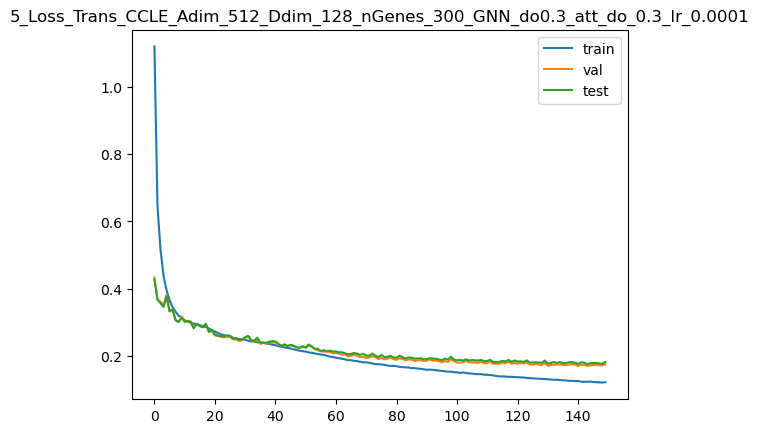

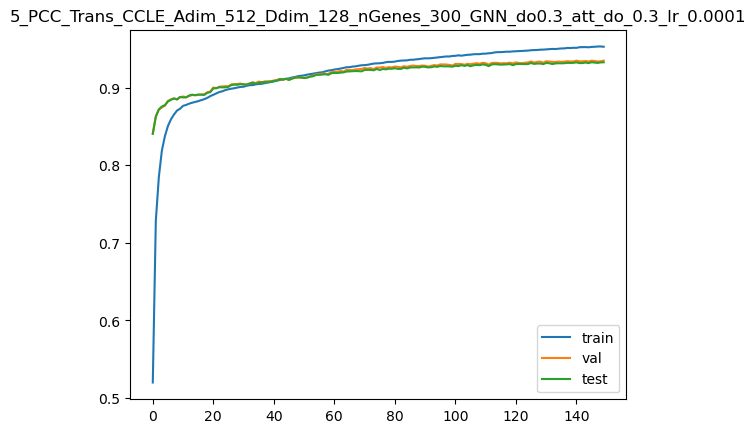

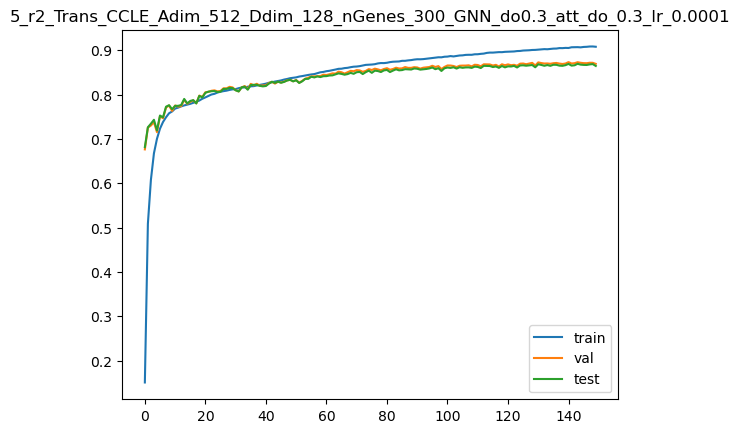

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17593813
Test avg_pcc:  0.9325781413968972
Test r2:  0.8690001798082154


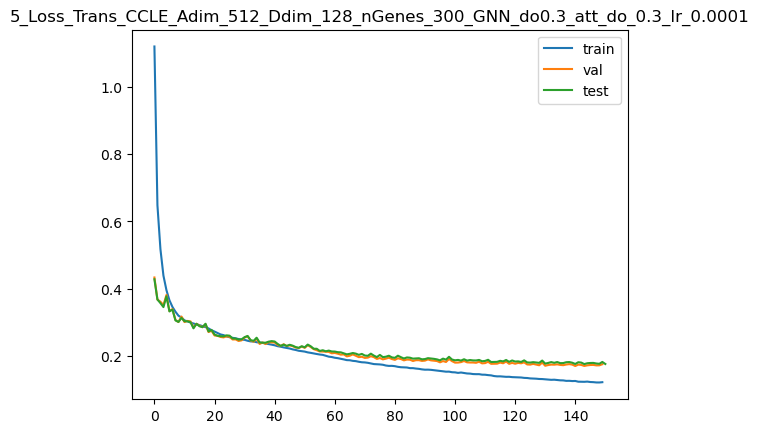

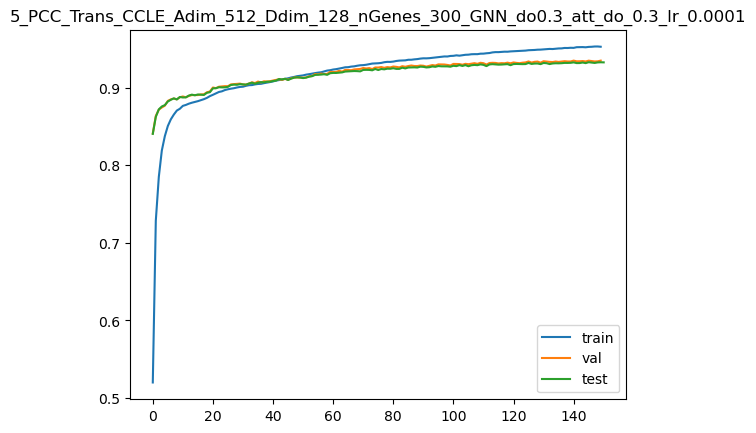

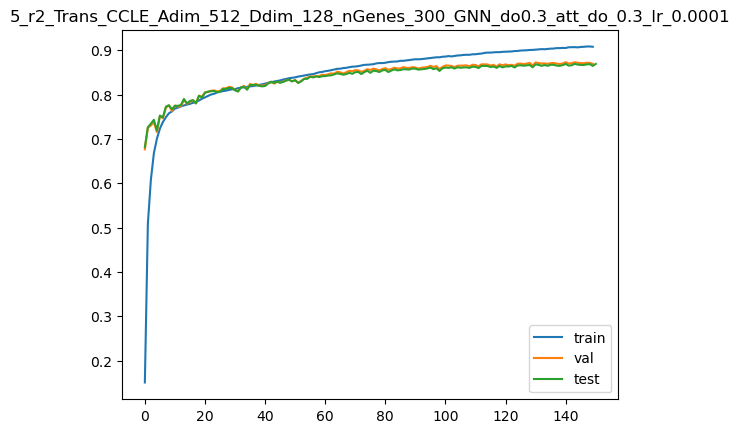

In [5]:
att_dim = 512
all_samples =  gexpr_feature.index
title = name+'_Adim_'+str(att_dim)+'_Ddim_'+str(dim_drug)+'_nGenes_'+str(nGenes)+'_GNN_do'+str(gnn_dropout)+'_att_do_'+str(att_dropout)+'_lr_'+str(lr)

save_path = '/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/5fold/contt/att512/weights/'
img_path = '/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/5fold/contt/att512/imgs/'
result_path = "/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/5fold/contt/att512/results/"

total_train_pcc = []
total_val_pcc = []
total_test_pcc = []
total_train_r2 = []
total_val_r2 = []
total_test_r2 = []
total_train_losses = []
total_test_losses = []
total_val_losses = []

from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.2)

split1 = ss.split(input_df_gexpr)
split2 = ss.split(input_df_gexpr)

fold = 0
for train2_index, test2_index in split2:
    fold += 1

    train2_index, val2_index = train_test_split(train2_index, test_size=1/8)
    train_df_gexpr = input_df_gexpr.iloc[train2_index].reset_index(drop=True)
    val_df_gexpr = input_df_gexpr.iloc[val2_index].reset_index(drop=True)
    test_df_gexpr = input_df_gexpr.iloc[test2_index].reset_index(drop=True)
    train_df_methyl = input_df_methyl.iloc[train2_index].reset_index(drop=True)
    val_df_methyl = input_df_methyl.iloc[val2_index].reset_index(drop=True)
    test_df_methyl = input_df_methyl.iloc[test2_index].reset_index(drop=True)


    train_dataloader = get_gnn_dataloader(train_df_gexpr,train_df_methyl, batch_size=batch_size)
    validation_dataloader = get_gnn_dataloader(val_df_gexpr,val_df_methyl, batch_size=batch_size)
    test_dataloader = get_gnn_dataloader(test_df_gexpr, test_df_methyl,batch_size=batch_size)

    gene_embedding = Gene_Embedding(vocab_size= vocab_size,embed_size=embed_size)

    gnn = GNN_drug(layer_drug = layer_drug, dim_drug = dim_drug, do = gnn_dropout)

    cell_encoder = CTT_Att_Encoder(genes = nGenes, x_dim= embed_size, y_dim = att_dim,
                                        dropout = att_dropout, encoder = C_EnC)

    drug_encoder = CTT_Att_Encoder(genes = nGenes, x_dim= nhid, y_dim = att_dim,
                                        dropout = att_dropout, encoder = D_EnC)


    encoder = Main_Encoder(cell_encoder = cell_encoder, d_dim = nhid,
                            genes=nGenes, y_dim=att_dim, dropout = att_dropout)

    model = GEN(y_dim = att_dim*2, dropout_ratio = fc_dropout,
                gnn = gnn, embedding = gene_embedding, encoder = encoder)

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr) #0.0001
    mse = nn.MSELoss()

    train_pcc = []
    val_pcc = []
    test_pcc = []

    train_r2 = []
    val_r2 = []
    test_r2 = []

    best_pcc = 0
    train_loss = []
    test_loss = []
    val_loss = []
    for ep in range(nb_epoch):
        true_Y = []
        pred_Y = []


        model.train()
        for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(train_dataloader):
            if len(y) >1:
                optimizer.zero_grad()

                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                x_methyl = x_methyl.to(device)
                x_genes_methyl = x_genes_methyl.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)

                loss = mse(pred_y.view(-1),y)

                loss.backward()
                optimizer.step()

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

            if (step+1) %500 ==0:
                print(title)
                print("training step: ", step)
                print("step_training loss: ", loss.item())
                overall_pcc = pearsonr(pred_y,y)[0]
                print("The overall Pearson's correlation is %.4f."%overall_pcc)

        loss_train = mean_squared_error(true_Y, pred_Y)
        pcc_train = pearsonr(true_Y, pred_Y)[0]
        r2_train = r2_score(true_Y, pred_Y)
        print("Train avg_loss: ", loss_train)
        print("Train avg_pcc: ", pcc_train)
        print("Train r2: ", r2_train)

        train_pcc.append(pcc_train)
        train_loss.append(loss_train)
        train_r2.append(r2_train)

        total_val_loss = 0.
        sum_pcc = 0.
        true_Y = []
        pred_Y = []

        model.eval()
        for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(validation_dataloader):
            if len(y) >1:
                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                x_methyl = x_methyl.to(device)
                x_genes_methyl = x_genes_methyl.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)

                loss = mse(pred_y.view(-1),y)

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

                total_val_loss += loss.item()


        loss_val = mean_squared_error(true_Y, pred_Y)
        pcc_val = pearsonr(true_Y, pred_Y)[0]
        r2_val = r2_score(true_Y, pred_Y)

        print("Validation avg_loss: ", loss_val)
        print("Validation avg_pcc: ", pcc_val)
        print("Validation r2: ", r2_val)
        val_loss.append(loss_val)
        val_pcc.append(pcc_val)
        val_r2.append(r2_val)

        if best_pcc < val_r2[-1]:
            best_pcc = val_r2[-1]
            torch.save(model.state_dict(),save_path+title+'.pt')
            print('Best Val r2 ', best_pcc)

        true_Y = []
        pred_Y = []

        model.eval()

        for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(test_dataloader):
            if len(y) >1:
                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                x_methyl = x_methyl.to(device)
                x_genes_methyl = x_genes_methyl.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)
                loss = mse(pred_y.view(-1),y)

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

        loss_test = mean_squared_error(true_Y, pred_Y)
        pcc_test = pearsonr(true_Y, pred_Y)[0]
        r2_test = r2_score(true_Y, pred_Y)

        print("Test avg_loss: ", loss_test)
        print("Test avg_pcc: ", pcc_test)
        print("Test r2: ", r2_test)

        test_pcc.append(pcc_test)
        test_loss.append(loss_test)
        test_r2.append(r2_test)

        if (ep+1) %50 ==0:
            input_title = str(fold)+'_Loss_'+title
            show_picture(train_loss,val_loss, test_loss, input_title)
            input_title = str(fold)+'_PCC_'+title
            show_picture(train_pcc,val_pcc, test_pcc, input_title)
            input_title = str(fold)+'_r2_'+title
            show_picture(train_r2,val_r2, test_r2, input_title)


        print("#################### epoch ############################ ",ep)

    model.load_state_dict(torch.load(save_path+title+'.pt'))
    torch.save(model.state_dict(), save_path+title+'_final.pt')
    true_Y = []
    pred_Y = []

    model.eval()

    for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(test_dataloader):
        if len(y) >1:
            x_drug = x_drug.to(device)
            x_gexpr = x_gexpr.to(device)
            x_genes_gexpr = x_genes_gexpr.to(device)
            x_methyl = x_methyl.to(device)
            x_genes_methyl = x_genes_methyl.to(device)
            y = y.to(device).float()

            pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)
            loss = mse(pred_y.view(-1),y)

            pred_y = pred_y.view(-1).detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            true_Y += list(y)
            pred_Y += list(pred_y)


    loss_test = mean_squared_error(true_Y, pred_Y)
    pcc_test = pearsonr(true_Y, pred_Y)[0]
    r2_test = r2_score(true_Y, pred_Y)

    print("Test avg_loss: ", loss_test)
    print("Test avg_pcc: ", pcc_test)
    print("Test r2: ", r2_test)

    test_pcc.append(pcc_test)
    test_loss.append(loss_test)
    test_r2.append(r2_test)

    input_title = str(fold)+'_Loss_'+title
    show_picture(train_loss,val_loss, test_loss, input_title,path=img_path, save=True)
    input_title = str(fold)+'_PCC_'+title
    show_picture(train_pcc,val_pcc, test_pcc, input_title,path=img_path, save=True)
    input_title = str(fold)+'_r2_'+title
    show_picture(train_r2,val_r2, test_r2, input_title,path=img_path, save=True)

    total_train_pcc.append(train_pcc)
    total_val_pcc.append(val_pcc)

    total_train_r2.append(train_r2)
    total_val_r2.append(val_r2)

    total_train_losses.append(train_loss)
    total_val_losses.append(val_loss)

    total_test_pcc.append(pcc_test)
    total_test_r2.append(r2_test)
    total_test_losses.append(loss_test)

    df_test_pcc = pd.DataFrame(data = total_test_pcc)
    df_test_r2 = pd.DataFrame(data = total_test_r2)

    df_test_losses = pd.DataFrame(data = total_test_losses)

    df_test_pcc.to_csv(result_path+title+'_pcc.csv')
    df_test_r2.to_csv(result_path+title+'_r2.csv')

    df_test_losses.to_csv(result_path+title+'_loss.csv')